#  Prédiction dauteurs littéraires à partir de différentes méthodes de vectorisation



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&security.allowlist.enabled=false&init.personalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=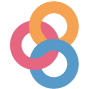)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb)

Cette page approfondit certains aspects présentés dans la
[partie introductive](#nlp). Après avoir travaillé sur le
*Comte de Monte Cristo*, on va continuer notre exploration de la littérature
avec cette fois des auteurs anglophones:

* Edgar Allan Poe, (EAP) ;
* HP Lovecraft (HPL) ;
* Mary Wollstonecraft Shelley (MWS).

Les données sont disponibles ici : [spooky.csv](https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/blob/master/data/spooky.csv) et peuvent être requétées via l'url 
<https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv>.

Le but va être dans un premier temps de regarder dans le détail les termes les plus fréquents utilisés par les auteurs, de les représenter graphiquement puis on va ensuite essayer de prédire quel texte correspond à quel auteur à partir de différents modèles de vectorisation, notamment les *word embeddings*.

Ce notebook est librement inspiré de  : 

* https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras
* https://github.com/GU4243-ADS/spring2018-project1-ginnyqg
* https://www.kaggle.com/meiyizi/spooky-nlp-and-topic-modelling-tutorial/notebook


Comme dans la [partie précédente](#nlp), il faut télécharger quelques éléments
pour que nos librairies de NLP puissent fonctionner correctement.

En premier lieu, il convient d'installer les librairies adéquates
(`spacy`, `gensim` et `sentence_transformers`):


In [ ]:
!pip install spacy gensim sentence_transformers

Ensuite, comme nous allons utiliser également `spacy`, il convient de télécharger
le corpus Anglais. Pour cela, on peut se référer à
[la documentation de `spacy`](https://spacy.io/usage/models),
extrèmement bien faite.

- Idéalement, il faut installer le module via la ligne de commande. Dans
une cellule de notebook `Jupyter`, faire :


In [ ]:
!python -m spacy download en_core_web_sm

- Sans accès à la ligne de commande (depuis une instance `Docker` par exemple),
faire :


In [ ]:
import spacy
spacy.cli.download("en_core_web_sm")

- Sinon, il est également possible d'installer le module en faisant pointer
`pip install` depuis le fichier adéquat sur
[`Github`](https://github.com/explosion/spacy-models). Pour cela, taper

~~~python
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl
~~~






In [ ]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import gensim

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from gensim.models.word2vec import Word2Vec
import gensim.downloader
from sentence_transformers import SentenceTransformer

# Nettoyage des données

Nous allons ainsi à nouveau utiliser le jeu de données `spooky`:


In [ ]:
data_url = 'https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv'
spooky_df = pd.read_csv(data_url)

Le jeu de données met ainsi en regard un auteur avec une phrase qu'il a écrite:


In [ ]:
spooky_df.head()

```
##         id                                               text author
## 0  id26305  This process, however, afforded me no means of...    EAP
## 1  id17569  It never once occurred to me that the fumbling...    HPL
## 2  id11008  In his left hand was a gold snuff box, from wh...    EAP
## 3  id27763  How lovely is spring As we looked from Windsor...    MWS
## 4  id12958  Finding nothing else, not even gold, the Super...    HPL
```

Pour rappel, nous avons les auteurs suivants dans notre corpus:


In [ ]:
initials_to_author = {
    'EAP': 'Edgar Allen Poe',
    'HPL': 'H.P. Lovecraft',
    'MWS': 'Mary Wollstonecraft Shelley'
}

## Preprocessing

En NLP, la première étape est souvent celle du *preprocessing*, qui inclut notamment les étapes de tokenization et de nettoyage du texte. Comme celles-ci ont été vues en détail dans le précédent chapitre, on se contentera ici d'un *preprocessing* minimaliste : suppression de la ponctuation et suppression des *stop words* (pour la visualisation et les méthodes de vectorisation basées sur des comptages).

Jusqu'à présent, nous avons utilisé principalement `nltk` pour le 
*preprocessing* de données textuelles. Cette fois, nous proposons
d'utiliser la librairie `spaCy` qui permet de mieux automatiser sous forme de
*pipeline* de *preprocessing*. 



In [ ]:
nlp = spacy.load('en_core_web_sm')

```
## Error in py_call_impl(callable, dots$args, dots$keywords): OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/spacy/__init__.py", line 51, in load
##     return util.load_model(
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/spacy/util.py", line 427, in load_model
##     raise IOError(Errors.E050.format(name=name))
```

On va utiliser un `pipe` `spacy` qui permet d'automatiser, et de paralléliser,
un certain nombre d'opérations. Les *pipes* sont l'équivalent, en NLP, de
nos *pipelines* `scikit` ou des *pipes* `pandas`. Il s'agit donc d'un outil
très approprié pour industrialiser un certain nombre d'opérations de
*preprocessing*:


In [ ]:
def clean_docs(texts, remove_stopwords=False, n_process = 4):
    
    docs = nlp.pipe(texts, 
                    n_process=n_process,
                    disable=['parser', 'ner',
                             'lemmatizer', 'textcat'])
    stopwords = nlp.Defaults.stop_words

    docs_cleaned = []
    for doc in docs:
        tokens = [tok.text.lower().strip() for tok in doc if not tok.is_punct]
        if remove_stopwords:
            tokens = [tok for tok in tokens if tok not in stopwords]
        doc_clean = ' '.join(tokens)
        docs_cleaned.append(doc_clean)
        
    return docs_cleaned

On applique la fonction `clean_docs` à notre colonne `pandas`.
Les `pandas.Series` étant itérables, elles se comportent comme des listes et
fonctionnent ainsi très bien avec notre `pipe` `spacy`


In [ ]:
spooky_df['text_clean'] = clean_docs(spooky_df['text'])

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'nlp' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "<string>", line 3, in clean_docs
```


In [ ]:
spooky_df.head()

```
##         id                                               text author
## 0  id26305  This process, however, afforded me no means of...    EAP
## 1  id17569  It never once occurred to me that the fumbling...    HPL
## 2  id11008  In his left hand was a gold snuff box, from wh...    EAP
## 3  id27763  How lovely is spring As we looked from Windsor...    MWS
## 4  id12958  Finding nothing else, not even gold, the Super...    HPL
```

## Encodage de la variable à prédire

On réalise un simple encodage de la variable à prédire :
il y a trois catégories, représentées par des entiers de 0 à 2.

Pour cela, on utilise le `LabelEncoder` de `scikit` déjà présenté 
dans la [partie modélisation](#preprocessing). On va utiliser la méthode
`fit_transform` qui permet, en un tour de main, d'appliquer à la fois
l'entraînement (`fit`), à savoir la création d'une correspondance entre valeurs
numériques et _labels_, et l'appliquer (`transform`) à la même colonne.


In [ ]:
le = LabelEncoder()
spooky_df['author_encoded'] = le.fit_transform(spooky_df['author'])

On peut vérifier les classes de notre `LabelEncoder`:


In [ ]:
le.classes_

```
## array(['EAP', 'HPL', 'MWS'], dtype=object)
```

## Construction des bases d'entraînement et de test

On met de côté un échantillon de test (20 %) avant toute analyse (même descriptive).
Cela permettra d'évaluer nos différents modèles toute à la fin de manière très rigoureuse,
puisque ces données n'auront jamais utilisées pendant l'entraînement.

Notre échantillon initial n'est pas balancé puisqu'on retrouve plus d'oeuvres de
certains auteurs que d'autres. On va donc stratifier notre échantillon
pour s'assurer qu'on a bien une répartition similaire d'auteurs dans nos
ensembles d'entraînement et de test.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(spooky_df['text_clean'].values, 
                                                    spooky_df['author_encoded'].values, 
                                                    test_size=0.2, 
                                                    random_state=33,
                                                    stratify = spooky_df['author_encoded'].values)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): KeyError: 'text_clean'
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/frame.py", line 3458, in __getitem__
##     indexer = self.columns.get_loc(key)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3363, in get_loc
##     raise KeyError(key) from err
```



In [ ]:
X_train[0]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

On peut aussi vérifier qu'on est capable de retrouver
la correspondance entre nos auteurs initiaux avec
la méthode `inverse_transform`


In [ ]:
print(y_train[0], le.inverse_transform([y_train[0]])[0])

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_train' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

# Statistiques exploratoires

## Répartition des labels



In [ ]:
plt.style.use('dark_background')
pd.Series(le.inverse_transform(y_train)).value_counts().plot(kind='bar')

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_train' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

On observe une petite asymétrie : les passages des livres d'Edgar Allen Poe sont plus nombreux dans notre corpus d'entraînement, ce qui peut être problématique dans le cadre d'une tâche de classification.
L'écart n'est pas dramatique, mais on essaiera d'en tenir compte dans l'analyse en choisissant une métrique d'évaluation pertinente. 

## Mots les plus fréquemment utilisés par chaque auteur



In [ ]:
# Suppression des stop words
X_train_no_sw = clean_docs(X_train, remove_stopwords=True)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
X_train_no_sw = np.array(X_train_no_sw)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train_no_sw' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

Pour visualiser rapidement nos corpus, on peut utiliser la technique des
nuages de mots déjà vue à plusieurs reprises. 

Vous pouvez essayer de faire vous-même les nuages ci-dessous
ou cliquer sur la ligne ci-dessous pour afficher le code ayant
généré les figures:



In [ ]:
def plot_top_words(initials, n_words=20):
    # Calcul des mots les plus fréquemment utilisés par l'auteur
    texts = X_train_no_sw[le.inverse_transform(y_train) == initials]
    all_tokens = ' '.join(texts).split()
    counts = Counter(all_tokens)
    top_words = [word[0] for word in counts.most_common(n_words)]
    top_words_counts = [word[1] for word in counts.most_common(n_words)]
    
    # Représentation sous forme de barplot
    plt.style.use('dark_background')
    plt.figure(figsize=(20, 6))
    sns.barplot(x=top_words, y=top_words_counts)
    plt.title(f'Most Common Words used by {initials_to_author[initials]}')
    plt.show()

In [ ]:
plot_top_words('EAP')

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train_no_sw' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "<string>", line 3, in plot_top_words
```

In [ ]:
plot_top_words('HPL')

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train_no_sw' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "<string>", line 3, in plot_top_words
```

In [ ]:
plot_top_words('MWS')

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train_no_sw' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "<string>", line 3, in plot_top_words
```

Beaucoup de mots se retrouvent très utilisés par les trois auteurs.
Il y a cependant des différences notables : le mot _"life"_
est le plus employé par MWS, alors qu'il n'apparaît pas dans les deux autres tops.
De même, le mot _"old"_ est le plus utilisé par HPL
là où les deux autres ne l'utilisent pas de manière surreprésentée.

Il semble donc qu'il y ait des particularités propres à chacun des auteurs
en termes de vocabulaire,
ce qui laisse penser qu'il est envisageable de prédire les auteurs à partir
de leurs textes dans une certaine mesure.

## Prédiction sur le set d'entraînement

Nous allons à présent vérifier cette conjecture en comparant
plusieurs modèles de vectorisation,
_i.e._ de transformation du texte en objets numériques
pour que l'information contenue soit exploitable dans un modèle de classification.

Comme nous nous intéressons plus à l'effet de la vectorisation qu'à la tâche de classification en elle-même,
nous allons utiliser un algorithme de classification simple (un SVM linéaire), avec des paramètres non fine-tunés.

Ce modèle est connu pour être très performant sur les tâches de classification de texte, et nous fournira donc une bonne *baseline*. Cela nous permettra également de comparer de manière objective l'impact des méthodes de vectorisation sur la performance finale.

On va utiliser au maximum les objets de type pipeline de `sklearn`,
qui permettent de réaliser des analyses reproductibles
et de fine-tuner proprement les différents hyperparamètres.

Pour les deux premières méthodes de vectorisation
(basées sur des fréquences et fréquences relatives des mots),
on va simplement normaliser les données d'entrée, ce qui va permettre au SVM de converger plus rapidement, ces modèles étant sensibles aux différences d'échelle dans les données.

On va également fine-tuner via grid-search certains hyperparamètres liés à ces méthodes de vectorisation : 
- on teste différents _ranges_ de `n-grams` (unigrammes et unigrammes + bigrammes)
- on teste avec et sans _stop-words_

Afin d'éviter le surapprentissage,
on va évaluer les différents modèles via validation croisée, calculée sur 4 blocs.

On récupère à la fin le meilleur modèle selon une métrique spécifiée.
On choisit le `score F1`,
moyenne harmonique de la précision et du rappel,
qui donne un poids équilibré aux deux métriques, tout en pénalisant fortement le cas où l'une des deux est faible.
Précisément, on retient le `score F1 *micro-averaged*` : les contributions des différentes classes à prédire sont aggrégées, puis l'on calcule le score F1 sur ces données aggrégées. L'avantage de ce choix est qu'il permet de tenir compte des différences de fréquences des différentes classes.



In [ ]:
clf = LinearSVC(max_iter=10000, C=0.1)

On va utiliser un *pipeline* `scikit` ce qui va nous permettre d'avoir
un code très concis pour effectuer cet ensemble de tâches cohérentes. 
De plus, cela va nous assurer de gérer de manière cohérentes nos différentes
transformations (cf. [partie sur les pipelines](#pipelines))


In [ ]:
def fit_vectorizers(vectorizer):
    pipeline = Pipeline(
    [
        ("vect", vectorizer()),
        ("scaling", StandardScaler(with_mean=False)),
        ("clf", clf),
    ]
    )

    parameters = {
        "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
        "vect__stop_words": ("english", None)
    }

    grid_search = GridSearchCV(pipeline, parameters, scoring='f1_micro',
                               cv=4, n_jobs=4, verbose=1)
    grid_search.fit(X_train, y_train)

    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    print(f"CV scores {grid_search.cv_results_['mean_test_score']}")
    print(f"Mean F1 {np.mean(grid_search.cv_results_['mean_test_score'])}")

# Bag-of-words

On commence par une approche _"bag-of-words"_, 
i.e. qui revient simplement à représenter chaque document par un vecteur
qui compte le nombre d'apparitions de chaque mot du vocabulaire dans le document.



In [ ]:
fit_vectorizers(CountVectorizer)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "<string>", line 17, in fit_vectorizers
```

# TF-IDF

On s'intéresse ensuite à l'approche TF-IDF,
qui permet de tenir compte des fréquences *relatives* des mots.

Ainsi, pour un mot donné, on va multiplier la fréquence d'apparition du mot dans le document (calculé comme dans la méthode précédente) par un terme qui pénalise une fréquence élevée du mot dans le corpus.

La vectorisation TF-IDF permet donc de limiter l'influence des *stop-words* et donc de donner plus de poids aux mots les plus salients d'un document. On observe clairement que la performance de classification est bien supérieure, ce qui montre la pertinence de cette technique.



In [ ]:
fit_vectorizers(TfidfVectorizer)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "<string>", line 17, in fit_vectorizers
```

# Word2vec + averaging

On va maintenant explorer les techniques de vectorisation basées sur les *embeddings* de mots, et notamment la plus populaire : `word2vec`.

L'idée derrière est simple, mais a révolutionné le NLP :
au lieu de représenter les documents par des
vecteurs *sparse* de très grande dimension (la taille du vocabulaire)
comme on l'a fait jusqu'à présent,
on va les représenter par des vecteurs *dense* (continus)
de dimension réduite (en général, autour de 100-300).

Chacune de ces dimensions va représenter un facteur latent,
c'est à dire une variable inobservée,
de la même manière que les composantes principales produites par une ACP.

![title](w2v_vecto.png)

_Pourquoi est-ce intéressant ?_
Pour de nombreuses raisons, mais pour résumer :
cela permet de beaucoup mieux capturer la similarité sémantique entre les documents.

Par exemple, un humain sait qu'un document contenant le mot _"Roi"_
et un autre document contenant le mot _"Reine"_ ont beaucoup de chance
d'aborder des sujets semblables.

Pourtant, une vectorisation de type comptage ou TF-IDF
ne permet pas de saisir cette similarité :
le calcul d'une mesure de similarité (norme euclidienne ou similarité cosine)
entre les deux vecteurs ne prendra en compte la similarité des deux concepts, puisque les mots utilisés sont différents.

A l'inverse, un modèle `word2vec` bien entraîné va capter
qu'il existe un facteur latent de type _"royauté"_,
et la similarité entre les vecteurs associés aux deux mots sera forte.

La magie va même plus loin : le modèle captera aussi qu'il existe un
facteur latent de type _"genre"_,
et va permettre de construire un espace sémantique dans lequel les
relations arithmétiques entre vecteurs ont du sens ;
par exemple :
$$\text{king} - \text{man} + \text{woman} ≈ \text{queen}$$

_Comment ces modèles sont-ils entraînés ?_
Via une tâche de prédiction résolue par un réseau de neurones simple.

L'idée fondamentale est que la signification d'un mot se comprend
en regardant les mots qui apparaissent fréquemment dans son voisinage.

Pour un mot donné, on va donc essayer de prédire les mots
qui apparaissent dans une fenêtre autour du mot cible.

En répétant cette tâche de nombreuses fois et sur un corpus suffisamment varié,
on obtient finalement des *embeddings* pour chaque mot du vocabulaire,
qui présentent les propriétés discutées précédemment.



In [ ]:
X_train_tokens = [text.split() for text in X_train]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
w2v_model = Word2Vec(X_train_tokens, vector_size=200, window=5, 
                     min_count=1, workers=4)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train_tokens' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```



In [ ]:
w2v_model.wv.most_similar("mother")

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'w2v_model' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

On voit que les mots les plus similaires à _"mother"_
sont souvent des mots liés à la famille, mais pas toujours.

C'est lié à la taille très restreinte du corpus sur lequel on entraîne le modèle,
qui ne permet pas de réaliser des associations toujours pertinentes.



In [ ]:
def get_mean_vector(w2v_vectors, words):
    words = [word for word in words if word in w2v_vectors]
    if words:
        avg_vector = np.mean(w2v_vectors[words], axis=0)
    else:
        avg_vector = np.zeros_like(w2v_vectors['hi'])
    return avg_vector

def fit_w2v_avg(w2v_vectors):
    X_train_vectors = np.array([get_mean_vector(w2v_vectors, words)
                                for words in X_train_tokens])
    
    scores = cross_val_score(clf, X_train_vectors, y_train, 
                         cv=4, scoring='f1_micro', n_jobs=4)

    print(f"CV scores {scores}")
    print(f"Mean F1 {np.mean(scores)}")

In [ ]:
fit_w2v_avg(w2v_model.wv)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'w2v_model' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

La performance chute fortement ;
la faute à la taille très restreinte du corpus, comme annoncé précédemment.

# Word2vec pré-entraîné + averaging

Quand on travaille avec des corpus de taille restreinte,
c'est généralement une mauvaise idée d'entraîner son propre modèle `word2vec`.

Heureusement, des modèles pré-entraînés sur de très gros corpus sont disponibles.
Ils permettent de réaliser du *transfer learning*,
c'est à dire de bénéficier de la performance d'un modèle qui a été entraîné sur une autre tâche ou bien un autre corpus.



In [ ]:
glove_model = gensim.downloader.load('glove-wiki-gigaword-200')

```
## 
[--------------------------------------------------] 0.0% 0.0/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.0/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.0/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.0/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.0/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.0/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.0/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.0% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.1/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.2/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.3/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.1% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.4/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.5/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.2% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.6/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.7/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.8/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.3% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.4% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.4% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.4% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.4% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.4% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.4% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.4% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.4% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.4% 0.9/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.0/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.4% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.1/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.2/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.3/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.5% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.4/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.5/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.6% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.6/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.7/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.8/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.7% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.8% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.8% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.8% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.8% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.8% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.8% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.8% 1.9/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.0/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.8% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.1/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.2/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.3/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.4/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.4/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.4/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.4/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.4/252.1MB downloaded
[--------------------------------------------------] 0.9% 2.4/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.4/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.4/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.4/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.4/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.4/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.4/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.4/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.5/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.0% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.6/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.7/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.8/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.1% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.2% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.2% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.2% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.2% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.2% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.2% 2.9/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.0/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.2% 3.1/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.2/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.3/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.3% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.4/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.5/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.4% 3.6/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.7/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.8/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.5% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.6% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.6% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.6% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.6% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.6% 3.9/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.0/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.1/252.1MB downloaded
[--------------------------------------------------] 1.6% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.2/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.3/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.7% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.4/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.5/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.6/252.1MB downloaded
[--------------------------------------------------] 1.8% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.7/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.8/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.9/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.9/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.9/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.9/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.9/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.9/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.9/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.9/252.1MB downloaded
[--------------------------------------------------] 1.9% 4.9/252.1MB downloaded
[--------------------------------------------------] 2.0% 4.9/252.1MB downloaded
[--------------------------------------------------] 2.0% 4.9/252.1MB downloaded
[--------------------------------------------------] 2.0% 4.9/252.1MB downloaded
[--------------------------------------------------] 2.0% 4.9/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[--------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.0/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.1/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.0% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.2/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.3/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.1% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.4/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.5/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.6/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.2% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.7/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.8/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.3% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.4% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.4% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.4% 5.9/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.0/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.1/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.4% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.2/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.3/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.5% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.4/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.5/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.6/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.6% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.7/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.8/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.7% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.8% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.8% 6.9/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.0/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.1/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.8% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.2/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.3/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.4/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.4/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.4/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.4/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.4/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.4/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.4/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.4/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.4/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.4/252.1MB downloaded
[=-------------------------------------------------] 2.9% 7.4/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.4/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.4/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.5/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.6/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.0% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.7/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.8/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.1% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.2% 7.9/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.0/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.1/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.2% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.2/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.3/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.3% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.4/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.5/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.6/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.4% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.7/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.8/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.5% 8.9/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.0/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.1/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.6% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.2/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.3/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.4/252.1MB downloaded
[=-------------------------------------------------] 3.7% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.5/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.6/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.8% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.7/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.8/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 9.9/252.1MB downloaded
[=-------------------------------------------------] 3.9% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.0/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[=-------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.1/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.0% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.2/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.3/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.4/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.1% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.5/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.6/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.2% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.7/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.8/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 10.9/252.1MB downloaded
[==------------------------------------------------] 4.3% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.3% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.0/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.1/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.4% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.2/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.3/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.4/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.5% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.5/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.6/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.6% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.7/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.8/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 11.9/252.1MB downloaded
[==------------------------------------------------] 4.7% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.7% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.7% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.0/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.1/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.8% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.2/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.3/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.4/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.5/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.5/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.5/252.1MB downloaded
[==------------------------------------------------] 4.9% 12.5/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.5/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.5/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.5/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.5/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.5/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.5/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.5/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.5/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.5/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.6/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.0% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.7/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.8/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 12.9/252.1MB downloaded
[==------------------------------------------------] 5.1% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.1% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.1% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.1% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.0/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.1/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.2% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.2/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.3/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.4/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.3% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.5/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.6/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.4% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.7/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.8/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 13.9/252.1MB downloaded
[==------------------------------------------------] 5.5% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.5% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.5% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.5% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.5% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.0/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.1/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.6% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.2/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.3/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.4/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.7% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.5/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.6/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.8% 14.7/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.8/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 14.9/252.1MB downloaded
[==------------------------------------------------] 5.9% 15.0/252.1MB downloaded
[==------------------------------------------------] 5.9% 15.0/252.1MB downloaded
[==------------------------------------------------] 5.9% 15.0/252.1MB downloaded
[==------------------------------------------------] 5.9% 15.0/252.1MB downloaded
[==------------------------------------------------] 5.9% 15.0/252.1MB downloaded
[==------------------------------------------------] 5.9% 15.0/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.0/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.0/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.0/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.0/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.0/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.0/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.0/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.1/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.1/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.1/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.1/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.1/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.1/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.1/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.1/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.1/252.1MB downloaded
[==------------------------------------------------] 6.0% 15.1/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.1/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.1/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.1/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.0% 15.2/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.3/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.4/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.1% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.5/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.6/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.7/252.1MB downloaded
[===-----------------------------------------------] 6.2% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.8/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 15.9/252.1MB downloaded
[===-----------------------------------------------] 6.3% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.3% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.3% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.3% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.3% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.3% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.3% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.0/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.1/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.2/252.1MB downloaded
[===-----------------------------------------------] 6.4% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.3/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.4/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.5% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.5/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.6/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.7/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.6% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.8/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 16.9/252.1MB downloaded
[===-----------------------------------------------] 6.7% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.7% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.7% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.7% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.7% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.7% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.7% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.7% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.7% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.0/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.1/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.2/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.8% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.3/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.4/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.5/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.5/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.5/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.5/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.5/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.5/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.5/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.5/252.1MB downloaded
[===-----------------------------------------------] 6.9% 17.5/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.5/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.5/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.5/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.5/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.6/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.7/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.0% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.8/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 17.9/252.1MB downloaded
[===-----------------------------------------------] 7.1% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.1% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.1% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.1% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.1% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.1% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.1% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.1% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.1% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.1% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.0/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.1/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.2/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.2% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.3/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.4/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.3% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.5/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.6/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.7/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.4% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.8/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 18.9/252.1MB downloaded
[===-----------------------------------------------] 7.5% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.5% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.5% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.5% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.5% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.5% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.5% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.5% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.5% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.5% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.5% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.0/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.1/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.2/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.6% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.3/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.4/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.7% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.5/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.6/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.7/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.8% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.8/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 19.9/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 7.9% 20.0/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.0/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.1/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[===-----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.2/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.0% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.3/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.4/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.1% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.5/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.6/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.7/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.2% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.8/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 20.9/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.3% 21.0/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.1/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.2/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.4% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.3/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.4/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.5% 21.5/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.6/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.7/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.6% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.8/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 21.9/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.0/252.1MB downloaded
[====----------------------------------------------] 8.7% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.1/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.2/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.8% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.3/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.4/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.5/252.1MB downloaded
[====----------------------------------------------] 8.9% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.6/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.7/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.0% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.8/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 22.9/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.0/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.1% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.1/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.2/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.2% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.3/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.5/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.3% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.6/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.7/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.4% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.8/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 23.9/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.0/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.5% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.1/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.2/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.6% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.3/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.4/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.5/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.7% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.6/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.7/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.8% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.8/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 24.9/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.0/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.1/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.1/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.1/252.1MB downloaded
[====----------------------------------------------] 9.9% 25.1/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.1/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.1/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.1/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.1/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.1/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.1/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.1/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.1/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.1/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.2/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.2/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.2/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.2/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.2/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.2/252.1MB downloaded
[====----------------------------------------------] 10.0% 25.2/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.2/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.2/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.2/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.2/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.2/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.2/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.0% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.3/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.4/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.5/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.1% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.6/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.7/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.2% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.8/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 25.9/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.0/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.3% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.1/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.2/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.4% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.3/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.4/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.5/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.5% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.6/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.7/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.6% 26.8/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 26.9/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.0/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.7% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.1/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.2/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.3/252.1MB downloaded
[=====---------------------------------------------] 10.8% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.4/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.5/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.6/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.6/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.6/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.6/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.6/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.6/252.1MB downloaded
[=====---------------------------------------------] 10.9% 27.6/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.6/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.6/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.6/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.6/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.6/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.6/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.7/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.8/252.1MB downloaded
[=====---------------------------------------------] 11.0% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 27.9/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.0/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.1% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.1/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.2/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.3/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.2% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.4/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.5/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.3% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.6/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.7/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.8/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.4% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 28.9/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.0/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.5% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.1/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.2/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.3/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.6% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.4/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.5/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.7% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.6/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.7/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.8/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.8% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.9% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.9% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.9% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.9% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.9% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.9% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.9% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.9% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.9% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.9% 29.9/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.0/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.1/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.1/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.1/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.1/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.1/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.1/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.1/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.1/252.1MB downloaded
[=====---------------------------------------------] 11.9% 30.1/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.1/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.1/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.1/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.1/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[=====---------------------------------------------] 12.0% 30.2/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.3/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.0% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.4/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.5/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.1% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.6/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.7/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.8/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.2% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.3% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.3% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.3% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.3% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.3% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.3% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.3% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.3% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.3% 30.9/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.0/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.3% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.1/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.2/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.3/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.4% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.4/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.5/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.5% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.6/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.7/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.8/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.6% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.7% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.7% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.7% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.7% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.7% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.7% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.7% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.7% 31.9/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.0/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.7% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.1/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.2/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.3/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.8% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.4/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.5/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 12.9% 32.6/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.6/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.7/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.8/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.0% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.1% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.1% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.1% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.1% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.1% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.1% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.1% 32.9/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.0/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.1% 33.1/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.2/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.3/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.2% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.4/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.5/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.3% 33.6/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.7/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.8/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.4% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.5% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.5% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.5% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.5% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.5% 33.9/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.0/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.1/252.1MB downloaded
[======--------------------------------------------] 13.5% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.2/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.3/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.6% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.4/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.5/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.6/252.1MB downloaded
[======--------------------------------------------] 13.7% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.7/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.8/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.8% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.9% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.9% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.9% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.9% 34.9/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.0/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.1/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.2/252.1MB downloaded
[======--------------------------------------------] 13.9% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.2/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.3/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.3/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.3/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.3/252.1MB downloaded
[======--------------------------------------------] 14.0% 35.3/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.3/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.3/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.3/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.3/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.3/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.3/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.3/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.0% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.4/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.5/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.6/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.1% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.7/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.8/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.2% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.3% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.3% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.3% 35.9/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.0/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.1/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.3% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.2/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.3/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.4% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.4/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.5/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.6/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.5% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.7/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.8/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.6% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.7% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.7% 36.9/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.0/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.1/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.7% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.2/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.3/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.8% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.4/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.5/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.6/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.7/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.7/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.7/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.7/252.1MB downloaded
[=======-------------------------------------------] 14.9% 37.7/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.7/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.7/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.7/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.7/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.7/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.7/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.7/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.8/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.0% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.1% 37.9/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.0/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.1/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.1% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.2/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.3/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.2% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.4/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.5/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.6/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.3% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.7/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.8/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.4% 38.9/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.0/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.1/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.5% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.2/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.3/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.6% 39.4/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.5/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.6/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.7% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.7/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.8/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 39.9/252.1MB downloaded
[=======-------------------------------------------] 15.8% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.0/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.1/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.2/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.2/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.2/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.2/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.2/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.2/252.1MB downloaded
[=======-------------------------------------------] 15.9% 40.2/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.2/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.2/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.2/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.2/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.2/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.2/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.3/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.3/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.3/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.3/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.3/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.3/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.3/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.3/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.3/252.1MB downloaded
[=======-------------------------------------------] 16.0% 40.3/252.1MB downloaded
[========------------------------------------------] 16.0% 40.3/252.1MB downloaded
[========------------------------------------------] 16.0% 40.3/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.4/252.1MB downloaded
[========------------------------------------------] 16.0% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.5/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.6/252.1MB downloaded
[========------------------------------------------] 16.1% 40.7/252.1MB downloaded
[========------------------------------------------] 16.1% 40.7/252.1MB downloaded
[========------------------------------------------] 16.1% 40.7/252.1MB downloaded
[========------------------------------------------] 16.1% 40.7/252.1MB downloaded
[========------------------------------------------] 16.1% 40.7/252.1MB downloaded
[========------------------------------------------] 16.1% 40.7/252.1MB downloaded
[========------------------------------------------] 16.1% 40.7/252.1MB downloaded
[========------------------------------------------] 16.1% 40.7/252.1MB downloaded
[========------------------------------------------] 16.2% 40.7/252.1MB downloaded
[========------------------------------------------] 16.2% 40.7/252.1MB downloaded
[========------------------------------------------] 16.2% 40.7/252.1MB downloaded
[========------------------------------------------] 16.2% 40.7/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.8/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 40.9/252.1MB downloaded
[========------------------------------------------] 16.2% 41.0/252.1MB downloaded
[========------------------------------------------] 16.2% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.0/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.1/252.1MB downloaded
[========------------------------------------------] 16.3% 41.2/252.1MB downloaded
[========------------------------------------------] 16.3% 41.2/252.1MB downloaded
[========------------------------------------------] 16.3% 41.2/252.1MB downloaded
[========------------------------------------------] 16.3% 41.2/252.1MB downloaded
[========------------------------------------------] 16.3% 41.2/252.1MB downloaded
[========------------------------------------------] 16.3% 41.2/252.1MB downloaded
[========------------------------------------------] 16.3% 41.2/252.1MB downloaded
[========------------------------------------------] 16.3% 41.2/252.1MB downloaded
[========------------------------------------------] 16.4% 41.2/252.1MB downloaded
[========------------------------------------------] 16.4% 41.2/252.1MB downloaded
[========------------------------------------------] 16.4% 41.2/252.1MB downloaded
[========------------------------------------------] 16.4% 41.2/252.1MB downloaded
[========------------------------------------------] 16.4% 41.2/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.3/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.4/252.1MB downloaded
[========------------------------------------------] 16.4% 41.5/252.1MB downloaded
[========------------------------------------------] 16.4% 41.5/252.1MB downloaded
[========------------------------------------------] 16.4% 41.5/252.1MB downloaded
[========------------------------------------------] 16.5% 41.5/252.1MB downloaded
[========------------------------------------------] 16.5% 41.5/252.1MB downloaded
[========------------------------------------------] 16.5% 41.5/252.1MB downloaded
[========------------------------------------------] 16.5% 41.5/252.1MB downloaded
[========------------------------------------------] 16.5% 41.5/252.1MB downloaded
[========------------------------------------------] 16.5% 41.5/252.1MB downloaded
[========------------------------------------------] 16.5% 41.5/252.1MB downloaded
[========------------------------------------------] 16.5% 41.5/252.1MB downloaded
[========------------------------------------------] 16.5% 41.5/252.1MB downloaded
[========------------------------------------------] 16.5% 41.5/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.6/252.1MB downloaded
[========------------------------------------------] 16.5% 41.7/252.1MB downloaded
[========------------------------------------------] 16.5% 41.7/252.1MB downloaded
[========------------------------------------------] 16.5% 41.7/252.1MB downloaded
[========------------------------------------------] 16.5% 41.7/252.1MB downloaded
[========------------------------------------------] 16.5% 41.7/252.1MB downloaded
[========------------------------------------------] 16.5% 41.7/252.1MB downloaded
[========------------------------------------------] 16.5% 41.7/252.1MB downloaded
[========------------------------------------------] 16.5% 41.7/252.1MB downloaded
[========------------------------------------------] 16.5% 41.7/252.1MB downloaded
[========------------------------------------------] 16.6% 41.7/252.1MB downloaded
[========------------------------------------------] 16.6% 41.7/252.1MB downloaded
[========------------------------------------------] 16.6% 41.7/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.8/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 41.9/252.1MB downloaded
[========------------------------------------------] 16.6% 42.0/252.1MB downloaded
[========------------------------------------------] 16.6% 42.0/252.1MB downloaded
[========------------------------------------------] 16.6% 42.0/252.1MB downloaded
[========------------------------------------------] 16.7% 42.0/252.1MB downloaded
[========------------------------------------------] 16.7% 42.0/252.1MB downloaded
[========------------------------------------------] 16.7% 42.0/252.1MB downloaded
[========------------------------------------------] 16.7% 42.0/252.1MB downloaded
[========------------------------------------------] 16.7% 42.0/252.1MB downloaded
[========------------------------------------------] 16.7% 42.0/252.1MB downloaded
[========------------------------------------------] 16.7% 42.0/252.1MB downloaded
[========------------------------------------------] 16.7% 42.0/252.1MB downloaded
[========------------------------------------------] 16.7% 42.0/252.1MB downloaded
[========------------------------------------------] 16.7% 42.0/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.1/252.1MB downloaded
[========------------------------------------------] 16.7% 42.2/252.1MB downloaded
[========------------------------------------------] 16.7% 42.2/252.1MB downloaded
[========------------------------------------------] 16.7% 42.2/252.1MB downloaded
[========------------------------------------------] 16.7% 42.2/252.1MB downloaded
[========------------------------------------------] 16.7% 42.2/252.1MB downloaded
[========------------------------------------------] 16.7% 42.2/252.1MB downloaded
[========------------------------------------------] 16.7% 42.2/252.1MB downloaded
[========------------------------------------------] 16.7% 42.2/252.1MB downloaded
[========------------------------------------------] 16.7% 42.2/252.1MB downloaded
[========------------------------------------------] 16.8% 42.2/252.1MB downloaded
[========------------------------------------------] 16.8% 42.2/252.1MB downloaded
[========------------------------------------------] 16.8% 42.2/252.1MB downloaded
[========------------------------------------------] 16.8% 42.2/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.3/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.4/252.1MB downloaded
[========------------------------------------------] 16.8% 42.5/252.1MB downloaded
[========------------------------------------------] 16.8% 42.5/252.1MB downloaded
[========------------------------------------------] 16.8% 42.5/252.1MB downloaded
[========------------------------------------------] 16.8% 42.5/252.1MB downloaded
[========------------------------------------------] 16.9% 42.5/252.1MB downloaded
[========------------------------------------------] 16.9% 42.5/252.1MB downloaded
[========------------------------------------------] 16.9% 42.5/252.1MB downloaded
[========------------------------------------------] 16.9% 42.5/252.1MB downloaded
[========------------------------------------------] 16.9% 42.5/252.1MB downloaded
[========------------------------------------------] 16.9% 42.5/252.1MB downloaded
[========------------------------------------------] 16.9% 42.5/252.1MB downloaded
[========------------------------------------------] 16.9% 42.5/252.1MB downloaded
[========------------------------------------------] 16.9% 42.5/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.6/252.1MB downloaded
[========------------------------------------------] 16.9% 42.7/252.1MB downloaded
[========------------------------------------------] 16.9% 42.7/252.1MB downloaded
[========------------------------------------------] 16.9% 42.7/252.1MB downloaded
[========------------------------------------------] 16.9% 42.7/252.1MB downloaded
[========------------------------------------------] 16.9% 42.7/252.1MB downloaded
[========------------------------------------------] 16.9% 42.7/252.1MB downloaded
[========------------------------------------------] 16.9% 42.7/252.1MB downloaded
[========------------------------------------------] 16.9% 42.7/252.1MB downloaded
[========------------------------------------------] 16.9% 42.7/252.1MB downloaded
[========------------------------------------------] 16.9% 42.7/252.1MB downloaded
[========------------------------------------------] 17.0% 42.7/252.1MB downloaded
[========------------------------------------------] 17.0% 42.7/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.8/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 42.9/252.1MB downloaded
[========------------------------------------------] 17.0% 43.0/252.1MB downloaded
[========------------------------------------------] 17.0% 43.0/252.1MB downloaded
[========------------------------------------------] 17.0% 43.0/252.1MB downloaded
[========------------------------------------------] 17.0% 43.0/252.1MB downloaded
[========------------------------------------------] 17.1% 43.0/252.1MB downloaded
[========------------------------------------------] 17.1% 43.0/252.1MB downloaded
[========------------------------------------------] 17.1% 43.0/252.1MB downloaded
[========------------------------------------------] 17.1% 43.0/252.1MB downloaded
[========------------------------------------------] 17.1% 43.0/252.1MB downloaded
[========------------------------------------------] 17.1% 43.0/252.1MB downloaded
[========------------------------------------------] 17.1% 43.0/252.1MB downloaded
[========------------------------------------------] 17.1% 43.0/252.1MB downloaded
[========------------------------------------------] 17.1% 43.0/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.1/252.1MB downloaded
[========------------------------------------------] 17.1% 43.2/252.1MB downloaded
[========------------------------------------------] 17.1% 43.2/252.1MB downloaded
[========------------------------------------------] 17.1% 43.2/252.1MB downloaded
[========------------------------------------------] 17.1% 43.2/252.1MB downloaded
[========------------------------------------------] 17.1% 43.2/252.1MB downloaded
[========------------------------------------------] 17.1% 43.2/252.1MB downloaded
[========------------------------------------------] 17.1% 43.2/252.1MB downloaded
[========------------------------------------------] 17.1% 43.2/252.1MB downloaded
[========------------------------------------------] 17.1% 43.2/252.1MB downloaded
[========------------------------------------------] 17.1% 43.2/252.1MB downloaded
[========------------------------------------------] 17.2% 43.2/252.1MB downloaded
[========------------------------------------------] 17.2% 43.2/252.1MB downloaded
[========------------------------------------------] 17.2% 43.2/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.3/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.4/252.1MB downloaded
[========------------------------------------------] 17.2% 43.5/252.1MB downloaded
[========------------------------------------------] 17.2% 43.5/252.1MB downloaded
[========------------------------------------------] 17.2% 43.5/252.1MB downloaded
[========------------------------------------------] 17.2% 43.5/252.1MB downloaded
[========------------------------------------------] 17.2% 43.5/252.1MB downloaded
[========------------------------------------------] 17.3% 43.5/252.1MB downloaded
[========------------------------------------------] 17.3% 43.5/252.1MB downloaded
[========------------------------------------------] 17.3% 43.5/252.1MB downloaded
[========------------------------------------------] 17.3% 43.5/252.1MB downloaded
[========------------------------------------------] 17.3% 43.5/252.1MB downloaded
[========------------------------------------------] 17.3% 43.5/252.1MB downloaded
[========------------------------------------------] 17.3% 43.5/252.1MB downloaded
[========------------------------------------------] 17.3% 43.5/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.6/252.1MB downloaded
[========------------------------------------------] 17.3% 43.7/252.1MB downloaded
[========------------------------------------------] 17.3% 43.7/252.1MB downloaded
[========------------------------------------------] 17.3% 43.7/252.1MB downloaded
[========------------------------------------------] 17.3% 43.7/252.1MB downloaded
[========------------------------------------------] 17.3% 43.7/252.1MB downloaded
[========------------------------------------------] 17.3% 43.7/252.1MB downloaded
[========------------------------------------------] 17.3% 43.7/252.1MB downloaded
[========------------------------------------------] 17.3% 43.7/252.1MB downloaded
[========------------------------------------------] 17.3% 43.7/252.1MB downloaded
[========------------------------------------------] 17.3% 43.7/252.1MB downloaded
[========------------------------------------------] 17.3% 43.7/252.1MB downloaded
[========------------------------------------------] 17.4% 43.7/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.8/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 43.9/252.1MB downloaded
[========------------------------------------------] 17.4% 44.0/252.1MB downloaded
[========------------------------------------------] 17.4% 44.0/252.1MB downloaded
[========------------------------------------------] 17.4% 44.0/252.1MB downloaded
[========------------------------------------------] 17.4% 44.0/252.1MB downloaded
[========------------------------------------------] 17.4% 44.0/252.1MB downloaded
[========------------------------------------------] 17.5% 44.0/252.1MB downloaded
[========------------------------------------------] 17.5% 44.0/252.1MB downloaded
[========------------------------------------------] 17.5% 44.0/252.1MB downloaded
[========------------------------------------------] 17.5% 44.0/252.1MB downloaded
[========------------------------------------------] 17.5% 44.0/252.1MB downloaded
[========------------------------------------------] 17.5% 44.0/252.1MB downloaded
[========------------------------------------------] 17.5% 44.0/252.1MB downloaded
[========------------------------------------------] 17.5% 44.0/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.1/252.1MB downloaded
[========------------------------------------------] 17.5% 44.2/252.1MB downloaded
[========------------------------------------------] 17.5% 44.2/252.1MB downloaded
[========------------------------------------------] 17.5% 44.2/252.1MB downloaded
[========------------------------------------------] 17.5% 44.2/252.1MB downloaded
[========------------------------------------------] 17.5% 44.2/252.1MB downloaded
[========------------------------------------------] 17.5% 44.2/252.1MB downloaded
[========------------------------------------------] 17.5% 44.2/252.1MB downloaded
[========------------------------------------------] 17.5% 44.2/252.1MB downloaded
[========------------------------------------------] 17.5% 44.2/252.1MB downloaded
[========------------------------------------------] 17.5% 44.2/252.1MB downloaded
[========------------------------------------------] 17.5% 44.2/252.1MB downloaded
[========------------------------------------------] 17.6% 44.2/252.1MB downloaded
[========------------------------------------------] 17.6% 44.2/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.3/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.4/252.1MB downloaded
[========------------------------------------------] 17.6% 44.5/252.1MB downloaded
[========------------------------------------------] 17.6% 44.5/252.1MB downloaded
[========------------------------------------------] 17.6% 44.5/252.1MB downloaded
[========------------------------------------------] 17.6% 44.5/252.1MB downloaded
[========------------------------------------------] 17.6% 44.5/252.1MB downloaded
[========------------------------------------------] 17.6% 44.5/252.1MB downloaded
[========------------------------------------------] 17.7% 44.5/252.1MB downloaded
[========------------------------------------------] 17.7% 44.5/252.1MB downloaded
[========------------------------------------------] 17.7% 44.5/252.1MB downloaded
[========------------------------------------------] 17.7% 44.5/252.1MB downloaded
[========------------------------------------------] 17.7% 44.5/252.1MB downloaded
[========------------------------------------------] 17.7% 44.5/252.1MB downloaded
[========------------------------------------------] 17.7% 44.5/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.6/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.7% 44.7/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.8/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 44.9/252.1MB downloaded
[========------------------------------------------] 17.8% 45.0/252.1MB downloaded
[========------------------------------------------] 17.8% 45.0/252.1MB downloaded
[========------------------------------------------] 17.8% 45.0/252.1MB downloaded
[========------------------------------------------] 17.8% 45.0/252.1MB downloaded
[========------------------------------------------] 17.8% 45.0/252.1MB downloaded
[========------------------------------------------] 17.8% 45.0/252.1MB downloaded
[========------------------------------------------] 17.9% 45.0/252.1MB downloaded
[========------------------------------------------] 17.9% 45.0/252.1MB downloaded
[========------------------------------------------] 17.9% 45.0/252.1MB downloaded
[========------------------------------------------] 17.9% 45.0/252.1MB downloaded
[========------------------------------------------] 17.9% 45.0/252.1MB downloaded
[========------------------------------------------] 17.9% 45.0/252.1MB downloaded
[========------------------------------------------] 17.9% 45.0/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.1/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 17.9% 45.2/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.3/252.1MB downloaded
[========------------------------------------------] 18.0% 45.4/252.1MB downloaded
[========------------------------------------------] 18.0% 45.4/252.1MB downloaded
[========------------------------------------------] 18.0% 45.4/252.1MB downloaded
[========------------------------------------------] 18.0% 45.4/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.4/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.4/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.4/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.4/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.4/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.4/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.4/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.4/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.4/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.0% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.5/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.6/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.7/252.1MB downloaded
[=========-----------------------------------------] 18.1% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.8/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 45.9/252.1MB downloaded
[=========-----------------------------------------] 18.2% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.2% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.2% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.2% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.2% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.2% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.2% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.0/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.1/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.2/252.1MB downloaded
[=========-----------------------------------------] 18.3% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.3/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.4/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.4% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.5/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.6/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.7/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.5% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.8/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 46.9/252.1MB downloaded
[=========-----------------------------------------] 18.6% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.6% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.6% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.6% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.6% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.6% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.6% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.6% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.0/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.1/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.2/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.7% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.3/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.4/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.8% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.5/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.6/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.7/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.8/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.8/252.1MB downloaded
[=========-----------------------------------------] 18.9% 47.8/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.8/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.8/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.8/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.8/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.8/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.8/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.8/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.8/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.8/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.8/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 47.9/252.1MB downloaded
[=========-----------------------------------------] 19.0% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.0% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.0% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.0% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.0% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.0% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.0% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.0% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.0% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.0/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.1/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.2/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.1% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.3/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.4/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.2% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.5/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.6/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.7/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.3% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.8/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 48.9/252.1MB downloaded
[=========-----------------------------------------] 19.4% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.4% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.4% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.4% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.4% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.4% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.4% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.4% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.4% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.4% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.4% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.0/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.1/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.2/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.5% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.3/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.4/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.6% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.5/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.6/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.7/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.7% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.8/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 49.9/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.8% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.0/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.1/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.2/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.3/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.3/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.3/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.3/252.1MB downloaded
[=========-----------------------------------------] 19.9% 50.3/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.3/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.3/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.3/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.3/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.3/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.3/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.3/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.4/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.4/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.4/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.4/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.4/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.4/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.4/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.4/252.1MB downloaded
[=========-----------------------------------------] 20.0% 50.4/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.4/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.4/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.4/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.4/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.0% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.5/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.6/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.7/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.1% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.8/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 50.9/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.2% 51.0/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.1/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.2/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.3% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.3/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.4/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.4% 51.5/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.6/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.7/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.5% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.8/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 51.9/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.0/252.1MB downloaded
[==========----------------------------------------] 20.6% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.1/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.2/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.7% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.3/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.4/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.5/252.1MB downloaded
[==========----------------------------------------] 20.8% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.6/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.7/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.8/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.8/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.8/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.8/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.8/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.8/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.8/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.8/252.1MB downloaded
[==========----------------------------------------] 20.9% 52.8/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.8/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.8/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.8/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.8/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 52.9/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.0/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.0% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.1/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.2/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.1% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.3/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.4/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.5/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.2% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.6/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.7/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.3% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.8/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 53.9/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.0/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.4% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.1/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.2/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.5% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.3/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.4/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.5/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.6% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.6/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.7/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.7% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.8/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 54.9/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.0/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.8% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.1/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.3/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.3/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.3/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.3/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.3/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.3/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.3/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.3/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.3/252.1MB downloaded
[==========----------------------------------------] 21.9% 55.3/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.3/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.3/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.4/252.1MB downloaded
[==========----------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.5/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.0% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.6/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.7/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.1% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.8/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 55.9/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.0/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.2% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.1/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.2/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.3% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.3/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.4/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.5/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.4% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.6/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.7/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.5% 56.8/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 56.9/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.0/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.6% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.1/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.2/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.7% 57.3/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.4/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.5/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.8% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.6/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.7/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.8/252.1MB downloaded
[===========---------------------------------------] 22.9% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 57.9/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.0/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.0% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.1/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.2/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.3/252.1MB downloaded
[===========---------------------------------------] 23.1% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.4/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.5/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.2% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.6/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.7/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.8/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.3% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 58.9/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.0/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.4% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.1/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.2/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.3/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.5% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.4/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.5/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.6% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.6/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.7/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.8/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.7% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.8% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.8% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.8% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.8% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.8% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.8% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.8% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.8% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.8% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.8% 59.9/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.0/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.8% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.1/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.2/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.3/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.4/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.4/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.4/252.1MB downloaded
[===========---------------------------------------] 23.9% 60.4/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.4/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.4/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.4/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.4/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.4/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.4/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.4/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.4/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.4/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.5/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.5/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.5/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.5/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.5/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.5/252.1MB downloaded
[===========---------------------------------------] 24.0% 60.5/252.1MB downloaded
[============--------------------------------------] 24.0% 60.5/252.1MB downloaded
[============--------------------------------------] 24.0% 60.5/252.1MB downloaded
[============--------------------------------------] 24.0% 60.5/252.1MB downloaded
[============--------------------------------------] 24.0% 60.5/252.1MB downloaded
[============--------------------------------------] 24.0% 60.5/252.1MB downloaded
[============--------------------------------------] 24.0% 60.5/252.1MB downloaded
[============--------------------------------------] 24.0% 60.6/252.1MB downloaded
[============--------------------------------------] 24.0% 60.6/252.1MB downloaded
[============--------------------------------------] 24.0% 60.6/252.1MB downloaded
[============--------------------------------------] 24.0% 60.6/252.1MB downloaded
[============--------------------------------------] 24.0% 60.6/252.1MB downloaded
[============--------------------------------------] 24.0% 60.6/252.1MB downloaded
[============--------------------------------------] 24.0% 60.6/252.1MB downloaded
[============--------------------------------------] 24.0% 60.6/252.1MB downloaded
[============--------------------------------------] 24.0% 60.6/252.1MB downloaded
[============--------------------------------------] 24.0% 60.6/252.1MB downloaded
[============--------------------------------------] 24.1% 60.6/252.1MB downloaded
[============--------------------------------------] 24.1% 60.6/252.1MB downloaded
[============--------------------------------------] 24.1% 60.6/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.7/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.8/252.1MB downloaded
[============--------------------------------------] 24.1% 60.9/252.1MB downloaded
[============--------------------------------------] 24.1% 60.9/252.1MB downloaded
[============--------------------------------------] 24.1% 60.9/252.1MB downloaded
[============--------------------------------------] 24.1% 60.9/252.1MB downloaded
[============--------------------------------------] 24.2% 60.9/252.1MB downloaded
[============--------------------------------------] 24.2% 60.9/252.1MB downloaded
[============--------------------------------------] 24.2% 60.9/252.1MB downloaded
[============--------------------------------------] 24.2% 60.9/252.1MB downloaded
[============--------------------------------------] 24.2% 60.9/252.1MB downloaded
[============--------------------------------------] 24.2% 60.9/252.1MB downloaded
[============--------------------------------------] 24.2% 60.9/252.1MB downloaded
[============--------------------------------------] 24.2% 60.9/252.1MB downloaded
[============--------------------------------------] 24.2% 60.9/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.0/252.1MB downloaded
[============--------------------------------------] 24.2% 61.1/252.1MB downloaded
[============--------------------------------------] 24.2% 61.1/252.1MB downloaded
[============--------------------------------------] 24.2% 61.1/252.1MB downloaded
[============--------------------------------------] 24.2% 61.1/252.1MB downloaded
[============--------------------------------------] 24.2% 61.1/252.1MB downloaded
[============--------------------------------------] 24.2% 61.1/252.1MB downloaded
[============--------------------------------------] 24.2% 61.1/252.1MB downloaded
[============--------------------------------------] 24.2% 61.1/252.1MB downloaded
[============--------------------------------------] 24.2% 61.1/252.1MB downloaded
[============--------------------------------------] 24.2% 61.1/252.1MB downloaded
[============--------------------------------------] 24.3% 61.1/252.1MB downloaded
[============--------------------------------------] 24.3% 61.1/252.1MB downloaded
[============--------------------------------------] 24.3% 61.1/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.2/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.3/252.1MB downloaded
[============--------------------------------------] 24.3% 61.4/252.1MB downloaded
[============--------------------------------------] 24.3% 61.4/252.1MB downloaded
[============--------------------------------------] 24.3% 61.4/252.1MB downloaded
[============--------------------------------------] 24.3% 61.4/252.1MB downloaded
[============--------------------------------------] 24.3% 61.4/252.1MB downloaded
[============--------------------------------------] 24.4% 61.4/252.1MB downloaded
[============--------------------------------------] 24.4% 61.4/252.1MB downloaded
[============--------------------------------------] 24.4% 61.4/252.1MB downloaded
[============--------------------------------------] 24.4% 61.4/252.1MB downloaded
[============--------------------------------------] 24.4% 61.4/252.1MB downloaded
[============--------------------------------------] 24.4% 61.4/252.1MB downloaded
[============--------------------------------------] 24.4% 61.4/252.1MB downloaded
[============--------------------------------------] 24.4% 61.4/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.5/252.1MB downloaded
[============--------------------------------------] 24.4% 61.6/252.1MB downloaded
[============--------------------------------------] 24.4% 61.6/252.1MB downloaded
[============--------------------------------------] 24.4% 61.6/252.1MB downloaded
[============--------------------------------------] 24.4% 61.6/252.1MB downloaded
[============--------------------------------------] 24.4% 61.6/252.1MB downloaded
[============--------------------------------------] 24.4% 61.6/252.1MB downloaded
[============--------------------------------------] 24.4% 61.6/252.1MB downloaded
[============--------------------------------------] 24.4% 61.6/252.1MB downloaded
[============--------------------------------------] 24.4% 61.6/252.1MB downloaded
[============--------------------------------------] 24.4% 61.6/252.1MB downloaded
[============--------------------------------------] 24.4% 61.6/252.1MB downloaded
[============--------------------------------------] 24.5% 61.6/252.1MB downloaded
[============--------------------------------------] 24.5% 61.6/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.7/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.8/252.1MB downloaded
[============--------------------------------------] 24.5% 61.9/252.1MB downloaded
[============--------------------------------------] 24.5% 61.9/252.1MB downloaded
[============--------------------------------------] 24.5% 61.9/252.1MB downloaded
[============--------------------------------------] 24.5% 61.9/252.1MB downloaded
[============--------------------------------------] 24.5% 61.9/252.1MB downloaded
[============--------------------------------------] 24.6% 61.9/252.1MB downloaded
[============--------------------------------------] 24.6% 61.9/252.1MB downloaded
[============--------------------------------------] 24.6% 61.9/252.1MB downloaded
[============--------------------------------------] 24.6% 61.9/252.1MB downloaded
[============--------------------------------------] 24.6% 61.9/252.1MB downloaded
[============--------------------------------------] 24.6% 61.9/252.1MB downloaded
[============--------------------------------------] 24.6% 61.9/252.1MB downloaded
[============--------------------------------------] 24.6% 61.9/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.0/252.1MB downloaded
[============--------------------------------------] 24.6% 62.1/252.1MB downloaded
[============--------------------------------------] 24.6% 62.1/252.1MB downloaded
[============--------------------------------------] 24.6% 62.1/252.1MB downloaded
[============--------------------------------------] 24.6% 62.1/252.1MB downloaded
[============--------------------------------------] 24.6% 62.1/252.1MB downloaded
[============--------------------------------------] 24.6% 62.1/252.1MB downloaded
[============--------------------------------------] 24.6% 62.1/252.1MB downloaded
[============--------------------------------------] 24.6% 62.1/252.1MB downloaded
[============--------------------------------------] 24.6% 62.1/252.1MB downloaded
[============--------------------------------------] 24.6% 62.1/252.1MB downloaded
[============--------------------------------------] 24.6% 62.1/252.1MB downloaded
[============--------------------------------------] 24.7% 62.1/252.1MB downloaded
[============--------------------------------------] 24.7% 62.1/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.2/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.3/252.1MB downloaded
[============--------------------------------------] 24.7% 62.4/252.1MB downloaded
[============--------------------------------------] 24.7% 62.4/252.1MB downloaded
[============--------------------------------------] 24.7% 62.4/252.1MB downloaded
[============--------------------------------------] 24.7% 62.4/252.1MB downloaded
[============--------------------------------------] 24.7% 62.4/252.1MB downloaded
[============--------------------------------------] 24.7% 62.4/252.1MB downloaded
[============--------------------------------------] 24.8% 62.4/252.1MB downloaded
[============--------------------------------------] 24.8% 62.4/252.1MB downloaded
[============--------------------------------------] 24.8% 62.4/252.1MB downloaded
[============--------------------------------------] 24.8% 62.4/252.1MB downloaded
[============--------------------------------------] 24.8% 62.4/252.1MB downloaded
[============--------------------------------------] 24.8% 62.4/252.1MB downloaded
[============--------------------------------------] 24.8% 62.4/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.5/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.8% 62.6/252.1MB downloaded
[============--------------------------------------] 24.9% 62.6/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.7/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.8/252.1MB downloaded
[============--------------------------------------] 24.9% 62.9/252.1MB downloaded
[============--------------------------------------] 24.9% 62.9/252.1MB downloaded
[============--------------------------------------] 24.9% 62.9/252.1MB downloaded
[============--------------------------------------] 24.9% 62.9/252.1MB downloaded
[============--------------------------------------] 24.9% 62.9/252.1MB downloaded
[============--------------------------------------] 24.9% 62.9/252.1MB downloaded
[============--------------------------------------] 25.0% 62.9/252.1MB downloaded
[============--------------------------------------] 25.0% 62.9/252.1MB downloaded
[============--------------------------------------] 25.0% 62.9/252.1MB downloaded
[============--------------------------------------] 25.0% 62.9/252.1MB downloaded
[============--------------------------------------] 25.0% 62.9/252.1MB downloaded
[============--------------------------------------] 25.0% 62.9/252.1MB downloaded
[============--------------------------------------] 25.0% 62.9/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.0/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.0% 63.1/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.2/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.3/252.1MB downloaded
[============--------------------------------------] 25.1% 63.4/252.1MB downloaded
[============--------------------------------------] 25.1% 63.4/252.1MB downloaded
[============--------------------------------------] 25.1% 63.4/252.1MB downloaded
[============--------------------------------------] 25.1% 63.4/252.1MB downloaded
[============--------------------------------------] 25.1% 63.4/252.1MB downloaded
[============--------------------------------------] 25.1% 63.4/252.1MB downloaded
[============--------------------------------------] 25.1% 63.4/252.1MB downloaded
[============--------------------------------------] 25.2% 63.4/252.1MB downloaded
[============--------------------------------------] 25.2% 63.4/252.1MB downloaded
[============--------------------------------------] 25.2% 63.4/252.1MB downloaded
[============--------------------------------------] 25.2% 63.4/252.1MB downloaded
[============--------------------------------------] 25.2% 63.4/252.1MB downloaded
[============--------------------------------------] 25.2% 63.4/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.5/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.2% 63.6/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.7/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.8/252.1MB downloaded
[============--------------------------------------] 25.3% 63.9/252.1MB downloaded
[============--------------------------------------] 25.3% 63.9/252.1MB downloaded
[============--------------------------------------] 25.3% 63.9/252.1MB downloaded
[============--------------------------------------] 25.3% 63.9/252.1MB downloaded
[============--------------------------------------] 25.3% 63.9/252.1MB downloaded
[============--------------------------------------] 25.3% 63.9/252.1MB downloaded
[============--------------------------------------] 25.3% 63.9/252.1MB downloaded
[============--------------------------------------] 25.4% 63.9/252.1MB downloaded
[============--------------------------------------] 25.4% 63.9/252.1MB downloaded
[============--------------------------------------] 25.4% 63.9/252.1MB downloaded
[============--------------------------------------] 25.4% 63.9/252.1MB downloaded
[============--------------------------------------] 25.4% 63.9/252.1MB downloaded
[============--------------------------------------] 25.4% 63.9/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.0/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.1/252.1MB downloaded
[============--------------------------------------] 25.4% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.2/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.3/252.1MB downloaded
[============--------------------------------------] 25.5% 64.4/252.1MB downloaded
[============--------------------------------------] 25.5% 64.4/252.1MB downloaded
[============--------------------------------------] 25.5% 64.4/252.1MB downloaded
[============--------------------------------------] 25.5% 64.4/252.1MB downloaded
[============--------------------------------------] 25.5% 64.4/252.1MB downloaded
[============--------------------------------------] 25.5% 64.4/252.1MB downloaded
[============--------------------------------------] 25.5% 64.4/252.1MB downloaded
[============--------------------------------------] 25.5% 64.4/252.1MB downloaded
[============--------------------------------------] 25.6% 64.4/252.1MB downloaded
[============--------------------------------------] 25.6% 64.4/252.1MB downloaded
[============--------------------------------------] 25.6% 64.4/252.1MB downloaded
[============--------------------------------------] 25.6% 64.4/252.1MB downloaded
[============--------------------------------------] 25.6% 64.4/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.5/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.6/252.1MB downloaded
[============--------------------------------------] 25.6% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.7/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.8/252.1MB downloaded
[============--------------------------------------] 25.7% 64.9/252.1MB downloaded
[============--------------------------------------] 25.7% 64.9/252.1MB downloaded
[============--------------------------------------] 25.7% 64.9/252.1MB downloaded
[============--------------------------------------] 25.7% 64.9/252.1MB downloaded
[============--------------------------------------] 25.7% 64.9/252.1MB downloaded
[============--------------------------------------] 25.7% 64.9/252.1MB downloaded
[============--------------------------------------] 25.7% 64.9/252.1MB downloaded
[============--------------------------------------] 25.7% 64.9/252.1MB downloaded
[============--------------------------------------] 25.8% 64.9/252.1MB downloaded
[============--------------------------------------] 25.8% 64.9/252.1MB downloaded
[============--------------------------------------] 25.8% 64.9/252.1MB downloaded
[============--------------------------------------] 25.8% 64.9/252.1MB downloaded
[============--------------------------------------] 25.8% 64.9/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.0/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.1/252.1MB downloaded
[============--------------------------------------] 25.8% 65.2/252.1MB downloaded
[============--------------------------------------] 25.8% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.2/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.3/252.1MB downloaded
[============--------------------------------------] 25.9% 65.4/252.1MB downloaded
[============--------------------------------------] 25.9% 65.4/252.1MB downloaded
[============--------------------------------------] 25.9% 65.4/252.1MB downloaded
[============--------------------------------------] 25.9% 65.4/252.1MB downloaded
[============--------------------------------------] 25.9% 65.4/252.1MB downloaded
[============--------------------------------------] 25.9% 65.4/252.1MB downloaded
[============--------------------------------------] 25.9% 65.4/252.1MB downloaded
[============--------------------------------------] 25.9% 65.4/252.1MB downloaded
[============--------------------------------------] 25.9% 65.4/252.1MB downloaded
[============--------------------------------------] 26.0% 65.4/252.1MB downloaded
[============--------------------------------------] 26.0% 65.4/252.1MB downloaded
[============--------------------------------------] 26.0% 65.4/252.1MB downloaded
[============--------------------------------------] 26.0% 65.4/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[============--------------------------------------] 26.0% 65.5/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.5/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.6/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.0% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.7/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.8/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.1% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.2% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.2% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.2% 65.9/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.0/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.1/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.2% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.2/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.3/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.3% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.4/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.5/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.6/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.4% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.7/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.8/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.5% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.6% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.6% 66.9/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.0/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.1/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.6% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.2/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.3/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.4/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.5/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.6/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.8% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.7/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.8/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 26.9% 67.9/252.1MB downloaded
[=============-------------------------------------] 27.0% 67.9/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.0/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.1/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.0% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.2/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.3/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.1% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.4/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.5/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.6/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.2% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.7/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.8/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.3% 68.9/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.0/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.1/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.4% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.2/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.3/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.5% 69.4/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.5/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.6/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.6% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.7/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.8/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 69.9/252.1MB downloaded
[=============-------------------------------------] 27.7% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.0/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.1/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.8% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.2/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.3/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.4/252.1MB downloaded
[=============-------------------------------------] 27.9% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.5/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.6/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.6/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.6/252.1MB downloaded
[=============-------------------------------------] 28.0% 70.6/252.1MB downloaded
[==============------------------------------------] 28.0% 70.6/252.1MB downloaded
[==============------------------------------------] 28.0% 70.6/252.1MB downloaded
[==============------------------------------------] 28.0% 70.6/252.1MB downloaded
[==============------------------------------------] 28.0% 70.6/252.1MB downloaded
[==============------------------------------------] 28.0% 70.6/252.1MB downloaded
[==============------------------------------------] 28.0% 70.6/252.1MB downloaded
[==============------------------------------------] 28.0% 70.6/252.1MB downloaded
[==============------------------------------------] 28.0% 70.6/252.1MB downloaded
[==============------------------------------------] 28.0% 70.6/252.1MB downloaded
[==============------------------------------------] 28.0% 70.7/252.1MB downloaded
[==============------------------------------------] 28.0% 70.7/252.1MB downloaded
[==============------------------------------------] 28.0% 70.7/252.1MB downloaded
[==============------------------------------------] 28.0% 70.7/252.1MB downloaded
[==============------------------------------------] 28.0% 70.7/252.1MB downloaded
[==============------------------------------------] 28.0% 70.7/252.1MB downloaded
[==============------------------------------------] 28.0% 70.7/252.1MB downloaded
[==============------------------------------------] 28.0% 70.7/252.1MB downloaded
[==============------------------------------------] 28.1% 70.7/252.1MB downloaded
[==============------------------------------------] 28.1% 70.7/252.1MB downloaded
[==============------------------------------------] 28.1% 70.7/252.1MB downloaded
[==============------------------------------------] 28.1% 70.7/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.8/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 70.9/252.1MB downloaded
[==============------------------------------------] 28.1% 71.0/252.1MB downloaded
[==============------------------------------------] 28.1% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.0/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.1/252.1MB downloaded
[==============------------------------------------] 28.2% 71.2/252.1MB downloaded
[==============------------------------------------] 28.2% 71.2/252.1MB downloaded
[==============------------------------------------] 28.2% 71.2/252.1MB downloaded
[==============------------------------------------] 28.2% 71.2/252.1MB downloaded
[==============------------------------------------] 28.2% 71.2/252.1MB downloaded
[==============------------------------------------] 28.2% 71.2/252.1MB downloaded
[==============------------------------------------] 28.2% 71.2/252.1MB downloaded
[==============------------------------------------] 28.2% 71.2/252.1MB downloaded
[==============------------------------------------] 28.3% 71.2/252.1MB downloaded
[==============------------------------------------] 28.3% 71.2/252.1MB downloaded
[==============------------------------------------] 28.3% 71.2/252.1MB downloaded
[==============------------------------------------] 28.3% 71.2/252.1MB downloaded
[==============------------------------------------] 28.3% 71.2/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.3/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.4/252.1MB downloaded
[==============------------------------------------] 28.3% 71.5/252.1MB downloaded
[==============------------------------------------] 28.3% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.5/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.6/252.1MB downloaded
[==============------------------------------------] 28.4% 71.7/252.1MB downloaded
[==============------------------------------------] 28.4% 71.7/252.1MB downloaded
[==============------------------------------------] 28.4% 71.7/252.1MB downloaded
[==============------------------------------------] 28.4% 71.7/252.1MB downloaded
[==============------------------------------------] 28.4% 71.7/252.1MB downloaded
[==============------------------------------------] 28.4% 71.7/252.1MB downloaded
[==============------------------------------------] 28.4% 71.7/252.1MB downloaded
[==============------------------------------------] 28.4% 71.7/252.1MB downloaded
[==============------------------------------------] 28.4% 71.7/252.1MB downloaded
[==============------------------------------------] 28.5% 71.7/252.1MB downloaded
[==============------------------------------------] 28.5% 71.7/252.1MB downloaded
[==============------------------------------------] 28.5% 71.7/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.8/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 71.9/252.1MB downloaded
[==============------------------------------------] 28.5% 72.0/252.1MB downloaded
[==============------------------------------------] 28.5% 72.0/252.1MB downloaded
[==============------------------------------------] 28.5% 72.0/252.1MB downloaded
[==============------------------------------------] 28.6% 72.0/252.1MB downloaded
[==============------------------------------------] 28.6% 72.0/252.1MB downloaded
[==============------------------------------------] 28.6% 72.0/252.1MB downloaded
[==============------------------------------------] 28.6% 72.0/252.1MB downloaded
[==============------------------------------------] 28.6% 72.0/252.1MB downloaded
[==============------------------------------------] 28.6% 72.0/252.1MB downloaded
[==============------------------------------------] 28.6% 72.0/252.1MB downloaded
[==============------------------------------------] 28.6% 72.0/252.1MB downloaded
[==============------------------------------------] 28.6% 72.0/252.1MB downloaded
[==============------------------------------------] 28.6% 72.0/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.1/252.1MB downloaded
[==============------------------------------------] 28.6% 72.2/252.1MB downloaded
[==============------------------------------------] 28.6% 72.2/252.1MB downloaded
[==============------------------------------------] 28.6% 72.2/252.1MB downloaded
[==============------------------------------------] 28.6% 72.2/252.1MB downloaded
[==============------------------------------------] 28.6% 72.2/252.1MB downloaded
[==============------------------------------------] 28.6% 72.2/252.1MB downloaded
[==============------------------------------------] 28.6% 72.2/252.1MB downloaded
[==============------------------------------------] 28.6% 72.2/252.1MB downloaded
[==============------------------------------------] 28.6% 72.2/252.1MB downloaded
[==============------------------------------------] 28.7% 72.2/252.1MB downloaded
[==============------------------------------------] 28.7% 72.2/252.1MB downloaded
[==============------------------------------------] 28.7% 72.2/252.1MB downloaded
[==============------------------------------------] 28.7% 72.2/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.3/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.4/252.1MB downloaded
[==============------------------------------------] 28.7% 72.5/252.1MB downloaded
[==============------------------------------------] 28.7% 72.5/252.1MB downloaded
[==============------------------------------------] 28.7% 72.5/252.1MB downloaded
[==============------------------------------------] 28.8% 72.5/252.1MB downloaded
[==============------------------------------------] 28.8% 72.5/252.1MB downloaded
[==============------------------------------------] 28.8% 72.5/252.1MB downloaded
[==============------------------------------------] 28.8% 72.5/252.1MB downloaded
[==============------------------------------------] 28.8% 72.5/252.1MB downloaded
[==============------------------------------------] 28.8% 72.5/252.1MB downloaded
[==============------------------------------------] 28.8% 72.5/252.1MB downloaded
[==============------------------------------------] 28.8% 72.5/252.1MB downloaded
[==============------------------------------------] 28.8% 72.5/252.1MB downloaded
[==============------------------------------------] 28.8% 72.5/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.6/252.1MB downloaded
[==============------------------------------------] 28.8% 72.7/252.1MB downloaded
[==============------------------------------------] 28.8% 72.7/252.1MB downloaded
[==============------------------------------------] 28.8% 72.7/252.1MB downloaded
[==============------------------------------------] 28.8% 72.7/252.1MB downloaded
[==============------------------------------------] 28.8% 72.7/252.1MB downloaded
[==============------------------------------------] 28.8% 72.7/252.1MB downloaded
[==============------------------------------------] 28.8% 72.7/252.1MB downloaded
[==============------------------------------------] 28.8% 72.7/252.1MB downloaded
[==============------------------------------------] 28.8% 72.7/252.1MB downloaded
[==============------------------------------------] 28.8% 72.7/252.1MB downloaded
[==============------------------------------------] 28.9% 72.7/252.1MB downloaded
[==============------------------------------------] 28.9% 72.7/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.8/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 72.9/252.1MB downloaded
[==============------------------------------------] 28.9% 73.0/252.1MB downloaded
[==============------------------------------------] 28.9% 73.0/252.1MB downloaded
[==============------------------------------------] 28.9% 73.0/252.1MB downloaded
[==============------------------------------------] 28.9% 73.0/252.1MB downloaded
[==============------------------------------------] 29.0% 73.0/252.1MB downloaded
[==============------------------------------------] 29.0% 73.0/252.1MB downloaded
[==============------------------------------------] 29.0% 73.0/252.1MB downloaded
[==============------------------------------------] 29.0% 73.0/252.1MB downloaded
[==============------------------------------------] 29.0% 73.0/252.1MB downloaded
[==============------------------------------------] 29.0% 73.0/252.1MB downloaded
[==============------------------------------------] 29.0% 73.0/252.1MB downloaded
[==============------------------------------------] 29.0% 73.0/252.1MB downloaded
[==============------------------------------------] 29.0% 73.0/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.1/252.1MB downloaded
[==============------------------------------------] 29.0% 73.2/252.1MB downloaded
[==============------------------------------------] 29.0% 73.2/252.1MB downloaded
[==============------------------------------------] 29.0% 73.2/252.1MB downloaded
[==============------------------------------------] 29.0% 73.2/252.1MB downloaded
[==============------------------------------------] 29.0% 73.2/252.1MB downloaded
[==============------------------------------------] 29.0% 73.2/252.1MB downloaded
[==============------------------------------------] 29.0% 73.2/252.1MB downloaded
[==============------------------------------------] 29.0% 73.2/252.1MB downloaded
[==============------------------------------------] 29.0% 73.2/252.1MB downloaded
[==============------------------------------------] 29.0% 73.2/252.1MB downloaded
[==============------------------------------------] 29.1% 73.2/252.1MB downloaded
[==============------------------------------------] 29.1% 73.2/252.1MB downloaded
[==============------------------------------------] 29.1% 73.2/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.3/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.4/252.1MB downloaded
[==============------------------------------------] 29.1% 73.5/252.1MB downloaded
[==============------------------------------------] 29.1% 73.5/252.1MB downloaded
[==============------------------------------------] 29.1% 73.5/252.1MB downloaded
[==============------------------------------------] 29.1% 73.5/252.1MB downloaded
[==============------------------------------------] 29.1% 73.5/252.1MB downloaded
[==============------------------------------------] 29.2% 73.5/252.1MB downloaded
[==============------------------------------------] 29.2% 73.5/252.1MB downloaded
[==============------------------------------------] 29.2% 73.5/252.1MB downloaded
[==============------------------------------------] 29.2% 73.5/252.1MB downloaded
[==============------------------------------------] 29.2% 73.5/252.1MB downloaded
[==============------------------------------------] 29.2% 73.5/252.1MB downloaded
[==============------------------------------------] 29.2% 73.5/252.1MB downloaded
[==============------------------------------------] 29.2% 73.5/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.6/252.1MB downloaded
[==============------------------------------------] 29.2% 73.7/252.1MB downloaded
[==============------------------------------------] 29.2% 73.7/252.1MB downloaded
[==============------------------------------------] 29.2% 73.7/252.1MB downloaded
[==============------------------------------------] 29.2% 73.7/252.1MB downloaded
[==============------------------------------------] 29.2% 73.7/252.1MB downloaded
[==============------------------------------------] 29.2% 73.7/252.1MB downloaded
[==============------------------------------------] 29.2% 73.7/252.1MB downloaded
[==============------------------------------------] 29.2% 73.7/252.1MB downloaded
[==============------------------------------------] 29.2% 73.7/252.1MB downloaded
[==============------------------------------------] 29.2% 73.7/252.1MB downloaded
[==============------------------------------------] 29.2% 73.7/252.1MB downloaded
[==============------------------------------------] 29.3% 73.7/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.8/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 73.9/252.1MB downloaded
[==============------------------------------------] 29.3% 74.0/252.1MB downloaded
[==============------------------------------------] 29.3% 74.0/252.1MB downloaded
[==============------------------------------------] 29.3% 74.0/252.1MB downloaded
[==============------------------------------------] 29.3% 74.0/252.1MB downloaded
[==============------------------------------------] 29.3% 74.0/252.1MB downloaded
[==============------------------------------------] 29.4% 74.0/252.1MB downloaded
[==============------------------------------------] 29.4% 74.0/252.1MB downloaded
[==============------------------------------------] 29.4% 74.0/252.1MB downloaded
[==============------------------------------------] 29.4% 74.0/252.1MB downloaded
[==============------------------------------------] 29.4% 74.0/252.1MB downloaded
[==============------------------------------------] 29.4% 74.0/252.1MB downloaded
[==============------------------------------------] 29.4% 74.0/252.1MB downloaded
[==============------------------------------------] 29.4% 74.0/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.1/252.1MB downloaded
[==============------------------------------------] 29.4% 74.2/252.1MB downloaded
[==============------------------------------------] 29.4% 74.2/252.1MB downloaded
[==============------------------------------------] 29.4% 74.2/252.1MB downloaded
[==============------------------------------------] 29.4% 74.2/252.1MB downloaded
[==============------------------------------------] 29.4% 74.2/252.1MB downloaded
[==============------------------------------------] 29.4% 74.2/252.1MB downloaded
[==============------------------------------------] 29.4% 74.2/252.1MB downloaded
[==============------------------------------------] 29.4% 74.2/252.1MB downloaded
[==============------------------------------------] 29.4% 74.2/252.1MB downloaded
[==============------------------------------------] 29.4% 74.2/252.1MB downloaded
[==============------------------------------------] 29.4% 74.2/252.1MB downloaded
[==============------------------------------------] 29.5% 74.2/252.1MB downloaded
[==============------------------------------------] 29.5% 74.2/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.3/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.4/252.1MB downloaded
[==============------------------------------------] 29.5% 74.5/252.1MB downloaded
[==============------------------------------------] 29.5% 74.5/252.1MB downloaded
[==============------------------------------------] 29.5% 74.5/252.1MB downloaded
[==============------------------------------------] 29.5% 74.5/252.1MB downloaded
[==============------------------------------------] 29.5% 74.5/252.1MB downloaded
[==============------------------------------------] 29.5% 74.5/252.1MB downloaded
[==============------------------------------------] 29.6% 74.5/252.1MB downloaded
[==============------------------------------------] 29.6% 74.5/252.1MB downloaded
[==============------------------------------------] 29.6% 74.5/252.1MB downloaded
[==============------------------------------------] 29.6% 74.5/252.1MB downloaded
[==============------------------------------------] 29.6% 74.5/252.1MB downloaded
[==============------------------------------------] 29.6% 74.5/252.1MB downloaded
[==============------------------------------------] 29.6% 74.5/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.6/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.6% 74.7/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.8/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 74.9/252.1MB downloaded
[==============------------------------------------] 29.7% 75.0/252.1MB downloaded
[==============------------------------------------] 29.7% 75.0/252.1MB downloaded
[==============------------------------------------] 29.7% 75.0/252.1MB downloaded
[==============------------------------------------] 29.7% 75.0/252.1MB downloaded
[==============------------------------------------] 29.7% 75.0/252.1MB downloaded
[==============------------------------------------] 29.7% 75.0/252.1MB downloaded
[==============------------------------------------] 29.8% 75.0/252.1MB downloaded
[==============------------------------------------] 29.8% 75.0/252.1MB downloaded
[==============------------------------------------] 29.8% 75.0/252.1MB downloaded
[==============------------------------------------] 29.8% 75.0/252.1MB downloaded
[==============------------------------------------] 29.8% 75.0/252.1MB downloaded
[==============------------------------------------] 29.8% 75.0/252.1MB downloaded
[==============------------------------------------] 29.8% 75.0/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.1/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.8% 75.2/252.1MB downloaded
[==============------------------------------------] 29.9% 75.2/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.3/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.4/252.1MB downloaded
[==============------------------------------------] 29.9% 75.5/252.1MB downloaded
[==============------------------------------------] 29.9% 75.5/252.1MB downloaded
[==============------------------------------------] 29.9% 75.5/252.1MB downloaded
[==============------------------------------------] 29.9% 75.5/252.1MB downloaded
[==============------------------------------------] 29.9% 75.5/252.1MB downloaded
[==============------------------------------------] 29.9% 75.5/252.1MB downloaded
[==============------------------------------------] 29.9% 75.5/252.1MB downloaded
[==============------------------------------------] 30.0% 75.5/252.1MB downloaded
[==============------------------------------------] 30.0% 75.5/252.1MB downloaded
[==============------------------------------------] 30.0% 75.5/252.1MB downloaded
[==============------------------------------------] 30.0% 75.5/252.1MB downloaded
[==============------------------------------------] 30.0% 75.5/252.1MB downloaded
[==============------------------------------------] 30.0% 75.5/252.1MB downloaded
[==============------------------------------------] 30.0% 75.6/252.1MB downloaded
[==============------------------------------------] 30.0% 75.6/252.1MB downloaded
[==============------------------------------------] 30.0% 75.6/252.1MB downloaded
[==============------------------------------------] 30.0% 75.6/252.1MB downloaded
[==============------------------------------------] 30.0% 75.6/252.1MB downloaded
[==============------------------------------------] 30.0% 75.6/252.1MB downloaded
[==============------------------------------------] 30.0% 75.6/252.1MB downloaded
[==============------------------------------------] 30.0% 75.6/252.1MB downloaded
[==============------------------------------------] 30.0% 75.6/252.1MB downloaded
[==============------------------------------------] 30.0% 75.6/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.6/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.6/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.6/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.7/252.1MB downloaded
[===============-----------------------------------] 30.0% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.8/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 75.9/252.1MB downloaded
[===============-----------------------------------] 30.1% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.1% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.1% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.1% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.1% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.1% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.1% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.0/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.1/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.2% 76.2/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.3/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.4/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.3% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.5/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.6/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.7/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.4% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.8/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 76.9/252.1MB downloaded
[===============-----------------------------------] 30.5% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.5% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.5% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.5% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.5% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.5% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.5% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.5% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.0/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.1/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.2/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.6% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.3/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.4/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.7% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.5/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.6/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.7/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.8% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.8/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 77.9/252.1MB downloaded
[===============-----------------------------------] 30.9% 78.0/252.1MB downloaded
[===============-----------------------------------] 30.9% 78.0/252.1MB downloaded
[===============-----------------------------------] 30.9% 78.0/252.1MB downloaded
[===============-----------------------------------] 30.9% 78.0/252.1MB downloaded
[===============-----------------------------------] 30.9% 78.0/252.1MB downloaded
[===============-----------------------------------] 30.9% 78.0/252.1MB downloaded
[===============-----------------------------------] 30.9% 78.0/252.1MB downloaded
[===============-----------------------------------] 30.9% 78.0/252.1MB downloaded
[===============-----------------------------------] 30.9% 78.0/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.0/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.0/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.0/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.0/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.1/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.2/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.0% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.3/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.4/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.1% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.5/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.6/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.7/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.2% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.8/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 78.9/252.1MB downloaded
[===============-----------------------------------] 31.3% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.3% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.3% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.3% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.3% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.3% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.3% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.3% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.3% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.3% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.0/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.1/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.2/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.4% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.3/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.4/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.5% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.5/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.6/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.7/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.6% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.8/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 79.9/252.1MB downloaded
[===============-----------------------------------] 31.7% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.7% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.7% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.7% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.7% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.7% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.7% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.7% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.7% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.7% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.7% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.0/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.1/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.2/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.8% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.3/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.4/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 31.9% 80.5/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.5/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.6/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.7/252.1MB downloaded
[===============-----------------------------------] 32.0% 80.7/252.1MB downloaded
[================----------------------------------] 32.0% 80.7/252.1MB downloaded
[================----------------------------------] 32.0% 80.7/252.1MB downloaded
[================----------------------------------] 32.0% 80.7/252.1MB downloaded
[================----------------------------------] 32.0% 80.7/252.1MB downloaded
[================----------------------------------] 32.0% 80.7/252.1MB downloaded
[================----------------------------------] 32.0% 80.7/252.1MB downloaded
[================----------------------------------] 32.0% 80.7/252.1MB downloaded
[================----------------------------------] 32.0% 80.7/252.1MB downloaded
[================----------------------------------] 32.0% 80.7/252.1MB downloaded
[================----------------------------------] 32.0% 80.7/252.1MB downloaded
[================----------------------------------] 32.0% 80.8/252.1MB downloaded
[================----------------------------------] 32.0% 80.8/252.1MB downloaded
[================----------------------------------] 32.0% 80.8/252.1MB downloaded
[================----------------------------------] 32.0% 80.8/252.1MB downloaded
[================----------------------------------] 32.0% 80.8/252.1MB downloaded
[================----------------------------------] 32.0% 80.8/252.1MB downloaded
[================----------------------------------] 32.1% 80.8/252.1MB downloaded
[================----------------------------------] 32.1% 80.8/252.1MB downloaded
[================----------------------------------] 32.1% 80.8/252.1MB downloaded
[================----------------------------------] 32.1% 80.8/252.1MB downloaded
[================----------------------------------] 32.1% 80.8/252.1MB downloaded
[================----------------------------------] 32.1% 80.8/252.1MB downloaded
[================----------------------------------] 32.1% 80.8/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 80.9/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.1% 81.0/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.1/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.2/252.1MB downloaded
[================----------------------------------] 32.2% 81.3/252.1MB downloaded
[================----------------------------------] 32.2% 81.3/252.1MB downloaded
[================----------------------------------] 32.2% 81.3/252.1MB downloaded
[================----------------------------------] 32.2% 81.3/252.1MB downloaded
[================----------------------------------] 32.2% 81.3/252.1MB downloaded
[================----------------------------------] 32.2% 81.3/252.1MB downloaded
[================----------------------------------] 32.3% 81.3/252.1MB downloaded
[================----------------------------------] 32.3% 81.3/252.1MB downloaded
[================----------------------------------] 32.3% 81.3/252.1MB downloaded
[================----------------------------------] 32.3% 81.3/252.1MB downloaded
[================----------------------------------] 32.3% 81.3/252.1MB downloaded
[================----------------------------------] 32.3% 81.3/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.4/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.3% 81.5/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.6/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.7/252.1MB downloaded
[================----------------------------------] 32.4% 81.8/252.1MB downloaded
[================----------------------------------] 32.4% 81.8/252.1MB downloaded
[================----------------------------------] 32.4% 81.8/252.1MB downloaded
[================----------------------------------] 32.4% 81.8/252.1MB downloaded
[================----------------------------------] 32.4% 81.8/252.1MB downloaded
[================----------------------------------] 32.4% 81.8/252.1MB downloaded
[================----------------------------------] 32.4% 81.8/252.1MB downloaded
[================----------------------------------] 32.5% 81.8/252.1MB downloaded
[================----------------------------------] 32.5% 81.8/252.1MB downloaded
[================----------------------------------] 32.5% 81.8/252.1MB downloaded
[================----------------------------------] 32.5% 81.8/252.1MB downloaded
[================----------------------------------] 32.5% 81.8/252.1MB downloaded
[================----------------------------------] 32.5% 81.8/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 81.9/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.0/252.1MB downloaded
[================----------------------------------] 32.5% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.1/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.2/252.1MB downloaded
[================----------------------------------] 32.6% 82.3/252.1MB downloaded
[================----------------------------------] 32.6% 82.3/252.1MB downloaded
[================----------------------------------] 32.6% 82.3/252.1MB downloaded
[================----------------------------------] 32.6% 82.3/252.1MB downloaded
[================----------------------------------] 32.6% 82.3/252.1MB downloaded
[================----------------------------------] 32.6% 82.3/252.1MB downloaded
[================----------------------------------] 32.6% 82.3/252.1MB downloaded
[================----------------------------------] 32.7% 82.3/252.1MB downloaded
[================----------------------------------] 32.7% 82.3/252.1MB downloaded
[================----------------------------------] 32.7% 82.3/252.1MB downloaded
[================----------------------------------] 32.7% 82.3/252.1MB downloaded
[================----------------------------------] 32.7% 82.3/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.4/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.5/252.1MB downloaded
[================----------------------------------] 32.7% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.6/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.7/252.1MB downloaded
[================----------------------------------] 32.8% 82.8/252.1MB downloaded
[================----------------------------------] 32.8% 82.8/252.1MB downloaded
[================----------------------------------] 32.8% 82.8/252.1MB downloaded
[================----------------------------------] 32.8% 82.8/252.1MB downloaded
[================----------------------------------] 32.8% 82.8/252.1MB downloaded
[================----------------------------------] 32.8% 82.8/252.1MB downloaded
[================----------------------------------] 32.8% 82.8/252.1MB downloaded
[================----------------------------------] 32.8% 82.8/252.1MB downloaded
[================----------------------------------] 32.9% 82.8/252.1MB downloaded
[================----------------------------------] 32.9% 82.8/252.1MB downloaded
[================----------------------------------] 32.9% 82.8/252.1MB downloaded
[================----------------------------------] 32.9% 82.8/252.1MB downloaded
[================----------------------------------] 32.9% 82.8/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 82.9/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.0/252.1MB downloaded
[================----------------------------------] 32.9% 83.1/252.1MB downloaded
[================----------------------------------] 32.9% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.1/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.2/252.1MB downloaded
[================----------------------------------] 33.0% 83.3/252.1MB downloaded
[================----------------------------------] 33.0% 83.3/252.1MB downloaded
[================----------------------------------] 33.0% 83.3/252.1MB downloaded
[================----------------------------------] 33.0% 83.3/252.1MB downloaded
[================----------------------------------] 33.0% 83.3/252.1MB downloaded
[================----------------------------------] 33.0% 83.3/252.1MB downloaded
[================----------------------------------] 33.0% 83.3/252.1MB downloaded
[================----------------------------------] 33.0% 83.3/252.1MB downloaded
[================----------------------------------] 33.1% 83.3/252.1MB downloaded
[================----------------------------------] 33.1% 83.3/252.1MB downloaded
[================----------------------------------] 33.1% 83.3/252.1MB downloaded
[================----------------------------------] 33.1% 83.3/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.4/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.5/252.1MB downloaded
[================----------------------------------] 33.1% 83.6/252.1MB downloaded
[================----------------------------------] 33.1% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.6/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.7/252.1MB downloaded
[================----------------------------------] 33.2% 83.8/252.1MB downloaded
[================----------------------------------] 33.2% 83.8/252.1MB downloaded
[================----------------------------------] 33.2% 83.8/252.1MB downloaded
[================----------------------------------] 33.2% 83.8/252.1MB downloaded
[================----------------------------------] 33.2% 83.8/252.1MB downloaded
[================----------------------------------] 33.2% 83.8/252.1MB downloaded
[================----------------------------------] 33.2% 83.8/252.1MB downloaded
[================----------------------------------] 33.2% 83.8/252.1MB downloaded
[================----------------------------------] 33.2% 83.8/252.1MB downloaded
[================----------------------------------] 33.2% 83.8/252.1MB downloaded
[================----------------------------------] 33.3% 83.8/252.1MB downloaded
[================----------------------------------] 33.3% 83.8/252.1MB downloaded
[================----------------------------------] 33.3% 83.8/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 83.9/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.0/252.1MB downloaded
[================----------------------------------] 33.3% 84.1/252.1MB downloaded
[================----------------------------------] 33.3% 84.1/252.1MB downloaded
[================----------------------------------] 33.3% 84.1/252.1MB downloaded
[================----------------------------------] 33.4% 84.1/252.1MB downloaded
[================----------------------------------] 33.4% 84.1/252.1MB downloaded
[================----------------------------------] 33.4% 84.1/252.1MB downloaded
[================----------------------------------] 33.4% 84.1/252.1MB downloaded
[================----------------------------------] 33.4% 84.1/252.1MB downloaded
[================----------------------------------] 33.4% 84.1/252.1MB downloaded
[================----------------------------------] 33.4% 84.1/252.1MB downloaded
[================----------------------------------] 33.4% 84.1/252.1MB downloaded
[================----------------------------------] 33.4% 84.1/252.1MB downloaded
[================----------------------------------] 33.4% 84.1/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.2/252.1MB downloaded
[================----------------------------------] 33.4% 84.3/252.1MB downloaded
[================----------------------------------] 33.4% 84.3/252.1MB downloaded
[================----------------------------------] 33.4% 84.3/252.1MB downloaded
[================----------------------------------] 33.4% 84.3/252.1MB downloaded
[================----------------------------------] 33.4% 84.3/252.1MB downloaded
[================----------------------------------] 33.4% 84.3/252.1MB downloaded
[================----------------------------------] 33.4% 84.3/252.1MB downloaded
[================----------------------------------] 33.4% 84.3/252.1MB downloaded
[================----------------------------------] 33.4% 84.3/252.1MB downloaded
[================----------------------------------] 33.5% 84.3/252.1MB downloaded
[================----------------------------------] 33.5% 84.3/252.1MB downloaded
[================----------------------------------] 33.5% 84.3/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.4/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.5/252.1MB downloaded
[================----------------------------------] 33.5% 84.6/252.1MB downloaded
[================----------------------------------] 33.5% 84.6/252.1MB downloaded
[================----------------------------------] 33.5% 84.6/252.1MB downloaded
[================----------------------------------] 33.6% 84.6/252.1MB downloaded
[================----------------------------------] 33.6% 84.6/252.1MB downloaded
[================----------------------------------] 33.6% 84.6/252.1MB downloaded
[================----------------------------------] 33.6% 84.6/252.1MB downloaded
[================----------------------------------] 33.6% 84.6/252.1MB downloaded
[================----------------------------------] 33.6% 84.6/252.1MB downloaded
[================----------------------------------] 33.6% 84.6/252.1MB downloaded
[================----------------------------------] 33.6% 84.6/252.1MB downloaded
[================----------------------------------] 33.6% 84.6/252.1MB downloaded
[================----------------------------------] 33.6% 84.6/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.7/252.1MB downloaded
[================----------------------------------] 33.6% 84.8/252.1MB downloaded
[================----------------------------------] 33.6% 84.8/252.1MB downloaded
[================----------------------------------] 33.6% 84.8/252.1MB downloaded
[================----------------------------------] 33.6% 84.8/252.1MB downloaded
[================----------------------------------] 33.6% 84.8/252.1MB downloaded
[================----------------------------------] 33.6% 84.8/252.1MB downloaded
[================----------------------------------] 33.6% 84.8/252.1MB downloaded
[================----------------------------------] 33.6% 84.8/252.1MB downloaded
[================----------------------------------] 33.6% 84.8/252.1MB downloaded
[================----------------------------------] 33.6% 84.8/252.1MB downloaded
[================----------------------------------] 33.6% 84.8/252.1MB downloaded
[================----------------------------------] 33.7% 84.8/252.1MB downloaded
[================----------------------------------] 33.7% 84.8/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 84.9/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.0/252.1MB downloaded
[================----------------------------------] 33.7% 85.1/252.1MB downloaded
[================----------------------------------] 33.7% 85.1/252.1MB downloaded
[================----------------------------------] 33.7% 85.1/252.1MB downloaded
[================----------------------------------] 33.7% 85.1/252.1MB downloaded
[================----------------------------------] 33.8% 85.1/252.1MB downloaded
[================----------------------------------] 33.8% 85.1/252.1MB downloaded
[================----------------------------------] 33.8% 85.1/252.1MB downloaded
[================----------------------------------] 33.8% 85.1/252.1MB downloaded
[================----------------------------------] 33.8% 85.1/252.1MB downloaded
[================----------------------------------] 33.8% 85.1/252.1MB downloaded
[================----------------------------------] 33.8% 85.1/252.1MB downloaded
[================----------------------------------] 33.8% 85.1/252.1MB downloaded
[================----------------------------------] 33.8% 85.1/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.2/252.1MB downloaded
[================----------------------------------] 33.8% 85.3/252.1MB downloaded
[================----------------------------------] 33.8% 85.3/252.1MB downloaded
[================----------------------------------] 33.8% 85.3/252.1MB downloaded
[================----------------------------------] 33.8% 85.3/252.1MB downloaded
[================----------------------------------] 33.8% 85.3/252.1MB downloaded
[================----------------------------------] 33.8% 85.3/252.1MB downloaded
[================----------------------------------] 33.8% 85.3/252.1MB downloaded
[================----------------------------------] 33.8% 85.3/252.1MB downloaded
[================----------------------------------] 33.8% 85.3/252.1MB downloaded
[================----------------------------------] 33.8% 85.3/252.1MB downloaded
[================----------------------------------] 33.9% 85.3/252.1MB downloaded
[================----------------------------------] 33.9% 85.3/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.4/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.5/252.1MB downloaded
[================----------------------------------] 33.9% 85.6/252.1MB downloaded
[================----------------------------------] 33.9% 85.6/252.1MB downloaded
[================----------------------------------] 33.9% 85.6/252.1MB downloaded
[================----------------------------------] 33.9% 85.6/252.1MB downloaded
[================----------------------------------] 34.0% 85.6/252.1MB downloaded
[================----------------------------------] 34.0% 85.6/252.1MB downloaded
[================----------------------------------] 34.0% 85.6/252.1MB downloaded
[================----------------------------------] 34.0% 85.6/252.1MB downloaded
[================----------------------------------] 34.0% 85.6/252.1MB downloaded
[================----------------------------------] 34.0% 85.6/252.1MB downloaded
[================----------------------------------] 34.0% 85.6/252.1MB downloaded
[================----------------------------------] 34.0% 85.6/252.1MB downloaded
[================----------------------------------] 34.0% 85.6/252.1MB downloaded
[================----------------------------------] 34.0% 85.7/252.1MB downloaded
[================----------------------------------] 34.0% 85.7/252.1MB downloaded
[================----------------------------------] 34.0% 85.7/252.1MB downloaded
[================----------------------------------] 34.0% 85.7/252.1MB downloaded
[================----------------------------------] 34.0% 85.7/252.1MB downloaded
[================----------------------------------] 34.0% 85.7/252.1MB downloaded
[================----------------------------------] 34.0% 85.7/252.1MB downloaded
[================----------------------------------] 34.0% 85.7/252.1MB downloaded
[=================---------------------------------] 34.0% 85.7/252.1MB downloaded
[=================---------------------------------] 34.0% 85.7/252.1MB downloaded
[=================---------------------------------] 34.0% 85.7/252.1MB downloaded
[=================---------------------------------] 34.0% 85.7/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.0% 85.8/252.1MB downloaded
[=================---------------------------------] 34.1% 85.8/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 85.9/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.0/252.1MB downloaded
[=================---------------------------------] 34.1% 86.1/252.1MB downloaded
[=================---------------------------------] 34.1% 86.1/252.1MB downloaded
[=================---------------------------------] 34.1% 86.1/252.1MB downloaded
[=================---------------------------------] 34.1% 86.1/252.1MB downloaded
[=================---------------------------------] 34.1% 86.1/252.1MB downloaded
[=================---------------------------------] 34.2% 86.1/252.1MB downloaded
[=================---------------------------------] 34.2% 86.1/252.1MB downloaded
[=================---------------------------------] 34.2% 86.1/252.1MB downloaded
[=================---------------------------------] 34.2% 86.1/252.1MB downloaded
[=================---------------------------------] 34.2% 86.1/252.1MB downloaded
[=================---------------------------------] 34.2% 86.1/252.1MB downloaded
[=================---------------------------------] 34.2% 86.1/252.1MB downloaded
[=================---------------------------------] 34.2% 86.1/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.2/252.1MB downloaded
[=================---------------------------------] 34.2% 86.3/252.1MB downloaded
[=================---------------------------------] 34.2% 86.3/252.1MB downloaded
[=================---------------------------------] 34.2% 86.3/252.1MB downloaded
[=================---------------------------------] 34.2% 86.3/252.1MB downloaded
[=================---------------------------------] 34.2% 86.3/252.1MB downloaded
[=================---------------------------------] 34.2% 86.3/252.1MB downloaded
[=================---------------------------------] 34.2% 86.3/252.1MB downloaded
[=================---------------------------------] 34.2% 86.3/252.1MB downloaded
[=================---------------------------------] 34.2% 86.3/252.1MB downloaded
[=================---------------------------------] 34.2% 86.3/252.1MB downloaded
[=================---------------------------------] 34.2% 86.3/252.1MB downloaded
[=================---------------------------------] 34.3% 86.3/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.4/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.5/252.1MB downloaded
[=================---------------------------------] 34.3% 86.6/252.1MB downloaded
[=================---------------------------------] 34.3% 86.6/252.1MB downloaded
[=================---------------------------------] 34.3% 86.6/252.1MB downloaded
[=================---------------------------------] 34.3% 86.6/252.1MB downloaded
[=================---------------------------------] 34.3% 86.6/252.1MB downloaded
[=================---------------------------------] 34.4% 86.6/252.1MB downloaded
[=================---------------------------------] 34.4% 86.6/252.1MB downloaded
[=================---------------------------------] 34.4% 86.6/252.1MB downloaded
[=================---------------------------------] 34.4% 86.6/252.1MB downloaded
[=================---------------------------------] 34.4% 86.6/252.1MB downloaded
[=================---------------------------------] 34.4% 86.6/252.1MB downloaded
[=================---------------------------------] 34.4% 86.6/252.1MB downloaded
[=================---------------------------------] 34.4% 86.6/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.7/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.4% 86.8/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 86.9/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.0/252.1MB downloaded
[=================---------------------------------] 34.5% 87.1/252.1MB downloaded
[=================---------------------------------] 34.5% 87.1/252.1MB downloaded
[=================---------------------------------] 34.5% 87.1/252.1MB downloaded
[=================---------------------------------] 34.5% 87.1/252.1MB downloaded
[=================---------------------------------] 34.5% 87.1/252.1MB downloaded
[=================---------------------------------] 34.5% 87.1/252.1MB downloaded
[=================---------------------------------] 34.6% 87.1/252.1MB downloaded
[=================---------------------------------] 34.6% 87.1/252.1MB downloaded
[=================---------------------------------] 34.6% 87.1/252.1MB downloaded
[=================---------------------------------] 34.6% 87.1/252.1MB downloaded
[=================---------------------------------] 34.6% 87.1/252.1MB downloaded
[=================---------------------------------] 34.6% 87.1/252.1MB downloaded
[=================---------------------------------] 34.6% 87.1/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.2/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.6% 87.3/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.4/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.5/252.1MB downloaded
[=================---------------------------------] 34.7% 87.6/252.1MB downloaded
[=================---------------------------------] 34.7% 87.6/252.1MB downloaded
[=================---------------------------------] 34.7% 87.6/252.1MB downloaded
[=================---------------------------------] 34.7% 87.6/252.1MB downloaded
[=================---------------------------------] 34.7% 87.6/252.1MB downloaded
[=================---------------------------------] 34.7% 87.6/252.1MB downloaded
[=================---------------------------------] 34.7% 87.6/252.1MB downloaded
[=================---------------------------------] 34.8% 87.6/252.1MB downloaded
[=================---------------------------------] 34.8% 87.6/252.1MB downloaded
[=================---------------------------------] 34.8% 87.6/252.1MB downloaded
[=================---------------------------------] 34.8% 87.6/252.1MB downloaded
[=================---------------------------------] 34.8% 87.6/252.1MB downloaded
[=================---------------------------------] 34.8% 87.6/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.7/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.8/252.1MB downloaded
[=================---------------------------------] 34.8% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 87.9/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.0/252.1MB downloaded
[=================---------------------------------] 34.9% 88.1/252.1MB downloaded
[=================---------------------------------] 34.9% 88.1/252.1MB downloaded
[=================---------------------------------] 34.9% 88.1/252.1MB downloaded
[=================---------------------------------] 34.9% 88.1/252.1MB downloaded
[=================---------------------------------] 34.9% 88.1/252.1MB downloaded
[=================---------------------------------] 34.9% 88.1/252.1MB downloaded
[=================---------------------------------] 34.9% 88.1/252.1MB downloaded
[=================---------------------------------] 35.0% 88.1/252.1MB downloaded
[=================---------------------------------] 35.0% 88.1/252.1MB downloaded
[=================---------------------------------] 35.0% 88.1/252.1MB downloaded
[=================---------------------------------] 35.0% 88.1/252.1MB downloaded
[=================---------------------------------] 35.0% 88.1/252.1MB downloaded
[=================---------------------------------] 35.0% 88.1/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.2/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.3/252.1MB downloaded
[=================---------------------------------] 35.0% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.4/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.5/252.1MB downloaded
[=================---------------------------------] 35.1% 88.6/252.1MB downloaded
[=================---------------------------------] 35.1% 88.6/252.1MB downloaded
[=================---------------------------------] 35.1% 88.6/252.1MB downloaded
[=================---------------------------------] 35.1% 88.6/252.1MB downloaded
[=================---------------------------------] 35.1% 88.6/252.1MB downloaded
[=================---------------------------------] 35.1% 88.6/252.1MB downloaded
[=================---------------------------------] 35.1% 88.6/252.1MB downloaded
[=================---------------------------------] 35.1% 88.6/252.1MB downloaded
[=================---------------------------------] 35.2% 88.6/252.1MB downloaded
[=================---------------------------------] 35.2% 88.6/252.1MB downloaded
[=================---------------------------------] 35.2% 88.6/252.1MB downloaded
[=================---------------------------------] 35.2% 88.6/252.1MB downloaded
[=================---------------------------------] 35.2% 88.6/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.7/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.8/252.1MB downloaded
[=================---------------------------------] 35.2% 88.9/252.1MB downloaded
[=================---------------------------------] 35.2% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 88.9/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.0/252.1MB downloaded
[=================---------------------------------] 35.3% 89.1/252.1MB downloaded
[=================---------------------------------] 35.3% 89.1/252.1MB downloaded
[=================---------------------------------] 35.3% 89.1/252.1MB downloaded
[=================---------------------------------] 35.3% 89.1/252.1MB downloaded
[=================---------------------------------] 35.3% 89.1/252.1MB downloaded
[=================---------------------------------] 35.3% 89.1/252.1MB downloaded
[=================---------------------------------] 35.3% 89.1/252.1MB downloaded
[=================---------------------------------] 35.3% 89.1/252.1MB downloaded
[=================---------------------------------] 35.4% 89.1/252.1MB downloaded
[=================---------------------------------] 35.4% 89.1/252.1MB downloaded
[=================---------------------------------] 35.4% 89.1/252.1MB downloaded
[=================---------------------------------] 35.4% 89.1/252.1MB downloaded
[=================---------------------------------] 35.4% 89.1/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.2/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.3/252.1MB downloaded
[=================---------------------------------] 35.4% 89.4/252.1MB downloaded
[=================---------------------------------] 35.4% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.4/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.5/252.1MB downloaded
[=================---------------------------------] 35.5% 89.6/252.1MB downloaded
[=================---------------------------------] 35.5% 89.6/252.1MB downloaded
[=================---------------------------------] 35.5% 89.6/252.1MB downloaded
[=================---------------------------------] 35.5% 89.6/252.1MB downloaded
[=================---------------------------------] 35.5% 89.6/252.1MB downloaded
[=================---------------------------------] 35.5% 89.6/252.1MB downloaded
[=================---------------------------------] 35.5% 89.6/252.1MB downloaded
[=================---------------------------------] 35.5% 89.6/252.1MB downloaded
[=================---------------------------------] 35.5% 89.6/252.1MB downloaded
[=================---------------------------------] 35.6% 89.6/252.1MB downloaded
[=================---------------------------------] 35.6% 89.6/252.1MB downloaded
[=================---------------------------------] 35.6% 89.6/252.1MB downloaded
[=================---------------------------------] 35.6% 89.6/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.7/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.8/252.1MB downloaded
[=================---------------------------------] 35.6% 89.9/252.1MB downloaded
[=================---------------------------------] 35.6% 89.9/252.1MB downloaded
[=================---------------------------------] 35.6% 89.9/252.1MB downloaded
[=================---------------------------------] 35.7% 89.9/252.1MB downloaded
[=================---------------------------------] 35.7% 89.9/252.1MB downloaded
[=================---------------------------------] 35.7% 89.9/252.1MB downloaded
[=================---------------------------------] 35.7% 89.9/252.1MB downloaded
[=================---------------------------------] 35.7% 89.9/252.1MB downloaded
[=================---------------------------------] 35.7% 89.9/252.1MB downloaded
[=================---------------------------------] 35.7% 89.9/252.1MB downloaded
[=================---------------------------------] 35.7% 89.9/252.1MB downloaded
[=================---------------------------------] 35.7% 89.9/252.1MB downloaded
[=================---------------------------------] 35.7% 89.9/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.0/252.1MB downloaded
[=================---------------------------------] 35.7% 90.1/252.1MB downloaded
[=================---------------------------------] 35.7% 90.1/252.1MB downloaded
[=================---------------------------------] 35.7% 90.1/252.1MB downloaded
[=================---------------------------------] 35.7% 90.1/252.1MB downloaded
[=================---------------------------------] 35.7% 90.1/252.1MB downloaded
[=================---------------------------------] 35.7% 90.1/252.1MB downloaded
[=================---------------------------------] 35.7% 90.1/252.1MB downloaded
[=================---------------------------------] 35.7% 90.1/252.1MB downloaded
[=================---------------------------------] 35.7% 90.1/252.1MB downloaded
[=================---------------------------------] 35.8% 90.1/252.1MB downloaded
[=================---------------------------------] 35.8% 90.1/252.1MB downloaded
[=================---------------------------------] 35.8% 90.1/252.1MB downloaded
[=================---------------------------------] 35.8% 90.1/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.2/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.3/252.1MB downloaded
[=================---------------------------------] 35.8% 90.4/252.1MB downloaded
[=================---------------------------------] 35.8% 90.4/252.1MB downloaded
[=================---------------------------------] 35.8% 90.4/252.1MB downloaded
[=================---------------------------------] 35.9% 90.4/252.1MB downloaded
[=================---------------------------------] 35.9% 90.4/252.1MB downloaded
[=================---------------------------------] 35.9% 90.4/252.1MB downloaded
[=================---------------------------------] 35.9% 90.4/252.1MB downloaded
[=================---------------------------------] 35.9% 90.4/252.1MB downloaded
[=================---------------------------------] 35.9% 90.4/252.1MB downloaded
[=================---------------------------------] 35.9% 90.4/252.1MB downloaded
[=================---------------------------------] 35.9% 90.4/252.1MB downloaded
[=================---------------------------------] 35.9% 90.4/252.1MB downloaded
[=================---------------------------------] 35.9% 90.4/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.5/252.1MB downloaded
[=================---------------------------------] 35.9% 90.6/252.1MB downloaded
[=================---------------------------------] 35.9% 90.6/252.1MB downloaded
[=================---------------------------------] 35.9% 90.6/252.1MB downloaded
[=================---------------------------------] 35.9% 90.6/252.1MB downloaded
[=================---------------------------------] 35.9% 90.6/252.1MB downloaded
[=================---------------------------------] 35.9% 90.6/252.1MB downloaded
[=================---------------------------------] 35.9% 90.6/252.1MB downloaded
[=================---------------------------------] 35.9% 90.6/252.1MB downloaded
[=================---------------------------------] 35.9% 90.6/252.1MB downloaded
[=================---------------------------------] 35.9% 90.6/252.1MB downloaded
[=================---------------------------------] 36.0% 90.6/252.1MB downloaded
[=================---------------------------------] 36.0% 90.6/252.1MB downloaded
[=================---------------------------------] 36.0% 90.6/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.7/252.1MB downloaded
[=================---------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.8/252.1MB downloaded
[==================--------------------------------] 36.0% 90.9/252.1MB downloaded
[==================--------------------------------] 36.0% 90.9/252.1MB downloaded
[==================--------------------------------] 36.0% 90.9/252.1MB downloaded
[==================--------------------------------] 36.0% 90.9/252.1MB downloaded
[==================--------------------------------] 36.1% 90.9/252.1MB downloaded
[==================--------------------------------] 36.1% 90.9/252.1MB downloaded
[==================--------------------------------] 36.1% 90.9/252.1MB downloaded
[==================--------------------------------] 36.1% 90.9/252.1MB downloaded
[==================--------------------------------] 36.1% 90.9/252.1MB downloaded
[==================--------------------------------] 36.1% 90.9/252.1MB downloaded
[==================--------------------------------] 36.1% 90.9/252.1MB downloaded
[==================--------------------------------] 36.1% 90.9/252.1MB downloaded
[==================--------------------------------] 36.1% 90.9/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.0/252.1MB downloaded
[==================--------------------------------] 36.1% 91.1/252.1MB downloaded
[==================--------------------------------] 36.1% 91.1/252.1MB downloaded
[==================--------------------------------] 36.1% 91.1/252.1MB downloaded
[==================--------------------------------] 36.1% 91.1/252.1MB downloaded
[==================--------------------------------] 36.1% 91.1/252.1MB downloaded
[==================--------------------------------] 36.1% 91.1/252.1MB downloaded
[==================--------------------------------] 36.1% 91.1/252.1MB downloaded
[==================--------------------------------] 36.1% 91.1/252.1MB downloaded
[==================--------------------------------] 36.1% 91.1/252.1MB downloaded
[==================--------------------------------] 36.1% 91.1/252.1MB downloaded
[==================--------------------------------] 36.2% 91.1/252.1MB downloaded
[==================--------------------------------] 36.2% 91.1/252.1MB downloaded
[==================--------------------------------] 36.2% 91.1/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.2/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.3/252.1MB downloaded
[==================--------------------------------] 36.2% 91.4/252.1MB downloaded
[==================--------------------------------] 36.2% 91.4/252.1MB downloaded
[==================--------------------------------] 36.2% 91.4/252.1MB downloaded
[==================--------------------------------] 36.2% 91.4/252.1MB downloaded
[==================--------------------------------] 36.2% 91.4/252.1MB downloaded
[==================--------------------------------] 36.3% 91.4/252.1MB downloaded
[==================--------------------------------] 36.3% 91.4/252.1MB downloaded
[==================--------------------------------] 36.3% 91.4/252.1MB downloaded
[==================--------------------------------] 36.3% 91.4/252.1MB downloaded
[==================--------------------------------] 36.3% 91.4/252.1MB downloaded
[==================--------------------------------] 36.3% 91.4/252.1MB downloaded
[==================--------------------------------] 36.3% 91.4/252.1MB downloaded
[==================--------------------------------] 36.3% 91.4/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.5/252.1MB downloaded
[==================--------------------------------] 36.3% 91.6/252.1MB downloaded
[==================--------------------------------] 36.3% 91.6/252.1MB downloaded
[==================--------------------------------] 36.3% 91.6/252.1MB downloaded
[==================--------------------------------] 36.3% 91.6/252.1MB downloaded
[==================--------------------------------] 36.3% 91.6/252.1MB downloaded
[==================--------------------------------] 36.3% 91.6/252.1MB downloaded
[==================--------------------------------] 36.3% 91.6/252.1MB downloaded
[==================--------------------------------] 36.3% 91.6/252.1MB downloaded
[==================--------------------------------] 36.3% 91.6/252.1MB downloaded
[==================--------------------------------] 36.3% 91.6/252.1MB downloaded
[==================--------------------------------] 36.3% 91.6/252.1MB downloaded
[==================--------------------------------] 36.4% 91.6/252.1MB downloaded
[==================--------------------------------] 36.4% 91.6/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.7/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.8/252.1MB downloaded
[==================--------------------------------] 36.4% 91.9/252.1MB downloaded
[==================--------------------------------] 36.4% 91.9/252.1MB downloaded
[==================--------------------------------] 36.4% 91.9/252.1MB downloaded
[==================--------------------------------] 36.4% 91.9/252.1MB downloaded
[==================--------------------------------] 36.4% 91.9/252.1MB downloaded
[==================--------------------------------] 36.5% 91.9/252.1MB downloaded
[==================--------------------------------] 36.5% 91.9/252.1MB downloaded
[==================--------------------------------] 36.5% 91.9/252.1MB downloaded
[==================--------------------------------] 36.5% 91.9/252.1MB downloaded
[==================--------------------------------] 36.5% 91.9/252.1MB downloaded
[==================--------------------------------] 36.5% 91.9/252.1MB downloaded
[==================--------------------------------] 36.5% 91.9/252.1MB downloaded
[==================--------------------------------] 36.5% 91.9/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.0/252.1MB downloaded
[==================--------------------------------] 36.5% 92.1/252.1MB downloaded
[==================--------------------------------] 36.5% 92.1/252.1MB downloaded
[==================--------------------------------] 36.5% 92.1/252.1MB downloaded
[==================--------------------------------] 36.5% 92.1/252.1MB downloaded
[==================--------------------------------] 36.5% 92.1/252.1MB downloaded
[==================--------------------------------] 36.5% 92.1/252.1MB downloaded
[==================--------------------------------] 36.5% 92.1/252.1MB downloaded
[==================--------------------------------] 36.5% 92.1/252.1MB downloaded
[==================--------------------------------] 36.5% 92.1/252.1MB downloaded
[==================--------------------------------] 36.5% 92.1/252.1MB downloaded
[==================--------------------------------] 36.5% 92.1/252.1MB downloaded
[==================--------------------------------] 36.6% 92.1/252.1MB downloaded
[==================--------------------------------] 36.6% 92.1/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.2/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.3/252.1MB downloaded
[==================--------------------------------] 36.6% 92.4/252.1MB downloaded
[==================--------------------------------] 36.6% 92.4/252.1MB downloaded
[==================--------------------------------] 36.6% 92.4/252.1MB downloaded
[==================--------------------------------] 36.6% 92.4/252.1MB downloaded
[==================--------------------------------] 36.6% 92.4/252.1MB downloaded
[==================--------------------------------] 36.6% 92.4/252.1MB downloaded
[==================--------------------------------] 36.7% 92.4/252.1MB downloaded
[==================--------------------------------] 36.7% 92.4/252.1MB downloaded
[==================--------------------------------] 36.7% 92.4/252.1MB downloaded
[==================--------------------------------] 36.7% 92.4/252.1MB downloaded
[==================--------------------------------] 36.7% 92.4/252.1MB downloaded
[==================--------------------------------] 36.7% 92.4/252.1MB downloaded
[==================--------------------------------] 36.7% 92.4/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.5/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.7% 92.6/252.1MB downloaded
[==================--------------------------------] 36.8% 92.6/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.7/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.8/252.1MB downloaded
[==================--------------------------------] 36.8% 92.9/252.1MB downloaded
[==================--------------------------------] 36.8% 92.9/252.1MB downloaded
[==================--------------------------------] 36.8% 92.9/252.1MB downloaded
[==================--------------------------------] 36.8% 92.9/252.1MB downloaded
[==================--------------------------------] 36.8% 92.9/252.1MB downloaded
[==================--------------------------------] 36.8% 92.9/252.1MB downloaded
[==================--------------------------------] 36.9% 92.9/252.1MB downloaded
[==================--------------------------------] 36.9% 92.9/252.1MB downloaded
[==================--------------------------------] 36.9% 92.9/252.1MB downloaded
[==================--------------------------------] 36.9% 92.9/252.1MB downloaded
[==================--------------------------------] 36.9% 92.9/252.1MB downloaded
[==================--------------------------------] 36.9% 92.9/252.1MB downloaded
[==================--------------------------------] 36.9% 92.9/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.0/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 36.9% 93.1/252.1MB downloaded
[==================--------------------------------] 37.0% 93.1/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.2/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.3/252.1MB downloaded
[==================--------------------------------] 37.0% 93.4/252.1MB downloaded
[==================--------------------------------] 37.0% 93.4/252.1MB downloaded
[==================--------------------------------] 37.0% 93.4/252.1MB downloaded
[==================--------------------------------] 37.0% 93.4/252.1MB downloaded
[==================--------------------------------] 37.0% 93.4/252.1MB downloaded
[==================--------------------------------] 37.0% 93.4/252.1MB downloaded
[==================--------------------------------] 37.0% 93.4/252.1MB downloaded
[==================--------------------------------] 37.1% 93.4/252.1MB downloaded
[==================--------------------------------] 37.1% 93.4/252.1MB downloaded
[==================--------------------------------] 37.1% 93.4/252.1MB downloaded
[==================--------------------------------] 37.1% 93.4/252.1MB downloaded
[==================--------------------------------] 37.1% 93.4/252.1MB downloaded
[==================--------------------------------] 37.1% 93.4/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.5/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.1% 93.6/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.7/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.8/252.1MB downloaded
[==================--------------------------------] 37.2% 93.9/252.1MB downloaded
[==================--------------------------------] 37.2% 93.9/252.1MB downloaded
[==================--------------------------------] 37.2% 93.9/252.1MB downloaded
[==================--------------------------------] 37.2% 93.9/252.1MB downloaded
[==================--------------------------------] 37.2% 93.9/252.1MB downloaded
[==================--------------------------------] 37.2% 93.9/252.1MB downloaded
[==================--------------------------------] 37.2% 93.9/252.1MB downloaded
[==================--------------------------------] 37.3% 93.9/252.1MB downloaded
[==================--------------------------------] 37.3% 93.9/252.1MB downloaded
[==================--------------------------------] 37.3% 93.9/252.1MB downloaded
[==================--------------------------------] 37.3% 93.9/252.1MB downloaded
[==================--------------------------------] 37.3% 93.9/252.1MB downloaded
[==================--------------------------------] 37.3% 93.9/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.0/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.3% 94.1/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.2/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.3/252.1MB downloaded
[==================--------------------------------] 37.4% 94.4/252.1MB downloaded
[==================--------------------------------] 37.4% 94.4/252.1MB downloaded
[==================--------------------------------] 37.4% 94.4/252.1MB downloaded
[==================--------------------------------] 37.4% 94.4/252.1MB downloaded
[==================--------------------------------] 37.4% 94.4/252.1MB downloaded
[==================--------------------------------] 37.4% 94.4/252.1MB downloaded
[==================--------------------------------] 37.4% 94.4/252.1MB downloaded
[==================--------------------------------] 37.4% 94.4/252.1MB downloaded
[==================--------------------------------] 37.5% 94.4/252.1MB downloaded
[==================--------------------------------] 37.5% 94.4/252.1MB downloaded
[==================--------------------------------] 37.5% 94.4/252.1MB downloaded
[==================--------------------------------] 37.5% 94.4/252.1MB downloaded
[==================--------------------------------] 37.5% 94.4/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.5/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.6/252.1MB downloaded
[==================--------------------------------] 37.5% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.7/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.8/252.1MB downloaded
[==================--------------------------------] 37.6% 94.9/252.1MB downloaded
[==================--------------------------------] 37.6% 94.9/252.1MB downloaded
[==================--------------------------------] 37.6% 94.9/252.1MB downloaded
[==================--------------------------------] 37.6% 94.9/252.1MB downloaded
[==================--------------------------------] 37.6% 94.9/252.1MB downloaded
[==================--------------------------------] 37.6% 94.9/252.1MB downloaded
[==================--------------------------------] 37.6% 94.9/252.1MB downloaded
[==================--------------------------------] 37.6% 94.9/252.1MB downloaded
[==================--------------------------------] 37.7% 94.9/252.1MB downloaded
[==================--------------------------------] 37.7% 94.9/252.1MB downloaded
[==================--------------------------------] 37.7% 94.9/252.1MB downloaded
[==================--------------------------------] 37.7% 94.9/252.1MB downloaded
[==================--------------------------------] 37.7% 94.9/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.0/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.1/252.1MB downloaded
[==================--------------------------------] 37.7% 95.2/252.1MB downloaded
[==================--------------------------------] 37.7% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.2/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.3/252.1MB downloaded
[==================--------------------------------] 37.8% 95.4/252.1MB downloaded
[==================--------------------------------] 37.8% 95.4/252.1MB downloaded
[==================--------------------------------] 37.8% 95.4/252.1MB downloaded
[==================--------------------------------] 37.8% 95.4/252.1MB downloaded
[==================--------------------------------] 37.8% 95.4/252.1MB downloaded
[==================--------------------------------] 37.8% 95.4/252.1MB downloaded
[==================--------------------------------] 37.8% 95.4/252.1MB downloaded
[==================--------------------------------] 37.8% 95.4/252.1MB downloaded
[==================--------------------------------] 37.8% 95.4/252.1MB downloaded
[==================--------------------------------] 37.9% 95.4/252.1MB downloaded
[==================--------------------------------] 37.9% 95.4/252.1MB downloaded
[==================--------------------------------] 37.9% 95.4/252.1MB downloaded
[==================--------------------------------] 37.9% 95.4/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.5/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.6/252.1MB downloaded
[==================--------------------------------] 37.9% 95.7/252.1MB downloaded
[==================--------------------------------] 37.9% 95.7/252.1MB downloaded
[==================--------------------------------] 38.0% 95.7/252.1MB downloaded
[==================--------------------------------] 38.0% 95.7/252.1MB downloaded
[==================--------------------------------] 38.0% 95.7/252.1MB downloaded
[==================--------------------------------] 38.0% 95.7/252.1MB downloaded
[==================--------------------------------] 38.0% 95.7/252.1MB downloaded
[==================--------------------------------] 38.0% 95.7/252.1MB downloaded
[==================--------------------------------] 38.0% 95.7/252.1MB downloaded
[==================--------------------------------] 38.0% 95.7/252.1MB downloaded
[==================--------------------------------] 38.0% 95.7/252.1MB downloaded
[==================--------------------------------] 38.0% 95.7/252.1MB downloaded
[==================--------------------------------] 38.0% 95.8/252.1MB downloaded
[==================--------------------------------] 38.0% 95.8/252.1MB downloaded
[==================--------------------------------] 38.0% 95.8/252.1MB downloaded
[==================--------------------------------] 38.0% 95.8/252.1MB downloaded
[==================--------------------------------] 38.0% 95.8/252.1MB downloaded
[==================--------------------------------] 38.0% 95.8/252.1MB downloaded
[===================-------------------------------] 38.0% 95.8/252.1MB downloaded
[===================-------------------------------] 38.0% 95.8/252.1MB downloaded
[===================-------------------------------] 38.0% 95.8/252.1MB downloaded
[===================-------------------------------] 38.0% 95.8/252.1MB downloaded
[===================-------------------------------] 38.0% 95.8/252.1MB downloaded
[===================-------------------------------] 38.0% 95.8/252.1MB downloaded
[===================-------------------------------] 38.0% 95.8/252.1MB downloaded
[===================-------------------------------] 38.0% 95.9/252.1MB downloaded
[===================-------------------------------] 38.0% 95.9/252.1MB downloaded
[===================-------------------------------] 38.0% 95.9/252.1MB downloaded
[===================-------------------------------] 38.0% 95.9/252.1MB downloaded
[===================-------------------------------] 38.0% 95.9/252.1MB downloaded
[===================-------------------------------] 38.0% 95.9/252.1MB downloaded
[===================-------------------------------] 38.0% 95.9/252.1MB downloaded
[===================-------------------------------] 38.0% 95.9/252.1MB downloaded
[===================-------------------------------] 38.0% 95.9/252.1MB downloaded
[===================-------------------------------] 38.1% 95.9/252.1MB downloaded
[===================-------------------------------] 38.1% 95.9/252.1MB downloaded
[===================-------------------------------] 38.1% 95.9/252.1MB downloaded
[===================-------------------------------] 38.1% 95.9/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.0/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.1/252.1MB downloaded
[===================-------------------------------] 38.1% 96.2/252.1MB downloaded
[===================-------------------------------] 38.1% 96.2/252.1MB downloaded
[===================-------------------------------] 38.1% 96.2/252.1MB downloaded
[===================-------------------------------] 38.2% 96.2/252.1MB downloaded
[===================-------------------------------] 38.2% 96.2/252.1MB downloaded
[===================-------------------------------] 38.2% 96.2/252.1MB downloaded
[===================-------------------------------] 38.2% 96.2/252.1MB downloaded
[===================-------------------------------] 38.2% 96.2/252.1MB downloaded
[===================-------------------------------] 38.2% 96.2/252.1MB downloaded
[===================-------------------------------] 38.2% 96.2/252.1MB downloaded
[===================-------------------------------] 38.2% 96.2/252.1MB downloaded
[===================-------------------------------] 38.2% 96.2/252.1MB downloaded
[===================-------------------------------] 38.2% 96.2/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.3/252.1MB downloaded
[===================-------------------------------] 38.2% 96.4/252.1MB downloaded
[===================-------------------------------] 38.2% 96.4/252.1MB downloaded
[===================-------------------------------] 38.2% 96.4/252.1MB downloaded
[===================-------------------------------] 38.2% 96.4/252.1MB downloaded
[===================-------------------------------] 38.2% 96.4/252.1MB downloaded
[===================-------------------------------] 38.2% 96.4/252.1MB downloaded
[===================-------------------------------] 38.2% 96.4/252.1MB downloaded
[===================-------------------------------] 38.2% 96.4/252.1MB downloaded
[===================-------------------------------] 38.2% 96.4/252.1MB downloaded
[===================-------------------------------] 38.2% 96.4/252.1MB downloaded
[===================-------------------------------] 38.3% 96.4/252.1MB downloaded
[===================-------------------------------] 38.3% 96.4/252.1MB downloaded
[===================-------------------------------] 38.3% 96.4/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.5/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.6/252.1MB downloaded
[===================-------------------------------] 38.3% 96.7/252.1MB downloaded
[===================-------------------------------] 38.3% 96.7/252.1MB downloaded
[===================-------------------------------] 38.3% 96.7/252.1MB downloaded
[===================-------------------------------] 38.4% 96.7/252.1MB downloaded
[===================-------------------------------] 38.4% 96.7/252.1MB downloaded
[===================-------------------------------] 38.4% 96.7/252.1MB downloaded
[===================-------------------------------] 38.4% 96.7/252.1MB downloaded
[===================-------------------------------] 38.4% 96.7/252.1MB downloaded
[===================-------------------------------] 38.4% 96.7/252.1MB downloaded
[===================-------------------------------] 38.4% 96.7/252.1MB downloaded
[===================-------------------------------] 38.4% 96.7/252.1MB downloaded
[===================-------------------------------] 38.4% 96.7/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.8/252.1MB downloaded
[===================-------------------------------] 38.4% 96.9/252.1MB downloaded
[===================-------------------------------] 38.4% 96.9/252.1MB downloaded
[===================-------------------------------] 38.4% 96.9/252.1MB downloaded
[===================-------------------------------] 38.4% 96.9/252.1MB downloaded
[===================-------------------------------] 38.4% 96.9/252.1MB downloaded
[===================-------------------------------] 38.4% 96.9/252.1MB downloaded
[===================-------------------------------] 38.4% 96.9/252.1MB downloaded
[===================-------------------------------] 38.4% 96.9/252.1MB downloaded
[===================-------------------------------] 38.4% 96.9/252.1MB downloaded
[===================-------------------------------] 38.4% 96.9/252.1MB downloaded
[===================-------------------------------] 38.5% 96.9/252.1MB downloaded
[===================-------------------------------] 38.5% 96.9/252.1MB downloaded
[===================-------------------------------] 38.5% 96.9/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.0/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.1/252.1MB downloaded
[===================-------------------------------] 38.5% 97.2/252.1MB downloaded
[===================-------------------------------] 38.5% 97.2/252.1MB downloaded
[===================-------------------------------] 38.5% 97.2/252.1MB downloaded
[===================-------------------------------] 38.5% 97.2/252.1MB downloaded
[===================-------------------------------] 38.6% 97.2/252.1MB downloaded
[===================-------------------------------] 38.6% 97.2/252.1MB downloaded
[===================-------------------------------] 38.6% 97.2/252.1MB downloaded
[===================-------------------------------] 38.6% 97.2/252.1MB downloaded
[===================-------------------------------] 38.6% 97.2/252.1MB downloaded
[===================-------------------------------] 38.6% 97.2/252.1MB downloaded
[===================-------------------------------] 38.6% 97.2/252.1MB downloaded
[===================-------------------------------] 38.6% 97.2/252.1MB downloaded
[===================-------------------------------] 38.6% 97.2/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.3/252.1MB downloaded
[===================-------------------------------] 38.6% 97.4/252.1MB downloaded
[===================-------------------------------] 38.6% 97.4/252.1MB downloaded
[===================-------------------------------] 38.6% 97.4/252.1MB downloaded
[===================-------------------------------] 38.6% 97.4/252.1MB downloaded
[===================-------------------------------] 38.6% 97.4/252.1MB downloaded
[===================-------------------------------] 38.6% 97.4/252.1MB downloaded
[===================-------------------------------] 38.6% 97.4/252.1MB downloaded
[===================-------------------------------] 38.6% 97.4/252.1MB downloaded
[===================-------------------------------] 38.6% 97.4/252.1MB downloaded
[===================-------------------------------] 38.6% 97.4/252.1MB downloaded
[===================-------------------------------] 38.6% 97.4/252.1MB downloaded
[===================-------------------------------] 38.7% 97.4/252.1MB downloaded
[===================-------------------------------] 38.7% 97.4/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.5/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.6/252.1MB downloaded
[===================-------------------------------] 38.7% 97.7/252.1MB downloaded
[===================-------------------------------] 38.7% 97.7/252.1MB downloaded
[===================-------------------------------] 38.7% 97.7/252.1MB downloaded
[===================-------------------------------] 38.7% 97.7/252.1MB downloaded
[===================-------------------------------] 38.8% 97.7/252.1MB downloaded
[===================-------------------------------] 38.8% 97.7/252.1MB downloaded
[===================-------------------------------] 38.8% 97.7/252.1MB downloaded
[===================-------------------------------] 38.8% 97.7/252.1MB downloaded
[===================-------------------------------] 38.8% 97.7/252.1MB downloaded
[===================-------------------------------] 38.8% 97.7/252.1MB downloaded
[===================-------------------------------] 38.8% 97.7/252.1MB downloaded
[===================-------------------------------] 38.8% 97.7/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.8/252.1MB downloaded
[===================-------------------------------] 38.8% 97.9/252.1MB downloaded
[===================-------------------------------] 38.8% 97.9/252.1MB downloaded
[===================-------------------------------] 38.8% 97.9/252.1MB downloaded
[===================-------------------------------] 38.8% 97.9/252.1MB downloaded
[===================-------------------------------] 38.8% 97.9/252.1MB downloaded
[===================-------------------------------] 38.8% 97.9/252.1MB downloaded
[===================-------------------------------] 38.8% 97.9/252.1MB downloaded
[===================-------------------------------] 38.8% 97.9/252.1MB downloaded
[===================-------------------------------] 38.8% 97.9/252.1MB downloaded
[===================-------------------------------] 38.8% 97.9/252.1MB downloaded
[===================-------------------------------] 38.8% 97.9/252.1MB downloaded
[===================-------------------------------] 38.9% 97.9/252.1MB downloaded
[===================-------------------------------] 38.9% 97.9/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.0/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.1/252.1MB downloaded
[===================-------------------------------] 38.9% 98.2/252.1MB downloaded
[===================-------------------------------] 38.9% 98.2/252.1MB downloaded
[===================-------------------------------] 38.9% 98.2/252.1MB downloaded
[===================-------------------------------] 38.9% 98.2/252.1MB downloaded
[===================-------------------------------] 38.9% 98.2/252.1MB downloaded
[===================-------------------------------] 39.0% 98.2/252.1MB downloaded
[===================-------------------------------] 39.0% 98.2/252.1MB downloaded
[===================-------------------------------] 39.0% 98.2/252.1MB downloaded
[===================-------------------------------] 39.0% 98.2/252.1MB downloaded
[===================-------------------------------] 39.0% 98.2/252.1MB downloaded
[===================-------------------------------] 39.0% 98.2/252.1MB downloaded
[===================-------------------------------] 39.0% 98.2/252.1MB downloaded
[===================-------------------------------] 39.0% 98.2/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.3/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.0% 98.4/252.1MB downloaded
[===================-------------------------------] 39.1% 98.4/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.5/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.6/252.1MB downloaded
[===================-------------------------------] 39.1% 98.7/252.1MB downloaded
[===================-------------------------------] 39.1% 98.7/252.1MB downloaded
[===================-------------------------------] 39.1% 98.7/252.1MB downloaded
[===================-------------------------------] 39.1% 98.7/252.1MB downloaded
[===================-------------------------------] 39.1% 98.7/252.1MB downloaded
[===================-------------------------------] 39.2% 98.7/252.1MB downloaded
[===================-------------------------------] 39.2% 98.7/252.1MB downloaded
[===================-------------------------------] 39.2% 98.7/252.1MB downloaded
[===================-------------------------------] 39.2% 98.7/252.1MB downloaded
[===================-------------------------------] 39.2% 98.7/252.1MB downloaded
[===================-------------------------------] 39.2% 98.7/252.1MB downloaded
[===================-------------------------------] 39.2% 98.7/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.8/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.2% 98.9/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.0/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.1/252.1MB downloaded
[===================-------------------------------] 39.3% 99.2/252.1MB downloaded
[===================-------------------------------] 39.3% 99.2/252.1MB downloaded
[===================-------------------------------] 39.3% 99.2/252.1MB downloaded
[===================-------------------------------] 39.3% 99.2/252.1MB downloaded
[===================-------------------------------] 39.3% 99.2/252.1MB downloaded
[===================-------------------------------] 39.3% 99.2/252.1MB downloaded
[===================-------------------------------] 39.4% 99.2/252.1MB downloaded
[===================-------------------------------] 39.4% 99.2/252.1MB downloaded
[===================-------------------------------] 39.4% 99.2/252.1MB downloaded
[===================-------------------------------] 39.4% 99.2/252.1MB downloaded
[===================-------------------------------] 39.4% 99.2/252.1MB downloaded
[===================-------------------------------] 39.4% 99.2/252.1MB downloaded
[===================-------------------------------] 39.4% 99.2/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.3/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.4% 99.4/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.5/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.6/252.1MB downloaded
[===================-------------------------------] 39.5% 99.7/252.1MB downloaded
[===================-------------------------------] 39.5% 99.7/252.1MB downloaded
[===================-------------------------------] 39.5% 99.7/252.1MB downloaded
[===================-------------------------------] 39.5% 99.7/252.1MB downloaded
[===================-------------------------------] 39.5% 99.7/252.1MB downloaded
[===================-------------------------------] 39.5% 99.7/252.1MB downloaded
[===================-------------------------------] 39.6% 99.7/252.1MB downloaded
[===================-------------------------------] 39.6% 99.7/252.1MB downloaded
[===================-------------------------------] 39.6% 99.7/252.1MB downloaded
[===================-------------------------------] 39.6% 99.7/252.1MB downloaded
[===================-------------------------------] 39.6% 99.7/252.1MB downloaded
[===================-------------------------------] 39.6% 99.7/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.8/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 99.9/252.1MB downloaded
[===================-------------------------------] 39.6% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.0/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.1/252.1MB downloaded
[===================-------------------------------] 39.7% 100.2/252.1MB downloaded
[===================-------------------------------] 39.7% 100.2/252.1MB downloaded
[===================-------------------------------] 39.7% 100.2/252.1MB downloaded
[===================-------------------------------] 39.7% 100.2/252.1MB downloaded
[===================-------------------------------] 39.7% 100.2/252.1MB downloaded
[===================-------------------------------] 39.7% 100.2/252.1MB downloaded
[===================-------------------------------] 39.7% 100.2/252.1MB downloaded
[===================-------------------------------] 39.8% 100.2/252.1MB downloaded
[===================-------------------------------] 39.8% 100.2/252.1MB downloaded
[===================-------------------------------] 39.8% 100.2/252.1MB downloaded
[===================-------------------------------] 39.8% 100.2/252.1MB downloaded
[===================-------------------------------] 39.8% 100.2/252.1MB downloaded
[===================-------------------------------] 39.8% 100.2/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.3/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.4/252.1MB downloaded
[===================-------------------------------] 39.8% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.5/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.6/252.1MB downloaded
[===================-------------------------------] 39.9% 100.7/252.1MB downloaded
[===================-------------------------------] 39.9% 100.7/252.1MB downloaded
[===================-------------------------------] 39.9% 100.7/252.1MB downloaded
[===================-------------------------------] 39.9% 100.7/252.1MB downloaded
[===================-------------------------------] 39.9% 100.7/252.1MB downloaded
[===================-------------------------------] 39.9% 100.7/252.1MB downloaded
[===================-------------------------------] 39.9% 100.7/252.1MB downloaded
[===================-------------------------------] 40.0% 100.7/252.1MB downloaded
[===================-------------------------------] 40.0% 100.7/252.1MB downloaded
[===================-------------------------------] 40.0% 100.7/252.1MB downloaded
[===================-------------------------------] 40.0% 100.7/252.1MB downloaded
[===================-------------------------------] 40.0% 100.7/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[===================-------------------------------] 40.0% 100.8/252.1MB downloaded
[====================------------------------------] 40.0% 100.8/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 100.9/252.1MB downloaded
[====================------------------------------] 40.0% 101.0/252.1MB downloaded
[====================------------------------------] 40.0% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.0/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.1/252.1MB downloaded
[====================------------------------------] 40.1% 101.2/252.1MB downloaded
[====================------------------------------] 40.1% 101.2/252.1MB downloaded
[====================------------------------------] 40.1% 101.2/252.1MB downloaded
[====================------------------------------] 40.1% 101.2/252.1MB downloaded
[====================------------------------------] 40.1% 101.2/252.1MB downloaded
[====================------------------------------] 40.1% 101.2/252.1MB downloaded
[====================------------------------------] 40.1% 101.2/252.1MB downloaded
[====================------------------------------] 40.1% 101.2/252.1MB downloaded
[====================------------------------------] 40.2% 101.2/252.1MB downloaded
[====================------------------------------] 40.2% 101.2/252.1MB downloaded
[====================------------------------------] 40.2% 101.2/252.1MB downloaded
[====================------------------------------] 40.2% 101.2/252.1MB downloaded
[====================------------------------------] 40.2% 101.2/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.3/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.4/252.1MB downloaded
[====================------------------------------] 40.2% 101.5/252.1MB downloaded
[====================------------------------------] 40.2% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.5/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.6/252.1MB downloaded
[====================------------------------------] 40.3% 101.7/252.1MB downloaded
[====================------------------------------] 40.3% 101.7/252.1MB downloaded
[====================------------------------------] 40.3% 101.7/252.1MB downloaded
[====================------------------------------] 40.3% 101.7/252.1MB downloaded
[====================------------------------------] 40.3% 101.7/252.1MB downloaded
[====================------------------------------] 40.3% 101.7/252.1MB downloaded
[====================------------------------------] 40.3% 101.7/252.1MB downloaded
[====================------------------------------] 40.3% 101.7/252.1MB downloaded
[====================------------------------------] 40.3% 101.7/252.1MB downloaded
[====================------------------------------] 40.4% 101.7/252.1MB downloaded
[====================------------------------------] 40.4% 101.7/252.1MB downloaded
[====================------------------------------] 40.4% 101.7/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.8/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 101.9/252.1MB downloaded
[====================------------------------------] 40.4% 102.0/252.1MB downloaded
[====================------------------------------] 40.4% 102.0/252.1MB downloaded
[====================------------------------------] 40.4% 102.0/252.1MB downloaded
[====================------------------------------] 40.5% 102.0/252.1MB downloaded
[====================------------------------------] 40.5% 102.0/252.1MB downloaded
[====================------------------------------] 40.5% 102.0/252.1MB downloaded
[====================------------------------------] 40.5% 102.0/252.1MB downloaded
[====================------------------------------] 40.5% 102.0/252.1MB downloaded
[====================------------------------------] 40.5% 102.0/252.1MB downloaded
[====================------------------------------] 40.5% 102.0/252.1MB downloaded
[====================------------------------------] 40.5% 102.0/252.1MB downloaded
[====================------------------------------] 40.5% 102.0/252.1MB downloaded
[====================------------------------------] 40.5% 102.0/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.1/252.1MB downloaded
[====================------------------------------] 40.5% 102.2/252.1MB downloaded
[====================------------------------------] 40.5% 102.2/252.1MB downloaded
[====================------------------------------] 40.5% 102.2/252.1MB downloaded
[====================------------------------------] 40.5% 102.2/252.1MB downloaded
[====================------------------------------] 40.5% 102.2/252.1MB downloaded
[====================------------------------------] 40.5% 102.2/252.1MB downloaded
[====================------------------------------] 40.5% 102.2/252.1MB downloaded
[====================------------------------------] 40.5% 102.2/252.1MB downloaded
[====================------------------------------] 40.5% 102.2/252.1MB downloaded
[====================------------------------------] 40.6% 102.2/252.1MB downloaded
[====================------------------------------] 40.6% 102.2/252.1MB downloaded
[====================------------------------------] 40.6% 102.2/252.1MB downloaded
[====================------------------------------] 40.6% 102.2/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.3/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.4/252.1MB downloaded
[====================------------------------------] 40.6% 102.5/252.1MB downloaded
[====================------------------------------] 40.6% 102.5/252.1MB downloaded
[====================------------------------------] 40.6% 102.5/252.1MB downloaded
[====================------------------------------] 40.7% 102.5/252.1MB downloaded
[====================------------------------------] 40.7% 102.5/252.1MB downloaded
[====================------------------------------] 40.7% 102.5/252.1MB downloaded
[====================------------------------------] 40.7% 102.5/252.1MB downloaded
[====================------------------------------] 40.7% 102.5/252.1MB downloaded
[====================------------------------------] 40.7% 102.5/252.1MB downloaded
[====================------------------------------] 40.7% 102.5/252.1MB downloaded
[====================------------------------------] 40.7% 102.5/252.1MB downloaded
[====================------------------------------] 40.7% 102.5/252.1MB downloaded
[====================------------------------------] 40.7% 102.5/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.6/252.1MB downloaded
[====================------------------------------] 40.7% 102.7/252.1MB downloaded
[====================------------------------------] 40.7% 102.7/252.1MB downloaded
[====================------------------------------] 40.7% 102.7/252.1MB downloaded
[====================------------------------------] 40.7% 102.7/252.1MB downloaded
[====================------------------------------] 40.7% 102.7/252.1MB downloaded
[====================------------------------------] 40.7% 102.7/252.1MB downloaded
[====================------------------------------] 40.7% 102.7/252.1MB downloaded
[====================------------------------------] 40.7% 102.7/252.1MB downloaded
[====================------------------------------] 40.7% 102.7/252.1MB downloaded
[====================------------------------------] 40.7% 102.7/252.1MB downloaded
[====================------------------------------] 40.8% 102.7/252.1MB downloaded
[====================------------------------------] 40.8% 102.7/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.8/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 102.9/252.1MB downloaded
[====================------------------------------] 40.8% 103.0/252.1MB downloaded
[====================------------------------------] 40.8% 103.0/252.1MB downloaded
[====================------------------------------] 40.8% 103.0/252.1MB downloaded
[====================------------------------------] 40.8% 103.0/252.1MB downloaded
[====================------------------------------] 40.9% 103.0/252.1MB downloaded
[====================------------------------------] 40.9% 103.0/252.1MB downloaded
[====================------------------------------] 40.9% 103.0/252.1MB downloaded
[====================------------------------------] 40.9% 103.0/252.1MB downloaded
[====================------------------------------] 40.9% 103.0/252.1MB downloaded
[====================------------------------------] 40.9% 103.0/252.1MB downloaded
[====================------------------------------] 40.9% 103.0/252.1MB downloaded
[====================------------------------------] 40.9% 103.0/252.1MB downloaded
[====================------------------------------] 40.9% 103.0/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.1/252.1MB downloaded
[====================------------------------------] 40.9% 103.2/252.1MB downloaded
[====================------------------------------] 40.9% 103.2/252.1MB downloaded
[====================------------------------------] 40.9% 103.2/252.1MB downloaded
[====================------------------------------] 40.9% 103.2/252.1MB downloaded
[====================------------------------------] 40.9% 103.2/252.1MB downloaded
[====================------------------------------] 40.9% 103.2/252.1MB downloaded
[====================------------------------------] 40.9% 103.2/252.1MB downloaded
[====================------------------------------] 40.9% 103.2/252.1MB downloaded
[====================------------------------------] 40.9% 103.2/252.1MB downloaded
[====================------------------------------] 40.9% 103.2/252.1MB downloaded
[====================------------------------------] 41.0% 103.2/252.1MB downloaded
[====================------------------------------] 41.0% 103.2/252.1MB downloaded
[====================------------------------------] 41.0% 103.2/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.3/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.4/252.1MB downloaded
[====================------------------------------] 41.0% 103.5/252.1MB downloaded
[====================------------------------------] 41.0% 103.5/252.1MB downloaded
[====================------------------------------] 41.0% 103.5/252.1MB downloaded
[====================------------------------------] 41.0% 103.5/252.1MB downloaded
[====================------------------------------] 41.1% 103.5/252.1MB downloaded
[====================------------------------------] 41.1% 103.5/252.1MB downloaded
[====================------------------------------] 41.1% 103.5/252.1MB downloaded
[====================------------------------------] 41.1% 103.5/252.1MB downloaded
[====================------------------------------] 41.1% 103.5/252.1MB downloaded
[====================------------------------------] 41.1% 103.5/252.1MB downloaded
[====================------------------------------] 41.1% 103.5/252.1MB downloaded
[====================------------------------------] 41.1% 103.5/252.1MB downloaded
[====================------------------------------] 41.1% 103.5/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.6/252.1MB downloaded
[====================------------------------------] 41.1% 103.7/252.1MB downloaded
[====================------------------------------] 41.1% 103.7/252.1MB downloaded
[====================------------------------------] 41.1% 103.7/252.1MB downloaded
[====================------------------------------] 41.1% 103.7/252.1MB downloaded
[====================------------------------------] 41.1% 103.7/252.1MB downloaded
[====================------------------------------] 41.1% 103.7/252.1MB downloaded
[====================------------------------------] 41.1% 103.7/252.1MB downloaded
[====================------------------------------] 41.1% 103.7/252.1MB downloaded
[====================------------------------------] 41.1% 103.7/252.1MB downloaded
[====================------------------------------] 41.1% 103.7/252.1MB downloaded
[====================------------------------------] 41.1% 103.7/252.1MB downloaded
[====================------------------------------] 41.2% 103.7/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.8/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 103.9/252.1MB downloaded
[====================------------------------------] 41.2% 104.0/252.1MB downloaded
[====================------------------------------] 41.2% 104.0/252.1MB downloaded
[====================------------------------------] 41.2% 104.0/252.1MB downloaded
[====================------------------------------] 41.2% 104.0/252.1MB downloaded
[====================------------------------------] 41.2% 104.0/252.1MB downloaded
[====================------------------------------] 41.3% 104.0/252.1MB downloaded
[====================------------------------------] 41.3% 104.0/252.1MB downloaded
[====================------------------------------] 41.3% 104.0/252.1MB downloaded
[====================------------------------------] 41.3% 104.0/252.1MB downloaded
[====================------------------------------] 41.3% 104.0/252.1MB downloaded
[====================------------------------------] 41.3% 104.0/252.1MB downloaded
[====================------------------------------] 41.3% 104.0/252.1MB downloaded
[====================------------------------------] 41.3% 104.0/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.1/252.1MB downloaded
[====================------------------------------] 41.3% 104.2/252.1MB downloaded
[====================------------------------------] 41.3% 104.2/252.1MB downloaded
[====================------------------------------] 41.3% 104.2/252.1MB downloaded
[====================------------------------------] 41.3% 104.2/252.1MB downloaded
[====================------------------------------] 41.3% 104.2/252.1MB downloaded
[====================------------------------------] 41.3% 104.2/252.1MB downloaded
[====================------------------------------] 41.3% 104.2/252.1MB downloaded
[====================------------------------------] 41.3% 104.2/252.1MB downloaded
[====================------------------------------] 41.3% 104.2/252.1MB downloaded
[====================------------------------------] 41.3% 104.2/252.1MB downloaded
[====================------------------------------] 41.3% 104.2/252.1MB downloaded
[====================------------------------------] 41.4% 104.2/252.1MB downloaded
[====================------------------------------] 41.4% 104.2/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.3/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.4/252.1MB downloaded
[====================------------------------------] 41.4% 104.5/252.1MB downloaded
[====================------------------------------] 41.4% 104.5/252.1MB downloaded
[====================------------------------------] 41.4% 104.5/252.1MB downloaded
[====================------------------------------] 41.4% 104.5/252.1MB downloaded
[====================------------------------------] 41.4% 104.5/252.1MB downloaded
[====================------------------------------] 41.5% 104.5/252.1MB downloaded
[====================------------------------------] 41.5% 104.5/252.1MB downloaded
[====================------------------------------] 41.5% 104.5/252.1MB downloaded
[====================------------------------------] 41.5% 104.5/252.1MB downloaded
[====================------------------------------] 41.5% 104.5/252.1MB downloaded
[====================------------------------------] 41.5% 104.5/252.1MB downloaded
[====================------------------------------] 41.5% 104.5/252.1MB downloaded
[====================------------------------------] 41.5% 104.5/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.6/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.5% 104.7/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.8/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 104.9/252.1MB downloaded
[====================------------------------------] 41.6% 105.0/252.1MB downloaded
[====================------------------------------] 41.6% 105.0/252.1MB downloaded
[====================------------------------------] 41.6% 105.0/252.1MB downloaded
[====================------------------------------] 41.6% 105.0/252.1MB downloaded
[====================------------------------------] 41.6% 105.0/252.1MB downloaded
[====================------------------------------] 41.6% 105.0/252.1MB downloaded
[====================------------------------------] 41.7% 105.0/252.1MB downloaded
[====================------------------------------] 41.7% 105.0/252.1MB downloaded
[====================------------------------------] 41.7% 105.0/252.1MB downloaded
[====================------------------------------] 41.7% 105.0/252.1MB downloaded
[====================------------------------------] 41.7% 105.0/252.1MB downloaded
[====================------------------------------] 41.7% 105.0/252.1MB downloaded
[====================------------------------------] 41.7% 105.0/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.1/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.7% 105.2/252.1MB downloaded
[====================------------------------------] 41.8% 105.2/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.3/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.4/252.1MB downloaded
[====================------------------------------] 41.8% 105.5/252.1MB downloaded
[====================------------------------------] 41.8% 105.5/252.1MB downloaded
[====================------------------------------] 41.8% 105.5/252.1MB downloaded
[====================------------------------------] 41.8% 105.5/252.1MB downloaded
[====================------------------------------] 41.8% 105.5/252.1MB downloaded
[====================------------------------------] 41.8% 105.5/252.1MB downloaded
[====================------------------------------] 41.8% 105.5/252.1MB downloaded
[====================------------------------------] 41.9% 105.5/252.1MB downloaded
[====================------------------------------] 41.9% 105.5/252.1MB downloaded
[====================------------------------------] 41.9% 105.5/252.1MB downloaded
[====================------------------------------] 41.9% 105.5/252.1MB downloaded
[====================------------------------------] 41.9% 105.5/252.1MB downloaded
[====================------------------------------] 41.9% 105.5/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.6/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.7/252.1MB downloaded
[====================------------------------------] 41.9% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.8/252.1MB downloaded
[====================------------------------------] 42.0% 105.9/252.1MB downloaded
[====================------------------------------] 42.0% 105.9/252.1MB downloaded
[====================------------------------------] 42.0% 105.9/252.1MB downloaded
[====================------------------------------] 42.0% 105.9/252.1MB downloaded
[=====================-----------------------------] 42.0% 105.9/252.1MB downloaded
[=====================-----------------------------] 42.0% 105.9/252.1MB downloaded
[=====================-----------------------------] 42.0% 105.9/252.1MB downloaded
[=====================-----------------------------] 42.0% 105.9/252.1MB downloaded
[=====================-----------------------------] 42.0% 105.9/252.1MB downloaded
[=====================-----------------------------] 42.0% 105.9/252.1MB downloaded
[=====================-----------------------------] 42.0% 105.9/252.1MB downloaded
[=====================-----------------------------] 42.0% 105.9/252.1MB downloaded
[=====================-----------------------------] 42.0% 105.9/252.1MB downloaded
[=====================-----------------------------] 42.0% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.0% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.0% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.0% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.0% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.0% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.0% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.0/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.1/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.1% 106.2/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.3/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.4/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.2% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.5/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.6/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.7/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.3% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.8/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 106.9/252.1MB downloaded
[=====================-----------------------------] 42.4% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.4% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.4% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.4% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.4% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.4% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.4% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.4% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.0/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.1/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.2/252.1MB downloaded
[=====================-----------------------------] 42.5% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.3/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.4/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.6% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.5/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.6/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.7/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.7% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.8/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 107.9/252.1MB downloaded
[=====================-----------------------------] 42.8% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.8% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.8% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.8% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.8% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.8% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.8% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.8% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.8% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.0/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.1/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.2/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.3/252.1MB downloaded
[=====================-----------------------------] 42.9% 108.3/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.3/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.3/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.3/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.3/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.3/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.3/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.3/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.3/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.3/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.3/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.4/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.0% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.5/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.6/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.7/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.1% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.8/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 108.9/252.1MB downloaded
[=====================-----------------------------] 43.2% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.2% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.2% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.2% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.2% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.2% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.2% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.2% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.2% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.2% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.0/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.1/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.2/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.3% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.3/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.4/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.4% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.5/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.6/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.7/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.5% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.8/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 109.9/252.1MB downloaded
[=====================-----------------------------] 43.6% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.6% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.6% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.6% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.6% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.6% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.6% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.6% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.6% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.6% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.6% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.0/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.1/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.2/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.7% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.3/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.4/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.8% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.5/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.6/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.7/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.8/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.8/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.8/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.8/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.8/252.1MB downloaded
[=====================-----------------------------] 43.9% 110.8/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.8/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.8/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.8/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.8/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.8/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.8/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.8/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.9/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.9/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.9/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.9/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.9/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.9/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.9/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.9/252.1MB downloaded
[=====================-----------------------------] 44.0% 110.9/252.1MB downloaded
[======================----------------------------] 44.0% 110.9/252.1MB downloaded
[======================----------------------------] 44.0% 110.9/252.1MB downloaded
[======================----------------------------] 44.0% 110.9/252.1MB downloaded
[======================----------------------------] 44.0% 110.9/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.0% 111.0/252.1MB downloaded
[======================----------------------------] 44.1% 111.0/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.1/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.2/252.1MB downloaded
[======================----------------------------] 44.1% 111.3/252.1MB downloaded
[======================----------------------------] 44.1% 111.3/252.1MB downloaded
[======================----------------------------] 44.1% 111.3/252.1MB downloaded
[======================----------------------------] 44.1% 111.3/252.1MB downloaded
[======================----------------------------] 44.1% 111.3/252.1MB downloaded
[======================----------------------------] 44.1% 111.3/252.1MB downloaded
[======================----------------------------] 44.2% 111.3/252.1MB downloaded
[======================----------------------------] 44.2% 111.3/252.1MB downloaded
[======================----------------------------] 44.2% 111.3/252.1MB downloaded
[======================----------------------------] 44.2% 111.3/252.1MB downloaded
[======================----------------------------] 44.2% 111.3/252.1MB downloaded
[======================----------------------------] 44.2% 111.3/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.4/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.2% 111.5/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.6/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.7/252.1MB downloaded
[======================----------------------------] 44.3% 111.8/252.1MB downloaded
[======================----------------------------] 44.3% 111.8/252.1MB downloaded
[======================----------------------------] 44.3% 111.8/252.1MB downloaded
[======================----------------------------] 44.3% 111.8/252.1MB downloaded
[======================----------------------------] 44.3% 111.8/252.1MB downloaded
[======================----------------------------] 44.3% 111.8/252.1MB downloaded
[======================----------------------------] 44.3% 111.8/252.1MB downloaded
[======================----------------------------] 44.4% 111.8/252.1MB downloaded
[======================----------------------------] 44.4% 111.8/252.1MB downloaded
[======================----------------------------] 44.4% 111.8/252.1MB downloaded
[======================----------------------------] 44.4% 111.8/252.1MB downloaded
[======================----------------------------] 44.4% 111.8/252.1MB downloaded
[======================----------------------------] 44.4% 111.8/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 111.9/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.4% 112.0/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.1/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.2/252.1MB downloaded
[======================----------------------------] 44.5% 112.3/252.1MB downloaded
[======================----------------------------] 44.5% 112.3/252.1MB downloaded
[======================----------------------------] 44.5% 112.3/252.1MB downloaded
[======================----------------------------] 44.5% 112.3/252.1MB downloaded
[======================----------------------------] 44.5% 112.3/252.1MB downloaded
[======================----------------------------] 44.5% 112.3/252.1MB downloaded
[======================----------------------------] 44.5% 112.3/252.1MB downloaded
[======================----------------------------] 44.6% 112.3/252.1MB downloaded
[======================----------------------------] 44.6% 112.3/252.1MB downloaded
[======================----------------------------] 44.6% 112.3/252.1MB downloaded
[======================----------------------------] 44.6% 112.3/252.1MB downloaded
[======================----------------------------] 44.6% 112.3/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.4/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.5/252.1MB downloaded
[======================----------------------------] 44.6% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.6/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.7/252.1MB downloaded
[======================----------------------------] 44.7% 112.8/252.1MB downloaded
[======================----------------------------] 44.7% 112.8/252.1MB downloaded
[======================----------------------------] 44.7% 112.8/252.1MB downloaded
[======================----------------------------] 44.7% 112.8/252.1MB downloaded
[======================----------------------------] 44.7% 112.8/252.1MB downloaded
[======================----------------------------] 44.7% 112.8/252.1MB downloaded
[======================----------------------------] 44.7% 112.8/252.1MB downloaded
[======================----------------------------] 44.7% 112.8/252.1MB downloaded
[======================----------------------------] 44.8% 112.8/252.1MB downloaded
[======================----------------------------] 44.8% 112.8/252.1MB downloaded
[======================----------------------------] 44.8% 112.8/252.1MB downloaded
[======================----------------------------] 44.8% 112.8/252.1MB downloaded
[======================----------------------------] 44.8% 112.8/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 112.9/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.0/252.1MB downloaded
[======================----------------------------] 44.8% 113.1/252.1MB downloaded
[======================----------------------------] 44.8% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.1/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.2/252.1MB downloaded
[======================----------------------------] 44.9% 113.3/252.1MB downloaded
[======================----------------------------] 44.9% 113.3/252.1MB downloaded
[======================----------------------------] 44.9% 113.3/252.1MB downloaded
[======================----------------------------] 44.9% 113.3/252.1MB downloaded
[======================----------------------------] 44.9% 113.3/252.1MB downloaded
[======================----------------------------] 44.9% 113.3/252.1MB downloaded
[======================----------------------------] 44.9% 113.3/252.1MB downloaded
[======================----------------------------] 44.9% 113.3/252.1MB downloaded
[======================----------------------------] 45.0% 113.3/252.1MB downloaded
[======================----------------------------] 45.0% 113.3/252.1MB downloaded
[======================----------------------------] 45.0% 113.3/252.1MB downloaded
[======================----------------------------] 45.0% 113.3/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.4/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.5/252.1MB downloaded
[======================----------------------------] 45.0% 113.6/252.1MB downloaded
[======================----------------------------] 45.0% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.6/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.7/252.1MB downloaded
[======================----------------------------] 45.1% 113.8/252.1MB downloaded
[======================----------------------------] 45.1% 113.8/252.1MB downloaded
[======================----------------------------] 45.1% 113.8/252.1MB downloaded
[======================----------------------------] 45.1% 113.8/252.1MB downloaded
[======================----------------------------] 45.1% 113.8/252.1MB downloaded
[======================----------------------------] 45.1% 113.8/252.1MB downloaded
[======================----------------------------] 45.1% 113.8/252.1MB downloaded
[======================----------------------------] 45.1% 113.8/252.1MB downloaded
[======================----------------------------] 45.1% 113.8/252.1MB downloaded
[======================----------------------------] 45.2% 113.8/252.1MB downloaded
[======================----------------------------] 45.2% 113.8/252.1MB downloaded
[======================----------------------------] 45.2% 113.8/252.1MB downloaded
[======================----------------------------] 45.2% 113.8/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 113.9/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.0/252.1MB downloaded
[======================----------------------------] 45.2% 114.1/252.1MB downloaded
[======================----------------------------] 45.2% 114.1/252.1MB downloaded
[======================----------------------------] 45.2% 114.1/252.1MB downloaded
[======================----------------------------] 45.3% 114.1/252.1MB downloaded
[======================----------------------------] 45.3% 114.1/252.1MB downloaded
[======================----------------------------] 45.3% 114.1/252.1MB downloaded
[======================----------------------------] 45.3% 114.1/252.1MB downloaded
[======================----------------------------] 45.3% 114.1/252.1MB downloaded
[======================----------------------------] 45.3% 114.1/252.1MB downloaded
[======================----------------------------] 45.3% 114.1/252.1MB downloaded
[======================----------------------------] 45.3% 114.1/252.1MB downloaded
[======================----------------------------] 45.3% 114.1/252.1MB downloaded
[======================----------------------------] 45.3% 114.1/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.2/252.1MB downloaded
[======================----------------------------] 45.3% 114.3/252.1MB downloaded
[======================----------------------------] 45.3% 114.3/252.1MB downloaded
[======================----------------------------] 45.3% 114.3/252.1MB downloaded
[======================----------------------------] 45.3% 114.3/252.1MB downloaded
[======================----------------------------] 45.3% 114.3/252.1MB downloaded
[======================----------------------------] 45.3% 114.3/252.1MB downloaded
[======================----------------------------] 45.3% 114.3/252.1MB downloaded
[======================----------------------------] 45.3% 114.3/252.1MB downloaded
[======================----------------------------] 45.3% 114.3/252.1MB downloaded
[======================----------------------------] 45.4% 114.3/252.1MB downloaded
[======================----------------------------] 45.4% 114.3/252.1MB downloaded
[======================----------------------------] 45.4% 114.3/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.4/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.5/252.1MB downloaded
[======================----------------------------] 45.4% 114.6/252.1MB downloaded
[======================----------------------------] 45.4% 114.6/252.1MB downloaded
[======================----------------------------] 45.4% 114.6/252.1MB downloaded
[======================----------------------------] 45.5% 114.6/252.1MB downloaded
[======================----------------------------] 45.5% 114.6/252.1MB downloaded
[======================----------------------------] 45.5% 114.6/252.1MB downloaded
[======================----------------------------] 45.5% 114.6/252.1MB downloaded
[======================----------------------------] 45.5% 114.6/252.1MB downloaded
[======================----------------------------] 45.5% 114.6/252.1MB downloaded
[======================----------------------------] 45.5% 114.6/252.1MB downloaded
[======================----------------------------] 45.5% 114.6/252.1MB downloaded
[======================----------------------------] 45.5% 114.6/252.1MB downloaded
[======================----------------------------] 45.5% 114.6/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.7/252.1MB downloaded
[======================----------------------------] 45.5% 114.8/252.1MB downloaded
[======================----------------------------] 45.5% 114.8/252.1MB downloaded
[======================----------------------------] 45.5% 114.8/252.1MB downloaded
[======================----------------------------] 45.5% 114.8/252.1MB downloaded
[======================----------------------------] 45.5% 114.8/252.1MB downloaded
[======================----------------------------] 45.5% 114.8/252.1MB downloaded
[======================----------------------------] 45.5% 114.8/252.1MB downloaded
[======================----------------------------] 45.5% 114.8/252.1MB downloaded
[======================----------------------------] 45.5% 114.8/252.1MB downloaded
[======================----------------------------] 45.5% 114.8/252.1MB downloaded
[======================----------------------------] 45.6% 114.8/252.1MB downloaded
[======================----------------------------] 45.6% 114.8/252.1MB downloaded
[======================----------------------------] 45.6% 114.8/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 114.9/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.0/252.1MB downloaded
[======================----------------------------] 45.6% 115.1/252.1MB downloaded
[======================----------------------------] 45.6% 115.1/252.1MB downloaded
[======================----------------------------] 45.6% 115.1/252.1MB downloaded
[======================----------------------------] 45.6% 115.1/252.1MB downloaded
[======================----------------------------] 45.7% 115.1/252.1MB downloaded
[======================----------------------------] 45.7% 115.1/252.1MB downloaded
[======================----------------------------] 45.7% 115.1/252.1MB downloaded
[======================----------------------------] 45.7% 115.1/252.1MB downloaded
[======================----------------------------] 45.7% 115.1/252.1MB downloaded
[======================----------------------------] 45.7% 115.1/252.1MB downloaded
[======================----------------------------] 45.7% 115.1/252.1MB downloaded
[======================----------------------------] 45.7% 115.1/252.1MB downloaded
[======================----------------------------] 45.7% 115.1/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.2/252.1MB downloaded
[======================----------------------------] 45.7% 115.3/252.1MB downloaded
[======================----------------------------] 45.7% 115.3/252.1MB downloaded
[======================----------------------------] 45.7% 115.3/252.1MB downloaded
[======================----------------------------] 45.7% 115.3/252.1MB downloaded
[======================----------------------------] 45.7% 115.3/252.1MB downloaded
[======================----------------------------] 45.7% 115.3/252.1MB downloaded
[======================----------------------------] 45.7% 115.3/252.1MB downloaded
[======================----------------------------] 45.7% 115.3/252.1MB downloaded
[======================----------------------------] 45.7% 115.3/252.1MB downloaded
[======================----------------------------] 45.7% 115.3/252.1MB downloaded
[======================----------------------------] 45.8% 115.3/252.1MB downloaded
[======================----------------------------] 45.8% 115.3/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.4/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.5/252.1MB downloaded
[======================----------------------------] 45.8% 115.6/252.1MB downloaded
[======================----------------------------] 45.8% 115.6/252.1MB downloaded
[======================----------------------------] 45.8% 115.6/252.1MB downloaded
[======================----------------------------] 45.8% 115.6/252.1MB downloaded
[======================----------------------------] 45.9% 115.6/252.1MB downloaded
[======================----------------------------] 45.9% 115.6/252.1MB downloaded
[======================----------------------------] 45.9% 115.6/252.1MB downloaded
[======================----------------------------] 45.9% 115.6/252.1MB downloaded
[======================----------------------------] 45.9% 115.6/252.1MB downloaded
[======================----------------------------] 45.9% 115.6/252.1MB downloaded
[======================----------------------------] 45.9% 115.6/252.1MB downloaded
[======================----------------------------] 45.9% 115.6/252.1MB downloaded
[======================----------------------------] 45.9% 115.6/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.7/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 45.9% 115.8/252.1MB downloaded
[======================----------------------------] 46.0% 115.8/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 115.9/252.1MB downloaded
[======================----------------------------] 46.0% 116.0/252.1MB downloaded
[======================----------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.0/252.1MB downloaded
[=======================---------------------------] 46.0% 116.1/252.1MB downloaded
[=======================---------------------------] 46.0% 116.1/252.1MB downloaded
[=======================---------------------------] 46.0% 116.1/252.1MB downloaded
[=======================---------------------------] 46.0% 116.1/252.1MB downloaded
[=======================---------------------------] 46.0% 116.1/252.1MB downloaded
[=======================---------------------------] 46.1% 116.1/252.1MB downloaded
[=======================---------------------------] 46.1% 116.1/252.1MB downloaded
[=======================---------------------------] 46.1% 116.1/252.1MB downloaded
[=======================---------------------------] 46.1% 116.1/252.1MB downloaded
[=======================---------------------------] 46.1% 116.1/252.1MB downloaded
[=======================---------------------------] 46.1% 116.1/252.1MB downloaded
[=======================---------------------------] 46.1% 116.1/252.1MB downloaded
[=======================---------------------------] 46.1% 116.1/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.2/252.1MB downloaded
[=======================---------------------------] 46.1% 116.3/252.1MB downloaded
[=======================---------------------------] 46.1% 116.3/252.1MB downloaded
[=======================---------------------------] 46.1% 116.3/252.1MB downloaded
[=======================---------------------------] 46.1% 116.3/252.1MB downloaded
[=======================---------------------------] 46.1% 116.3/252.1MB downloaded
[=======================---------------------------] 46.1% 116.3/252.1MB downloaded
[=======================---------------------------] 46.1% 116.3/252.1MB downloaded
[=======================---------------------------] 46.1% 116.3/252.1MB downloaded
[=======================---------------------------] 46.1% 116.3/252.1MB downloaded
[=======================---------------------------] 46.1% 116.3/252.1MB downloaded
[=======================---------------------------] 46.1% 116.3/252.1MB downloaded
[=======================---------------------------] 46.2% 116.3/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.4/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.5/252.1MB downloaded
[=======================---------------------------] 46.2% 116.6/252.1MB downloaded
[=======================---------------------------] 46.2% 116.6/252.1MB downloaded
[=======================---------------------------] 46.2% 116.6/252.1MB downloaded
[=======================---------------------------] 46.2% 116.6/252.1MB downloaded
[=======================---------------------------] 46.2% 116.6/252.1MB downloaded
[=======================---------------------------] 46.3% 116.6/252.1MB downloaded
[=======================---------------------------] 46.3% 116.6/252.1MB downloaded
[=======================---------------------------] 46.3% 116.6/252.1MB downloaded
[=======================---------------------------] 46.3% 116.6/252.1MB downloaded
[=======================---------------------------] 46.3% 116.6/252.1MB downloaded
[=======================---------------------------] 46.3% 116.6/252.1MB downloaded
[=======================---------------------------] 46.3% 116.6/252.1MB downloaded
[=======================---------------------------] 46.3% 116.6/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.7/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.3% 116.8/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 116.9/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.0/252.1MB downloaded
[=======================---------------------------] 46.4% 117.1/252.1MB downloaded
[=======================---------------------------] 46.4% 117.1/252.1MB downloaded
[=======================---------------------------] 46.4% 117.1/252.1MB downloaded
[=======================---------------------------] 46.4% 117.1/252.1MB downloaded
[=======================---------------------------] 46.4% 117.1/252.1MB downloaded
[=======================---------------------------] 46.4% 117.1/252.1MB downloaded
[=======================---------------------------] 46.5% 117.1/252.1MB downloaded
[=======================---------------------------] 46.5% 117.1/252.1MB downloaded
[=======================---------------------------] 46.5% 117.1/252.1MB downloaded
[=======================---------------------------] 46.5% 117.1/252.1MB downloaded
[=======================---------------------------] 46.5% 117.1/252.1MB downloaded
[=======================---------------------------] 46.5% 117.1/252.1MB downloaded
[=======================---------------------------] 46.5% 117.1/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.2/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.5% 117.3/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.4/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.5/252.1MB downloaded
[=======================---------------------------] 46.6% 117.6/252.1MB downloaded
[=======================---------------------------] 46.6% 117.6/252.1MB downloaded
[=======================---------------------------] 46.6% 117.6/252.1MB downloaded
[=======================---------------------------] 46.6% 117.6/252.1MB downloaded
[=======================---------------------------] 46.6% 117.6/252.1MB downloaded
[=======================---------------------------] 46.6% 117.6/252.1MB downloaded
[=======================---------------------------] 46.7% 117.6/252.1MB downloaded
[=======================---------------------------] 46.7% 117.6/252.1MB downloaded
[=======================---------------------------] 46.7% 117.6/252.1MB downloaded
[=======================---------------------------] 46.7% 117.6/252.1MB downloaded
[=======================---------------------------] 46.7% 117.6/252.1MB downloaded
[=======================---------------------------] 46.7% 117.6/252.1MB downloaded
[=======================---------------------------] 46.7% 117.6/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.7/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.8/252.1MB downloaded
[=======================---------------------------] 46.7% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 117.9/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.0/252.1MB downloaded
[=======================---------------------------] 46.8% 118.1/252.1MB downloaded
[=======================---------------------------] 46.8% 118.1/252.1MB downloaded
[=======================---------------------------] 46.8% 118.1/252.1MB downloaded
[=======================---------------------------] 46.8% 118.1/252.1MB downloaded
[=======================---------------------------] 46.8% 118.1/252.1MB downloaded
[=======================---------------------------] 46.8% 118.1/252.1MB downloaded
[=======================---------------------------] 46.8% 118.1/252.1MB downloaded
[=======================---------------------------] 46.9% 118.1/252.1MB downloaded
[=======================---------------------------] 46.9% 118.1/252.1MB downloaded
[=======================---------------------------] 46.9% 118.1/252.1MB downloaded
[=======================---------------------------] 46.9% 118.1/252.1MB downloaded
[=======================---------------------------] 46.9% 118.1/252.1MB downloaded
[=======================---------------------------] 46.9% 118.1/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.2/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.3/252.1MB downloaded
[=======================---------------------------] 46.9% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.4/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.5/252.1MB downloaded
[=======================---------------------------] 47.0% 118.6/252.1MB downloaded
[=======================---------------------------] 47.0% 118.6/252.1MB downloaded
[=======================---------------------------] 47.0% 118.6/252.1MB downloaded
[=======================---------------------------] 47.0% 118.6/252.1MB downloaded
[=======================---------------------------] 47.0% 118.6/252.1MB downloaded
[=======================---------------------------] 47.0% 118.6/252.1MB downloaded
[=======================---------------------------] 47.0% 118.6/252.1MB downloaded
[=======================---------------------------] 47.1% 118.6/252.1MB downloaded
[=======================---------------------------] 47.1% 118.6/252.1MB downloaded
[=======================---------------------------] 47.1% 118.6/252.1MB downloaded
[=======================---------------------------] 47.1% 118.6/252.1MB downloaded
[=======================---------------------------] 47.1% 118.6/252.1MB downloaded
[=======================---------------------------] 47.1% 118.6/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.7/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.8/252.1MB downloaded
[=======================---------------------------] 47.1% 118.9/252.1MB downloaded
[=======================---------------------------] 47.1% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 118.9/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.0/252.1MB downloaded
[=======================---------------------------] 47.2% 119.1/252.1MB downloaded
[=======================---------------------------] 47.2% 119.1/252.1MB downloaded
[=======================---------------------------] 47.2% 119.1/252.1MB downloaded
[=======================---------------------------] 47.2% 119.1/252.1MB downloaded
[=======================---------------------------] 47.2% 119.1/252.1MB downloaded
[=======================---------------------------] 47.2% 119.1/252.1MB downloaded
[=======================---------------------------] 47.2% 119.1/252.1MB downloaded
[=======================---------------------------] 47.2% 119.1/252.1MB downloaded
[=======================---------------------------] 47.3% 119.1/252.1MB downloaded
[=======================---------------------------] 47.3% 119.1/252.1MB downloaded
[=======================---------------------------] 47.3% 119.1/252.1MB downloaded
[=======================---------------------------] 47.3% 119.1/252.1MB downloaded
[=======================---------------------------] 47.3% 119.1/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.2/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.3/252.1MB downloaded
[=======================---------------------------] 47.3% 119.4/252.1MB downloaded
[=======================---------------------------] 47.3% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.4/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.5/252.1MB downloaded
[=======================---------------------------] 47.4% 119.6/252.1MB downloaded
[=======================---------------------------] 47.4% 119.6/252.1MB downloaded
[=======================---------------------------] 47.4% 119.6/252.1MB downloaded
[=======================---------------------------] 47.4% 119.6/252.1MB downloaded
[=======================---------------------------] 47.4% 119.6/252.1MB downloaded
[=======================---------------------------] 47.4% 119.6/252.1MB downloaded
[=======================---------------------------] 47.4% 119.6/252.1MB downloaded
[=======================---------------------------] 47.4% 119.6/252.1MB downloaded
[=======================---------------------------] 47.4% 119.6/252.1MB downloaded
[=======================---------------------------] 47.5% 119.6/252.1MB downloaded
[=======================---------------------------] 47.5% 119.6/252.1MB downloaded
[=======================---------------------------] 47.5% 119.6/252.1MB downloaded
[=======================---------------------------] 47.5% 119.6/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.7/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.8/252.1MB downloaded
[=======================---------------------------] 47.5% 119.9/252.1MB downloaded
[=======================---------------------------] 47.5% 119.9/252.1MB downloaded
[=======================---------------------------] 47.5% 119.9/252.1MB downloaded
[=======================---------------------------] 47.6% 119.9/252.1MB downloaded
[=======================---------------------------] 47.6% 119.9/252.1MB downloaded
[=======================---------------------------] 47.6% 119.9/252.1MB downloaded
[=======================---------------------------] 47.6% 119.9/252.1MB downloaded
[=======================---------------------------] 47.6% 119.9/252.1MB downloaded
[=======================---------------------------] 47.6% 119.9/252.1MB downloaded
[=======================---------------------------] 47.6% 119.9/252.1MB downloaded
[=======================---------------------------] 47.6% 119.9/252.1MB downloaded
[=======================---------------------------] 47.6% 119.9/252.1MB downloaded
[=======================---------------------------] 47.6% 119.9/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.0/252.1MB downloaded
[=======================---------------------------] 47.6% 120.1/252.1MB downloaded
[=======================---------------------------] 47.6% 120.1/252.1MB downloaded
[=======================---------------------------] 47.6% 120.1/252.1MB downloaded
[=======================---------------------------] 47.6% 120.1/252.1MB downloaded
[=======================---------------------------] 47.6% 120.1/252.1MB downloaded
[=======================---------------------------] 47.6% 120.1/252.1MB downloaded
[=======================---------------------------] 47.6% 120.1/252.1MB downloaded
[=======================---------------------------] 47.6% 120.1/252.1MB downloaded
[=======================---------------------------] 47.6% 120.1/252.1MB downloaded
[=======================---------------------------] 47.7% 120.1/252.1MB downloaded
[=======================---------------------------] 47.7% 120.1/252.1MB downloaded
[=======================---------------------------] 47.7% 120.1/252.1MB downloaded
[=======================---------------------------] 47.7% 120.1/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.2/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.3/252.1MB downloaded
[=======================---------------------------] 47.7% 120.4/252.1MB downloaded
[=======================---------------------------] 47.7% 120.4/252.1MB downloaded
[=======================---------------------------] 47.7% 120.4/252.1MB downloaded
[=======================---------------------------] 47.8% 120.4/252.1MB downloaded
[=======================---------------------------] 47.8% 120.4/252.1MB downloaded
[=======================---------------------------] 47.8% 120.4/252.1MB downloaded
[=======================---------------------------] 47.8% 120.4/252.1MB downloaded
[=======================---------------------------] 47.8% 120.4/252.1MB downloaded
[=======================---------------------------] 47.8% 120.4/252.1MB downloaded
[=======================---------------------------] 47.8% 120.4/252.1MB downloaded
[=======================---------------------------] 47.8% 120.4/252.1MB downloaded
[=======================---------------------------] 47.8% 120.4/252.1MB downloaded
[=======================---------------------------] 47.8% 120.4/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.5/252.1MB downloaded
[=======================---------------------------] 47.8% 120.6/252.1MB downloaded
[=======================---------------------------] 47.8% 120.6/252.1MB downloaded
[=======================---------------------------] 47.8% 120.6/252.1MB downloaded
[=======================---------------------------] 47.8% 120.6/252.1MB downloaded
[=======================---------------------------] 47.8% 120.6/252.1MB downloaded
[=======================---------------------------] 47.8% 120.6/252.1MB downloaded
[=======================---------------------------] 47.8% 120.6/252.1MB downloaded
[=======================---------------------------] 47.8% 120.6/252.1MB downloaded
[=======================---------------------------] 47.8% 120.6/252.1MB downloaded
[=======================---------------------------] 47.8% 120.6/252.1MB downloaded
[=======================---------------------------] 47.9% 120.6/252.1MB downloaded
[=======================---------------------------] 47.9% 120.6/252.1MB downloaded
[=======================---------------------------] 47.9% 120.6/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.7/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.8/252.1MB downloaded
[=======================---------------------------] 47.9% 120.9/252.1MB downloaded
[=======================---------------------------] 47.9% 120.9/252.1MB downloaded
[=======================---------------------------] 47.9% 120.9/252.1MB downloaded
[=======================---------------------------] 47.9% 120.9/252.1MB downloaded
[=======================---------------------------] 48.0% 120.9/252.1MB downloaded
[=======================---------------------------] 48.0% 120.9/252.1MB downloaded
[=======================---------------------------] 48.0% 120.9/252.1MB downloaded
[=======================---------------------------] 48.0% 120.9/252.1MB downloaded
[=======================---------------------------] 48.0% 120.9/252.1MB downloaded
[=======================---------------------------] 48.0% 120.9/252.1MB downloaded
[=======================---------------------------] 48.0% 120.9/252.1MB downloaded
[=======================---------------------------] 48.0% 120.9/252.1MB downloaded
[=======================---------------------------] 48.0% 120.9/252.1MB downloaded
[=======================---------------------------] 48.0% 121.0/252.1MB downloaded
[=======================---------------------------] 48.0% 121.0/252.1MB downloaded
[=======================---------------------------] 48.0% 121.0/252.1MB downloaded
[=======================---------------------------] 48.0% 121.0/252.1MB downloaded
[=======================---------------------------] 48.0% 121.0/252.1MB downloaded
[=======================---------------------------] 48.0% 121.0/252.1MB downloaded
[=======================---------------------------] 48.0% 121.0/252.1MB downloaded
[========================--------------------------] 48.0% 121.0/252.1MB downloaded
[========================--------------------------] 48.0% 121.0/252.1MB downloaded
[========================--------------------------] 48.0% 121.0/252.1MB downloaded
[========================--------------------------] 48.0% 121.0/252.1MB downloaded
[========================--------------------------] 48.0% 121.0/252.1MB downloaded
[========================--------------------------] 48.0% 121.0/252.1MB downloaded
[========================--------------------------] 48.0% 121.1/252.1MB downloaded
[========================--------------------------] 48.0% 121.1/252.1MB downloaded
[========================--------------------------] 48.0% 121.1/252.1MB downloaded
[========================--------------------------] 48.0% 121.1/252.1MB downloaded
[========================--------------------------] 48.0% 121.1/252.1MB downloaded
[========================--------------------------] 48.0% 121.1/252.1MB downloaded
[========================--------------------------] 48.0% 121.1/252.1MB downloaded
[========================--------------------------] 48.0% 121.1/252.1MB downloaded
[========================--------------------------] 48.0% 121.1/252.1MB downloaded
[========================--------------------------] 48.0% 121.1/252.1MB downloaded
[========================--------------------------] 48.1% 121.1/252.1MB downloaded
[========================--------------------------] 48.1% 121.1/252.1MB downloaded
[========================--------------------------] 48.1% 121.1/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.2/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.3/252.1MB downloaded
[========================--------------------------] 48.1% 121.4/252.1MB downloaded
[========================--------------------------] 48.1% 121.4/252.1MB downloaded
[========================--------------------------] 48.1% 121.4/252.1MB downloaded
[========================--------------------------] 48.1% 121.4/252.1MB downloaded
[========================--------------------------] 48.2% 121.4/252.1MB downloaded
[========================--------------------------] 48.2% 121.4/252.1MB downloaded
[========================--------------------------] 48.2% 121.4/252.1MB downloaded
[========================--------------------------] 48.2% 121.4/252.1MB downloaded
[========================--------------------------] 48.2% 121.4/252.1MB downloaded
[========================--------------------------] 48.2% 121.4/252.1MB downloaded
[========================--------------------------] 48.2% 121.4/252.1MB downloaded
[========================--------------------------] 48.2% 121.4/252.1MB downloaded
[========================--------------------------] 48.2% 121.4/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.5/252.1MB downloaded
[========================--------------------------] 48.2% 121.6/252.1MB downloaded
[========================--------------------------] 48.2% 121.6/252.1MB downloaded
[========================--------------------------] 48.2% 121.6/252.1MB downloaded
[========================--------------------------] 48.2% 121.6/252.1MB downloaded
[========================--------------------------] 48.2% 121.6/252.1MB downloaded
[========================--------------------------] 48.2% 121.6/252.1MB downloaded
[========================--------------------------] 48.2% 121.6/252.1MB downloaded
[========================--------------------------] 48.2% 121.6/252.1MB downloaded
[========================--------------------------] 48.2% 121.6/252.1MB downloaded
[========================--------------------------] 48.2% 121.6/252.1MB downloaded
[========================--------------------------] 48.2% 121.6/252.1MB downloaded
[========================--------------------------] 48.3% 121.6/252.1MB downloaded
[========================--------------------------] 48.3% 121.6/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.7/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.8/252.1MB downloaded
[========================--------------------------] 48.3% 121.9/252.1MB downloaded
[========================--------------------------] 48.3% 121.9/252.1MB downloaded
[========================--------------------------] 48.3% 121.9/252.1MB downloaded
[========================--------------------------] 48.3% 121.9/252.1MB downloaded
[========================--------------------------] 48.3% 121.9/252.1MB downloaded
[========================--------------------------] 48.4% 121.9/252.1MB downloaded
[========================--------------------------] 48.4% 121.9/252.1MB downloaded
[========================--------------------------] 48.4% 121.9/252.1MB downloaded
[========================--------------------------] 48.4% 121.9/252.1MB downloaded
[========================--------------------------] 48.4% 121.9/252.1MB downloaded
[========================--------------------------] 48.4% 121.9/252.1MB downloaded
[========================--------------------------] 48.4% 121.9/252.1MB downloaded
[========================--------------------------] 48.4% 121.9/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.0/252.1MB downloaded
[========================--------------------------] 48.4% 122.1/252.1MB downloaded
[========================--------------------------] 48.4% 122.1/252.1MB downloaded
[========================--------------------------] 48.4% 122.1/252.1MB downloaded
[========================--------------------------] 48.4% 122.1/252.1MB downloaded
[========================--------------------------] 48.4% 122.1/252.1MB downloaded
[========================--------------------------] 48.4% 122.1/252.1MB downloaded
[========================--------------------------] 48.4% 122.1/252.1MB downloaded
[========================--------------------------] 48.4% 122.1/252.1MB downloaded
[========================--------------------------] 48.4% 122.1/252.1MB downloaded
[========================--------------------------] 48.4% 122.1/252.1MB downloaded
[========================--------------------------] 48.4% 122.1/252.1MB downloaded
[========================--------------------------] 48.5% 122.1/252.1MB downloaded
[========================--------------------------] 48.5% 122.1/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.2/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.3/252.1MB downloaded
[========================--------------------------] 48.5% 122.4/252.1MB downloaded
[========================--------------------------] 48.5% 122.4/252.1MB downloaded
[========================--------------------------] 48.5% 122.4/252.1MB downloaded
[========================--------------------------] 48.5% 122.4/252.1MB downloaded
[========================--------------------------] 48.5% 122.4/252.1MB downloaded
[========================--------------------------] 48.6% 122.4/252.1MB downloaded
[========================--------------------------] 48.6% 122.4/252.1MB downloaded
[========================--------------------------] 48.6% 122.4/252.1MB downloaded
[========================--------------------------] 48.6% 122.4/252.1MB downloaded
[========================--------------------------] 48.6% 122.4/252.1MB downloaded
[========================--------------------------] 48.6% 122.4/252.1MB downloaded
[========================--------------------------] 48.6% 122.4/252.1MB downloaded
[========================--------------------------] 48.6% 122.4/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.5/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.6% 122.6/252.1MB downloaded
[========================--------------------------] 48.7% 122.6/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.7/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.8/252.1MB downloaded
[========================--------------------------] 48.7% 122.9/252.1MB downloaded
[========================--------------------------] 48.7% 122.9/252.1MB downloaded
[========================--------------------------] 48.7% 122.9/252.1MB downloaded
[========================--------------------------] 48.7% 122.9/252.1MB downloaded
[========================--------------------------] 48.7% 122.9/252.1MB downloaded
[========================--------------------------] 48.7% 122.9/252.1MB downloaded
[========================--------------------------] 48.8% 122.9/252.1MB downloaded
[========================--------------------------] 48.8% 122.9/252.1MB downloaded
[========================--------------------------] 48.8% 122.9/252.1MB downloaded
[========================--------------------------] 48.8% 122.9/252.1MB downloaded
[========================--------------------------] 48.8% 122.9/252.1MB downloaded
[========================--------------------------] 48.8% 122.9/252.1MB downloaded
[========================--------------------------] 48.8% 122.9/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.0/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.8% 123.1/252.1MB downloaded
[========================--------------------------] 48.9% 123.1/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.2/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.3/252.1MB downloaded
[========================--------------------------] 48.9% 123.4/252.1MB downloaded
[========================--------------------------] 48.9% 123.4/252.1MB downloaded
[========================--------------------------] 48.9% 123.4/252.1MB downloaded
[========================--------------------------] 48.9% 123.4/252.1MB downloaded
[========================--------------------------] 48.9% 123.4/252.1MB downloaded
[========================--------------------------] 48.9% 123.4/252.1MB downloaded
[========================--------------------------] 48.9% 123.4/252.1MB downloaded
[========================--------------------------] 49.0% 123.4/252.1MB downloaded
[========================--------------------------] 49.0% 123.4/252.1MB downloaded
[========================--------------------------] 49.0% 123.4/252.1MB downloaded
[========================--------------------------] 49.0% 123.4/252.1MB downloaded
[========================--------------------------] 49.0% 123.4/252.1MB downloaded
[========================--------------------------] 49.0% 123.4/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.5/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.0% 123.6/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.7/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.8/252.1MB downloaded
[========================--------------------------] 49.1% 123.9/252.1MB downloaded
[========================--------------------------] 49.1% 123.9/252.1MB downloaded
[========================--------------------------] 49.1% 123.9/252.1MB downloaded
[========================--------------------------] 49.1% 123.9/252.1MB downloaded
[========================--------------------------] 49.1% 123.9/252.1MB downloaded
[========================--------------------------] 49.1% 123.9/252.1MB downloaded
[========================--------------------------] 49.1% 123.9/252.1MB downloaded
[========================--------------------------] 49.2% 123.9/252.1MB downloaded
[========================--------------------------] 49.2% 123.9/252.1MB downloaded
[========================--------------------------] 49.2% 123.9/252.1MB downloaded
[========================--------------------------] 49.2% 123.9/252.1MB downloaded
[========================--------------------------] 49.2% 123.9/252.1MB downloaded
[========================--------------------------] 49.2% 123.9/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.0/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.2% 124.1/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.2/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.3/252.1MB downloaded
[========================--------------------------] 49.3% 124.4/252.1MB downloaded
[========================--------------------------] 49.3% 124.4/252.1MB downloaded
[========================--------------------------] 49.3% 124.4/252.1MB downloaded
[========================--------------------------] 49.3% 124.4/252.1MB downloaded
[========================--------------------------] 49.3% 124.4/252.1MB downloaded
[========================--------------------------] 49.3% 124.4/252.1MB downloaded
[========================--------------------------] 49.3% 124.4/252.1MB downloaded
[========================--------------------------] 49.3% 124.4/252.1MB downloaded
[========================--------------------------] 49.4% 124.4/252.1MB downloaded
[========================--------------------------] 49.4% 124.4/252.1MB downloaded
[========================--------------------------] 49.4% 124.4/252.1MB downloaded
[========================--------------------------] 49.4% 124.4/252.1MB downloaded
[========================--------------------------] 49.4% 124.4/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.5/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.6/252.1MB downloaded
[========================--------------------------] 49.4% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.7/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.8/252.1MB downloaded
[========================--------------------------] 49.5% 124.9/252.1MB downloaded
[========================--------------------------] 49.5% 124.9/252.1MB downloaded
[========================--------------------------] 49.5% 124.9/252.1MB downloaded
[========================--------------------------] 49.5% 124.9/252.1MB downloaded
[========================--------------------------] 49.5% 124.9/252.1MB downloaded
[========================--------------------------] 49.5% 124.9/252.1MB downloaded
[========================--------------------------] 49.5% 124.9/252.1MB downloaded
[========================--------------------------] 49.5% 124.9/252.1MB downloaded
[========================--------------------------] 49.6% 124.9/252.1MB downloaded
[========================--------------------------] 49.6% 124.9/252.1MB downloaded
[========================--------------------------] 49.6% 124.9/252.1MB downloaded
[========================--------------------------] 49.6% 124.9/252.1MB downloaded
[========================--------------------------] 49.6% 124.9/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.0/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.1/252.1MB downloaded
[========================--------------------------] 49.6% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.2/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.3/252.1MB downloaded
[========================--------------------------] 49.7% 125.4/252.1MB downloaded
[========================--------------------------] 49.7% 125.4/252.1MB downloaded
[========================--------------------------] 49.7% 125.4/252.1MB downloaded
[========================--------------------------] 49.7% 125.4/252.1MB downloaded
[========================--------------------------] 49.7% 125.4/252.1MB downloaded
[========================--------------------------] 49.7% 125.4/252.1MB downloaded
[========================--------------------------] 49.7% 125.4/252.1MB downloaded
[========================--------------------------] 49.7% 125.4/252.1MB downloaded
[========================--------------------------] 49.7% 125.4/252.1MB downloaded
[========================--------------------------] 49.8% 125.4/252.1MB downloaded
[========================--------------------------] 49.8% 125.4/252.1MB downloaded
[========================--------------------------] 49.8% 125.4/252.1MB downloaded
[========================--------------------------] 49.8% 125.4/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.5/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.6/252.1MB downloaded
[========================--------------------------] 49.8% 125.7/252.1MB downloaded
[========================--------------------------] 49.8% 125.7/252.1MB downloaded
[========================--------------------------] 49.9% 125.7/252.1MB downloaded
[========================--------------------------] 49.9% 125.7/252.1MB downloaded
[========================--------------------------] 49.9% 125.7/252.1MB downloaded
[========================--------------------------] 49.9% 125.7/252.1MB downloaded
[========================--------------------------] 49.9% 125.7/252.1MB downloaded
[========================--------------------------] 49.9% 125.7/252.1MB downloaded
[========================--------------------------] 49.9% 125.7/252.1MB downloaded
[========================--------------------------] 49.9% 125.7/252.1MB downloaded
[========================--------------------------] 49.9% 125.7/252.1MB downloaded
[========================--------------------------] 49.9% 125.7/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.8/252.1MB downloaded
[========================--------------------------] 49.9% 125.9/252.1MB downloaded
[========================--------------------------] 49.9% 125.9/252.1MB downloaded
[========================--------------------------] 49.9% 125.9/252.1MB downloaded
[========================--------------------------] 49.9% 125.9/252.1MB downloaded
[========================--------------------------] 49.9% 125.9/252.1MB downloaded
[========================--------------------------] 49.9% 125.9/252.1MB downloaded
[========================--------------------------] 49.9% 125.9/252.1MB downloaded
[========================--------------------------] 49.9% 125.9/252.1MB downloaded
[========================--------------------------] 49.9% 125.9/252.1MB downloaded
[========================--------------------------] 50.0% 125.9/252.1MB downloaded
[========================--------------------------] 50.0% 125.9/252.1MB downloaded
[========================--------------------------] 50.0% 125.9/252.1MB downloaded
[========================--------------------------] 50.0% 125.9/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[========================--------------------------] 50.0% 126.0/252.1MB downloaded
[=========================-------------------------] 50.0% 126.0/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.1/252.1MB downloaded
[=========================-------------------------] 50.0% 126.2/252.1MB downloaded
[=========================-------------------------] 50.0% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.2/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.3/252.1MB downloaded
[=========================-------------------------] 50.1% 126.4/252.1MB downloaded
[=========================-------------------------] 50.1% 126.4/252.1MB downloaded
[=========================-------------------------] 50.1% 126.4/252.1MB downloaded
[=========================-------------------------] 50.1% 126.4/252.1MB downloaded
[=========================-------------------------] 50.1% 126.4/252.1MB downloaded
[=========================-------------------------] 50.1% 126.4/252.1MB downloaded
[=========================-------------------------] 50.1% 126.4/252.1MB downloaded
[=========================-------------------------] 50.1% 126.4/252.1MB downloaded
[=========================-------------------------] 50.1% 126.4/252.1MB downloaded
[=========================-------------------------] 50.1% 126.4/252.1MB downloaded
[=========================-------------------------] 50.2% 126.4/252.1MB downloaded
[=========================-------------------------] 50.2% 126.4/252.1MB downloaded
[=========================-------------------------] 50.2% 126.4/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.5/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.6/252.1MB downloaded
[=========================-------------------------] 50.2% 126.7/252.1MB downloaded
[=========================-------------------------] 50.2% 126.7/252.1MB downloaded
[=========================-------------------------] 50.2% 126.7/252.1MB downloaded
[=========================-------------------------] 50.3% 126.7/252.1MB downloaded
[=========================-------------------------] 50.3% 126.7/252.1MB downloaded
[=========================-------------------------] 50.3% 126.7/252.1MB downloaded
[=========================-------------------------] 50.3% 126.7/252.1MB downloaded
[=========================-------------------------] 50.3% 126.7/252.1MB downloaded
[=========================-------------------------] 50.3% 126.7/252.1MB downloaded
[=========================-------------------------] 50.3% 126.7/252.1MB downloaded
[=========================-------------------------] 50.3% 126.7/252.1MB downloaded
[=========================-------------------------] 50.3% 126.7/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.8/252.1MB downloaded
[=========================-------------------------] 50.3% 126.9/252.1MB downloaded
[=========================-------------------------] 50.3% 126.9/252.1MB downloaded
[=========================-------------------------] 50.3% 126.9/252.1MB downloaded
[=========================-------------------------] 50.3% 126.9/252.1MB downloaded
[=========================-------------------------] 50.3% 126.9/252.1MB downloaded
[=========================-------------------------] 50.3% 126.9/252.1MB downloaded
[=========================-------------------------] 50.3% 126.9/252.1MB downloaded
[=========================-------------------------] 50.3% 126.9/252.1MB downloaded
[=========================-------------------------] 50.3% 126.9/252.1MB downloaded
[=========================-------------------------] 50.3% 126.9/252.1MB downloaded
[=========================-------------------------] 50.4% 126.9/252.1MB downloaded
[=========================-------------------------] 50.4% 126.9/252.1MB downloaded
[=========================-------------------------] 50.4% 126.9/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.0/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.1/252.1MB downloaded
[=========================-------------------------] 50.4% 127.2/252.1MB downloaded
[=========================-------------------------] 50.4% 127.2/252.1MB downloaded
[=========================-------------------------] 50.4% 127.2/252.1MB downloaded
[=========================-------------------------] 50.4% 127.2/252.1MB downloaded
[=========================-------------------------] 50.5% 127.2/252.1MB downloaded
[=========================-------------------------] 50.5% 127.2/252.1MB downloaded
[=========================-------------------------] 50.5% 127.2/252.1MB downloaded
[=========================-------------------------] 50.5% 127.2/252.1MB downloaded
[=========================-------------------------] 50.5% 127.2/252.1MB downloaded
[=========================-------------------------] 50.5% 127.2/252.1MB downloaded
[=========================-------------------------] 50.5% 127.2/252.1MB downloaded
[=========================-------------------------] 50.5% 127.2/252.1MB downloaded
[=========================-------------------------] 50.5% 127.2/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.3/252.1MB downloaded
[=========================-------------------------] 50.5% 127.4/252.1MB downloaded
[=========================-------------------------] 50.5% 127.4/252.1MB downloaded
[=========================-------------------------] 50.5% 127.4/252.1MB downloaded
[=========================-------------------------] 50.5% 127.4/252.1MB downloaded
[=========================-------------------------] 50.5% 127.4/252.1MB downloaded
[=========================-------------------------] 50.5% 127.4/252.1MB downloaded
[=========================-------------------------] 50.5% 127.4/252.1MB downloaded
[=========================-------------------------] 50.5% 127.4/252.1MB downloaded
[=========================-------------------------] 50.5% 127.4/252.1MB downloaded
[=========================-------------------------] 50.5% 127.4/252.1MB downloaded
[=========================-------------------------] 50.5% 127.4/252.1MB downloaded
[=========================-------------------------] 50.6% 127.4/252.1MB downloaded
[=========================-------------------------] 50.6% 127.4/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.5/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.6/252.1MB downloaded
[=========================-------------------------] 50.6% 127.7/252.1MB downloaded
[=========================-------------------------] 50.6% 127.7/252.1MB downloaded
[=========================-------------------------] 50.6% 127.7/252.1MB downloaded
[=========================-------------------------] 50.6% 127.7/252.1MB downloaded
[=========================-------------------------] 50.7% 127.7/252.1MB downloaded
[=========================-------------------------] 50.7% 127.7/252.1MB downloaded
[=========================-------------------------] 50.7% 127.7/252.1MB downloaded
[=========================-------------------------] 50.7% 127.7/252.1MB downloaded
[=========================-------------------------] 50.7% 127.7/252.1MB downloaded
[=========================-------------------------] 50.7% 127.7/252.1MB downloaded
[=========================-------------------------] 50.7% 127.7/252.1MB downloaded
[=========================-------------------------] 50.7% 127.7/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.8/252.1MB downloaded
[=========================-------------------------] 50.7% 127.9/252.1MB downloaded
[=========================-------------------------] 50.7% 127.9/252.1MB downloaded
[=========================-------------------------] 50.7% 127.9/252.1MB downloaded
[=========================-------------------------] 50.7% 127.9/252.1MB downloaded
[=========================-------------------------] 50.7% 127.9/252.1MB downloaded
[=========================-------------------------] 50.7% 127.9/252.1MB downloaded
[=========================-------------------------] 50.7% 127.9/252.1MB downloaded
[=========================-------------------------] 50.7% 127.9/252.1MB downloaded
[=========================-------------------------] 50.7% 127.9/252.1MB downloaded
[=========================-------------------------] 50.7% 127.9/252.1MB downloaded
[=========================-------------------------] 50.7% 127.9/252.1MB downloaded
[=========================-------------------------] 50.8% 127.9/252.1MB downloaded
[=========================-------------------------] 50.8% 127.9/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.0/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.1/252.1MB downloaded
[=========================-------------------------] 50.8% 128.2/252.1MB downloaded
[=========================-------------------------] 50.8% 128.2/252.1MB downloaded
[=========================-------------------------] 50.8% 128.2/252.1MB downloaded
[=========================-------------------------] 50.8% 128.2/252.1MB downloaded
[=========================-------------------------] 50.8% 128.2/252.1MB downloaded
[=========================-------------------------] 50.9% 128.2/252.1MB downloaded
[=========================-------------------------] 50.9% 128.2/252.1MB downloaded
[=========================-------------------------] 50.9% 128.2/252.1MB downloaded
[=========================-------------------------] 50.9% 128.2/252.1MB downloaded
[=========================-------------------------] 50.9% 128.2/252.1MB downloaded
[=========================-------------------------] 50.9% 128.2/252.1MB downloaded
[=========================-------------------------] 50.9% 128.2/252.1MB downloaded
[=========================-------------------------] 50.9% 128.2/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.3/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 50.9% 128.4/252.1MB downloaded
[=========================-------------------------] 51.0% 128.4/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.5/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.6/252.1MB downloaded
[=========================-------------------------] 51.0% 128.7/252.1MB downloaded
[=========================-------------------------] 51.0% 128.7/252.1MB downloaded
[=========================-------------------------] 51.0% 128.7/252.1MB downloaded
[=========================-------------------------] 51.0% 128.7/252.1MB downloaded
[=========================-------------------------] 51.0% 128.7/252.1MB downloaded
[=========================-------------------------] 51.1% 128.7/252.1MB downloaded
[=========================-------------------------] 51.1% 128.7/252.1MB downloaded
[=========================-------------------------] 51.1% 128.7/252.1MB downloaded
[=========================-------------------------] 51.1% 128.7/252.1MB downloaded
[=========================-------------------------] 51.1% 128.7/252.1MB downloaded
[=========================-------------------------] 51.1% 128.7/252.1MB downloaded
[=========================-------------------------] 51.1% 128.7/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.8/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.1% 128.9/252.1MB downloaded
[=========================-------------------------] 51.2% 128.9/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.0/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.1/252.1MB downloaded
[=========================-------------------------] 51.2% 129.2/252.1MB downloaded
[=========================-------------------------] 51.2% 129.2/252.1MB downloaded
[=========================-------------------------] 51.2% 129.2/252.1MB downloaded
[=========================-------------------------] 51.2% 129.2/252.1MB downloaded
[=========================-------------------------] 51.2% 129.2/252.1MB downloaded
[=========================-------------------------] 51.2% 129.2/252.1MB downloaded
[=========================-------------------------] 51.3% 129.2/252.1MB downloaded
[=========================-------------------------] 51.3% 129.2/252.1MB downloaded
[=========================-------------------------] 51.3% 129.2/252.1MB downloaded
[=========================-------------------------] 51.3% 129.2/252.1MB downloaded
[=========================-------------------------] 51.3% 129.2/252.1MB downloaded
[=========================-------------------------] 51.3% 129.2/252.1MB downloaded
[=========================-------------------------] 51.3% 129.2/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.3/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.3% 129.4/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.5/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.6/252.1MB downloaded
[=========================-------------------------] 51.4% 129.7/252.1MB downloaded
[=========================-------------------------] 51.4% 129.7/252.1MB downloaded
[=========================-------------------------] 51.4% 129.7/252.1MB downloaded
[=========================-------------------------] 51.4% 129.7/252.1MB downloaded
[=========================-------------------------] 51.4% 129.7/252.1MB downloaded
[=========================-------------------------] 51.4% 129.7/252.1MB downloaded
[=========================-------------------------] 51.5% 129.7/252.1MB downloaded
[=========================-------------------------] 51.5% 129.7/252.1MB downloaded
[=========================-------------------------] 51.5% 129.7/252.1MB downloaded
[=========================-------------------------] 51.5% 129.7/252.1MB downloaded
[=========================-------------------------] 51.5% 129.7/252.1MB downloaded
[=========================-------------------------] 51.5% 129.7/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.8/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.5% 129.9/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.0/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.1/252.1MB downloaded
[=========================-------------------------] 51.6% 130.2/252.1MB downloaded
[=========================-------------------------] 51.6% 130.2/252.1MB downloaded
[=========================-------------------------] 51.6% 130.2/252.1MB downloaded
[=========================-------------------------] 51.6% 130.2/252.1MB downloaded
[=========================-------------------------] 51.6% 130.2/252.1MB downloaded
[=========================-------------------------] 51.6% 130.2/252.1MB downloaded
[=========================-------------------------] 51.6% 130.2/252.1MB downloaded
[=========================-------------------------] 51.7% 130.2/252.1MB downloaded
[=========================-------------------------] 51.7% 130.2/252.1MB downloaded
[=========================-------------------------] 51.7% 130.2/252.1MB downloaded
[=========================-------------------------] 51.7% 130.2/252.1MB downloaded
[=========================-------------------------] 51.7% 130.2/252.1MB downloaded
[=========================-------------------------] 51.7% 130.2/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.3/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.4/252.1MB downloaded
[=========================-------------------------] 51.7% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.5/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.6/252.1MB downloaded
[=========================-------------------------] 51.8% 130.7/252.1MB downloaded
[=========================-------------------------] 51.8% 130.7/252.1MB downloaded
[=========================-------------------------] 51.8% 130.7/252.1MB downloaded
[=========================-------------------------] 51.8% 130.7/252.1MB downloaded
[=========================-------------------------] 51.8% 130.7/252.1MB downloaded
[=========================-------------------------] 51.8% 130.7/252.1MB downloaded
[=========================-------------------------] 51.8% 130.7/252.1MB downloaded
[=========================-------------------------] 51.9% 130.7/252.1MB downloaded
[=========================-------------------------] 51.9% 130.7/252.1MB downloaded
[=========================-------------------------] 51.9% 130.7/252.1MB downloaded
[=========================-------------------------] 51.9% 130.7/252.1MB downloaded
[=========================-------------------------] 51.9% 130.7/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.8/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 130.9/252.1MB downloaded
[=========================-------------------------] 51.9% 131.0/252.1MB downloaded
[=========================-------------------------] 51.9% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.0/252.1MB downloaded
[=========================-------------------------] 52.0% 131.1/252.1MB downloaded
[=========================-------------------------] 52.0% 131.1/252.1MB downloaded
[=========================-------------------------] 52.0% 131.1/252.1MB downloaded
[=========================-------------------------] 52.0% 131.1/252.1MB downloaded
[=========================-------------------------] 52.0% 131.1/252.1MB downloaded
[==========================------------------------] 52.0% 131.1/252.1MB downloaded
[==========================------------------------] 52.0% 131.1/252.1MB downloaded
[==========================------------------------] 52.0% 131.1/252.1MB downloaded
[==========================------------------------] 52.0% 131.1/252.1MB downloaded
[==========================------------------------] 52.0% 131.1/252.1MB downloaded
[==========================------------------------] 52.0% 131.1/252.1MB downloaded
[==========================------------------------] 52.0% 131.1/252.1MB downloaded
[==========================------------------------] 52.0% 131.1/252.1MB downloaded
[==========================------------------------] 52.0% 131.2/252.1MB downloaded
[==========================------------------------] 52.0% 131.2/252.1MB downloaded
[==========================------------------------] 52.0% 131.2/252.1MB downloaded
[==========================------------------------] 52.0% 131.2/252.1MB downloaded
[==========================------------------------] 52.0% 131.2/252.1MB downloaded
[==========================------------------------] 52.0% 131.2/252.1MB downloaded
[==========================------------------------] 52.0% 131.2/252.1MB downloaded
[==========================------------------------] 52.0% 131.2/252.1MB downloaded
[==========================------------------------] 52.1% 131.2/252.1MB downloaded
[==========================------------------------] 52.1% 131.2/252.1MB downloaded
[==========================------------------------] 52.1% 131.2/252.1MB downloaded
[==========================------------------------] 52.1% 131.2/252.1MB downloaded
[==========================------------------------] 52.1% 131.2/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.3/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.4/252.1MB downloaded
[==========================------------------------] 52.1% 131.5/252.1MB downloaded
[==========================------------------------] 52.1% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.5/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.6/252.1MB downloaded
[==========================------------------------] 52.2% 131.7/252.1MB downloaded
[==========================------------------------] 52.2% 131.7/252.1MB downloaded
[==========================------------------------] 52.2% 131.7/252.1MB downloaded
[==========================------------------------] 52.2% 131.7/252.1MB downloaded
[==========================------------------------] 52.2% 131.7/252.1MB downloaded
[==========================------------------------] 52.2% 131.7/252.1MB downloaded
[==========================------------------------] 52.2% 131.7/252.1MB downloaded
[==========================------------------------] 52.2% 131.7/252.1MB downloaded
[==========================------------------------] 52.3% 131.7/252.1MB downloaded
[==========================------------------------] 52.3% 131.7/252.1MB downloaded
[==========================------------------------] 52.3% 131.7/252.1MB downloaded
[==========================------------------------] 52.3% 131.7/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.8/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 131.9/252.1MB downloaded
[==========================------------------------] 52.3% 132.0/252.1MB downloaded
[==========================------------------------] 52.3% 132.0/252.1MB downloaded
[==========================------------------------] 52.3% 132.0/252.1MB downloaded
[==========================------------------------] 52.4% 132.0/252.1MB downloaded
[==========================------------------------] 52.4% 132.0/252.1MB downloaded
[==========================------------------------] 52.4% 132.0/252.1MB downloaded
[==========================------------------------] 52.4% 132.0/252.1MB downloaded
[==========================------------------------] 52.4% 132.0/252.1MB downloaded
[==========================------------------------] 52.4% 132.0/252.1MB downloaded
[==========================------------------------] 52.4% 132.0/252.1MB downloaded
[==========================------------------------] 52.4% 132.0/252.1MB downloaded
[==========================------------------------] 52.4% 132.0/252.1MB downloaded
[==========================------------------------] 52.4% 132.0/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.1/252.1MB downloaded
[==========================------------------------] 52.4% 132.2/252.1MB downloaded
[==========================------------------------] 52.4% 132.2/252.1MB downloaded
[==========================------------------------] 52.4% 132.2/252.1MB downloaded
[==========================------------------------] 52.4% 132.2/252.1MB downloaded
[==========================------------------------] 52.4% 132.2/252.1MB downloaded
[==========================------------------------] 52.4% 132.2/252.1MB downloaded
[==========================------------------------] 52.4% 132.2/252.1MB downloaded
[==========================------------------------] 52.4% 132.2/252.1MB downloaded
[==========================------------------------] 52.4% 132.2/252.1MB downloaded
[==========================------------------------] 52.5% 132.2/252.1MB downloaded
[==========================------------------------] 52.5% 132.2/252.1MB downloaded
[==========================------------------------] 52.5% 132.2/252.1MB downloaded
[==========================------------------------] 52.5% 132.2/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.3/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.4/252.1MB downloaded
[==========================------------------------] 52.5% 132.5/252.1MB downloaded
[==========================------------------------] 52.5% 132.5/252.1MB downloaded
[==========================------------------------] 52.5% 132.5/252.1MB downloaded
[==========================------------------------] 52.6% 132.5/252.1MB downloaded
[==========================------------------------] 52.6% 132.5/252.1MB downloaded
[==========================------------------------] 52.6% 132.5/252.1MB downloaded
[==========================------------------------] 52.6% 132.5/252.1MB downloaded
[==========================------------------------] 52.6% 132.5/252.1MB downloaded
[==========================------------------------] 52.6% 132.5/252.1MB downloaded
[==========================------------------------] 52.6% 132.5/252.1MB downloaded
[==========================------------------------] 52.6% 132.5/252.1MB downloaded
[==========================------------------------] 52.6% 132.5/252.1MB downloaded
[==========================------------------------] 52.6% 132.5/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.6/252.1MB downloaded
[==========================------------------------] 52.6% 132.7/252.1MB downloaded
[==========================------------------------] 52.6% 132.7/252.1MB downloaded
[==========================------------------------] 52.6% 132.7/252.1MB downloaded
[==========================------------------------] 52.6% 132.7/252.1MB downloaded
[==========================------------------------] 52.6% 132.7/252.1MB downloaded
[==========================------------------------] 52.6% 132.7/252.1MB downloaded
[==========================------------------------] 52.6% 132.7/252.1MB downloaded
[==========================------------------------] 52.6% 132.7/252.1MB downloaded
[==========================------------------------] 52.6% 132.7/252.1MB downloaded
[==========================------------------------] 52.7% 132.7/252.1MB downloaded
[==========================------------------------] 52.7% 132.7/252.1MB downloaded
[==========================------------------------] 52.7% 132.7/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.8/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 132.9/252.1MB downloaded
[==========================------------------------] 52.7% 133.0/252.1MB downloaded
[==========================------------------------] 52.7% 133.0/252.1MB downloaded
[==========================------------------------] 52.7% 133.0/252.1MB downloaded
[==========================------------------------] 52.7% 133.0/252.1MB downloaded
[==========================------------------------] 52.8% 133.0/252.1MB downloaded
[==========================------------------------] 52.8% 133.0/252.1MB downloaded
[==========================------------------------] 52.8% 133.0/252.1MB downloaded
[==========================------------------------] 52.8% 133.0/252.1MB downloaded
[==========================------------------------] 52.8% 133.0/252.1MB downloaded
[==========================------------------------] 52.8% 133.0/252.1MB downloaded
[==========================------------------------] 52.8% 133.0/252.1MB downloaded
[==========================------------------------] 52.8% 133.0/252.1MB downloaded
[==========================------------------------] 52.8% 133.0/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.1/252.1MB downloaded
[==========================------------------------] 52.8% 133.2/252.1MB downloaded
[==========================------------------------] 52.8% 133.2/252.1MB downloaded
[==========================------------------------] 52.8% 133.2/252.1MB downloaded
[==========================------------------------] 52.8% 133.2/252.1MB downloaded
[==========================------------------------] 52.8% 133.2/252.1MB downloaded
[==========================------------------------] 52.8% 133.2/252.1MB downloaded
[==========================------------------------] 52.8% 133.2/252.1MB downloaded
[==========================------------------------] 52.8% 133.2/252.1MB downloaded
[==========================------------------------] 52.8% 133.2/252.1MB downloaded
[==========================------------------------] 52.8% 133.2/252.1MB downloaded
[==========================------------------------] 52.9% 133.2/252.1MB downloaded
[==========================------------------------] 52.9% 133.2/252.1MB downloaded
[==========================------------------------] 52.9% 133.2/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.3/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.4/252.1MB downloaded
[==========================------------------------] 52.9% 133.5/252.1MB downloaded
[==========================------------------------] 52.9% 133.5/252.1MB downloaded
[==========================------------------------] 52.9% 133.5/252.1MB downloaded
[==========================------------------------] 52.9% 133.5/252.1MB downloaded
[==========================------------------------] 53.0% 133.5/252.1MB downloaded
[==========================------------------------] 53.0% 133.5/252.1MB downloaded
[==========================------------------------] 53.0% 133.5/252.1MB downloaded
[==========================------------------------] 53.0% 133.5/252.1MB downloaded
[==========================------------------------] 53.0% 133.5/252.1MB downloaded
[==========================------------------------] 53.0% 133.5/252.1MB downloaded
[==========================------------------------] 53.0% 133.5/252.1MB downloaded
[==========================------------------------] 53.0% 133.5/252.1MB downloaded
[==========================------------------------] 53.0% 133.5/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.6/252.1MB downloaded
[==========================------------------------] 53.0% 133.7/252.1MB downloaded
[==========================------------------------] 53.0% 133.7/252.1MB downloaded
[==========================------------------------] 53.0% 133.7/252.1MB downloaded
[==========================------------------------] 53.0% 133.7/252.1MB downloaded
[==========================------------------------] 53.0% 133.7/252.1MB downloaded
[==========================------------------------] 53.0% 133.7/252.1MB downloaded
[==========================------------------------] 53.0% 133.7/252.1MB downloaded
[==========================------------------------] 53.0% 133.7/252.1MB downloaded
[==========================------------------------] 53.0% 133.7/252.1MB downloaded
[==========================------------------------] 53.0% 133.7/252.1MB downloaded
[==========================------------------------] 53.0% 133.7/252.1MB downloaded
[==========================------------------------] 53.1% 133.7/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.8/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 133.9/252.1MB downloaded
[==========================------------------------] 53.1% 134.0/252.1MB downloaded
[==========================------------------------] 53.1% 134.0/252.1MB downloaded
[==========================------------------------] 53.1% 134.0/252.1MB downloaded
[==========================------------------------] 53.1% 134.0/252.1MB downloaded
[==========================------------------------] 53.1% 134.0/252.1MB downloaded
[==========================------------------------] 53.2% 134.0/252.1MB downloaded
[==========================------------------------] 53.2% 134.0/252.1MB downloaded
[==========================------------------------] 53.2% 134.0/252.1MB downloaded
[==========================------------------------] 53.2% 134.0/252.1MB downloaded
[==========================------------------------] 53.2% 134.0/252.1MB downloaded
[==========================------------------------] 53.2% 134.0/252.1MB downloaded
[==========================------------------------] 53.2% 134.0/252.1MB downloaded
[==========================------------------------] 53.2% 134.0/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.1/252.1MB downloaded
[==========================------------------------] 53.2% 134.2/252.1MB downloaded
[==========================------------------------] 53.2% 134.2/252.1MB downloaded
[==========================------------------------] 53.2% 134.2/252.1MB downloaded
[==========================------------------------] 53.2% 134.2/252.1MB downloaded
[==========================------------------------] 53.2% 134.2/252.1MB downloaded
[==========================------------------------] 53.2% 134.2/252.1MB downloaded
[==========================------------------------] 53.2% 134.2/252.1MB downloaded
[==========================------------------------] 53.2% 134.2/252.1MB downloaded
[==========================------------------------] 53.2% 134.2/252.1MB downloaded
[==========================------------------------] 53.2% 134.2/252.1MB downloaded
[==========================------------------------] 53.2% 134.2/252.1MB downloaded
[==========================------------------------] 53.3% 134.2/252.1MB downloaded
[==========================------------------------] 53.3% 134.2/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.3/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.4/252.1MB downloaded
[==========================------------------------] 53.3% 134.5/252.1MB downloaded
[==========================------------------------] 53.3% 134.5/252.1MB downloaded
[==========================------------------------] 53.3% 134.5/252.1MB downloaded
[==========================------------------------] 53.3% 134.5/252.1MB downloaded
[==========================------------------------] 53.3% 134.5/252.1MB downloaded
[==========================------------------------] 53.4% 134.5/252.1MB downloaded
[==========================------------------------] 53.4% 134.5/252.1MB downloaded
[==========================------------------------] 53.4% 134.5/252.1MB downloaded
[==========================------------------------] 53.4% 134.5/252.1MB downloaded
[==========================------------------------] 53.4% 134.5/252.1MB downloaded
[==========================------------------------] 53.4% 134.5/252.1MB downloaded
[==========================------------------------] 53.4% 134.5/252.1MB downloaded
[==========================------------------------] 53.4% 134.5/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.6/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.4% 134.7/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.8/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 134.9/252.1MB downloaded
[==========================------------------------] 53.5% 135.0/252.1MB downloaded
[==========================------------------------] 53.5% 135.0/252.1MB downloaded
[==========================------------------------] 53.5% 135.0/252.1MB downloaded
[==========================------------------------] 53.5% 135.0/252.1MB downloaded
[==========================------------------------] 53.5% 135.0/252.1MB downloaded
[==========================------------------------] 53.5% 135.0/252.1MB downloaded
[==========================------------------------] 53.6% 135.0/252.1MB downloaded
[==========================------------------------] 53.6% 135.0/252.1MB downloaded
[==========================------------------------] 53.6% 135.0/252.1MB downloaded
[==========================------------------------] 53.6% 135.0/252.1MB downloaded
[==========================------------------------] 53.6% 135.0/252.1MB downloaded
[==========================------------------------] 53.6% 135.0/252.1MB downloaded
[==========================------------------------] 53.6% 135.0/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.1/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.6% 135.2/252.1MB downloaded
[==========================------------------------] 53.7% 135.2/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.3/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.4/252.1MB downloaded
[==========================------------------------] 53.7% 135.5/252.1MB downloaded
[==========================------------------------] 53.7% 135.5/252.1MB downloaded
[==========================------------------------] 53.7% 135.5/252.1MB downloaded
[==========================------------------------] 53.7% 135.5/252.1MB downloaded
[==========================------------------------] 53.7% 135.5/252.1MB downloaded
[==========================------------------------] 53.7% 135.5/252.1MB downloaded
[==========================------------------------] 53.8% 135.5/252.1MB downloaded
[==========================------------------------] 53.8% 135.5/252.1MB downloaded
[==========================------------------------] 53.8% 135.5/252.1MB downloaded
[==========================------------------------] 53.8% 135.5/252.1MB downloaded
[==========================------------------------] 53.8% 135.5/252.1MB downloaded
[==========================------------------------] 53.8% 135.5/252.1MB downloaded
[==========================------------------------] 53.8% 135.5/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.6/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.7/252.1MB downloaded
[==========================------------------------] 53.8% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.8/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 135.9/252.1MB downloaded
[==========================------------------------] 53.9% 136.0/252.1MB downloaded
[==========================------------------------] 53.9% 136.0/252.1MB downloaded
[==========================------------------------] 53.9% 136.0/252.1MB downloaded
[==========================------------------------] 53.9% 136.0/252.1MB downloaded
[==========================------------------------] 53.9% 136.0/252.1MB downloaded
[==========================------------------------] 53.9% 136.0/252.1MB downloaded
[==========================------------------------] 53.9% 136.0/252.1MB downloaded
[==========================------------------------] 54.0% 136.0/252.1MB downloaded
[==========================------------------------] 54.0% 136.0/252.1MB downloaded
[==========================------------------------] 54.0% 136.0/252.1MB downloaded
[==========================------------------------] 54.0% 136.0/252.1MB downloaded
[==========================------------------------] 54.0% 136.0/252.1MB downloaded
[==========================------------------------] 54.0% 136.0/252.1MB downloaded
[==========================------------------------] 54.0% 136.1/252.1MB downloaded
[==========================------------------------] 54.0% 136.1/252.1MB downloaded
[==========================------------------------] 54.0% 136.1/252.1MB downloaded
[==========================------------------------] 54.0% 136.1/252.1MB downloaded
[==========================------------------------] 54.0% 136.1/252.1MB downloaded
[==========================------------------------] 54.0% 136.1/252.1MB downloaded
[==========================------------------------] 54.0% 136.1/252.1MB downloaded
[==========================------------------------] 54.0% 136.1/252.1MB downloaded
[==========================------------------------] 54.0% 136.1/252.1MB downloaded
[==========================------------------------] 54.0% 136.1/252.1MB downloaded
[===========================-----------------------] 54.0% 136.1/252.1MB downloaded
[===========================-----------------------] 54.0% 136.1/252.1MB downloaded
[===========================-----------------------] 54.0% 136.1/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.0% 136.2/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.3/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.4/252.1MB downloaded
[===========================-----------------------] 54.1% 136.5/252.1MB downloaded
[===========================-----------------------] 54.1% 136.5/252.1MB downloaded
[===========================-----------------------] 54.1% 136.5/252.1MB downloaded
[===========================-----------------------] 54.1% 136.5/252.1MB downloaded
[===========================-----------------------] 54.1% 136.5/252.1MB downloaded
[===========================-----------------------] 54.1% 136.5/252.1MB downloaded
[===========================-----------------------] 54.1% 136.5/252.1MB downloaded
[===========================-----------------------] 54.2% 136.5/252.1MB downloaded
[===========================-----------------------] 54.2% 136.5/252.1MB downloaded
[===========================-----------------------] 54.2% 136.5/252.1MB downloaded
[===========================-----------------------] 54.2% 136.5/252.1MB downloaded
[===========================-----------------------] 54.2% 136.5/252.1MB downloaded
[===========================-----------------------] 54.2% 136.5/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.6/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.7/252.1MB downloaded
[===========================-----------------------] 54.2% 136.8/252.1MB downloaded
[===========================-----------------------] 54.2% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.8/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 136.9/252.1MB downloaded
[===========================-----------------------] 54.3% 137.0/252.1MB downloaded
[===========================-----------------------] 54.3% 137.0/252.1MB downloaded
[===========================-----------------------] 54.3% 137.0/252.1MB downloaded
[===========================-----------------------] 54.3% 137.0/252.1MB downloaded
[===========================-----------------------] 54.3% 137.0/252.1MB downloaded
[===========================-----------------------] 54.3% 137.0/252.1MB downloaded
[===========================-----------------------] 54.3% 137.0/252.1MB downloaded
[===========================-----------------------] 54.3% 137.0/252.1MB downloaded
[===========================-----------------------] 54.4% 137.0/252.1MB downloaded
[===========================-----------------------] 54.4% 137.0/252.1MB downloaded
[===========================-----------------------] 54.4% 137.0/252.1MB downloaded
[===========================-----------------------] 54.4% 137.0/252.1MB downloaded
[===========================-----------------------] 54.4% 137.0/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.1/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.2/252.1MB downloaded
[===========================-----------------------] 54.4% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.3/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.4/252.1MB downloaded
[===========================-----------------------] 54.5% 137.5/252.1MB downloaded
[===========================-----------------------] 54.5% 137.5/252.1MB downloaded
[===========================-----------------------] 54.5% 137.5/252.1MB downloaded
[===========================-----------------------] 54.5% 137.5/252.1MB downloaded
[===========================-----------------------] 54.5% 137.5/252.1MB downloaded
[===========================-----------------------] 54.5% 137.5/252.1MB downloaded
[===========================-----------------------] 54.5% 137.5/252.1MB downloaded
[===========================-----------------------] 54.5% 137.5/252.1MB downloaded
[===========================-----------------------] 54.5% 137.5/252.1MB downloaded
[===========================-----------------------] 54.6% 137.5/252.1MB downloaded
[===========================-----------------------] 54.6% 137.5/252.1MB downloaded
[===========================-----------------------] 54.6% 137.5/252.1MB downloaded
[===========================-----------------------] 54.6% 137.5/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.6/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.7/252.1MB downloaded
[===========================-----------------------] 54.6% 137.8/252.1MB downloaded
[===========================-----------------------] 54.6% 137.8/252.1MB downloaded
[===========================-----------------------] 54.6% 137.8/252.1MB downloaded
[===========================-----------------------] 54.7% 137.8/252.1MB downloaded
[===========================-----------------------] 54.7% 137.8/252.1MB downloaded
[===========================-----------------------] 54.7% 137.8/252.1MB downloaded
[===========================-----------------------] 54.7% 137.8/252.1MB downloaded
[===========================-----------------------] 54.7% 137.8/252.1MB downloaded
[===========================-----------------------] 54.7% 137.8/252.1MB downloaded
[===========================-----------------------] 54.7% 137.8/252.1MB downloaded
[===========================-----------------------] 54.7% 137.8/252.1MB downloaded
[===========================-----------------------] 54.7% 137.8/252.1MB downloaded
[===========================-----------------------] 54.7% 137.8/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 137.9/252.1MB downloaded
[===========================-----------------------] 54.7% 138.0/252.1MB downloaded
[===========================-----------------------] 54.7% 138.0/252.1MB downloaded
[===========================-----------------------] 54.7% 138.0/252.1MB downloaded
[===========================-----------------------] 54.7% 138.0/252.1MB downloaded
[===========================-----------------------] 54.7% 138.0/252.1MB downloaded
[===========================-----------------------] 54.7% 138.0/252.1MB downloaded
[===========================-----------------------] 54.7% 138.0/252.1MB downloaded
[===========================-----------------------] 54.7% 138.0/252.1MB downloaded
[===========================-----------------------] 54.7% 138.0/252.1MB downloaded
[===========================-----------------------] 54.8% 138.0/252.1MB downloaded
[===========================-----------------------] 54.8% 138.0/252.1MB downloaded
[===========================-----------------------] 54.8% 138.0/252.1MB downloaded
[===========================-----------------------] 54.8% 138.0/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.1/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.2/252.1MB downloaded
[===========================-----------------------] 54.8% 138.3/252.1MB downloaded
[===========================-----------------------] 54.8% 138.3/252.1MB downloaded
[===========================-----------------------] 54.9% 138.3/252.1MB downloaded
[===========================-----------------------] 54.9% 138.3/252.1MB downloaded
[===========================-----------------------] 54.9% 138.3/252.1MB downloaded
[===========================-----------------------] 54.9% 138.3/252.1MB downloaded
[===========================-----------------------] 54.9% 138.3/252.1MB downloaded
[===========================-----------------------] 54.9% 138.3/252.1MB downloaded
[===========================-----------------------] 54.9% 138.3/252.1MB downloaded
[===========================-----------------------] 54.9% 138.3/252.1MB downloaded
[===========================-----------------------] 54.9% 138.3/252.1MB downloaded
[===========================-----------------------] 54.9% 138.3/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.4/252.1MB downloaded
[===========================-----------------------] 54.9% 138.5/252.1MB downloaded
[===========================-----------------------] 54.9% 138.5/252.1MB downloaded
[===========================-----------------------] 54.9% 138.5/252.1MB downloaded
[===========================-----------------------] 54.9% 138.5/252.1MB downloaded
[===========================-----------------------] 54.9% 138.5/252.1MB downloaded
[===========================-----------------------] 54.9% 138.5/252.1MB downloaded
[===========================-----------------------] 54.9% 138.5/252.1MB downloaded
[===========================-----------------------] 54.9% 138.5/252.1MB downloaded
[===========================-----------------------] 54.9% 138.5/252.1MB downloaded
[===========================-----------------------] 54.9% 138.5/252.1MB downloaded
[===========================-----------------------] 55.0% 138.5/252.1MB downloaded
[===========================-----------------------] 55.0% 138.5/252.1MB downloaded
[===========================-----------------------] 55.0% 138.5/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.6/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.7/252.1MB downloaded
[===========================-----------------------] 55.0% 138.8/252.1MB downloaded
[===========================-----------------------] 55.0% 138.8/252.1MB downloaded
[===========================-----------------------] 55.0% 138.8/252.1MB downloaded
[===========================-----------------------] 55.0% 138.8/252.1MB downloaded
[===========================-----------------------] 55.1% 138.8/252.1MB downloaded
[===========================-----------------------] 55.1% 138.8/252.1MB downloaded
[===========================-----------------------] 55.1% 138.8/252.1MB downloaded
[===========================-----------------------] 55.1% 138.8/252.1MB downloaded
[===========================-----------------------] 55.1% 138.8/252.1MB downloaded
[===========================-----------------------] 55.1% 138.8/252.1MB downloaded
[===========================-----------------------] 55.1% 138.8/252.1MB downloaded
[===========================-----------------------] 55.1% 138.8/252.1MB downloaded
[===========================-----------------------] 55.1% 138.8/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 138.9/252.1MB downloaded
[===========================-----------------------] 55.1% 139.0/252.1MB downloaded
[===========================-----------------------] 55.1% 139.0/252.1MB downloaded
[===========================-----------------------] 55.1% 139.0/252.1MB downloaded
[===========================-----------------------] 55.1% 139.0/252.1MB downloaded
[===========================-----------------------] 55.1% 139.0/252.1MB downloaded
[===========================-----------------------] 55.1% 139.0/252.1MB downloaded
[===========================-----------------------] 55.1% 139.0/252.1MB downloaded
[===========================-----------------------] 55.1% 139.0/252.1MB downloaded
[===========================-----------------------] 55.1% 139.0/252.1MB downloaded
[===========================-----------------------] 55.1% 139.0/252.1MB downloaded
[===========================-----------------------] 55.2% 139.0/252.1MB downloaded
[===========================-----------------------] 55.2% 139.0/252.1MB downloaded
[===========================-----------------------] 55.2% 139.0/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.1/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.2/252.1MB downloaded
[===========================-----------------------] 55.2% 139.3/252.1MB downloaded
[===========================-----------------------] 55.2% 139.3/252.1MB downloaded
[===========================-----------------------] 55.2% 139.3/252.1MB downloaded
[===========================-----------------------] 55.3% 139.3/252.1MB downloaded
[===========================-----------------------] 55.3% 139.3/252.1MB downloaded
[===========================-----------------------] 55.3% 139.3/252.1MB downloaded
[===========================-----------------------] 55.3% 139.3/252.1MB downloaded
[===========================-----------------------] 55.3% 139.3/252.1MB downloaded
[===========================-----------------------] 55.3% 139.3/252.1MB downloaded
[===========================-----------------------] 55.3% 139.3/252.1MB downloaded
[===========================-----------------------] 55.3% 139.3/252.1MB downloaded
[===========================-----------------------] 55.3% 139.3/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.4/252.1MB downloaded
[===========================-----------------------] 55.3% 139.5/252.1MB downloaded
[===========================-----------------------] 55.3% 139.5/252.1MB downloaded
[===========================-----------------------] 55.3% 139.5/252.1MB downloaded
[===========================-----------------------] 55.3% 139.5/252.1MB downloaded
[===========================-----------------------] 55.3% 139.5/252.1MB downloaded
[===========================-----------------------] 55.3% 139.5/252.1MB downloaded
[===========================-----------------------] 55.3% 139.5/252.1MB downloaded
[===========================-----------------------] 55.3% 139.5/252.1MB downloaded
[===========================-----------------------] 55.3% 139.5/252.1MB downloaded
[===========================-----------------------] 55.3% 139.5/252.1MB downloaded
[===========================-----------------------] 55.3% 139.5/252.1MB downloaded
[===========================-----------------------] 55.4% 139.5/252.1MB downloaded
[===========================-----------------------] 55.4% 139.5/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.6/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.7/252.1MB downloaded
[===========================-----------------------] 55.4% 139.8/252.1MB downloaded
[===========================-----------------------] 55.4% 139.8/252.1MB downloaded
[===========================-----------------------] 55.4% 139.8/252.1MB downloaded
[===========================-----------------------] 55.4% 139.8/252.1MB downloaded
[===========================-----------------------] 55.4% 139.8/252.1MB downloaded
[===========================-----------------------] 55.5% 139.8/252.1MB downloaded
[===========================-----------------------] 55.5% 139.8/252.1MB downloaded
[===========================-----------------------] 55.5% 139.8/252.1MB downloaded
[===========================-----------------------] 55.5% 139.8/252.1MB downloaded
[===========================-----------------------] 55.5% 139.8/252.1MB downloaded
[===========================-----------------------] 55.5% 139.8/252.1MB downloaded
[===========================-----------------------] 55.5% 139.8/252.1MB downloaded
[===========================-----------------------] 55.5% 139.8/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 139.9/252.1MB downloaded
[===========================-----------------------] 55.5% 140.0/252.1MB downloaded
[===========================-----------------------] 55.5% 140.0/252.1MB downloaded
[===========================-----------------------] 55.5% 140.0/252.1MB downloaded
[===========================-----------------------] 55.5% 140.0/252.1MB downloaded
[===========================-----------------------] 55.5% 140.0/252.1MB downloaded
[===========================-----------------------] 55.5% 140.0/252.1MB downloaded
[===========================-----------------------] 55.5% 140.0/252.1MB downloaded
[===========================-----------------------] 55.5% 140.0/252.1MB downloaded
[===========================-----------------------] 55.5% 140.0/252.1MB downloaded
[===========================-----------------------] 55.5% 140.0/252.1MB downloaded
[===========================-----------------------] 55.5% 140.0/252.1MB downloaded
[===========================-----------------------] 55.6% 140.0/252.1MB downloaded
[===========================-----------------------] 55.6% 140.0/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.1/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.2/252.1MB downloaded
[===========================-----------------------] 55.6% 140.3/252.1MB downloaded
[===========================-----------------------] 55.6% 140.3/252.1MB downloaded
[===========================-----------------------] 55.6% 140.3/252.1MB downloaded
[===========================-----------------------] 55.6% 140.3/252.1MB downloaded
[===========================-----------------------] 55.7% 140.3/252.1MB downloaded
[===========================-----------------------] 55.7% 140.3/252.1MB downloaded
[===========================-----------------------] 55.7% 140.3/252.1MB downloaded
[===========================-----------------------] 55.7% 140.3/252.1MB downloaded
[===========================-----------------------] 55.7% 140.3/252.1MB downloaded
[===========================-----------------------] 55.7% 140.3/252.1MB downloaded
[===========================-----------------------] 55.7% 140.3/252.1MB downloaded
[===========================-----------------------] 55.7% 140.3/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.4/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.7% 140.5/252.1MB downloaded
[===========================-----------------------] 55.8% 140.5/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.6/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.7/252.1MB downloaded
[===========================-----------------------] 55.8% 140.8/252.1MB downloaded
[===========================-----------------------] 55.8% 140.8/252.1MB downloaded
[===========================-----------------------] 55.8% 140.8/252.1MB downloaded
[===========================-----------------------] 55.8% 140.8/252.1MB downloaded
[===========================-----------------------] 55.8% 140.8/252.1MB downloaded
[===========================-----------------------] 55.8% 140.8/252.1MB downloaded
[===========================-----------------------] 55.9% 140.8/252.1MB downloaded
[===========================-----------------------] 55.9% 140.8/252.1MB downloaded
[===========================-----------------------] 55.9% 140.8/252.1MB downloaded
[===========================-----------------------] 55.9% 140.8/252.1MB downloaded
[===========================-----------------------] 55.9% 140.8/252.1MB downloaded
[===========================-----------------------] 55.9% 140.8/252.1MB downloaded
[===========================-----------------------] 55.9% 140.8/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 140.9/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 55.9% 141.0/252.1MB downloaded
[===========================-----------------------] 56.0% 141.0/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.1/252.1MB downloaded
[===========================-----------------------] 56.0% 141.2/252.1MB downloaded
[===========================-----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.2/252.1MB downloaded
[============================----------------------] 56.0% 141.3/252.1MB downloaded
[============================----------------------] 56.0% 141.3/252.1MB downloaded
[============================----------------------] 56.0% 141.3/252.1MB downloaded
[============================----------------------] 56.0% 141.3/252.1MB downloaded
[============================----------------------] 56.0% 141.3/252.1MB downloaded
[============================----------------------] 56.0% 141.3/252.1MB downloaded
[============================----------------------] 56.1% 141.3/252.1MB downloaded
[============================----------------------] 56.1% 141.3/252.1MB downloaded
[============================----------------------] 56.1% 141.3/252.1MB downloaded
[============================----------------------] 56.1% 141.3/252.1MB downloaded
[============================----------------------] 56.1% 141.3/252.1MB downloaded
[============================----------------------] 56.1% 141.3/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.4/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.1% 141.5/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.6/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.7/252.1MB downloaded
[============================----------------------] 56.2% 141.8/252.1MB downloaded
[============================----------------------] 56.2% 141.8/252.1MB downloaded
[============================----------------------] 56.2% 141.8/252.1MB downloaded
[============================----------------------] 56.2% 141.8/252.1MB downloaded
[============================----------------------] 56.2% 141.8/252.1MB downloaded
[============================----------------------] 56.2% 141.8/252.1MB downloaded
[============================----------------------] 56.2% 141.8/252.1MB downloaded
[============================----------------------] 56.3% 141.8/252.1MB downloaded
[============================----------------------] 56.3% 141.8/252.1MB downloaded
[============================----------------------] 56.3% 141.8/252.1MB downloaded
[============================----------------------] 56.3% 141.8/252.1MB downloaded
[============================----------------------] 56.3% 141.8/252.1MB downloaded
[============================----------------------] 56.3% 141.8/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 141.9/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.3% 142.0/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.1/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.2/252.1MB downloaded
[============================----------------------] 56.4% 142.3/252.1MB downloaded
[============================----------------------] 56.4% 142.3/252.1MB downloaded
[============================----------------------] 56.4% 142.3/252.1MB downloaded
[============================----------------------] 56.4% 142.3/252.1MB downloaded
[============================----------------------] 56.4% 142.3/252.1MB downloaded
[============================----------------------] 56.4% 142.3/252.1MB downloaded
[============================----------------------] 56.4% 142.3/252.1MB downloaded
[============================----------------------] 56.5% 142.3/252.1MB downloaded
[============================----------------------] 56.5% 142.3/252.1MB downloaded
[============================----------------------] 56.5% 142.3/252.1MB downloaded
[============================----------------------] 56.5% 142.3/252.1MB downloaded
[============================----------------------] 56.5% 142.3/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.4/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.5/252.1MB downloaded
[============================----------------------] 56.5% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.6/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.7/252.1MB downloaded
[============================----------------------] 56.6% 142.8/252.1MB downloaded
[============================----------------------] 56.6% 142.8/252.1MB downloaded
[============================----------------------] 56.6% 142.8/252.1MB downloaded
[============================----------------------] 56.6% 142.8/252.1MB downloaded
[============================----------------------] 56.6% 142.8/252.1MB downloaded
[============================----------------------] 56.6% 142.8/252.1MB downloaded
[============================----------------------] 56.6% 142.8/252.1MB downloaded
[============================----------------------] 56.6% 142.8/252.1MB downloaded
[============================----------------------] 56.7% 142.8/252.1MB downloaded
[============================----------------------] 56.7% 142.8/252.1MB downloaded
[============================----------------------] 56.7% 142.8/252.1MB downloaded
[============================----------------------] 56.7% 142.8/252.1MB downloaded
[============================----------------------] 56.7% 142.8/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 142.9/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.0/252.1MB downloaded
[============================----------------------] 56.7% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.1/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.2/252.1MB downloaded
[============================----------------------] 56.8% 143.3/252.1MB downloaded
[============================----------------------] 56.8% 143.3/252.1MB downloaded
[============================----------------------] 56.8% 143.3/252.1MB downloaded
[============================----------------------] 56.8% 143.3/252.1MB downloaded
[============================----------------------] 56.8% 143.3/252.1MB downloaded
[============================----------------------] 56.8% 143.3/252.1MB downloaded
[============================----------------------] 56.8% 143.3/252.1MB downloaded
[============================----------------------] 56.8% 143.3/252.1MB downloaded
[============================----------------------] 56.9% 143.3/252.1MB downloaded
[============================----------------------] 56.9% 143.3/252.1MB downloaded
[============================----------------------] 56.9% 143.3/252.1MB downloaded
[============================----------------------] 56.9% 143.3/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.4/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.5/252.1MB downloaded
[============================----------------------] 56.9% 143.6/252.1MB downloaded
[============================----------------------] 56.9% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.6/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.7/252.1MB downloaded
[============================----------------------] 57.0% 143.8/252.1MB downloaded
[============================----------------------] 57.0% 143.8/252.1MB downloaded
[============================----------------------] 57.0% 143.8/252.1MB downloaded
[============================----------------------] 57.0% 143.8/252.1MB downloaded
[============================----------------------] 57.0% 143.8/252.1MB downloaded
[============================----------------------] 57.0% 143.8/252.1MB downloaded
[============================----------------------] 57.0% 143.8/252.1MB downloaded
[============================----------------------] 57.0% 143.8/252.1MB downloaded
[============================----------------------] 57.0% 143.8/252.1MB downloaded
[============================----------------------] 57.1% 143.8/252.1MB downloaded
[============================----------------------] 57.1% 143.8/252.1MB downloaded
[============================----------------------] 57.1% 143.8/252.1MB downloaded
[============================----------------------] 57.1% 143.8/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 143.9/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.0/252.1MB downloaded
[============================----------------------] 57.1% 144.1/252.1MB downloaded
[============================----------------------] 57.1% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.1/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.2/252.1MB downloaded
[============================----------------------] 57.2% 144.3/252.1MB downloaded
[============================----------------------] 57.2% 144.3/252.1MB downloaded
[============================----------------------] 57.2% 144.3/252.1MB downloaded
[============================----------------------] 57.2% 144.3/252.1MB downloaded
[============================----------------------] 57.2% 144.3/252.1MB downloaded
[============================----------------------] 57.2% 144.3/252.1MB downloaded
[============================----------------------] 57.2% 144.3/252.1MB downloaded
[============================----------------------] 57.2% 144.3/252.1MB downloaded
[============================----------------------] 57.2% 144.3/252.1MB downloaded
[============================----------------------] 57.3% 144.3/252.1MB downloaded
[============================----------------------] 57.3% 144.3/252.1MB downloaded
[============================----------------------] 57.3% 144.3/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.4/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.5/252.1MB downloaded
[============================----------------------] 57.3% 144.6/252.1MB downloaded
[============================----------------------] 57.3% 144.6/252.1MB downloaded
[============================----------------------] 57.3% 144.6/252.1MB downloaded
[============================----------------------] 57.4% 144.6/252.1MB downloaded
[============================----------------------] 57.4% 144.6/252.1MB downloaded
[============================----------------------] 57.4% 144.6/252.1MB downloaded
[============================----------------------] 57.4% 144.6/252.1MB downloaded
[============================----------------------] 57.4% 144.6/252.1MB downloaded
[============================----------------------] 57.4% 144.6/252.1MB downloaded
[============================----------------------] 57.4% 144.6/252.1MB downloaded
[============================----------------------] 57.4% 144.6/252.1MB downloaded
[============================----------------------] 57.4% 144.6/252.1MB downloaded
[============================----------------------] 57.4% 144.6/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.7/252.1MB downloaded
[============================----------------------] 57.4% 144.8/252.1MB downloaded
[============================----------------------] 57.4% 144.8/252.1MB downloaded
[============================----------------------] 57.4% 144.8/252.1MB downloaded
[============================----------------------] 57.4% 144.8/252.1MB downloaded
[============================----------------------] 57.4% 144.8/252.1MB downloaded
[============================----------------------] 57.4% 144.8/252.1MB downloaded
[============================----------------------] 57.4% 144.8/252.1MB downloaded
[============================----------------------] 57.4% 144.8/252.1MB downloaded
[============================----------------------] 57.4% 144.8/252.1MB downloaded
[============================----------------------] 57.4% 144.8/252.1MB downloaded
[============================----------------------] 57.5% 144.8/252.1MB downloaded
[============================----------------------] 57.5% 144.8/252.1MB downloaded
[============================----------------------] 57.5% 144.8/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 144.9/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.0/252.1MB downloaded
[============================----------------------] 57.5% 145.1/252.1MB downloaded
[============================----------------------] 57.5% 145.1/252.1MB downloaded
[============================----------------------] 57.5% 145.1/252.1MB downloaded
[============================----------------------] 57.5% 145.1/252.1MB downloaded
[============================----------------------] 57.6% 145.1/252.1MB downloaded
[============================----------------------] 57.6% 145.1/252.1MB downloaded
[============================----------------------] 57.6% 145.1/252.1MB downloaded
[============================----------------------] 57.6% 145.1/252.1MB downloaded
[============================----------------------] 57.6% 145.1/252.1MB downloaded
[============================----------------------] 57.6% 145.1/252.1MB downloaded
[============================----------------------] 57.6% 145.1/252.1MB downloaded
[============================----------------------] 57.6% 145.1/252.1MB downloaded
[============================----------------------] 57.6% 145.1/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.2/252.1MB downloaded
[============================----------------------] 57.6% 145.3/252.1MB downloaded
[============================----------------------] 57.6% 145.3/252.1MB downloaded
[============================----------------------] 57.6% 145.3/252.1MB downloaded
[============================----------------------] 57.6% 145.3/252.1MB downloaded
[============================----------------------] 57.6% 145.3/252.1MB downloaded
[============================----------------------] 57.6% 145.3/252.1MB downloaded
[============================----------------------] 57.6% 145.3/252.1MB downloaded
[============================----------------------] 57.6% 145.3/252.1MB downloaded
[============================----------------------] 57.6% 145.3/252.1MB downloaded
[============================----------------------] 57.6% 145.3/252.1MB downloaded
[============================----------------------] 57.7% 145.3/252.1MB downloaded
[============================----------------------] 57.7% 145.3/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.4/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.5/252.1MB downloaded
[============================----------------------] 57.7% 145.6/252.1MB downloaded
[============================----------------------] 57.7% 145.6/252.1MB downloaded
[============================----------------------] 57.7% 145.6/252.1MB downloaded
[============================----------------------] 57.7% 145.6/252.1MB downloaded
[============================----------------------] 57.8% 145.6/252.1MB downloaded
[============================----------------------] 57.8% 145.6/252.1MB downloaded
[============================----------------------] 57.8% 145.6/252.1MB downloaded
[============================----------------------] 57.8% 145.6/252.1MB downloaded
[============================----------------------] 57.8% 145.6/252.1MB downloaded
[============================----------------------] 57.8% 145.6/252.1MB downloaded
[============================----------------------] 57.8% 145.6/252.1MB downloaded
[============================----------------------] 57.8% 145.6/252.1MB downloaded
[============================----------------------] 57.8% 145.6/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.7/252.1MB downloaded
[============================----------------------] 57.8% 145.8/252.1MB downloaded
[============================----------------------] 57.8% 145.8/252.1MB downloaded
[============================----------------------] 57.8% 145.8/252.1MB downloaded
[============================----------------------] 57.8% 145.8/252.1MB downloaded
[============================----------------------] 57.8% 145.8/252.1MB downloaded
[============================----------------------] 57.8% 145.8/252.1MB downloaded
[============================----------------------] 57.8% 145.8/252.1MB downloaded
[============================----------------------] 57.8% 145.8/252.1MB downloaded
[============================----------------------] 57.8% 145.8/252.1MB downloaded
[============================----------------------] 57.8% 145.8/252.1MB downloaded
[============================----------------------] 57.8% 145.8/252.1MB downloaded
[============================----------------------] 57.9% 145.8/252.1MB downloaded
[============================----------------------] 57.9% 145.8/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 145.9/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.0/252.1MB downloaded
[============================----------------------] 57.9% 146.1/252.1MB downloaded
[============================----------------------] 57.9% 146.1/252.1MB downloaded
[============================----------------------] 57.9% 146.1/252.1MB downloaded
[============================----------------------] 57.9% 146.1/252.1MB downloaded
[============================----------------------] 57.9% 146.1/252.1MB downloaded
[============================----------------------] 58.0% 146.1/252.1MB downloaded
[============================----------------------] 58.0% 146.1/252.1MB downloaded
[============================----------------------] 58.0% 146.1/252.1MB downloaded
[============================----------------------] 58.0% 146.1/252.1MB downloaded
[============================----------------------] 58.0% 146.1/252.1MB downloaded
[============================----------------------] 58.0% 146.1/252.1MB downloaded
[============================----------------------] 58.0% 146.1/252.1MB downloaded
[============================----------------------] 58.0% 146.1/252.1MB downloaded
[============================----------------------] 58.0% 146.2/252.1MB downloaded
[============================----------------------] 58.0% 146.2/252.1MB downloaded
[============================----------------------] 58.0% 146.2/252.1MB downloaded
[============================----------------------] 58.0% 146.2/252.1MB downloaded
[============================----------------------] 58.0% 146.2/252.1MB downloaded
[============================----------------------] 58.0% 146.2/252.1MB downloaded
[============================----------------------] 58.0% 146.2/252.1MB downloaded
[============================----------------------] 58.0% 146.2/252.1MB downloaded
[=============================---------------------] 58.0% 146.2/252.1MB downloaded
[=============================---------------------] 58.0% 146.2/252.1MB downloaded
[=============================---------------------] 58.0% 146.2/252.1MB downloaded
[=============================---------------------] 58.0% 146.2/252.1MB downloaded
[=============================---------------------] 58.0% 146.2/252.1MB downloaded
[=============================---------------------] 58.0% 146.3/252.1MB downloaded
[=============================---------------------] 58.0% 146.3/252.1MB downloaded
[=============================---------------------] 58.0% 146.3/252.1MB downloaded
[=============================---------------------] 58.0% 146.3/252.1MB downloaded
[=============================---------------------] 58.0% 146.3/252.1MB downloaded
[=============================---------------------] 58.0% 146.3/252.1MB downloaded
[=============================---------------------] 58.0% 146.3/252.1MB downloaded
[=============================---------------------] 58.0% 146.3/252.1MB downloaded
[=============================---------------------] 58.0% 146.3/252.1MB downloaded
[=============================---------------------] 58.0% 146.3/252.1MB downloaded
[=============================---------------------] 58.0% 146.3/252.1MB downloaded
[=============================---------------------] 58.1% 146.3/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.4/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.5/252.1MB downloaded
[=============================---------------------] 58.1% 146.6/252.1MB downloaded
[=============================---------------------] 58.1% 146.6/252.1MB downloaded
[=============================---------------------] 58.1% 146.6/252.1MB downloaded
[=============================---------------------] 58.1% 146.6/252.1MB downloaded
[=============================---------------------] 58.1% 146.6/252.1MB downloaded
[=============================---------------------] 58.2% 146.6/252.1MB downloaded
[=============================---------------------] 58.2% 146.6/252.1MB downloaded
[=============================---------------------] 58.2% 146.6/252.1MB downloaded
[=============================---------------------] 58.2% 146.6/252.1MB downloaded
[=============================---------------------] 58.2% 146.6/252.1MB downloaded
[=============================---------------------] 58.2% 146.6/252.1MB downloaded
[=============================---------------------] 58.2% 146.6/252.1MB downloaded
[=============================---------------------] 58.2% 146.6/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.7/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.2% 146.8/252.1MB downloaded
[=============================---------------------] 58.3% 146.8/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 146.9/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.0/252.1MB downloaded
[=============================---------------------] 58.3% 147.1/252.1MB downloaded
[=============================---------------------] 58.3% 147.1/252.1MB downloaded
[=============================---------------------] 58.3% 147.1/252.1MB downloaded
[=============================---------------------] 58.3% 147.1/252.1MB downloaded
[=============================---------------------] 58.3% 147.1/252.1MB downloaded
[=============================---------------------] 58.3% 147.1/252.1MB downloaded
[=============================---------------------] 58.4% 147.1/252.1MB downloaded
[=============================---------------------] 58.4% 147.1/252.1MB downloaded
[=============================---------------------] 58.4% 147.1/252.1MB downloaded
[=============================---------------------] 58.4% 147.1/252.1MB downloaded
[=============================---------------------] 58.4% 147.1/252.1MB downloaded
[=============================---------------------] 58.4% 147.1/252.1MB downloaded
[=============================---------------------] 58.4% 147.1/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.2/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.4% 147.3/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.4/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.5/252.1MB downloaded
[=============================---------------------] 58.5% 147.6/252.1MB downloaded
[=============================---------------------] 58.5% 147.6/252.1MB downloaded
[=============================---------------------] 58.5% 147.6/252.1MB downloaded
[=============================---------------------] 58.5% 147.6/252.1MB downloaded
[=============================---------------------] 58.5% 147.6/252.1MB downloaded
[=============================---------------------] 58.5% 147.6/252.1MB downloaded
[=============================---------------------] 58.6% 147.6/252.1MB downloaded
[=============================---------------------] 58.6% 147.6/252.1MB downloaded
[=============================---------------------] 58.6% 147.6/252.1MB downloaded
[=============================---------------------] 58.6% 147.6/252.1MB downloaded
[=============================---------------------] 58.6% 147.6/252.1MB downloaded
[=============================---------------------] 58.6% 147.6/252.1MB downloaded
[=============================---------------------] 58.6% 147.6/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.7/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.8/252.1MB downloaded
[=============================---------------------] 58.6% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 147.9/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.0/252.1MB downloaded
[=============================---------------------] 58.7% 148.1/252.1MB downloaded
[=============================---------------------] 58.7% 148.1/252.1MB downloaded
[=============================---------------------] 58.7% 148.1/252.1MB downloaded
[=============================---------------------] 58.7% 148.1/252.1MB downloaded
[=============================---------------------] 58.7% 148.1/252.1MB downloaded
[=============================---------------------] 58.7% 148.1/252.1MB downloaded
[=============================---------------------] 58.7% 148.1/252.1MB downloaded
[=============================---------------------] 58.8% 148.1/252.1MB downloaded
[=============================---------------------] 58.8% 148.1/252.1MB downloaded
[=============================---------------------] 58.8% 148.1/252.1MB downloaded
[=============================---------------------] 58.8% 148.1/252.1MB downloaded
[=============================---------------------] 58.8% 148.1/252.1MB downloaded
[=============================---------------------] 58.8% 148.1/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.2/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.3/252.1MB downloaded
[=============================---------------------] 58.8% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.4/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.5/252.1MB downloaded
[=============================---------------------] 58.9% 148.6/252.1MB downloaded
[=============================---------------------] 58.9% 148.6/252.1MB downloaded
[=============================---------------------] 58.9% 148.6/252.1MB downloaded
[=============================---------------------] 58.9% 148.6/252.1MB downloaded
[=============================---------------------] 58.9% 148.6/252.1MB downloaded
[=============================---------------------] 58.9% 148.6/252.1MB downloaded
[=============================---------------------] 58.9% 148.6/252.1MB downloaded
[=============================---------------------] 59.0% 148.6/252.1MB downloaded
[=============================---------------------] 59.0% 148.6/252.1MB downloaded
[=============================---------------------] 59.0% 148.6/252.1MB downloaded
[=============================---------------------] 59.0% 148.6/252.1MB downloaded
[=============================---------------------] 59.0% 148.6/252.1MB downloaded
[=============================---------------------] 59.0% 148.6/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.7/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.8/252.1MB downloaded
[=============================---------------------] 59.0% 148.9/252.1MB downloaded
[=============================---------------------] 59.0% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 148.9/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.0/252.1MB downloaded
[=============================---------------------] 59.1% 149.1/252.1MB downloaded
[=============================---------------------] 59.1% 149.1/252.1MB downloaded
[=============================---------------------] 59.1% 149.1/252.1MB downloaded
[=============================---------------------] 59.1% 149.1/252.1MB downloaded
[=============================---------------------] 59.1% 149.1/252.1MB downloaded
[=============================---------------------] 59.1% 149.1/252.1MB downloaded
[=============================---------------------] 59.1% 149.1/252.1MB downloaded
[=============================---------------------] 59.1% 149.1/252.1MB downloaded
[=============================---------------------] 59.2% 149.1/252.1MB downloaded
[=============================---------------------] 59.2% 149.1/252.1MB downloaded
[=============================---------------------] 59.2% 149.1/252.1MB downloaded
[=============================---------------------] 59.2% 149.1/252.1MB downloaded
[=============================---------------------] 59.2% 149.1/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.2/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.3/252.1MB downloaded
[=============================---------------------] 59.2% 149.4/252.1MB downloaded
[=============================---------------------] 59.2% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.4/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.5/252.1MB downloaded
[=============================---------------------] 59.3% 149.6/252.1MB downloaded
[=============================---------------------] 59.3% 149.6/252.1MB downloaded
[=============================---------------------] 59.3% 149.6/252.1MB downloaded
[=============================---------------------] 59.3% 149.6/252.1MB downloaded
[=============================---------------------] 59.3% 149.6/252.1MB downloaded
[=============================---------------------] 59.3% 149.6/252.1MB downloaded
[=============================---------------------] 59.3% 149.6/252.1MB downloaded
[=============================---------------------] 59.3% 149.6/252.1MB downloaded
[=============================---------------------] 59.4% 149.6/252.1MB downloaded
[=============================---------------------] 59.4% 149.6/252.1MB downloaded
[=============================---------------------] 59.4% 149.6/252.1MB downloaded
[=============================---------------------] 59.4% 149.6/252.1MB downloaded
[=============================---------------------] 59.4% 149.6/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.7/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.8/252.1MB downloaded
[=============================---------------------] 59.4% 149.9/252.1MB downloaded
[=============================---------------------] 59.4% 149.9/252.1MB downloaded
[=============================---------------------] 59.4% 149.9/252.1MB downloaded
[=============================---------------------] 59.5% 149.9/252.1MB downloaded
[=============================---------------------] 59.5% 149.9/252.1MB downloaded
[=============================---------------------] 59.5% 149.9/252.1MB downloaded
[=============================---------------------] 59.5% 149.9/252.1MB downloaded
[=============================---------------------] 59.5% 149.9/252.1MB downloaded
[=============================---------------------] 59.5% 149.9/252.1MB downloaded
[=============================---------------------] 59.5% 149.9/252.1MB downloaded
[=============================---------------------] 59.5% 149.9/252.1MB downloaded
[=============================---------------------] 59.5% 149.9/252.1MB downloaded
[=============================---------------------] 59.5% 149.9/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.0/252.1MB downloaded
[=============================---------------------] 59.5% 150.1/252.1MB downloaded
[=============================---------------------] 59.5% 150.1/252.1MB downloaded
[=============================---------------------] 59.5% 150.1/252.1MB downloaded
[=============================---------------------] 59.5% 150.1/252.1MB downloaded
[=============================---------------------] 59.5% 150.1/252.1MB downloaded
[=============================---------------------] 59.5% 150.1/252.1MB downloaded
[=============================---------------------] 59.5% 150.1/252.1MB downloaded
[=============================---------------------] 59.5% 150.1/252.1MB downloaded
[=============================---------------------] 59.5% 150.1/252.1MB downloaded
[=============================---------------------] 59.6% 150.1/252.1MB downloaded
[=============================---------------------] 59.6% 150.1/252.1MB downloaded
[=============================---------------------] 59.6% 150.1/252.1MB downloaded
[=============================---------------------] 59.6% 150.1/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.2/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.3/252.1MB downloaded
[=============================---------------------] 59.6% 150.4/252.1MB downloaded
[=============================---------------------] 59.6% 150.4/252.1MB downloaded
[=============================---------------------] 59.6% 150.4/252.1MB downloaded
[=============================---------------------] 59.7% 150.4/252.1MB downloaded
[=============================---------------------] 59.7% 150.4/252.1MB downloaded
[=============================---------------------] 59.7% 150.4/252.1MB downloaded
[=============================---------------------] 59.7% 150.4/252.1MB downloaded
[=============================---------------------] 59.7% 150.4/252.1MB downloaded
[=============================---------------------] 59.7% 150.4/252.1MB downloaded
[=============================---------------------] 59.7% 150.4/252.1MB downloaded
[=============================---------------------] 59.7% 150.4/252.1MB downloaded
[=============================---------------------] 59.7% 150.4/252.1MB downloaded
[=============================---------------------] 59.7% 150.4/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.5/252.1MB downloaded
[=============================---------------------] 59.7% 150.6/252.1MB downloaded
[=============================---------------------] 59.7% 150.6/252.1MB downloaded
[=============================---------------------] 59.7% 150.6/252.1MB downloaded
[=============================---------------------] 59.7% 150.6/252.1MB downloaded
[=============================---------------------] 59.7% 150.6/252.1MB downloaded
[=============================---------------------] 59.7% 150.6/252.1MB downloaded
[=============================---------------------] 59.7% 150.6/252.1MB downloaded
[=============================---------------------] 59.7% 150.6/252.1MB downloaded
[=============================---------------------] 59.7% 150.6/252.1MB downloaded
[=============================---------------------] 59.8% 150.6/252.1MB downloaded
[=============================---------------------] 59.8% 150.6/252.1MB downloaded
[=============================---------------------] 59.8% 150.6/252.1MB downloaded
[=============================---------------------] 59.8% 150.6/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.7/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.8/252.1MB downloaded
[=============================---------------------] 59.8% 150.9/252.1MB downloaded
[=============================---------------------] 59.8% 150.9/252.1MB downloaded
[=============================---------------------] 59.8% 150.9/252.1MB downloaded
[=============================---------------------] 59.8% 150.9/252.1MB downloaded
[=============================---------------------] 59.9% 150.9/252.1MB downloaded
[=============================---------------------] 59.9% 150.9/252.1MB downloaded
[=============================---------------------] 59.9% 150.9/252.1MB downloaded
[=============================---------------------] 59.9% 150.9/252.1MB downloaded
[=============================---------------------] 59.9% 150.9/252.1MB downloaded
[=============================---------------------] 59.9% 150.9/252.1MB downloaded
[=============================---------------------] 59.9% 150.9/252.1MB downloaded
[=============================---------------------] 59.9% 150.9/252.1MB downloaded
[=============================---------------------] 59.9% 150.9/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.0/252.1MB downloaded
[=============================---------------------] 59.9% 151.1/252.1MB downloaded
[=============================---------------------] 59.9% 151.1/252.1MB downloaded
[=============================---------------------] 59.9% 151.1/252.1MB downloaded
[=============================---------------------] 59.9% 151.1/252.1MB downloaded
[=============================---------------------] 59.9% 151.1/252.1MB downloaded
[=============================---------------------] 59.9% 151.1/252.1MB downloaded
[=============================---------------------] 59.9% 151.1/252.1MB downloaded
[=============================---------------------] 59.9% 151.1/252.1MB downloaded
[=============================---------------------] 59.9% 151.1/252.1MB downloaded
[=============================---------------------] 59.9% 151.1/252.1MB downloaded
[=============================---------------------] 60.0% 151.1/252.1MB downloaded
[=============================---------------------] 60.0% 151.1/252.1MB downloaded
[=============================---------------------] 60.0% 151.1/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[=============================---------------------] 60.0% 151.2/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.3/252.1MB downloaded
[==============================--------------------] 60.0% 151.4/252.1MB downloaded
[==============================--------------------] 60.0% 151.4/252.1MB downloaded
[==============================--------------------] 60.0% 151.4/252.1MB downloaded
[==============================--------------------] 60.0% 151.4/252.1MB downloaded
[==============================--------------------] 60.1% 151.4/252.1MB downloaded
[==============================--------------------] 60.1% 151.4/252.1MB downloaded
[==============================--------------------] 60.1% 151.4/252.1MB downloaded
[==============================--------------------] 60.1% 151.4/252.1MB downloaded
[==============================--------------------] 60.1% 151.4/252.1MB downloaded
[==============================--------------------] 60.1% 151.4/252.1MB downloaded
[==============================--------------------] 60.1% 151.4/252.1MB downloaded
[==============================--------------------] 60.1% 151.4/252.1MB downloaded
[==============================--------------------] 60.1% 151.4/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.5/252.1MB downloaded
[==============================--------------------] 60.1% 151.6/252.1MB downloaded
[==============================--------------------] 60.1% 151.6/252.1MB downloaded
[==============================--------------------] 60.1% 151.6/252.1MB downloaded
[==============================--------------------] 60.1% 151.6/252.1MB downloaded
[==============================--------------------] 60.1% 151.6/252.1MB downloaded
[==============================--------------------] 60.1% 151.6/252.1MB downloaded
[==============================--------------------] 60.1% 151.6/252.1MB downloaded
[==============================--------------------] 60.1% 151.6/252.1MB downloaded
[==============================--------------------] 60.1% 151.6/252.1MB downloaded
[==============================--------------------] 60.1% 151.6/252.1MB downloaded
[==============================--------------------] 60.1% 151.6/252.1MB downloaded
[==============================--------------------] 60.2% 151.6/252.1MB downloaded
[==============================--------------------] 60.2% 151.6/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.7/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.8/252.1MB downloaded
[==============================--------------------] 60.2% 151.9/252.1MB downloaded
[==============================--------------------] 60.2% 151.9/252.1MB downloaded
[==============================--------------------] 60.2% 151.9/252.1MB downloaded
[==============================--------------------] 60.2% 151.9/252.1MB downloaded
[==============================--------------------] 60.2% 151.9/252.1MB downloaded
[==============================--------------------] 60.3% 151.9/252.1MB downloaded
[==============================--------------------] 60.3% 151.9/252.1MB downloaded
[==============================--------------------] 60.3% 151.9/252.1MB downloaded
[==============================--------------------] 60.3% 151.9/252.1MB downloaded
[==============================--------------------] 60.3% 151.9/252.1MB downloaded
[==============================--------------------] 60.3% 151.9/252.1MB downloaded
[==============================--------------------] 60.3% 151.9/252.1MB downloaded
[==============================--------------------] 60.3% 151.9/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.0/252.1MB downloaded
[==============================--------------------] 60.3% 152.1/252.1MB downloaded
[==============================--------------------] 60.3% 152.1/252.1MB downloaded
[==============================--------------------] 60.3% 152.1/252.1MB downloaded
[==============================--------------------] 60.3% 152.1/252.1MB downloaded
[==============================--------------------] 60.3% 152.1/252.1MB downloaded
[==============================--------------------] 60.3% 152.1/252.1MB downloaded
[==============================--------------------] 60.3% 152.1/252.1MB downloaded
[==============================--------------------] 60.3% 152.1/252.1MB downloaded
[==============================--------------------] 60.3% 152.1/252.1MB downloaded
[==============================--------------------] 60.3% 152.1/252.1MB downloaded
[==============================--------------------] 60.3% 152.1/252.1MB downloaded
[==============================--------------------] 60.4% 152.1/252.1MB downloaded
[==============================--------------------] 60.4% 152.1/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.2/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.3/252.1MB downloaded
[==============================--------------------] 60.4% 152.4/252.1MB downloaded
[==============================--------------------] 60.4% 152.4/252.1MB downloaded
[==============================--------------------] 60.4% 152.4/252.1MB downloaded
[==============================--------------------] 60.4% 152.4/252.1MB downloaded
[==============================--------------------] 60.4% 152.4/252.1MB downloaded
[==============================--------------------] 60.5% 152.4/252.1MB downloaded
[==============================--------------------] 60.5% 152.4/252.1MB downloaded
[==============================--------------------] 60.5% 152.4/252.1MB downloaded
[==============================--------------------] 60.5% 152.4/252.1MB downloaded
[==============================--------------------] 60.5% 152.4/252.1MB downloaded
[==============================--------------------] 60.5% 152.4/252.1MB downloaded
[==============================--------------------] 60.5% 152.4/252.1MB downloaded
[==============================--------------------] 60.5% 152.4/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.5/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.5% 152.6/252.1MB downloaded
[==============================--------------------] 60.6% 152.6/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.7/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.8/252.1MB downloaded
[==============================--------------------] 60.6% 152.9/252.1MB downloaded
[==============================--------------------] 60.6% 152.9/252.1MB downloaded
[==============================--------------------] 60.6% 152.9/252.1MB downloaded
[==============================--------------------] 60.6% 152.9/252.1MB downloaded
[==============================--------------------] 60.6% 152.9/252.1MB downloaded
[==============================--------------------] 60.6% 152.9/252.1MB downloaded
[==============================--------------------] 60.7% 152.9/252.1MB downloaded
[==============================--------------------] 60.7% 152.9/252.1MB downloaded
[==============================--------------------] 60.7% 152.9/252.1MB downloaded
[==============================--------------------] 60.7% 152.9/252.1MB downloaded
[==============================--------------------] 60.7% 152.9/252.1MB downloaded
[==============================--------------------] 60.7% 152.9/252.1MB downloaded
[==============================--------------------] 60.7% 152.9/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.0/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.7% 153.1/252.1MB downloaded
[==============================--------------------] 60.8% 153.1/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.2/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.3/252.1MB downloaded
[==============================--------------------] 60.8% 153.4/252.1MB downloaded
[==============================--------------------] 60.8% 153.4/252.1MB downloaded
[==============================--------------------] 60.8% 153.4/252.1MB downloaded
[==============================--------------------] 60.8% 153.4/252.1MB downloaded
[==============================--------------------] 60.8% 153.4/252.1MB downloaded
[==============================--------------------] 60.8% 153.4/252.1MB downloaded
[==============================--------------------] 60.9% 153.4/252.1MB downloaded
[==============================--------------------] 60.9% 153.4/252.1MB downloaded
[==============================--------------------] 60.9% 153.4/252.1MB downloaded
[==============================--------------------] 60.9% 153.4/252.1MB downloaded
[==============================--------------------] 60.9% 153.4/252.1MB downloaded
[==============================--------------------] 60.9% 153.4/252.1MB downloaded
[==============================--------------------] 60.9% 153.4/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.5/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 60.9% 153.6/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.7/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.8/252.1MB downloaded
[==============================--------------------] 61.0% 153.9/252.1MB downloaded
[==============================--------------------] 61.0% 153.9/252.1MB downloaded
[==============================--------------------] 61.0% 153.9/252.1MB downloaded
[==============================--------------------] 61.0% 153.9/252.1MB downloaded
[==============================--------------------] 61.0% 153.9/252.1MB downloaded
[==============================--------------------] 61.0% 153.9/252.1MB downloaded
[==============================--------------------] 61.0% 153.9/252.1MB downloaded
[==============================--------------------] 61.1% 153.9/252.1MB downloaded
[==============================--------------------] 61.1% 153.9/252.1MB downloaded
[==============================--------------------] 61.1% 153.9/252.1MB downloaded
[==============================--------------------] 61.1% 153.9/252.1MB downloaded
[==============================--------------------] 61.1% 153.9/252.1MB downloaded
[==============================--------------------] 61.1% 153.9/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.0/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.1% 154.1/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.2/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.3/252.1MB downloaded
[==============================--------------------] 61.2% 154.4/252.1MB downloaded
[==============================--------------------] 61.2% 154.4/252.1MB downloaded
[==============================--------------------] 61.2% 154.4/252.1MB downloaded
[==============================--------------------] 61.2% 154.4/252.1MB downloaded
[==============================--------------------] 61.2% 154.4/252.1MB downloaded
[==============================--------------------] 61.2% 154.4/252.1MB downloaded
[==============================--------------------] 61.2% 154.4/252.1MB downloaded
[==============================--------------------] 61.3% 154.4/252.1MB downloaded
[==============================--------------------] 61.3% 154.4/252.1MB downloaded
[==============================--------------------] 61.3% 154.4/252.1MB downloaded
[==============================--------------------] 61.3% 154.4/252.1MB downloaded
[==============================--------------------] 61.3% 154.4/252.1MB downloaded
[==============================--------------------] 61.3% 154.4/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.5/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.6/252.1MB downloaded
[==============================--------------------] 61.3% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.7/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.8/252.1MB downloaded
[==============================--------------------] 61.4% 154.9/252.1MB downloaded
[==============================--------------------] 61.4% 154.9/252.1MB downloaded
[==============================--------------------] 61.4% 154.9/252.1MB downloaded
[==============================--------------------] 61.4% 154.9/252.1MB downloaded
[==============================--------------------] 61.4% 154.9/252.1MB downloaded
[==============================--------------------] 61.4% 154.9/252.1MB downloaded
[==============================--------------------] 61.4% 154.9/252.1MB downloaded
[==============================--------------------] 61.4% 154.9/252.1MB downloaded
[==============================--------------------] 61.5% 154.9/252.1MB downloaded
[==============================--------------------] 61.5% 154.9/252.1MB downloaded
[==============================--------------------] 61.5% 154.9/252.1MB downloaded
[==============================--------------------] 61.5% 154.9/252.1MB downloaded
[==============================--------------------] 61.5% 154.9/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.0/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.1/252.1MB downloaded
[==============================--------------------] 61.5% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.2/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.3/252.1MB downloaded
[==============================--------------------] 61.6% 155.4/252.1MB downloaded
[==============================--------------------] 61.6% 155.4/252.1MB downloaded
[==============================--------------------] 61.6% 155.4/252.1MB downloaded
[==============================--------------------] 61.6% 155.4/252.1MB downloaded
[==============================--------------------] 61.6% 155.4/252.1MB downloaded
[==============================--------------------] 61.6% 155.4/252.1MB downloaded
[==============================--------------------] 61.6% 155.4/252.1MB downloaded
[==============================--------------------] 61.6% 155.4/252.1MB downloaded
[==============================--------------------] 61.6% 155.4/252.1MB downloaded
[==============================--------------------] 61.7% 155.4/252.1MB downloaded
[==============================--------------------] 61.7% 155.4/252.1MB downloaded
[==============================--------------------] 61.7% 155.4/252.1MB downloaded
[==============================--------------------] 61.7% 155.4/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.5/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.6/252.1MB downloaded
[==============================--------------------] 61.7% 155.7/252.1MB downloaded
[==============================--------------------] 61.7% 155.7/252.1MB downloaded
[==============================--------------------] 61.8% 155.7/252.1MB downloaded
[==============================--------------------] 61.8% 155.7/252.1MB downloaded
[==============================--------------------] 61.8% 155.7/252.1MB downloaded
[==============================--------------------] 61.8% 155.7/252.1MB downloaded
[==============================--------------------] 61.8% 155.7/252.1MB downloaded
[==============================--------------------] 61.8% 155.7/252.1MB downloaded
[==============================--------------------] 61.8% 155.7/252.1MB downloaded
[==============================--------------------] 61.8% 155.7/252.1MB downloaded
[==============================--------------------] 61.8% 155.7/252.1MB downloaded
[==============================--------------------] 61.8% 155.7/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.8/252.1MB downloaded
[==============================--------------------] 61.8% 155.9/252.1MB downloaded
[==============================--------------------] 61.8% 155.9/252.1MB downloaded
[==============================--------------------] 61.8% 155.9/252.1MB downloaded
[==============================--------------------] 61.8% 155.9/252.1MB downloaded
[==============================--------------------] 61.8% 155.9/252.1MB downloaded
[==============================--------------------] 61.8% 155.9/252.1MB downloaded
[==============================--------------------] 61.8% 155.9/252.1MB downloaded
[==============================--------------------] 61.8% 155.9/252.1MB downloaded
[==============================--------------------] 61.8% 155.9/252.1MB downloaded
[==============================--------------------] 61.9% 155.9/252.1MB downloaded
[==============================--------------------] 61.9% 155.9/252.1MB downloaded
[==============================--------------------] 61.9% 155.9/252.1MB downloaded
[==============================--------------------] 61.9% 155.9/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.0/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.1/252.1MB downloaded
[==============================--------------------] 61.9% 156.2/252.1MB downloaded
[==============================--------------------] 61.9% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.2/252.1MB downloaded
[==============================--------------------] 62.0% 156.3/252.1MB downloaded
[==============================--------------------] 62.0% 156.3/252.1MB downloaded
[==============================--------------------] 62.0% 156.3/252.1MB downloaded
[==============================--------------------] 62.0% 156.3/252.1MB downloaded
[==============================--------------------] 62.0% 156.3/252.1MB downloaded
[===============================-------------------] 62.0% 156.3/252.1MB downloaded
[===============================-------------------] 62.0% 156.3/252.1MB downloaded
[===============================-------------------] 62.0% 156.3/252.1MB downloaded
[===============================-------------------] 62.0% 156.3/252.1MB downloaded
[===============================-------------------] 62.0% 156.3/252.1MB downloaded
[===============================-------------------] 62.0% 156.3/252.1MB downloaded
[===============================-------------------] 62.0% 156.3/252.1MB downloaded
[===============================-------------------] 62.0% 156.4/252.1MB downloaded
[===============================-------------------] 62.0% 156.4/252.1MB downloaded
[===============================-------------------] 62.0% 156.4/252.1MB downloaded
[===============================-------------------] 62.0% 156.4/252.1MB downloaded
[===============================-------------------] 62.0% 156.4/252.1MB downloaded
[===============================-------------------] 62.0% 156.4/252.1MB downloaded
[===============================-------------------] 62.0% 156.4/252.1MB downloaded
[===============================-------------------] 62.0% 156.4/252.1MB downloaded
[===============================-------------------] 62.0% 156.4/252.1MB downloaded
[===============================-------------------] 62.0% 156.4/252.1MB downloaded
[===============================-------------------] 62.1% 156.4/252.1MB downloaded
[===============================-------------------] 62.1% 156.4/252.1MB downloaded
[===============================-------------------] 62.1% 156.4/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.5/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.6/252.1MB downloaded
[===============================-------------------] 62.1% 156.7/252.1MB downloaded
[===============================-------------------] 62.1% 156.7/252.1MB downloaded
[===============================-------------------] 62.1% 156.7/252.1MB downloaded
[===============================-------------------] 62.2% 156.7/252.1MB downloaded
[===============================-------------------] 62.2% 156.7/252.1MB downloaded
[===============================-------------------] 62.2% 156.7/252.1MB downloaded
[===============================-------------------] 62.2% 156.7/252.1MB downloaded
[===============================-------------------] 62.2% 156.7/252.1MB downloaded
[===============================-------------------] 62.2% 156.7/252.1MB downloaded
[===============================-------------------] 62.2% 156.7/252.1MB downloaded
[===============================-------------------] 62.2% 156.7/252.1MB downloaded
[===============================-------------------] 62.2% 156.7/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.8/252.1MB downloaded
[===============================-------------------] 62.2% 156.9/252.1MB downloaded
[===============================-------------------] 62.2% 156.9/252.1MB downloaded
[===============================-------------------] 62.2% 156.9/252.1MB downloaded
[===============================-------------------] 62.2% 156.9/252.1MB downloaded
[===============================-------------------] 62.2% 156.9/252.1MB downloaded
[===============================-------------------] 62.2% 156.9/252.1MB downloaded
[===============================-------------------] 62.2% 156.9/252.1MB downloaded
[===============================-------------------] 62.2% 156.9/252.1MB downloaded
[===============================-------------------] 62.2% 156.9/252.1MB downloaded
[===============================-------------------] 62.2% 156.9/252.1MB downloaded
[===============================-------------------] 62.3% 156.9/252.1MB downloaded
[===============================-------------------] 62.3% 156.9/252.1MB downloaded
[===============================-------------------] 62.3% 156.9/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.0/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.1/252.1MB downloaded
[===============================-------------------] 62.3% 157.2/252.1MB downloaded
[===============================-------------------] 62.3% 157.2/252.1MB downloaded
[===============================-------------------] 62.3% 157.2/252.1MB downloaded
[===============================-------------------] 62.4% 157.2/252.1MB downloaded
[===============================-------------------] 62.4% 157.2/252.1MB downloaded
[===============================-------------------] 62.4% 157.2/252.1MB downloaded
[===============================-------------------] 62.4% 157.2/252.1MB downloaded
[===============================-------------------] 62.4% 157.2/252.1MB downloaded
[===============================-------------------] 62.4% 157.2/252.1MB downloaded
[===============================-------------------] 62.4% 157.2/252.1MB downloaded
[===============================-------------------] 62.4% 157.2/252.1MB downloaded
[===============================-------------------] 62.4% 157.2/252.1MB downloaded
[===============================-------------------] 62.4% 157.2/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.3/252.1MB downloaded
[===============================-------------------] 62.4% 157.4/252.1MB downloaded
[===============================-------------------] 62.4% 157.4/252.1MB downloaded
[===============================-------------------] 62.4% 157.4/252.1MB downloaded
[===============================-------------------] 62.4% 157.4/252.1MB downloaded
[===============================-------------------] 62.4% 157.4/252.1MB downloaded
[===============================-------------------] 62.4% 157.4/252.1MB downloaded
[===============================-------------------] 62.4% 157.4/252.1MB downloaded
[===============================-------------------] 62.4% 157.4/252.1MB downloaded
[===============================-------------------] 62.4% 157.4/252.1MB downloaded
[===============================-------------------] 62.4% 157.4/252.1MB downloaded
[===============================-------------------] 62.4% 157.4/252.1MB downloaded
[===============================-------------------] 62.5% 157.4/252.1MB downloaded
[===============================-------------------] 62.5% 157.4/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.5/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.6/252.1MB downloaded
[===============================-------------------] 62.5% 157.7/252.1MB downloaded
[===============================-------------------] 62.5% 157.7/252.1MB downloaded
[===============================-------------------] 62.5% 157.7/252.1MB downloaded
[===============================-------------------] 62.5% 157.7/252.1MB downloaded
[===============================-------------------] 62.6% 157.7/252.1MB downloaded
[===============================-------------------] 62.6% 157.7/252.1MB downloaded
[===============================-------------------] 62.6% 157.7/252.1MB downloaded
[===============================-------------------] 62.6% 157.7/252.1MB downloaded
[===============================-------------------] 62.6% 157.7/252.1MB downloaded
[===============================-------------------] 62.6% 157.7/252.1MB downloaded
[===============================-------------------] 62.6% 157.7/252.1MB downloaded
[===============================-------------------] 62.6% 157.7/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.8/252.1MB downloaded
[===============================-------------------] 62.6% 157.9/252.1MB downloaded
[===============================-------------------] 62.6% 157.9/252.1MB downloaded
[===============================-------------------] 62.6% 157.9/252.1MB downloaded
[===============================-------------------] 62.6% 157.9/252.1MB downloaded
[===============================-------------------] 62.6% 157.9/252.1MB downloaded
[===============================-------------------] 62.6% 157.9/252.1MB downloaded
[===============================-------------------] 62.6% 157.9/252.1MB downloaded
[===============================-------------------] 62.6% 157.9/252.1MB downloaded
[===============================-------------------] 62.6% 157.9/252.1MB downloaded
[===============================-------------------] 62.6% 157.9/252.1MB downloaded
[===============================-------------------] 62.6% 157.9/252.1MB downloaded
[===============================-------------------] 62.7% 157.9/252.1MB downloaded
[===============================-------------------] 62.7% 157.9/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.0/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.1/252.1MB downloaded
[===============================-------------------] 62.7% 158.2/252.1MB downloaded
[===============================-------------------] 62.7% 158.2/252.1MB downloaded
[===============================-------------------] 62.7% 158.2/252.1MB downloaded
[===============================-------------------] 62.7% 158.2/252.1MB downloaded
[===============================-------------------] 62.8% 158.2/252.1MB downloaded
[===============================-------------------] 62.8% 158.2/252.1MB downloaded
[===============================-------------------] 62.8% 158.2/252.1MB downloaded
[===============================-------------------] 62.8% 158.2/252.1MB downloaded
[===============================-------------------] 62.8% 158.2/252.1MB downloaded
[===============================-------------------] 62.8% 158.2/252.1MB downloaded
[===============================-------------------] 62.8% 158.2/252.1MB downloaded
[===============================-------------------] 62.8% 158.2/252.1MB downloaded
[===============================-------------------] 62.8% 158.2/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.3/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.8% 158.4/252.1MB downloaded
[===============================-------------------] 62.9% 158.4/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.5/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.6/252.1MB downloaded
[===============================-------------------] 62.9% 158.7/252.1MB downloaded
[===============================-------------------] 62.9% 158.7/252.1MB downloaded
[===============================-------------------] 62.9% 158.7/252.1MB downloaded
[===============================-------------------] 62.9% 158.7/252.1MB downloaded
[===============================-------------------] 62.9% 158.7/252.1MB downloaded
[===============================-------------------] 63.0% 158.7/252.1MB downloaded
[===============================-------------------] 63.0% 158.7/252.1MB downloaded
[===============================-------------------] 63.0% 158.7/252.1MB downloaded
[===============================-------------------] 63.0% 158.7/252.1MB downloaded
[===============================-------------------] 63.0% 158.7/252.1MB downloaded
[===============================-------------------] 63.0% 158.7/252.1MB downloaded
[===============================-------------------] 63.0% 158.7/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.8/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.0% 158.9/252.1MB downloaded
[===============================-------------------] 63.1% 158.9/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.0/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.1/252.1MB downloaded
[===============================-------------------] 63.1% 159.2/252.1MB downloaded
[===============================-------------------] 63.1% 159.2/252.1MB downloaded
[===============================-------------------] 63.1% 159.2/252.1MB downloaded
[===============================-------------------] 63.1% 159.2/252.1MB downloaded
[===============================-------------------] 63.1% 159.2/252.1MB downloaded
[===============================-------------------] 63.1% 159.2/252.1MB downloaded
[===============================-------------------] 63.2% 159.2/252.1MB downloaded
[===============================-------------------] 63.2% 159.2/252.1MB downloaded
[===============================-------------------] 63.2% 159.2/252.1MB downloaded
[===============================-------------------] 63.2% 159.2/252.1MB downloaded
[===============================-------------------] 63.2% 159.2/252.1MB downloaded
[===============================-------------------] 63.2% 159.2/252.1MB downloaded
[===============================-------------------] 63.2% 159.2/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.3/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.2% 159.4/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.5/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.6/252.1MB downloaded
[===============================-------------------] 63.3% 159.7/252.1MB downloaded
[===============================-------------------] 63.3% 159.7/252.1MB downloaded
[===============================-------------------] 63.3% 159.7/252.1MB downloaded
[===============================-------------------] 63.3% 159.7/252.1MB downloaded
[===============================-------------------] 63.3% 159.7/252.1MB downloaded
[===============================-------------------] 63.3% 159.7/252.1MB downloaded
[===============================-------------------] 63.4% 159.7/252.1MB downloaded
[===============================-------------------] 63.4% 159.7/252.1MB downloaded
[===============================-------------------] 63.4% 159.7/252.1MB downloaded
[===============================-------------------] 63.4% 159.7/252.1MB downloaded
[===============================-------------------] 63.4% 159.7/252.1MB downloaded
[===============================-------------------] 63.4% 159.7/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.8/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.4% 159.9/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.0/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.1/252.1MB downloaded
[===============================-------------------] 63.5% 160.2/252.1MB downloaded
[===============================-------------------] 63.5% 160.2/252.1MB downloaded
[===============================-------------------] 63.5% 160.2/252.1MB downloaded
[===============================-------------------] 63.5% 160.2/252.1MB downloaded
[===============================-------------------] 63.5% 160.2/252.1MB downloaded
[===============================-------------------] 63.5% 160.2/252.1MB downloaded
[===============================-------------------] 63.5% 160.2/252.1MB downloaded
[===============================-------------------] 63.6% 160.2/252.1MB downloaded
[===============================-------------------] 63.6% 160.2/252.1MB downloaded
[===============================-------------------] 63.6% 160.2/252.1MB downloaded
[===============================-------------------] 63.6% 160.2/252.1MB downloaded
[===============================-------------------] 63.6% 160.2/252.1MB downloaded
[===============================-------------------] 63.6% 160.2/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.3/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.4/252.1MB downloaded
[===============================-------------------] 63.6% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.5/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.6/252.1MB downloaded
[===============================-------------------] 63.7% 160.7/252.1MB downloaded
[===============================-------------------] 63.7% 160.7/252.1MB downloaded
[===============================-------------------] 63.7% 160.7/252.1MB downloaded
[===============================-------------------] 63.7% 160.7/252.1MB downloaded
[===============================-------------------] 63.7% 160.7/252.1MB downloaded
[===============================-------------------] 63.7% 160.7/252.1MB downloaded
[===============================-------------------] 63.7% 160.7/252.1MB downloaded
[===============================-------------------] 63.8% 160.7/252.1MB downloaded
[===============================-------------------] 63.8% 160.7/252.1MB downloaded
[===============================-------------------] 63.8% 160.7/252.1MB downloaded
[===============================-------------------] 63.8% 160.7/252.1MB downloaded
[===============================-------------------] 63.8% 160.7/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.8/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 160.9/252.1MB downloaded
[===============================-------------------] 63.8% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.0/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.1/252.1MB downloaded
[===============================-------------------] 63.9% 161.2/252.1MB downloaded
[===============================-------------------] 63.9% 161.2/252.1MB downloaded
[===============================-------------------] 63.9% 161.2/252.1MB downloaded
[===============================-------------------] 63.9% 161.2/252.1MB downloaded
[===============================-------------------] 63.9% 161.2/252.1MB downloaded
[===============================-------------------] 63.9% 161.2/252.1MB downloaded
[===============================-------------------] 63.9% 161.2/252.1MB downloaded
[===============================-------------------] 63.9% 161.2/252.1MB downloaded
[===============================-------------------] 64.0% 161.2/252.1MB downloaded
[===============================-------------------] 64.0% 161.2/252.1MB downloaded
[===============================-------------------] 64.0% 161.2/252.1MB downloaded
[===============================-------------------] 64.0% 161.2/252.1MB downloaded
[===============================-------------------] 64.0% 161.2/252.1MB downloaded
[===============================-------------------] 64.0% 161.3/252.1MB downloaded
[===============================-------------------] 64.0% 161.3/252.1MB downloaded
[===============================-------------------] 64.0% 161.3/252.1MB downloaded
[===============================-------------------] 64.0% 161.3/252.1MB downloaded
[===============================-------------------] 64.0% 161.3/252.1MB downloaded
[===============================-------------------] 64.0% 161.3/252.1MB downloaded
[===============================-------------------] 64.0% 161.3/252.1MB downloaded
[===============================-------------------] 64.0% 161.3/252.1MB downloaded
[===============================-------------------] 64.0% 161.3/252.1MB downloaded
[===============================-------------------] 64.0% 161.3/252.1MB downloaded
[===============================-------------------] 64.0% 161.3/252.1MB downloaded
[================================------------------] 64.0% 161.3/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.4/252.1MB downloaded
[================================------------------] 64.0% 161.5/252.1MB downloaded
[================================------------------] 64.0% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.5/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.6/252.1MB downloaded
[================================------------------] 64.1% 161.7/252.1MB downloaded
[================================------------------] 64.1% 161.7/252.1MB downloaded
[================================------------------] 64.1% 161.7/252.1MB downloaded
[================================------------------] 64.1% 161.7/252.1MB downloaded
[================================------------------] 64.1% 161.7/252.1MB downloaded
[================================------------------] 64.1% 161.7/252.1MB downloaded
[================================------------------] 64.1% 161.7/252.1MB downloaded
[================================------------------] 64.1% 161.7/252.1MB downloaded
[================================------------------] 64.2% 161.7/252.1MB downloaded
[================================------------------] 64.2% 161.7/252.1MB downloaded
[================================------------------] 64.2% 161.7/252.1MB downloaded
[================================------------------] 64.2% 161.7/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.8/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 161.9/252.1MB downloaded
[================================------------------] 64.2% 162.0/252.1MB downloaded
[================================------------------] 64.2% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.0/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.1/252.1MB downloaded
[================================------------------] 64.3% 162.2/252.1MB downloaded
[================================------------------] 64.3% 162.2/252.1MB downloaded
[================================------------------] 64.3% 162.2/252.1MB downloaded
[================================------------------] 64.3% 162.2/252.1MB downloaded
[================================------------------] 64.3% 162.2/252.1MB downloaded
[================================------------------] 64.3% 162.2/252.1MB downloaded
[================================------------------] 64.3% 162.2/252.1MB downloaded
[================================------------------] 64.3% 162.2/252.1MB downloaded
[================================------------------] 64.3% 162.2/252.1MB downloaded
[================================------------------] 64.4% 162.2/252.1MB downloaded
[================================------------------] 64.4% 162.2/252.1MB downloaded
[================================------------------] 64.4% 162.2/252.1MB downloaded
[================================------------------] 64.4% 162.2/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.3/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.4/252.1MB downloaded
[================================------------------] 64.4% 162.5/252.1MB downloaded
[================================------------------] 64.4% 162.5/252.1MB downloaded
[================================------------------] 64.4% 162.5/252.1MB downloaded
[================================------------------] 64.5% 162.5/252.1MB downloaded
[================================------------------] 64.5% 162.5/252.1MB downloaded
[================================------------------] 64.5% 162.5/252.1MB downloaded
[================================------------------] 64.5% 162.5/252.1MB downloaded
[================================------------------] 64.5% 162.5/252.1MB downloaded
[================================------------------] 64.5% 162.5/252.1MB downloaded
[================================------------------] 64.5% 162.5/252.1MB downloaded
[================================------------------] 64.5% 162.5/252.1MB downloaded
[================================------------------] 64.5% 162.5/252.1MB downloaded
[================================------------------] 64.5% 162.5/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.6/252.1MB downloaded
[================================------------------] 64.5% 162.7/252.1MB downloaded
[================================------------------] 64.5% 162.7/252.1MB downloaded
[================================------------------] 64.5% 162.7/252.1MB downloaded
[================================------------------] 64.5% 162.7/252.1MB downloaded
[================================------------------] 64.5% 162.7/252.1MB downloaded
[================================------------------] 64.5% 162.7/252.1MB downloaded
[================================------------------] 64.5% 162.7/252.1MB downloaded
[================================------------------] 64.5% 162.7/252.1MB downloaded
[================================------------------] 64.5% 162.7/252.1MB downloaded
[================================------------------] 64.6% 162.7/252.1MB downloaded
[================================------------------] 64.6% 162.7/252.1MB downloaded
[================================------------------] 64.6% 162.7/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.8/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 162.9/252.1MB downloaded
[================================------------------] 64.6% 163.0/252.1MB downloaded
[================================------------------] 64.6% 163.0/252.1MB downloaded
[================================------------------] 64.6% 163.0/252.1MB downloaded
[================================------------------] 64.6% 163.0/252.1MB downloaded
[================================------------------] 64.7% 163.0/252.1MB downloaded
[================================------------------] 64.7% 163.0/252.1MB downloaded
[================================------------------] 64.7% 163.0/252.1MB downloaded
[================================------------------] 64.7% 163.0/252.1MB downloaded
[================================------------------] 64.7% 163.0/252.1MB downloaded
[================================------------------] 64.7% 163.0/252.1MB downloaded
[================================------------------] 64.7% 163.0/252.1MB downloaded
[================================------------------] 64.7% 163.0/252.1MB downloaded
[================================------------------] 64.7% 163.0/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.1/252.1MB downloaded
[================================------------------] 64.7% 163.2/252.1MB downloaded
[================================------------------] 64.7% 163.2/252.1MB downloaded
[================================------------------] 64.7% 163.2/252.1MB downloaded
[================================------------------] 64.7% 163.2/252.1MB downloaded
[================================------------------] 64.7% 163.2/252.1MB downloaded
[================================------------------] 64.7% 163.2/252.1MB downloaded
[================================------------------] 64.7% 163.2/252.1MB downloaded
[================================------------------] 64.7% 163.2/252.1MB downloaded
[================================------------------] 64.7% 163.2/252.1MB downloaded
[================================------------------] 64.7% 163.2/252.1MB downloaded
[================================------------------] 64.8% 163.2/252.1MB downloaded
[================================------------------] 64.8% 163.2/252.1MB downloaded
[================================------------------] 64.8% 163.2/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.3/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.4/252.1MB downloaded
[================================------------------] 64.8% 163.5/252.1MB downloaded
[================================------------------] 64.8% 163.5/252.1MB downloaded
[================================------------------] 64.8% 163.5/252.1MB downloaded
[================================------------------] 64.8% 163.5/252.1MB downloaded
[================================------------------] 64.9% 163.5/252.1MB downloaded
[================================------------------] 64.9% 163.5/252.1MB downloaded
[================================------------------] 64.9% 163.5/252.1MB downloaded
[================================------------------] 64.9% 163.5/252.1MB downloaded
[================================------------------] 64.9% 163.5/252.1MB downloaded
[================================------------------] 64.9% 163.5/252.1MB downloaded
[================================------------------] 64.9% 163.5/252.1MB downloaded
[================================------------------] 64.9% 163.5/252.1MB downloaded
[================================------------------] 64.9% 163.5/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.6/252.1MB downloaded
[================================------------------] 64.9% 163.7/252.1MB downloaded
[================================------------------] 64.9% 163.7/252.1MB downloaded
[================================------------------] 64.9% 163.7/252.1MB downloaded
[================================------------------] 64.9% 163.7/252.1MB downloaded
[================================------------------] 64.9% 163.7/252.1MB downloaded
[================================------------------] 64.9% 163.7/252.1MB downloaded
[================================------------------] 64.9% 163.7/252.1MB downloaded
[================================------------------] 64.9% 163.7/252.1MB downloaded
[================================------------------] 64.9% 163.7/252.1MB downloaded
[================================------------------] 64.9% 163.7/252.1MB downloaded
[================================------------------] 65.0% 163.7/252.1MB downloaded
[================================------------------] 65.0% 163.7/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.8/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 163.9/252.1MB downloaded
[================================------------------] 65.0% 164.0/252.1MB downloaded
[================================------------------] 65.0% 164.0/252.1MB downloaded
[================================------------------] 65.0% 164.0/252.1MB downloaded
[================================------------------] 65.0% 164.0/252.1MB downloaded
[================================------------------] 65.0% 164.0/252.1MB downloaded
[================================------------------] 65.1% 164.0/252.1MB downloaded
[================================------------------] 65.1% 164.0/252.1MB downloaded
[================================------------------] 65.1% 164.0/252.1MB downloaded
[================================------------------] 65.1% 164.0/252.1MB downloaded
[================================------------------] 65.1% 164.0/252.1MB downloaded
[================================------------------] 65.1% 164.0/252.1MB downloaded
[================================------------------] 65.1% 164.0/252.1MB downloaded
[================================------------------] 65.1% 164.0/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.1/252.1MB downloaded
[================================------------------] 65.1% 164.2/252.1MB downloaded
[================================------------------] 65.1% 164.2/252.1MB downloaded
[================================------------------] 65.1% 164.2/252.1MB downloaded
[================================------------------] 65.1% 164.2/252.1MB downloaded
[================================------------------] 65.1% 164.2/252.1MB downloaded
[================================------------------] 65.1% 164.2/252.1MB downloaded
[================================------------------] 65.1% 164.2/252.1MB downloaded
[================================------------------] 65.1% 164.2/252.1MB downloaded
[================================------------------] 65.1% 164.2/252.1MB downloaded
[================================------------------] 65.1% 164.2/252.1MB downloaded
[================================------------------] 65.1% 164.2/252.1MB downloaded
[================================------------------] 65.2% 164.2/252.1MB downloaded
[================================------------------] 65.2% 164.2/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.3/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.4/252.1MB downloaded
[================================------------------] 65.2% 164.5/252.1MB downloaded
[================================------------------] 65.2% 164.5/252.1MB downloaded
[================================------------------] 65.2% 164.5/252.1MB downloaded
[================================------------------] 65.2% 164.5/252.1MB downloaded
[================================------------------] 65.2% 164.5/252.1MB downloaded
[================================------------------] 65.3% 164.5/252.1MB downloaded
[================================------------------] 65.3% 164.5/252.1MB downloaded
[================================------------------] 65.3% 164.5/252.1MB downloaded
[================================------------------] 65.3% 164.5/252.1MB downloaded
[================================------------------] 65.3% 164.5/252.1MB downloaded
[================================------------------] 65.3% 164.5/252.1MB downloaded
[================================------------------] 65.3% 164.5/252.1MB downloaded
[================================------------------] 65.3% 164.5/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.6/252.1MB downloaded
[================================------------------] 65.3% 164.7/252.1MB downloaded
[================================------------------] 65.3% 164.7/252.1MB downloaded
[================================------------------] 65.3% 164.7/252.1MB downloaded
[================================------------------] 65.3% 164.7/252.1MB downloaded
[================================------------------] 65.3% 164.7/252.1MB downloaded
[================================------------------] 65.3% 164.7/252.1MB downloaded
[================================------------------] 65.3% 164.7/252.1MB downloaded
[================================------------------] 65.3% 164.7/252.1MB downloaded
[================================------------------] 65.3% 164.7/252.1MB downloaded
[================================------------------] 65.3% 164.7/252.1MB downloaded
[================================------------------] 65.3% 164.7/252.1MB downloaded
[================================------------------] 65.4% 164.7/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.8/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 164.9/252.1MB downloaded
[================================------------------] 65.4% 165.0/252.1MB downloaded
[================================------------------] 65.4% 165.0/252.1MB downloaded
[================================------------------] 65.4% 165.0/252.1MB downloaded
[================================------------------] 65.4% 165.0/252.1MB downloaded
[================================------------------] 65.4% 165.0/252.1MB downloaded
[================================------------------] 65.4% 165.0/252.1MB downloaded
[================================------------------] 65.5% 165.0/252.1MB downloaded
[================================------------------] 65.5% 165.0/252.1MB downloaded
[================================------------------] 65.5% 165.0/252.1MB downloaded
[================================------------------] 65.5% 165.0/252.1MB downloaded
[================================------------------] 65.5% 165.0/252.1MB downloaded
[================================------------------] 65.5% 165.0/252.1MB downloaded
[================================------------------] 65.5% 165.0/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.1/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.5% 165.2/252.1MB downloaded
[================================------------------] 65.6% 165.2/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.3/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.4/252.1MB downloaded
[================================------------------] 65.6% 165.5/252.1MB downloaded
[================================------------------] 65.6% 165.5/252.1MB downloaded
[================================------------------] 65.6% 165.5/252.1MB downloaded
[================================------------------] 65.6% 165.5/252.1MB downloaded
[================================------------------] 65.6% 165.5/252.1MB downloaded
[================================------------------] 65.6% 165.5/252.1MB downloaded
[================================------------------] 65.7% 165.5/252.1MB downloaded
[================================------------------] 65.7% 165.5/252.1MB downloaded
[================================------------------] 65.7% 165.5/252.1MB downloaded
[================================------------------] 65.7% 165.5/252.1MB downloaded
[================================------------------] 65.7% 165.5/252.1MB downloaded
[================================------------------] 65.7% 165.5/252.1MB downloaded
[================================------------------] 65.7% 165.5/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.6/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.7/252.1MB downloaded
[================================------------------] 65.7% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.8/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 165.9/252.1MB downloaded
[================================------------------] 65.8% 166.0/252.1MB downloaded
[================================------------------] 65.8% 166.0/252.1MB downloaded
[================================------------------] 65.8% 166.0/252.1MB downloaded
[================================------------------] 65.8% 166.0/252.1MB downloaded
[================================------------------] 65.8% 166.0/252.1MB downloaded
[================================------------------] 65.8% 166.0/252.1MB downloaded
[================================------------------] 65.8% 166.0/252.1MB downloaded
[================================------------------] 65.9% 166.0/252.1MB downloaded
[================================------------------] 65.9% 166.0/252.1MB downloaded
[================================------------------] 65.9% 166.0/252.1MB downloaded
[================================------------------] 65.9% 166.0/252.1MB downloaded
[================================------------------] 65.9% 166.0/252.1MB downloaded
[================================------------------] 65.9% 166.0/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.1/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 65.9% 166.2/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.3/252.1MB downloaded
[================================------------------] 66.0% 166.4/252.1MB downloaded
[================================------------------] 66.0% 166.4/252.1MB downloaded
[================================------------------] 66.0% 166.4/252.1MB downloaded
[================================------------------] 66.0% 166.4/252.1MB downloaded
[=================================-----------------] 66.0% 166.4/252.1MB downloaded
[=================================-----------------] 66.0% 166.4/252.1MB downloaded
[=================================-----------------] 66.0% 166.4/252.1MB downloaded
[=================================-----------------] 66.0% 166.4/252.1MB downloaded
[=================================-----------------] 66.0% 166.4/252.1MB downloaded
[=================================-----------------] 66.0% 166.4/252.1MB downloaded
[=================================-----------------] 66.0% 166.4/252.1MB downloaded
[=================================-----------------] 66.0% 166.4/252.1MB downloaded
[=================================-----------------] 66.0% 166.4/252.1MB downloaded
[=================================-----------------] 66.0% 166.5/252.1MB downloaded
[=================================-----------------] 66.0% 166.5/252.1MB downloaded
[=================================-----------------] 66.0% 166.5/252.1MB downloaded
[=================================-----------------] 66.0% 166.5/252.1MB downloaded
[=================================-----------------] 66.0% 166.5/252.1MB downloaded
[=================================-----------------] 66.0% 166.5/252.1MB downloaded
[=================================-----------------] 66.0% 166.5/252.1MB downloaded
[=================================-----------------] 66.1% 166.5/252.1MB downloaded
[=================================-----------------] 66.1% 166.5/252.1MB downloaded
[=================================-----------------] 66.1% 166.5/252.1MB downloaded
[=================================-----------------] 66.1% 166.5/252.1MB downloaded
[=================================-----------------] 66.1% 166.5/252.1MB downloaded
[=================================-----------------] 66.1% 166.5/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.6/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.7/252.1MB downloaded
[=================================-----------------] 66.1% 166.8/252.1MB downloaded
[=================================-----------------] 66.1% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.8/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 166.9/252.1MB downloaded
[=================================-----------------] 66.2% 167.0/252.1MB downloaded
[=================================-----------------] 66.2% 167.0/252.1MB downloaded
[=================================-----------------] 66.2% 167.0/252.1MB downloaded
[=================================-----------------] 66.2% 167.0/252.1MB downloaded
[=================================-----------------] 66.2% 167.0/252.1MB downloaded
[=================================-----------------] 66.2% 167.0/252.1MB downloaded
[=================================-----------------] 66.2% 167.0/252.1MB downloaded
[=================================-----------------] 66.2% 167.0/252.1MB downloaded
[=================================-----------------] 66.3% 167.0/252.1MB downloaded
[=================================-----------------] 66.3% 167.0/252.1MB downloaded
[=================================-----------------] 66.3% 167.0/252.1MB downloaded
[=================================-----------------] 66.3% 167.0/252.1MB downloaded
[=================================-----------------] 66.3% 167.0/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.1/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.2/252.1MB downloaded
[=================================-----------------] 66.3% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.3/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.4/252.1MB downloaded
[=================================-----------------] 66.4% 167.5/252.1MB downloaded
[=================================-----------------] 66.4% 167.5/252.1MB downloaded
[=================================-----------------] 66.4% 167.5/252.1MB downloaded
[=================================-----------------] 66.4% 167.5/252.1MB downloaded
[=================================-----------------] 66.4% 167.5/252.1MB downloaded
[=================================-----------------] 66.4% 167.5/252.1MB downloaded
[=================================-----------------] 66.4% 167.5/252.1MB downloaded
[=================================-----------------] 66.4% 167.5/252.1MB downloaded
[=================================-----------------] 66.5% 167.5/252.1MB downloaded
[=================================-----------------] 66.5% 167.5/252.1MB downloaded
[=================================-----------------] 66.5% 167.5/252.1MB downloaded
[=================================-----------------] 66.5% 167.5/252.1MB downloaded
[=================================-----------------] 66.5% 167.5/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.6/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.7/252.1MB downloaded
[=================================-----------------] 66.5% 167.8/252.1MB downloaded
[=================================-----------------] 66.5% 167.8/252.1MB downloaded
[=================================-----------------] 66.5% 167.8/252.1MB downloaded
[=================================-----------------] 66.6% 167.8/252.1MB downloaded
[=================================-----------------] 66.6% 167.8/252.1MB downloaded
[=================================-----------------] 66.6% 167.8/252.1MB downloaded
[=================================-----------------] 66.6% 167.8/252.1MB downloaded
[=================================-----------------] 66.6% 167.8/252.1MB downloaded
[=================================-----------------] 66.6% 167.8/252.1MB downloaded
[=================================-----------------] 66.6% 167.8/252.1MB downloaded
[=================================-----------------] 66.6% 167.8/252.1MB downloaded
[=================================-----------------] 66.6% 167.8/252.1MB downloaded
[=================================-----------------] 66.6% 167.8/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 167.9/252.1MB downloaded
[=================================-----------------] 66.6% 168.0/252.1MB downloaded
[=================================-----------------] 66.6% 168.0/252.1MB downloaded
[=================================-----------------] 66.6% 168.0/252.1MB downloaded
[=================================-----------------] 66.6% 168.0/252.1MB downloaded
[=================================-----------------] 66.6% 168.0/252.1MB downloaded
[=================================-----------------] 66.6% 168.0/252.1MB downloaded
[=================================-----------------] 66.6% 168.0/252.1MB downloaded
[=================================-----------------] 66.6% 168.0/252.1MB downloaded
[=================================-----------------] 66.6% 168.0/252.1MB downloaded
[=================================-----------------] 66.7% 168.0/252.1MB downloaded
[=================================-----------------] 66.7% 168.0/252.1MB downloaded
[=================================-----------------] 66.7% 168.0/252.1MB downloaded
[=================================-----------------] 66.7% 168.0/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.1/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.2/252.1MB downloaded
[=================================-----------------] 66.7% 168.3/252.1MB downloaded
[=================================-----------------] 66.7% 168.3/252.1MB downloaded
[=================================-----------------] 66.8% 168.3/252.1MB downloaded
[=================================-----------------] 66.8% 168.3/252.1MB downloaded
[=================================-----------------] 66.8% 168.3/252.1MB downloaded
[=================================-----------------] 66.8% 168.3/252.1MB downloaded
[=================================-----------------] 66.8% 168.3/252.1MB downloaded
[=================================-----------------] 66.8% 168.3/252.1MB downloaded
[=================================-----------------] 66.8% 168.3/252.1MB downloaded
[=================================-----------------] 66.8% 168.3/252.1MB downloaded
[=================================-----------------] 66.8% 168.3/252.1MB downloaded
[=================================-----------------] 66.8% 168.3/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.4/252.1MB downloaded
[=================================-----------------] 66.8% 168.5/252.1MB downloaded
[=================================-----------------] 66.8% 168.5/252.1MB downloaded
[=================================-----------------] 66.8% 168.5/252.1MB downloaded
[=================================-----------------] 66.8% 168.5/252.1MB downloaded
[=================================-----------------] 66.8% 168.5/252.1MB downloaded
[=================================-----------------] 66.8% 168.5/252.1MB downloaded
[=================================-----------------] 66.8% 168.5/252.1MB downloaded
[=================================-----------------] 66.8% 168.5/252.1MB downloaded
[=================================-----------------] 66.8% 168.5/252.1MB downloaded
[=================================-----------------] 66.9% 168.5/252.1MB downloaded
[=================================-----------------] 66.9% 168.5/252.1MB downloaded
[=================================-----------------] 66.9% 168.5/252.1MB downloaded
[=================================-----------------] 66.9% 168.5/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.6/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.7/252.1MB downloaded
[=================================-----------------] 66.9% 168.8/252.1MB downloaded
[=================================-----------------] 66.9% 168.8/252.1MB downloaded
[=================================-----------------] 66.9% 168.8/252.1MB downloaded
[=================================-----------------] 66.9% 168.8/252.1MB downloaded
[=================================-----------------] 67.0% 168.8/252.1MB downloaded
[=================================-----------------] 67.0% 168.8/252.1MB downloaded
[=================================-----------------] 67.0% 168.8/252.1MB downloaded
[=================================-----------------] 67.0% 168.8/252.1MB downloaded
[=================================-----------------] 67.0% 168.8/252.1MB downloaded
[=================================-----------------] 67.0% 168.8/252.1MB downloaded
[=================================-----------------] 67.0% 168.8/252.1MB downloaded
[=================================-----------------] 67.0% 168.8/252.1MB downloaded
[=================================-----------------] 67.0% 168.8/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 168.9/252.1MB downloaded
[=================================-----------------] 67.0% 169.0/252.1MB downloaded
[=================================-----------------] 67.0% 169.0/252.1MB downloaded
[=================================-----------------] 67.0% 169.0/252.1MB downloaded
[=================================-----------------] 67.0% 169.0/252.1MB downloaded
[=================================-----------------] 67.0% 169.0/252.1MB downloaded
[=================================-----------------] 67.0% 169.0/252.1MB downloaded
[=================================-----------------] 67.0% 169.0/252.1MB downloaded
[=================================-----------------] 67.0% 169.0/252.1MB downloaded
[=================================-----------------] 67.0% 169.0/252.1MB downloaded
[=================================-----------------] 67.0% 169.0/252.1MB downloaded
[=================================-----------------] 67.1% 169.0/252.1MB downloaded
[=================================-----------------] 67.1% 169.0/252.1MB downloaded
[=================================-----------------] 67.1% 169.0/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.1/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.2/252.1MB downloaded
[=================================-----------------] 67.1% 169.3/252.1MB downloaded
[=================================-----------------] 67.1% 169.3/252.1MB downloaded
[=================================-----------------] 67.1% 169.3/252.1MB downloaded
[=================================-----------------] 67.2% 169.3/252.1MB downloaded
[=================================-----------------] 67.2% 169.3/252.1MB downloaded
[=================================-----------------] 67.2% 169.3/252.1MB downloaded
[=================================-----------------] 67.2% 169.3/252.1MB downloaded
[=================================-----------------] 67.2% 169.3/252.1MB downloaded
[=================================-----------------] 67.2% 169.3/252.1MB downloaded
[=================================-----------------] 67.2% 169.3/252.1MB downloaded
[=================================-----------------] 67.2% 169.3/252.1MB downloaded
[=================================-----------------] 67.2% 169.3/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.4/252.1MB downloaded
[=================================-----------------] 67.2% 169.5/252.1MB downloaded
[=================================-----------------] 67.2% 169.5/252.1MB downloaded
[=================================-----------------] 67.2% 169.5/252.1MB downloaded
[=================================-----------------] 67.2% 169.5/252.1MB downloaded
[=================================-----------------] 67.2% 169.5/252.1MB downloaded
[=================================-----------------] 67.2% 169.5/252.1MB downloaded
[=================================-----------------] 67.2% 169.5/252.1MB downloaded
[=================================-----------------] 67.2% 169.5/252.1MB downloaded
[=================================-----------------] 67.2% 169.5/252.1MB downloaded
[=================================-----------------] 67.2% 169.5/252.1MB downloaded
[=================================-----------------] 67.2% 169.5/252.1MB downloaded
[=================================-----------------] 67.3% 169.5/252.1MB downloaded
[=================================-----------------] 67.3% 169.5/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.6/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.7/252.1MB downloaded
[=================================-----------------] 67.3% 169.8/252.1MB downloaded
[=================================-----------------] 67.3% 169.8/252.1MB downloaded
[=================================-----------------] 67.3% 169.8/252.1MB downloaded
[=================================-----------------] 67.3% 169.8/252.1MB downloaded
[=================================-----------------] 67.3% 169.8/252.1MB downloaded
[=================================-----------------] 67.4% 169.8/252.1MB downloaded
[=================================-----------------] 67.4% 169.8/252.1MB downloaded
[=================================-----------------] 67.4% 169.8/252.1MB downloaded
[=================================-----------------] 67.4% 169.8/252.1MB downloaded
[=================================-----------------] 67.4% 169.8/252.1MB downloaded
[=================================-----------------] 67.4% 169.8/252.1MB downloaded
[=================================-----------------] 67.4% 169.8/252.1MB downloaded
[=================================-----------------] 67.4% 169.8/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 169.9/252.1MB downloaded
[=================================-----------------] 67.4% 170.0/252.1MB downloaded
[=================================-----------------] 67.4% 170.0/252.1MB downloaded
[=================================-----------------] 67.4% 170.0/252.1MB downloaded
[=================================-----------------] 67.4% 170.0/252.1MB downloaded
[=================================-----------------] 67.4% 170.0/252.1MB downloaded
[=================================-----------------] 67.4% 170.0/252.1MB downloaded
[=================================-----------------] 67.4% 170.0/252.1MB downloaded
[=================================-----------------] 67.4% 170.0/252.1MB downloaded
[=================================-----------------] 67.4% 170.0/252.1MB downloaded
[=================================-----------------] 67.4% 170.0/252.1MB downloaded
[=================================-----------------] 67.4% 170.0/252.1MB downloaded
[=================================-----------------] 67.5% 170.0/252.1MB downloaded
[=================================-----------------] 67.5% 170.0/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.1/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.2/252.1MB downloaded
[=================================-----------------] 67.5% 170.3/252.1MB downloaded
[=================================-----------------] 67.5% 170.3/252.1MB downloaded
[=================================-----------------] 67.5% 170.3/252.1MB downloaded
[=================================-----------------] 67.5% 170.3/252.1MB downloaded
[=================================-----------------] 67.6% 170.3/252.1MB downloaded
[=================================-----------------] 67.6% 170.3/252.1MB downloaded
[=================================-----------------] 67.6% 170.3/252.1MB downloaded
[=================================-----------------] 67.6% 170.3/252.1MB downloaded
[=================================-----------------] 67.6% 170.3/252.1MB downloaded
[=================================-----------------] 67.6% 170.3/252.1MB downloaded
[=================================-----------------] 67.6% 170.3/252.1MB downloaded
[=================================-----------------] 67.6% 170.3/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.4/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.6% 170.5/252.1MB downloaded
[=================================-----------------] 67.7% 170.5/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.6/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.7/252.1MB downloaded
[=================================-----------------] 67.7% 170.8/252.1MB downloaded
[=================================-----------------] 67.7% 170.8/252.1MB downloaded
[=================================-----------------] 67.7% 170.8/252.1MB downloaded
[=================================-----------------] 67.7% 170.8/252.1MB downloaded
[=================================-----------------] 67.7% 170.8/252.1MB downloaded
[=================================-----------------] 67.7% 170.8/252.1MB downloaded
[=================================-----------------] 67.8% 170.8/252.1MB downloaded
[=================================-----------------] 67.8% 170.8/252.1MB downloaded
[=================================-----------------] 67.8% 170.8/252.1MB downloaded
[=================================-----------------] 67.8% 170.8/252.1MB downloaded
[=================================-----------------] 67.8% 170.8/252.1MB downloaded
[=================================-----------------] 67.8% 170.8/252.1MB downloaded
[=================================-----------------] 67.8% 170.8/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 170.9/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.8% 171.0/252.1MB downloaded
[=================================-----------------] 67.9% 171.0/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.1/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.2/252.1MB downloaded
[=================================-----------------] 67.9% 171.3/252.1MB downloaded
[=================================-----------------] 67.9% 171.3/252.1MB downloaded
[=================================-----------------] 67.9% 171.3/252.1MB downloaded
[=================================-----------------] 67.9% 171.3/252.1MB downloaded
[=================================-----------------] 67.9% 171.3/252.1MB downloaded
[=================================-----------------] 68.0% 171.3/252.1MB downloaded
[=================================-----------------] 68.0% 171.3/252.1MB downloaded
[=================================-----------------] 68.0% 171.3/252.1MB downloaded
[=================================-----------------] 68.0% 171.3/252.1MB downloaded
[=================================-----------------] 68.0% 171.3/252.1MB downloaded
[=================================-----------------] 68.0% 171.3/252.1MB downloaded
[=================================-----------------] 68.0% 171.3/252.1MB downloaded
[=================================-----------------] 68.0% 171.4/252.1MB downloaded
[=================================-----------------] 68.0% 171.4/252.1MB downloaded
[=================================-----------------] 68.0% 171.4/252.1MB downloaded
[=================================-----------------] 68.0% 171.4/252.1MB downloaded
[=================================-----------------] 68.0% 171.4/252.1MB downloaded
[=================================-----------------] 68.0% 171.4/252.1MB downloaded
[=================================-----------------] 68.0% 171.4/252.1MB downloaded
[=================================-----------------] 68.0% 171.4/252.1MB downloaded
[=================================-----------------] 68.0% 171.4/252.1MB downloaded
[=================================-----------------] 68.0% 171.4/252.1MB downloaded
[==================================----------------] 68.0% 171.4/252.1MB downloaded
[==================================----------------] 68.0% 171.4/252.1MB downloaded
[==================================----------------] 68.0% 171.4/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.0% 171.5/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.6/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.7/252.1MB downloaded
[==================================----------------] 68.1% 171.8/252.1MB downloaded
[==================================----------------] 68.1% 171.8/252.1MB downloaded
[==================================----------------] 68.1% 171.8/252.1MB downloaded
[==================================----------------] 68.1% 171.8/252.1MB downloaded
[==================================----------------] 68.1% 171.8/252.1MB downloaded
[==================================----------------] 68.1% 171.8/252.1MB downloaded
[==================================----------------] 68.1% 171.8/252.1MB downloaded
[==================================----------------] 68.2% 171.8/252.1MB downloaded
[==================================----------------] 68.2% 171.8/252.1MB downloaded
[==================================----------------] 68.2% 171.8/252.1MB downloaded
[==================================----------------] 68.2% 171.8/252.1MB downloaded
[==================================----------------] 68.2% 171.8/252.1MB downloaded
[==================================----------------] 68.2% 171.8/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 171.9/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.2% 172.0/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.1/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.2/252.1MB downloaded
[==================================----------------] 68.3% 172.3/252.1MB downloaded
[==================================----------------] 68.3% 172.3/252.1MB downloaded
[==================================----------------] 68.3% 172.3/252.1MB downloaded
[==================================----------------] 68.3% 172.3/252.1MB downloaded
[==================================----------------] 68.3% 172.3/252.1MB downloaded
[==================================----------------] 68.3% 172.3/252.1MB downloaded
[==================================----------------] 68.4% 172.3/252.1MB downloaded
[==================================----------------] 68.4% 172.3/252.1MB downloaded
[==================================----------------] 68.4% 172.3/252.1MB downloaded
[==================================----------------] 68.4% 172.3/252.1MB downloaded
[==================================----------------] 68.4% 172.3/252.1MB downloaded
[==================================----------------] 68.4% 172.3/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.4/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.5/252.1MB downloaded
[==================================----------------] 68.4% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.6/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.7/252.1MB downloaded
[==================================----------------] 68.5% 172.8/252.1MB downloaded
[==================================----------------] 68.5% 172.8/252.1MB downloaded
[==================================----------------] 68.5% 172.8/252.1MB downloaded
[==================================----------------] 68.5% 172.8/252.1MB downloaded
[==================================----------------] 68.5% 172.8/252.1MB downloaded
[==================================----------------] 68.5% 172.8/252.1MB downloaded
[==================================----------------] 68.5% 172.8/252.1MB downloaded
[==================================----------------] 68.5% 172.8/252.1MB downloaded
[==================================----------------] 68.6% 172.8/252.1MB downloaded
[==================================----------------] 68.6% 172.8/252.1MB downloaded
[==================================----------------] 68.6% 172.8/252.1MB downloaded
[==================================----------------] 68.6% 172.8/252.1MB downloaded
[==================================----------------] 68.6% 172.8/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 172.9/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.0/252.1MB downloaded
[==================================----------------] 68.6% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.1/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.2/252.1MB downloaded
[==================================----------------] 68.7% 173.3/252.1MB downloaded
[==================================----------------] 68.7% 173.3/252.1MB downloaded
[==================================----------------] 68.7% 173.3/252.1MB downloaded
[==================================----------------] 68.7% 173.3/252.1MB downloaded
[==================================----------------] 68.7% 173.3/252.1MB downloaded
[==================================----------------] 68.7% 173.3/252.1MB downloaded
[==================================----------------] 68.7% 173.3/252.1MB downloaded
[==================================----------------] 68.7% 173.3/252.1MB downloaded
[==================================----------------] 68.8% 173.3/252.1MB downloaded
[==================================----------------] 68.8% 173.3/252.1MB downloaded
[==================================----------------] 68.8% 173.3/252.1MB downloaded
[==================================----------------] 68.8% 173.3/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.4/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.5/252.1MB downloaded
[==================================----------------] 68.8% 173.6/252.1MB downloaded
[==================================----------------] 68.8% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.6/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.7/252.1MB downloaded
[==================================----------------] 68.9% 173.8/252.1MB downloaded
[==================================----------------] 68.9% 173.8/252.1MB downloaded
[==================================----------------] 68.9% 173.8/252.1MB downloaded
[==================================----------------] 68.9% 173.8/252.1MB downloaded
[==================================----------------] 68.9% 173.8/252.1MB downloaded
[==================================----------------] 68.9% 173.8/252.1MB downloaded
[==================================----------------] 68.9% 173.8/252.1MB downloaded
[==================================----------------] 68.9% 173.8/252.1MB downloaded
[==================================----------------] 68.9% 173.8/252.1MB downloaded
[==================================----------------] 69.0% 173.8/252.1MB downloaded
[==================================----------------] 69.0% 173.8/252.1MB downloaded
[==================================----------------] 69.0% 173.8/252.1MB downloaded
[==================================----------------] 69.0% 173.8/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 173.9/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.0/252.1MB downloaded
[==================================----------------] 69.0% 174.1/252.1MB downloaded
[==================================----------------] 69.0% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.1/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.2/252.1MB downloaded
[==================================----------------] 69.1% 174.3/252.1MB downloaded
[==================================----------------] 69.1% 174.3/252.1MB downloaded
[==================================----------------] 69.1% 174.3/252.1MB downloaded
[==================================----------------] 69.1% 174.3/252.1MB downloaded
[==================================----------------] 69.1% 174.3/252.1MB downloaded
[==================================----------------] 69.1% 174.3/252.1MB downloaded
[==================================----------------] 69.1% 174.3/252.1MB downloaded
[==================================----------------] 69.1% 174.3/252.1MB downloaded
[==================================----------------] 69.1% 174.3/252.1MB downloaded
[==================================----------------] 69.2% 174.3/252.1MB downloaded
[==================================----------------] 69.2% 174.3/252.1MB downloaded
[==================================----------------] 69.2% 174.3/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.4/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.5/252.1MB downloaded
[==================================----------------] 69.2% 174.6/252.1MB downloaded
[==================================----------------] 69.2% 174.6/252.1MB downloaded
[==================================----------------] 69.2% 174.6/252.1MB downloaded
[==================================----------------] 69.3% 174.6/252.1MB downloaded
[==================================----------------] 69.3% 174.6/252.1MB downloaded
[==================================----------------] 69.3% 174.6/252.1MB downloaded
[==================================----------------] 69.3% 174.6/252.1MB downloaded
[==================================----------------] 69.3% 174.6/252.1MB downloaded
[==================================----------------] 69.3% 174.6/252.1MB downloaded
[==================================----------------] 69.3% 174.6/252.1MB downloaded
[==================================----------------] 69.3% 174.6/252.1MB downloaded
[==================================----------------] 69.3% 174.6/252.1MB downloaded
[==================================----------------] 69.3% 174.6/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.7/252.1MB downloaded
[==================================----------------] 69.3% 174.8/252.1MB downloaded
[==================================----------------] 69.3% 174.8/252.1MB downloaded
[==================================----------------] 69.3% 174.8/252.1MB downloaded
[==================================----------------] 69.3% 174.8/252.1MB downloaded
[==================================----------------] 69.3% 174.8/252.1MB downloaded
[==================================----------------] 69.3% 174.8/252.1MB downloaded
[==================================----------------] 69.3% 174.8/252.1MB downloaded
[==================================----------------] 69.3% 174.8/252.1MB downloaded
[==================================----------------] 69.3% 174.8/252.1MB downloaded
[==================================----------------] 69.3% 174.8/252.1MB downloaded
[==================================----------------] 69.4% 174.8/252.1MB downloaded
[==================================----------------] 69.4% 174.8/252.1MB downloaded
[==================================----------------] 69.4% 174.8/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 174.9/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.0/252.1MB downloaded
[==================================----------------] 69.4% 175.1/252.1MB downloaded
[==================================----------------] 69.4% 175.1/252.1MB downloaded
[==================================----------------] 69.4% 175.1/252.1MB downloaded
[==================================----------------] 69.5% 175.1/252.1MB downloaded
[==================================----------------] 69.5% 175.1/252.1MB downloaded
[==================================----------------] 69.5% 175.1/252.1MB downloaded
[==================================----------------] 69.5% 175.1/252.1MB downloaded
[==================================----------------] 69.5% 175.1/252.1MB downloaded
[==================================----------------] 69.5% 175.1/252.1MB downloaded
[==================================----------------] 69.5% 175.1/252.1MB downloaded
[==================================----------------] 69.5% 175.1/252.1MB downloaded
[==================================----------------] 69.5% 175.1/252.1MB downloaded
[==================================----------------] 69.5% 175.1/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.2/252.1MB downloaded
[==================================----------------] 69.5% 175.3/252.1MB downloaded
[==================================----------------] 69.5% 175.3/252.1MB downloaded
[==================================----------------] 69.5% 175.3/252.1MB downloaded
[==================================----------------] 69.5% 175.3/252.1MB downloaded
[==================================----------------] 69.5% 175.3/252.1MB downloaded
[==================================----------------] 69.5% 175.3/252.1MB downloaded
[==================================----------------] 69.5% 175.3/252.1MB downloaded
[==================================----------------] 69.5% 175.3/252.1MB downloaded
[==================================----------------] 69.5% 175.3/252.1MB downloaded
[==================================----------------] 69.5% 175.3/252.1MB downloaded
[==================================----------------] 69.6% 175.3/252.1MB downloaded
[==================================----------------] 69.6% 175.3/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.4/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.5/252.1MB downloaded
[==================================----------------] 69.6% 175.6/252.1MB downloaded
[==================================----------------] 69.6% 175.6/252.1MB downloaded
[==================================----------------] 69.6% 175.6/252.1MB downloaded
[==================================----------------] 69.6% 175.6/252.1MB downloaded
[==================================----------------] 69.7% 175.6/252.1MB downloaded
[==================================----------------] 69.7% 175.6/252.1MB downloaded
[==================================----------------] 69.7% 175.6/252.1MB downloaded
[==================================----------------] 69.7% 175.6/252.1MB downloaded
[==================================----------------] 69.7% 175.6/252.1MB downloaded
[==================================----------------] 69.7% 175.6/252.1MB downloaded
[==================================----------------] 69.7% 175.6/252.1MB downloaded
[==================================----------------] 69.7% 175.6/252.1MB downloaded
[==================================----------------] 69.7% 175.6/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.7/252.1MB downloaded
[==================================----------------] 69.7% 175.8/252.1MB downloaded
[==================================----------------] 69.7% 175.8/252.1MB downloaded
[==================================----------------] 69.7% 175.8/252.1MB downloaded
[==================================----------------] 69.7% 175.8/252.1MB downloaded
[==================================----------------] 69.7% 175.8/252.1MB downloaded
[==================================----------------] 69.7% 175.8/252.1MB downloaded
[==================================----------------] 69.7% 175.8/252.1MB downloaded
[==================================----------------] 69.7% 175.8/252.1MB downloaded
[==================================----------------] 69.7% 175.8/252.1MB downloaded
[==================================----------------] 69.7% 175.8/252.1MB downloaded
[==================================----------------] 69.7% 175.8/252.1MB downloaded
[==================================----------------] 69.8% 175.8/252.1MB downloaded
[==================================----------------] 69.8% 175.8/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 175.9/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.0/252.1MB downloaded
[==================================----------------] 69.8% 176.1/252.1MB downloaded
[==================================----------------] 69.8% 176.1/252.1MB downloaded
[==================================----------------] 69.8% 176.1/252.1MB downloaded
[==================================----------------] 69.8% 176.1/252.1MB downloaded
[==================================----------------] 69.9% 176.1/252.1MB downloaded
[==================================----------------] 69.9% 176.1/252.1MB downloaded
[==================================----------------] 69.9% 176.1/252.1MB downloaded
[==================================----------------] 69.9% 176.1/252.1MB downloaded
[==================================----------------] 69.9% 176.1/252.1MB downloaded
[==================================----------------] 69.9% 176.1/252.1MB downloaded
[==================================----------------] 69.9% 176.1/252.1MB downloaded
[==================================----------------] 69.9% 176.1/252.1MB downloaded
[==================================----------------] 69.9% 176.1/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.2/252.1MB downloaded
[==================================----------------] 69.9% 176.3/252.1MB downloaded
[==================================----------------] 69.9% 176.3/252.1MB downloaded
[==================================----------------] 69.9% 176.3/252.1MB downloaded
[==================================----------------] 69.9% 176.3/252.1MB downloaded
[==================================----------------] 69.9% 176.3/252.1MB downloaded
[==================================----------------] 69.9% 176.3/252.1MB downloaded
[==================================----------------] 69.9% 176.3/252.1MB downloaded
[==================================----------------] 69.9% 176.3/252.1MB downloaded
[==================================----------------] 69.9% 176.3/252.1MB downloaded
[==================================----------------] 69.9% 176.3/252.1MB downloaded
[==================================----------------] 69.9% 176.3/252.1MB downloaded
[==================================----------------] 70.0% 176.3/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.4/252.1MB downloaded
[==================================----------------] 70.0% 176.5/252.1MB downloaded
[==================================----------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.5/252.1MB downloaded
[===================================---------------] 70.0% 176.6/252.1MB downloaded
[===================================---------------] 70.0% 176.6/252.1MB downloaded
[===================================---------------] 70.0% 176.6/252.1MB downloaded
[===================================---------------] 70.0% 176.6/252.1MB downloaded
[===================================---------------] 70.0% 176.6/252.1MB downloaded
[===================================---------------] 70.1% 176.6/252.1MB downloaded
[===================================---------------] 70.1% 176.6/252.1MB downloaded
[===================================---------------] 70.1% 176.6/252.1MB downloaded
[===================================---------------] 70.1% 176.6/252.1MB downloaded
[===================================---------------] 70.1% 176.6/252.1MB downloaded
[===================================---------------] 70.1% 176.6/252.1MB downloaded
[===================================---------------] 70.1% 176.6/252.1MB downloaded
[===================================---------------] 70.1% 176.6/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.7/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.1% 176.8/252.1MB downloaded
[===================================---------------] 70.2% 176.8/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 176.9/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.0/252.1MB downloaded
[===================================---------------] 70.2% 177.1/252.1MB downloaded
[===================================---------------] 70.2% 177.1/252.1MB downloaded
[===================================---------------] 70.2% 177.1/252.1MB downloaded
[===================================---------------] 70.2% 177.1/252.1MB downloaded
[===================================---------------] 70.2% 177.1/252.1MB downloaded
[===================================---------------] 70.2% 177.1/252.1MB downloaded
[===================================---------------] 70.3% 177.1/252.1MB downloaded
[===================================---------------] 70.3% 177.1/252.1MB downloaded
[===================================---------------] 70.3% 177.1/252.1MB downloaded
[===================================---------------] 70.3% 177.1/252.1MB downloaded
[===================================---------------] 70.3% 177.1/252.1MB downloaded
[===================================---------------] 70.3% 177.1/252.1MB downloaded
[===================================---------------] 70.3% 177.1/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.2/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.3% 177.3/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.4/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.5/252.1MB downloaded
[===================================---------------] 70.4% 177.6/252.1MB downloaded
[===================================---------------] 70.4% 177.6/252.1MB downloaded
[===================================---------------] 70.4% 177.6/252.1MB downloaded
[===================================---------------] 70.4% 177.6/252.1MB downloaded
[===================================---------------] 70.4% 177.6/252.1MB downloaded
[===================================---------------] 70.4% 177.6/252.1MB downloaded
[===================================---------------] 70.5% 177.6/252.1MB downloaded
[===================================---------------] 70.5% 177.6/252.1MB downloaded
[===================================---------------] 70.5% 177.6/252.1MB downloaded
[===================================---------------] 70.5% 177.6/252.1MB downloaded
[===================================---------------] 70.5% 177.6/252.1MB downloaded
[===================================---------------] 70.5% 177.6/252.1MB downloaded
[===================================---------------] 70.5% 177.6/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.7/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.5% 177.8/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 177.9/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.0/252.1MB downloaded
[===================================---------------] 70.6% 178.1/252.1MB downloaded
[===================================---------------] 70.6% 178.1/252.1MB downloaded
[===================================---------------] 70.6% 178.1/252.1MB downloaded
[===================================---------------] 70.6% 178.1/252.1MB downloaded
[===================================---------------] 70.6% 178.1/252.1MB downloaded
[===================================---------------] 70.6% 178.1/252.1MB downloaded
[===================================---------------] 70.6% 178.1/252.1MB downloaded
[===================================---------------] 70.7% 178.1/252.1MB downloaded
[===================================---------------] 70.7% 178.1/252.1MB downloaded
[===================================---------------] 70.7% 178.1/252.1MB downloaded
[===================================---------------] 70.7% 178.1/252.1MB downloaded
[===================================---------------] 70.7% 178.1/252.1MB downloaded
[===================================---------------] 70.7% 178.1/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.2/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.3/252.1MB downloaded
[===================================---------------] 70.7% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.4/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.5/252.1MB downloaded
[===================================---------------] 70.8% 178.6/252.1MB downloaded
[===================================---------------] 70.8% 178.6/252.1MB downloaded
[===================================---------------] 70.8% 178.6/252.1MB downloaded
[===================================---------------] 70.8% 178.6/252.1MB downloaded
[===================================---------------] 70.8% 178.6/252.1MB downloaded
[===================================---------------] 70.8% 178.6/252.1MB downloaded
[===================================---------------] 70.8% 178.6/252.1MB downloaded
[===================================---------------] 70.9% 178.6/252.1MB downloaded
[===================================---------------] 70.9% 178.6/252.1MB downloaded
[===================================---------------] 70.9% 178.6/252.1MB downloaded
[===================================---------------] 70.9% 178.6/252.1MB downloaded
[===================================---------------] 70.9% 178.6/252.1MB downloaded
[===================================---------------] 70.9% 178.6/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.7/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.8/252.1MB downloaded
[===================================---------------] 70.9% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 178.9/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.0/252.1MB downloaded
[===================================---------------] 71.0% 179.1/252.1MB downloaded
[===================================---------------] 71.0% 179.1/252.1MB downloaded
[===================================---------------] 71.0% 179.1/252.1MB downloaded
[===================================---------------] 71.0% 179.1/252.1MB downloaded
[===================================---------------] 71.0% 179.1/252.1MB downloaded
[===================================---------------] 71.0% 179.1/252.1MB downloaded
[===================================---------------] 71.0% 179.1/252.1MB downloaded
[===================================---------------] 71.0% 179.1/252.1MB downloaded
[===================================---------------] 71.1% 179.1/252.1MB downloaded
[===================================---------------] 71.1% 179.1/252.1MB downloaded
[===================================---------------] 71.1% 179.1/252.1MB downloaded
[===================================---------------] 71.1% 179.1/252.1MB downloaded
[===================================---------------] 71.1% 179.1/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.2/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.3/252.1MB downloaded
[===================================---------------] 71.1% 179.4/252.1MB downloaded
[===================================---------------] 71.1% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.4/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.5/252.1MB downloaded
[===================================---------------] 71.2% 179.6/252.1MB downloaded
[===================================---------------] 71.2% 179.6/252.1MB downloaded
[===================================---------------] 71.2% 179.6/252.1MB downloaded
[===================================---------------] 71.2% 179.6/252.1MB downloaded
[===================================---------------] 71.2% 179.6/252.1MB downloaded
[===================================---------------] 71.2% 179.6/252.1MB downloaded
[===================================---------------] 71.2% 179.6/252.1MB downloaded
[===================================---------------] 71.2% 179.6/252.1MB downloaded
[===================================---------------] 71.3% 179.6/252.1MB downloaded
[===================================---------------] 71.3% 179.6/252.1MB downloaded
[===================================---------------] 71.3% 179.6/252.1MB downloaded
[===================================---------------] 71.3% 179.6/252.1MB downloaded
[===================================---------------] 71.3% 179.6/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.7/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.8/252.1MB downloaded
[===================================---------------] 71.3% 179.9/252.1MB downloaded
[===================================---------------] 71.3% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 179.9/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.0/252.1MB downloaded
[===================================---------------] 71.4% 180.1/252.1MB downloaded
[===================================---------------] 71.4% 180.1/252.1MB downloaded
[===================================---------------] 71.4% 180.1/252.1MB downloaded
[===================================---------------] 71.4% 180.1/252.1MB downloaded
[===================================---------------] 71.4% 180.1/252.1MB downloaded
[===================================---------------] 71.4% 180.1/252.1MB downloaded
[===================================---------------] 71.4% 180.1/252.1MB downloaded
[===================================---------------] 71.4% 180.1/252.1MB downloaded
[===================================---------------] 71.4% 180.1/252.1MB downloaded
[===================================---------------] 71.5% 180.1/252.1MB downloaded
[===================================---------------] 71.5% 180.1/252.1MB downloaded
[===================================---------------] 71.5% 180.1/252.1MB downloaded
[===================================---------------] 71.5% 180.1/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.2/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.3/252.1MB downloaded
[===================================---------------] 71.5% 180.4/252.1MB downloaded
[===================================---------------] 71.5% 180.4/252.1MB downloaded
[===================================---------------] 71.5% 180.4/252.1MB downloaded
[===================================---------------] 71.6% 180.4/252.1MB downloaded
[===================================---------------] 71.6% 180.4/252.1MB downloaded
[===================================---------------] 71.6% 180.4/252.1MB downloaded
[===================================---------------] 71.6% 180.4/252.1MB downloaded
[===================================---------------] 71.6% 180.4/252.1MB downloaded
[===================================---------------] 71.6% 180.4/252.1MB downloaded
[===================================---------------] 71.6% 180.4/252.1MB downloaded
[===================================---------------] 71.6% 180.4/252.1MB downloaded
[===================================---------------] 71.6% 180.4/252.1MB downloaded
[===================================---------------] 71.6% 180.4/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.5/252.1MB downloaded
[===================================---------------] 71.6% 180.6/252.1MB downloaded
[===================================---------------] 71.6% 180.6/252.1MB downloaded
[===================================---------------] 71.6% 180.6/252.1MB downloaded
[===================================---------------] 71.6% 180.6/252.1MB downloaded
[===================================---------------] 71.6% 180.6/252.1MB downloaded
[===================================---------------] 71.6% 180.6/252.1MB downloaded
[===================================---------------] 71.6% 180.6/252.1MB downloaded
[===================================---------------] 71.6% 180.6/252.1MB downloaded
[===================================---------------] 71.6% 180.6/252.1MB downloaded
[===================================---------------] 71.7% 180.6/252.1MB downloaded
[===================================---------------] 71.7% 180.6/252.1MB downloaded
[===================================---------------] 71.7% 180.6/252.1MB downloaded
[===================================---------------] 71.7% 180.6/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.7/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.8/252.1MB downloaded
[===================================---------------] 71.7% 180.9/252.1MB downloaded
[===================================---------------] 71.7% 180.9/252.1MB downloaded
[===================================---------------] 71.7% 180.9/252.1MB downloaded
[===================================---------------] 71.7% 180.9/252.1MB downloaded
[===================================---------------] 71.8% 180.9/252.1MB downloaded
[===================================---------------] 71.8% 180.9/252.1MB downloaded
[===================================---------------] 71.8% 180.9/252.1MB downloaded
[===================================---------------] 71.8% 180.9/252.1MB downloaded
[===================================---------------] 71.8% 180.9/252.1MB downloaded
[===================================---------------] 71.8% 180.9/252.1MB downloaded
[===================================---------------] 71.8% 180.9/252.1MB downloaded
[===================================---------------] 71.8% 180.9/252.1MB downloaded
[===================================---------------] 71.8% 180.9/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.0/252.1MB downloaded
[===================================---------------] 71.8% 181.1/252.1MB downloaded
[===================================---------------] 71.8% 181.1/252.1MB downloaded
[===================================---------------] 71.8% 181.1/252.1MB downloaded
[===================================---------------] 71.8% 181.1/252.1MB downloaded
[===================================---------------] 71.8% 181.1/252.1MB downloaded
[===================================---------------] 71.8% 181.1/252.1MB downloaded
[===================================---------------] 71.8% 181.1/252.1MB downloaded
[===================================---------------] 71.8% 181.1/252.1MB downloaded
[===================================---------------] 71.8% 181.1/252.1MB downloaded
[===================================---------------] 71.8% 181.1/252.1MB downloaded
[===================================---------------] 71.9% 181.1/252.1MB downloaded
[===================================---------------] 71.9% 181.1/252.1MB downloaded
[===================================---------------] 71.9% 181.1/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.2/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.3/252.1MB downloaded
[===================================---------------] 71.9% 181.4/252.1MB downloaded
[===================================---------------] 71.9% 181.4/252.1MB downloaded
[===================================---------------] 71.9% 181.4/252.1MB downloaded
[===================================---------------] 71.9% 181.4/252.1MB downloaded
[===================================---------------] 72.0% 181.4/252.1MB downloaded
[===================================---------------] 72.0% 181.4/252.1MB downloaded
[===================================---------------] 72.0% 181.4/252.1MB downloaded
[===================================---------------] 72.0% 181.4/252.1MB downloaded
[===================================---------------] 72.0% 181.4/252.1MB downloaded
[===================================---------------] 72.0% 181.4/252.1MB downloaded
[===================================---------------] 72.0% 181.4/252.1MB downloaded
[===================================---------------] 72.0% 181.4/252.1MB downloaded
[===================================---------------] 72.0% 181.4/252.1MB downloaded
[===================================---------------] 72.0% 181.5/252.1MB downloaded
[===================================---------------] 72.0% 181.5/252.1MB downloaded
[===================================---------------] 72.0% 181.5/252.1MB downloaded
[===================================---------------] 72.0% 181.5/252.1MB downloaded
[===================================---------------] 72.0% 181.5/252.1MB downloaded
[===================================---------------] 72.0% 181.5/252.1MB downloaded
[===================================---------------] 72.0% 181.5/252.1MB downloaded
[====================================--------------] 72.0% 181.5/252.1MB downloaded
[====================================--------------] 72.0% 181.5/252.1MB downloaded
[====================================--------------] 72.0% 181.5/252.1MB downloaded
[====================================--------------] 72.0% 181.5/252.1MB downloaded
[====================================--------------] 72.0% 181.5/252.1MB downloaded
[====================================--------------] 72.0% 181.5/252.1MB downloaded
[====================================--------------] 72.0% 181.6/252.1MB downloaded
[====================================--------------] 72.0% 181.6/252.1MB downloaded
[====================================--------------] 72.0% 181.6/252.1MB downloaded
[====================================--------------] 72.0% 181.6/252.1MB downloaded
[====================================--------------] 72.0% 181.6/252.1MB downloaded
[====================================--------------] 72.0% 181.6/252.1MB downloaded
[====================================--------------] 72.0% 181.6/252.1MB downloaded
[====================================--------------] 72.0% 181.6/252.1MB downloaded
[====================================--------------] 72.0% 181.6/252.1MB downloaded
[====================================--------------] 72.0% 181.6/252.1MB downloaded
[====================================--------------] 72.1% 181.6/252.1MB downloaded
[====================================--------------] 72.1% 181.6/252.1MB downloaded
[====================================--------------] 72.1% 181.6/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.7/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.8/252.1MB downloaded
[====================================--------------] 72.1% 181.9/252.1MB downloaded
[====================================--------------] 72.1% 181.9/252.1MB downloaded
[====================================--------------] 72.1% 181.9/252.1MB downloaded
[====================================--------------] 72.1% 181.9/252.1MB downloaded
[====================================--------------] 72.1% 181.9/252.1MB downloaded
[====================================--------------] 72.2% 181.9/252.1MB downloaded
[====================================--------------] 72.2% 181.9/252.1MB downloaded
[====================================--------------] 72.2% 181.9/252.1MB downloaded
[====================================--------------] 72.2% 181.9/252.1MB downloaded
[====================================--------------] 72.2% 181.9/252.1MB downloaded
[====================================--------------] 72.2% 181.9/252.1MB downloaded
[====================================--------------] 72.2% 181.9/252.1MB downloaded
[====================================--------------] 72.2% 181.9/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.0/252.1MB downloaded
[====================================--------------] 72.2% 182.1/252.1MB downloaded
[====================================--------------] 72.2% 182.1/252.1MB downloaded
[====================================--------------] 72.2% 182.1/252.1MB downloaded
[====================================--------------] 72.2% 182.1/252.1MB downloaded
[====================================--------------] 72.2% 182.1/252.1MB downloaded
[====================================--------------] 72.2% 182.1/252.1MB downloaded
[====================================--------------] 72.2% 182.1/252.1MB downloaded
[====================================--------------] 72.2% 182.1/252.1MB downloaded
[====================================--------------] 72.2% 182.1/252.1MB downloaded
[====================================--------------] 72.2% 182.1/252.1MB downloaded
[====================================--------------] 72.2% 182.1/252.1MB downloaded
[====================================--------------] 72.3% 182.1/252.1MB downloaded
[====================================--------------] 72.3% 182.1/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.2/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.3/252.1MB downloaded
[====================================--------------] 72.3% 182.4/252.1MB downloaded
[====================================--------------] 72.3% 182.4/252.1MB downloaded
[====================================--------------] 72.3% 182.4/252.1MB downloaded
[====================================--------------] 72.3% 182.4/252.1MB downloaded
[====================================--------------] 72.3% 182.4/252.1MB downloaded
[====================================--------------] 72.4% 182.4/252.1MB downloaded
[====================================--------------] 72.4% 182.4/252.1MB downloaded
[====================================--------------] 72.4% 182.4/252.1MB downloaded
[====================================--------------] 72.4% 182.4/252.1MB downloaded
[====================================--------------] 72.4% 182.4/252.1MB downloaded
[====================================--------------] 72.4% 182.4/252.1MB downloaded
[====================================--------------] 72.4% 182.4/252.1MB downloaded
[====================================--------------] 72.4% 182.4/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.5/252.1MB downloaded
[====================================--------------] 72.4% 182.6/252.1MB downloaded
[====================================--------------] 72.4% 182.6/252.1MB downloaded
[====================================--------------] 72.4% 182.6/252.1MB downloaded
[====================================--------------] 72.4% 182.6/252.1MB downloaded
[====================================--------------] 72.4% 182.6/252.1MB downloaded
[====================================--------------] 72.4% 182.6/252.1MB downloaded
[====================================--------------] 72.4% 182.6/252.1MB downloaded
[====================================--------------] 72.4% 182.6/252.1MB downloaded
[====================================--------------] 72.4% 182.6/252.1MB downloaded
[====================================--------------] 72.4% 182.6/252.1MB downloaded
[====================================--------------] 72.4% 182.6/252.1MB downloaded
[====================================--------------] 72.5% 182.6/252.1MB downloaded
[====================================--------------] 72.5% 182.6/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.7/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.8/252.1MB downloaded
[====================================--------------] 72.5% 182.9/252.1MB downloaded
[====================================--------------] 72.5% 182.9/252.1MB downloaded
[====================================--------------] 72.5% 182.9/252.1MB downloaded
[====================================--------------] 72.5% 182.9/252.1MB downloaded
[====================================--------------] 72.5% 182.9/252.1MB downloaded
[====================================--------------] 72.5% 182.9/252.1MB downloaded
[====================================--------------] 72.6% 182.9/252.1MB downloaded
[====================================--------------] 72.6% 182.9/252.1MB downloaded
[====================================--------------] 72.6% 182.9/252.1MB downloaded
[====================================--------------] 72.6% 182.9/252.1MB downloaded
[====================================--------------] 72.6% 182.9/252.1MB downloaded
[====================================--------------] 72.6% 182.9/252.1MB downloaded
[====================================--------------] 72.6% 182.9/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.0/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.6% 183.1/252.1MB downloaded
[====================================--------------] 72.7% 183.1/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.2/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.3/252.1MB downloaded
[====================================--------------] 72.7% 183.4/252.1MB downloaded
[====================================--------------] 72.7% 183.4/252.1MB downloaded
[====================================--------------] 72.7% 183.4/252.1MB downloaded
[====================================--------------] 72.7% 183.4/252.1MB downloaded
[====================================--------------] 72.7% 183.4/252.1MB downloaded
[====================================--------------] 72.7% 183.4/252.1MB downloaded
[====================================--------------] 72.8% 183.4/252.1MB downloaded
[====================================--------------] 72.8% 183.4/252.1MB downloaded
[====================================--------------] 72.8% 183.4/252.1MB downloaded
[====================================--------------] 72.8% 183.4/252.1MB downloaded
[====================================--------------] 72.8% 183.4/252.1MB downloaded
[====================================--------------] 72.8% 183.4/252.1MB downloaded
[====================================--------------] 72.8% 183.4/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.5/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.8% 183.6/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.7/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.8/252.1MB downloaded
[====================================--------------] 72.9% 183.9/252.1MB downloaded
[====================================--------------] 72.9% 183.9/252.1MB downloaded
[====================================--------------] 72.9% 183.9/252.1MB downloaded
[====================================--------------] 72.9% 183.9/252.1MB downloaded
[====================================--------------] 72.9% 183.9/252.1MB downloaded
[====================================--------------] 72.9% 183.9/252.1MB downloaded
[====================================--------------] 72.9% 183.9/252.1MB downloaded
[====================================--------------] 73.0% 183.9/252.1MB downloaded
[====================================--------------] 73.0% 183.9/252.1MB downloaded
[====================================--------------] 73.0% 183.9/252.1MB downloaded
[====================================--------------] 73.0% 183.9/252.1MB downloaded
[====================================--------------] 73.0% 183.9/252.1MB downloaded
[====================================--------------] 73.0% 183.9/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.0/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.0% 184.1/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.2/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.3/252.1MB downloaded
[====================================--------------] 73.1% 184.4/252.1MB downloaded
[====================================--------------] 73.1% 184.4/252.1MB downloaded
[====================================--------------] 73.1% 184.4/252.1MB downloaded
[====================================--------------] 73.1% 184.4/252.1MB downloaded
[====================================--------------] 73.1% 184.4/252.1MB downloaded
[====================================--------------] 73.1% 184.4/252.1MB downloaded
[====================================--------------] 73.1% 184.4/252.1MB downloaded
[====================================--------------] 73.2% 184.4/252.1MB downloaded
[====================================--------------] 73.2% 184.4/252.1MB downloaded
[====================================--------------] 73.2% 184.4/252.1MB downloaded
[====================================--------------] 73.2% 184.4/252.1MB downloaded
[====================================--------------] 73.2% 184.4/252.1MB downloaded
[====================================--------------] 73.2% 184.4/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.5/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.6/252.1MB downloaded
[====================================--------------] 73.2% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.7/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.8/252.1MB downloaded
[====================================--------------] 73.3% 184.9/252.1MB downloaded
[====================================--------------] 73.3% 184.9/252.1MB downloaded
[====================================--------------] 73.3% 184.9/252.1MB downloaded
[====================================--------------] 73.3% 184.9/252.1MB downloaded
[====================================--------------] 73.3% 184.9/252.1MB downloaded
[====================================--------------] 73.3% 184.9/252.1MB downloaded
[====================================--------------] 73.3% 184.9/252.1MB downloaded
[====================================--------------] 73.3% 184.9/252.1MB downloaded
[====================================--------------] 73.4% 184.9/252.1MB downloaded
[====================================--------------] 73.4% 184.9/252.1MB downloaded
[====================================--------------] 73.4% 184.9/252.1MB downloaded
[====================================--------------] 73.4% 184.9/252.1MB downloaded
[====================================--------------] 73.4% 184.9/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.0/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.1/252.1MB downloaded
[====================================--------------] 73.4% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.2/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.3/252.1MB downloaded
[====================================--------------] 73.5% 185.4/252.1MB downloaded
[====================================--------------] 73.5% 185.4/252.1MB downloaded
[====================================--------------] 73.5% 185.4/252.1MB downloaded
[====================================--------------] 73.5% 185.4/252.1MB downloaded
[====================================--------------] 73.5% 185.4/252.1MB downloaded
[====================================--------------] 73.5% 185.4/252.1MB downloaded
[====================================--------------] 73.5% 185.4/252.1MB downloaded
[====================================--------------] 73.5% 185.4/252.1MB downloaded
[====================================--------------] 73.6% 185.4/252.1MB downloaded
[====================================--------------] 73.6% 185.4/252.1MB downloaded
[====================================--------------] 73.6% 185.4/252.1MB downloaded
[====================================--------------] 73.6% 185.4/252.1MB downloaded
[====================================--------------] 73.6% 185.4/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.5/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.6/252.1MB downloaded
[====================================--------------] 73.6% 185.7/252.1MB downloaded
[====================================--------------] 73.6% 185.7/252.1MB downloaded
[====================================--------------] 73.7% 185.7/252.1MB downloaded
[====================================--------------] 73.7% 185.7/252.1MB downloaded
[====================================--------------] 73.7% 185.7/252.1MB downloaded
[====================================--------------] 73.7% 185.7/252.1MB downloaded
[====================================--------------] 73.7% 185.7/252.1MB downloaded
[====================================--------------] 73.7% 185.7/252.1MB downloaded
[====================================--------------] 73.7% 185.7/252.1MB downloaded
[====================================--------------] 73.7% 185.7/252.1MB downloaded
[====================================--------------] 73.7% 185.7/252.1MB downloaded
[====================================--------------] 73.7% 185.7/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.8/252.1MB downloaded
[====================================--------------] 73.7% 185.9/252.1MB downloaded
[====================================--------------] 73.7% 185.9/252.1MB downloaded
[====================================--------------] 73.7% 185.9/252.1MB downloaded
[====================================--------------] 73.7% 185.9/252.1MB downloaded
[====================================--------------] 73.7% 185.9/252.1MB downloaded
[====================================--------------] 73.7% 185.9/252.1MB downloaded
[====================================--------------] 73.7% 185.9/252.1MB downloaded
[====================================--------------] 73.7% 185.9/252.1MB downloaded
[====================================--------------] 73.7% 185.9/252.1MB downloaded
[====================================--------------] 73.8% 185.9/252.1MB downloaded
[====================================--------------] 73.8% 185.9/252.1MB downloaded
[====================================--------------] 73.8% 185.9/252.1MB downloaded
[====================================--------------] 73.8% 185.9/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.0/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.1/252.1MB downloaded
[====================================--------------] 73.8% 186.2/252.1MB downloaded
[====================================--------------] 73.8% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.2/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.3/252.1MB downloaded
[====================================--------------] 73.9% 186.4/252.1MB downloaded
[====================================--------------] 73.9% 186.4/252.1MB downloaded
[====================================--------------] 73.9% 186.4/252.1MB downloaded
[====================================--------------] 73.9% 186.4/252.1MB downloaded
[====================================--------------] 73.9% 186.4/252.1MB downloaded
[====================================--------------] 73.9% 186.4/252.1MB downloaded
[====================================--------------] 73.9% 186.4/252.1MB downloaded
[====================================--------------] 73.9% 186.4/252.1MB downloaded
[====================================--------------] 73.9% 186.4/252.1MB downloaded
[====================================--------------] 74.0% 186.4/252.1MB downloaded
[====================================--------------] 74.0% 186.4/252.1MB downloaded
[====================================--------------] 74.0% 186.4/252.1MB downloaded
[====================================--------------] 74.0% 186.4/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[====================================--------------] 74.0% 186.5/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.6/252.1MB downloaded
[=====================================-------------] 74.0% 186.7/252.1MB downloaded
[=====================================-------------] 74.0% 186.7/252.1MB downloaded
[=====================================-------------] 74.0% 186.7/252.1MB downloaded
[=====================================-------------] 74.1% 186.7/252.1MB downloaded
[=====================================-------------] 74.1% 186.7/252.1MB downloaded
[=====================================-------------] 74.1% 186.7/252.1MB downloaded
[=====================================-------------] 74.1% 186.7/252.1MB downloaded
[=====================================-------------] 74.1% 186.7/252.1MB downloaded
[=====================================-------------] 74.1% 186.7/252.1MB downloaded
[=====================================-------------] 74.1% 186.7/252.1MB downloaded
[=====================================-------------] 74.1% 186.7/252.1MB downloaded
[=====================================-------------] 74.1% 186.7/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.8/252.1MB downloaded
[=====================================-------------] 74.1% 186.9/252.1MB downloaded
[=====================================-------------] 74.1% 186.9/252.1MB downloaded
[=====================================-------------] 74.1% 186.9/252.1MB downloaded
[=====================================-------------] 74.1% 186.9/252.1MB downloaded
[=====================================-------------] 74.1% 186.9/252.1MB downloaded
[=====================================-------------] 74.1% 186.9/252.1MB downloaded
[=====================================-------------] 74.1% 186.9/252.1MB downloaded
[=====================================-------------] 74.1% 186.9/252.1MB downloaded
[=====================================-------------] 74.1% 186.9/252.1MB downloaded
[=====================================-------------] 74.1% 186.9/252.1MB downloaded
[=====================================-------------] 74.2% 186.9/252.1MB downloaded
[=====================================-------------] 74.2% 186.9/252.1MB downloaded
[=====================================-------------] 74.2% 186.9/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.0/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.1/252.1MB downloaded
[=====================================-------------] 74.2% 187.2/252.1MB downloaded
[=====================================-------------] 74.2% 187.2/252.1MB downloaded
[=====================================-------------] 74.2% 187.2/252.1MB downloaded
[=====================================-------------] 74.3% 187.2/252.1MB downloaded
[=====================================-------------] 74.3% 187.2/252.1MB downloaded
[=====================================-------------] 74.3% 187.2/252.1MB downloaded
[=====================================-------------] 74.3% 187.2/252.1MB downloaded
[=====================================-------------] 74.3% 187.2/252.1MB downloaded
[=====================================-------------] 74.3% 187.2/252.1MB downloaded
[=====================================-------------] 74.3% 187.2/252.1MB downloaded
[=====================================-------------] 74.3% 187.2/252.1MB downloaded
[=====================================-------------] 74.3% 187.2/252.1MB downloaded
[=====================================-------------] 74.3% 187.2/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.3/252.1MB downloaded
[=====================================-------------] 74.3% 187.4/252.1MB downloaded
[=====================================-------------] 74.3% 187.4/252.1MB downloaded
[=====================================-------------] 74.3% 187.4/252.1MB downloaded
[=====================================-------------] 74.3% 187.4/252.1MB downloaded
[=====================================-------------] 74.3% 187.4/252.1MB downloaded
[=====================================-------------] 74.3% 187.4/252.1MB downloaded
[=====================================-------------] 74.3% 187.4/252.1MB downloaded
[=====================================-------------] 74.3% 187.4/252.1MB downloaded
[=====================================-------------] 74.3% 187.4/252.1MB downloaded
[=====================================-------------] 74.3% 187.4/252.1MB downloaded
[=====================================-------------] 74.3% 187.4/252.1MB downloaded
[=====================================-------------] 74.4% 187.4/252.1MB downloaded
[=====================================-------------] 74.4% 187.4/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.5/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.6/252.1MB downloaded
[=====================================-------------] 74.4% 187.7/252.1MB downloaded
[=====================================-------------] 74.4% 187.7/252.1MB downloaded
[=====================================-------------] 74.4% 187.7/252.1MB downloaded
[=====================================-------------] 74.4% 187.7/252.1MB downloaded
[=====================================-------------] 74.5% 187.7/252.1MB downloaded
[=====================================-------------] 74.5% 187.7/252.1MB downloaded
[=====================================-------------] 74.5% 187.7/252.1MB downloaded
[=====================================-------------] 74.5% 187.7/252.1MB downloaded
[=====================================-------------] 74.5% 187.7/252.1MB downloaded
[=====================================-------------] 74.5% 187.7/252.1MB downloaded
[=====================================-------------] 74.5% 187.7/252.1MB downloaded
[=====================================-------------] 74.5% 187.7/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.8/252.1MB downloaded
[=====================================-------------] 74.5% 187.9/252.1MB downloaded
[=====================================-------------] 74.5% 187.9/252.1MB downloaded
[=====================================-------------] 74.5% 187.9/252.1MB downloaded
[=====================================-------------] 74.5% 187.9/252.1MB downloaded
[=====================================-------------] 74.5% 187.9/252.1MB downloaded
[=====================================-------------] 74.5% 187.9/252.1MB downloaded
[=====================================-------------] 74.5% 187.9/252.1MB downloaded
[=====================================-------------] 74.5% 187.9/252.1MB downloaded
[=====================================-------------] 74.5% 187.9/252.1MB downloaded
[=====================================-------------] 74.5% 187.9/252.1MB downloaded
[=====================================-------------] 74.5% 187.9/252.1MB downloaded
[=====================================-------------] 74.6% 187.9/252.1MB downloaded
[=====================================-------------] 74.6% 187.9/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.0/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.1/252.1MB downloaded
[=====================================-------------] 74.6% 188.2/252.1MB downloaded
[=====================================-------------] 74.6% 188.2/252.1MB downloaded
[=====================================-------------] 74.6% 188.2/252.1MB downloaded
[=====================================-------------] 74.6% 188.2/252.1MB downloaded
[=====================================-------------] 74.7% 188.2/252.1MB downloaded
[=====================================-------------] 74.7% 188.2/252.1MB downloaded
[=====================================-------------] 74.7% 188.2/252.1MB downloaded
[=====================================-------------] 74.7% 188.2/252.1MB downloaded
[=====================================-------------] 74.7% 188.2/252.1MB downloaded
[=====================================-------------] 74.7% 188.2/252.1MB downloaded
[=====================================-------------] 74.7% 188.2/252.1MB downloaded
[=====================================-------------] 74.7% 188.2/252.1MB downloaded
[=====================================-------------] 74.7% 188.2/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.3/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.7% 188.4/252.1MB downloaded
[=====================================-------------] 74.8% 188.4/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.5/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.6/252.1MB downloaded
[=====================================-------------] 74.8% 188.7/252.1MB downloaded
[=====================================-------------] 74.8% 188.7/252.1MB downloaded
[=====================================-------------] 74.8% 188.7/252.1MB downloaded
[=====================================-------------] 74.8% 188.7/252.1MB downloaded
[=====================================-------------] 74.8% 188.7/252.1MB downloaded
[=====================================-------------] 74.9% 188.7/252.1MB downloaded
[=====================================-------------] 74.9% 188.7/252.1MB downloaded
[=====================================-------------] 74.9% 188.7/252.1MB downloaded
[=====================================-------------] 74.9% 188.7/252.1MB downloaded
[=====================================-------------] 74.9% 188.7/252.1MB downloaded
[=====================================-------------] 74.9% 188.7/252.1MB downloaded
[=====================================-------------] 74.9% 188.7/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.8/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 74.9% 188.9/252.1MB downloaded
[=====================================-------------] 75.0% 188.9/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.0/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.1/252.1MB downloaded
[=====================================-------------] 75.0% 189.2/252.1MB downloaded
[=====================================-------------] 75.0% 189.2/252.1MB downloaded
[=====================================-------------] 75.0% 189.2/252.1MB downloaded
[=====================================-------------] 75.0% 189.2/252.1MB downloaded
[=====================================-------------] 75.0% 189.2/252.1MB downloaded
[=====================================-------------] 75.1% 189.2/252.1MB downloaded
[=====================================-------------] 75.1% 189.2/252.1MB downloaded
[=====================================-------------] 75.1% 189.2/252.1MB downloaded
[=====================================-------------] 75.1% 189.2/252.1MB downloaded
[=====================================-------------] 75.1% 189.2/252.1MB downloaded
[=====================================-------------] 75.1% 189.2/252.1MB downloaded
[=====================================-------------] 75.1% 189.2/252.1MB downloaded
[=====================================-------------] 75.1% 189.2/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.3/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.1% 189.4/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.5/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.6/252.1MB downloaded
[=====================================-------------] 75.2% 189.7/252.1MB downloaded
[=====================================-------------] 75.2% 189.7/252.1MB downloaded
[=====================================-------------] 75.2% 189.7/252.1MB downloaded
[=====================================-------------] 75.2% 189.7/252.1MB downloaded
[=====================================-------------] 75.2% 189.7/252.1MB downloaded
[=====================================-------------] 75.2% 189.7/252.1MB downloaded
[=====================================-------------] 75.3% 189.7/252.1MB downloaded
[=====================================-------------] 75.3% 189.7/252.1MB downloaded
[=====================================-------------] 75.3% 189.7/252.1MB downloaded
[=====================================-------------] 75.3% 189.7/252.1MB downloaded
[=====================================-------------] 75.3% 189.7/252.1MB downloaded
[=====================================-------------] 75.3% 189.7/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.8/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.3% 189.9/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.0/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.1/252.1MB downloaded
[=====================================-------------] 75.4% 190.2/252.1MB downloaded
[=====================================-------------] 75.4% 190.2/252.1MB downloaded
[=====================================-------------] 75.4% 190.2/252.1MB downloaded
[=====================================-------------] 75.4% 190.2/252.1MB downloaded
[=====================================-------------] 75.4% 190.2/252.1MB downloaded
[=====================================-------------] 75.4% 190.2/252.1MB downloaded
[=====================================-------------] 75.5% 190.2/252.1MB downloaded
[=====================================-------------] 75.5% 190.2/252.1MB downloaded
[=====================================-------------] 75.5% 190.2/252.1MB downloaded
[=====================================-------------] 75.5% 190.2/252.1MB downloaded
[=====================================-------------] 75.5% 190.2/252.1MB downloaded
[=====================================-------------] 75.5% 190.2/252.1MB downloaded
[=====================================-------------] 75.5% 190.2/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.3/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.4/252.1MB downloaded
[=====================================-------------] 75.5% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.5/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.6/252.1MB downloaded
[=====================================-------------] 75.6% 190.7/252.1MB downloaded
[=====================================-------------] 75.6% 190.7/252.1MB downloaded
[=====================================-------------] 75.6% 190.7/252.1MB downloaded
[=====================================-------------] 75.6% 190.7/252.1MB downloaded
[=====================================-------------] 75.6% 190.7/252.1MB downloaded
[=====================================-------------] 75.6% 190.7/252.1MB downloaded
[=====================================-------------] 75.6% 190.7/252.1MB downloaded
[=====================================-------------] 75.7% 190.7/252.1MB downloaded
[=====================================-------------] 75.7% 190.7/252.1MB downloaded
[=====================================-------------] 75.7% 190.7/252.1MB downloaded
[=====================================-------------] 75.7% 190.7/252.1MB downloaded
[=====================================-------------] 75.7% 190.7/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.8/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 190.9/252.1MB downloaded
[=====================================-------------] 75.7% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.0/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.1/252.1MB downloaded
[=====================================-------------] 75.8% 191.2/252.1MB downloaded
[=====================================-------------] 75.8% 191.2/252.1MB downloaded
[=====================================-------------] 75.8% 191.2/252.1MB downloaded
[=====================================-------------] 75.8% 191.2/252.1MB downloaded
[=====================================-------------] 75.8% 191.2/252.1MB downloaded
[=====================================-------------] 75.8% 191.2/252.1MB downloaded
[=====================================-------------] 75.8% 191.2/252.1MB downloaded
[=====================================-------------] 75.8% 191.2/252.1MB downloaded
[=====================================-------------] 75.9% 191.2/252.1MB downloaded
[=====================================-------------] 75.9% 191.2/252.1MB downloaded
[=====================================-------------] 75.9% 191.2/252.1MB downloaded
[=====================================-------------] 75.9% 191.2/252.1MB downloaded
[=====================================-------------] 75.9% 191.2/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.3/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.4/252.1MB downloaded
[=====================================-------------] 75.9% 191.5/252.1MB downloaded
[=====================================-------------] 75.9% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.5/252.1MB downloaded
[=====================================-------------] 76.0% 191.6/252.1MB downloaded
[=====================================-------------] 76.0% 191.6/252.1MB downloaded
[=====================================-------------] 76.0% 191.6/252.1MB downloaded
[=====================================-------------] 76.0% 191.6/252.1MB downloaded
[=====================================-------------] 76.0% 191.6/252.1MB downloaded
[======================================------------] 76.0% 191.6/252.1MB downloaded
[======================================------------] 76.0% 191.6/252.1MB downloaded
[======================================------------] 76.0% 191.6/252.1MB downloaded
[======================================------------] 76.0% 191.6/252.1MB downloaded
[======================================------------] 76.0% 191.6/252.1MB downloaded
[======================================------------] 76.0% 191.6/252.1MB downloaded
[======================================------------] 76.0% 191.6/252.1MB downloaded
[======================================------------] 76.0% 191.6/252.1MB downloaded
[======================================------------] 76.0% 191.7/252.1MB downloaded
[======================================------------] 76.0% 191.7/252.1MB downloaded
[======================================------------] 76.0% 191.7/252.1MB downloaded
[======================================------------] 76.0% 191.7/252.1MB downloaded
[======================================------------] 76.0% 191.7/252.1MB downloaded
[======================================------------] 76.0% 191.7/252.1MB downloaded
[======================================------------] 76.0% 191.7/252.1MB downloaded
[======================================------------] 76.0% 191.7/252.1MB downloaded
[======================================------------] 76.1% 191.7/252.1MB downloaded
[======================================------------] 76.1% 191.7/252.1MB downloaded
[======================================------------] 76.1% 191.7/252.1MB downloaded
[======================================------------] 76.1% 191.7/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.8/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 191.9/252.1MB downloaded
[======================================------------] 76.1% 192.0/252.1MB downloaded
[======================================------------] 76.1% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.0/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.1/252.1MB downloaded
[======================================------------] 76.2% 192.2/252.1MB downloaded
[======================================------------] 76.2% 192.2/252.1MB downloaded
[======================================------------] 76.2% 192.2/252.1MB downloaded
[======================================------------] 76.2% 192.2/252.1MB downloaded
[======================================------------] 76.2% 192.2/252.1MB downloaded
[======================================------------] 76.2% 192.2/252.1MB downloaded
[======================================------------] 76.2% 192.2/252.1MB downloaded
[======================================------------] 76.2% 192.2/252.1MB downloaded
[======================================------------] 76.2% 192.2/252.1MB downloaded
[======================================------------] 76.3% 192.2/252.1MB downloaded
[======================================------------] 76.3% 192.2/252.1MB downloaded
[======================================------------] 76.3% 192.2/252.1MB downloaded
[======================================------------] 76.3% 192.2/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.3/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.4/252.1MB downloaded
[======================================------------] 76.3% 192.5/252.1MB downloaded
[======================================------------] 76.3% 192.5/252.1MB downloaded
[======================================------------] 76.3% 192.5/252.1MB downloaded
[======================================------------] 76.4% 192.5/252.1MB downloaded
[======================================------------] 76.4% 192.5/252.1MB downloaded
[======================================------------] 76.4% 192.5/252.1MB downloaded
[======================================------------] 76.4% 192.5/252.1MB downloaded
[======================================------------] 76.4% 192.5/252.1MB downloaded
[======================================------------] 76.4% 192.5/252.1MB downloaded
[======================================------------] 76.4% 192.5/252.1MB downloaded
[======================================------------] 76.4% 192.5/252.1MB downloaded
[======================================------------] 76.4% 192.5/252.1MB downloaded
[======================================------------] 76.4% 192.5/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.6/252.1MB downloaded
[======================================------------] 76.4% 192.7/252.1MB downloaded
[======================================------------] 76.4% 192.7/252.1MB downloaded
[======================================------------] 76.4% 192.7/252.1MB downloaded
[======================================------------] 76.4% 192.7/252.1MB downloaded
[======================================------------] 76.4% 192.7/252.1MB downloaded
[======================================------------] 76.4% 192.7/252.1MB downloaded
[======================================------------] 76.4% 192.7/252.1MB downloaded
[======================================------------] 76.4% 192.7/252.1MB downloaded
[======================================------------] 76.4% 192.7/252.1MB downloaded
[======================================------------] 76.5% 192.7/252.1MB downloaded
[======================================------------] 76.5% 192.7/252.1MB downloaded
[======================================------------] 76.5% 192.7/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.8/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 192.9/252.1MB downloaded
[======================================------------] 76.5% 193.0/252.1MB downloaded
[======================================------------] 76.5% 193.0/252.1MB downloaded
[======================================------------] 76.5% 193.0/252.1MB downloaded
[======================================------------] 76.6% 193.0/252.1MB downloaded
[======================================------------] 76.6% 193.0/252.1MB downloaded
[======================================------------] 76.6% 193.0/252.1MB downloaded
[======================================------------] 76.6% 193.0/252.1MB downloaded
[======================================------------] 76.6% 193.0/252.1MB downloaded
[======================================------------] 76.6% 193.0/252.1MB downloaded
[======================================------------] 76.6% 193.0/252.1MB downloaded
[======================================------------] 76.6% 193.0/252.1MB downloaded
[======================================------------] 76.6% 193.0/252.1MB downloaded
[======================================------------] 76.6% 193.0/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.1/252.1MB downloaded
[======================================------------] 76.6% 193.2/252.1MB downloaded
[======================================------------] 76.6% 193.2/252.1MB downloaded
[======================================------------] 76.6% 193.2/252.1MB downloaded
[======================================------------] 76.6% 193.2/252.1MB downloaded
[======================================------------] 76.6% 193.2/252.1MB downloaded
[======================================------------] 76.6% 193.2/252.1MB downloaded
[======================================------------] 76.6% 193.2/252.1MB downloaded
[======================================------------] 76.6% 193.2/252.1MB downloaded
[======================================------------] 76.6% 193.2/252.1MB downloaded
[======================================------------] 76.6% 193.2/252.1MB downloaded
[======================================------------] 76.7% 193.2/252.1MB downloaded
[======================================------------] 76.7% 193.2/252.1MB downloaded
[======================================------------] 76.7% 193.2/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.3/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.4/252.1MB downloaded
[======================================------------] 76.7% 193.5/252.1MB downloaded
[======================================------------] 76.7% 193.5/252.1MB downloaded
[======================================------------] 76.7% 193.5/252.1MB downloaded
[======================================------------] 76.7% 193.5/252.1MB downloaded
[======================================------------] 76.8% 193.5/252.1MB downloaded
[======================================------------] 76.8% 193.5/252.1MB downloaded
[======================================------------] 76.8% 193.5/252.1MB downloaded
[======================================------------] 76.8% 193.5/252.1MB downloaded
[======================================------------] 76.8% 193.5/252.1MB downloaded
[======================================------------] 76.8% 193.5/252.1MB downloaded
[======================================------------] 76.8% 193.5/252.1MB downloaded
[======================================------------] 76.8% 193.5/252.1MB downloaded
[======================================------------] 76.8% 193.5/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.6/252.1MB downloaded
[======================================------------] 76.8% 193.7/252.1MB downloaded
[======================================------------] 76.8% 193.7/252.1MB downloaded
[======================================------------] 76.8% 193.7/252.1MB downloaded
[======================================------------] 76.8% 193.7/252.1MB downloaded
[======================================------------] 76.8% 193.7/252.1MB downloaded
[======================================------------] 76.8% 193.7/252.1MB downloaded
[======================================------------] 76.8% 193.7/252.1MB downloaded
[======================================------------] 76.8% 193.7/252.1MB downloaded
[======================================------------] 76.8% 193.7/252.1MB downloaded
[======================================------------] 76.8% 193.7/252.1MB downloaded
[======================================------------] 76.9% 193.7/252.1MB downloaded
[======================================------------] 76.9% 193.7/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.8/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 193.9/252.1MB downloaded
[======================================------------] 76.9% 194.0/252.1MB downloaded
[======================================------------] 76.9% 194.0/252.1MB downloaded
[======================================------------] 76.9% 194.0/252.1MB downloaded
[======================================------------] 76.9% 194.0/252.1MB downloaded
[======================================------------] 77.0% 194.0/252.1MB downloaded
[======================================------------] 77.0% 194.0/252.1MB downloaded
[======================================------------] 77.0% 194.0/252.1MB downloaded
[======================================------------] 77.0% 194.0/252.1MB downloaded
[======================================------------] 77.0% 194.0/252.1MB downloaded
[======================================------------] 77.0% 194.0/252.1MB downloaded
[======================================------------] 77.0% 194.0/252.1MB downloaded
[======================================------------] 77.0% 194.0/252.1MB downloaded
[======================================------------] 77.0% 194.0/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.1/252.1MB downloaded
[======================================------------] 77.0% 194.2/252.1MB downloaded
[======================================------------] 77.0% 194.2/252.1MB downloaded
[======================================------------] 77.0% 194.2/252.1MB downloaded
[======================================------------] 77.0% 194.2/252.1MB downloaded
[======================================------------] 77.0% 194.2/252.1MB downloaded
[======================================------------] 77.0% 194.2/252.1MB downloaded
[======================================------------] 77.0% 194.2/252.1MB downloaded
[======================================------------] 77.0% 194.2/252.1MB downloaded
[======================================------------] 77.0% 194.2/252.1MB downloaded
[======================================------------] 77.0% 194.2/252.1MB downloaded
[======================================------------] 77.0% 194.2/252.1MB downloaded
[======================================------------] 77.1% 194.2/252.1MB downloaded
[======================================------------] 77.1% 194.2/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.3/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.4/252.1MB downloaded
[======================================------------] 77.1% 194.5/252.1MB downloaded
[======================================------------] 77.1% 194.5/252.1MB downloaded
[======================================------------] 77.1% 194.5/252.1MB downloaded
[======================================------------] 77.1% 194.5/252.1MB downloaded
[======================================------------] 77.1% 194.5/252.1MB downloaded
[======================================------------] 77.2% 194.5/252.1MB downloaded
[======================================------------] 77.2% 194.5/252.1MB downloaded
[======================================------------] 77.2% 194.5/252.1MB downloaded
[======================================------------] 77.2% 194.5/252.1MB downloaded
[======================================------------] 77.2% 194.5/252.1MB downloaded
[======================================------------] 77.2% 194.5/252.1MB downloaded
[======================================------------] 77.2% 194.5/252.1MB downloaded
[======================================------------] 77.2% 194.5/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.6/252.1MB downloaded
[======================================------------] 77.2% 194.7/252.1MB downloaded
[======================================------------] 77.2% 194.7/252.1MB downloaded
[======================================------------] 77.2% 194.7/252.1MB downloaded
[======================================------------] 77.2% 194.7/252.1MB downloaded
[======================================------------] 77.2% 194.7/252.1MB downloaded
[======================================------------] 77.2% 194.7/252.1MB downloaded
[======================================------------] 77.2% 194.7/252.1MB downloaded
[======================================------------] 77.2% 194.7/252.1MB downloaded
[======================================------------] 77.2% 194.7/252.1MB downloaded
[======================================------------] 77.2% 194.7/252.1MB downloaded
[======================================------------] 77.2% 194.7/252.1MB downloaded
[======================================------------] 77.3% 194.7/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.8/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 194.9/252.1MB downloaded
[======================================------------] 77.3% 195.0/252.1MB downloaded
[======================================------------] 77.3% 195.0/252.1MB downloaded
[======================================------------] 77.3% 195.0/252.1MB downloaded
[======================================------------] 77.3% 195.0/252.1MB downloaded
[======================================------------] 77.3% 195.0/252.1MB downloaded
[======================================------------] 77.3% 195.0/252.1MB downloaded
[======================================------------] 77.4% 195.0/252.1MB downloaded
[======================================------------] 77.4% 195.0/252.1MB downloaded
[======================================------------] 77.4% 195.0/252.1MB downloaded
[======================================------------] 77.4% 195.0/252.1MB downloaded
[======================================------------] 77.4% 195.0/252.1MB downloaded
[======================================------------] 77.4% 195.0/252.1MB downloaded
[======================================------------] 77.4% 195.0/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.1/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.4% 195.2/252.1MB downloaded
[======================================------------] 77.5% 195.2/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.3/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.4/252.1MB downloaded
[======================================------------] 77.5% 195.5/252.1MB downloaded
[======================================------------] 77.5% 195.5/252.1MB downloaded
[======================================------------] 77.5% 195.5/252.1MB downloaded
[======================================------------] 77.5% 195.5/252.1MB downloaded
[======================================------------] 77.5% 195.5/252.1MB downloaded
[======================================------------] 77.5% 195.5/252.1MB downloaded
[======================================------------] 77.6% 195.5/252.1MB downloaded
[======================================------------] 77.6% 195.5/252.1MB downloaded
[======================================------------] 77.6% 195.5/252.1MB downloaded
[======================================------------] 77.6% 195.5/252.1MB downloaded
[======================================------------] 77.6% 195.5/252.1MB downloaded
[======================================------------] 77.6% 195.5/252.1MB downloaded
[======================================------------] 77.6% 195.5/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.6/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.6% 195.7/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.8/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 195.9/252.1MB downloaded
[======================================------------] 77.7% 196.0/252.1MB downloaded
[======================================------------] 77.7% 196.0/252.1MB downloaded
[======================================------------] 77.7% 196.0/252.1MB downloaded
[======================================------------] 77.7% 196.0/252.1MB downloaded
[======================================------------] 77.7% 196.0/252.1MB downloaded
[======================================------------] 77.7% 196.0/252.1MB downloaded
[======================================------------] 77.7% 196.0/252.1MB downloaded
[======================================------------] 77.8% 196.0/252.1MB downloaded
[======================================------------] 77.8% 196.0/252.1MB downloaded
[======================================------------] 77.8% 196.0/252.1MB downloaded
[======================================------------] 77.8% 196.0/252.1MB downloaded
[======================================------------] 77.8% 196.0/252.1MB downloaded
[======================================------------] 77.8% 196.0/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.1/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.8% 196.2/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.3/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.4/252.1MB downloaded
[======================================------------] 77.9% 196.5/252.1MB downloaded
[======================================------------] 77.9% 196.5/252.1MB downloaded
[======================================------------] 77.9% 196.5/252.1MB downloaded
[======================================------------] 77.9% 196.5/252.1MB downloaded
[======================================------------] 77.9% 196.5/252.1MB downloaded
[======================================------------] 77.9% 196.5/252.1MB downloaded
[======================================------------] 77.9% 196.5/252.1MB downloaded
[======================================------------] 78.0% 196.5/252.1MB downloaded
[======================================------------] 78.0% 196.5/252.1MB downloaded
[======================================------------] 78.0% 196.5/252.1MB downloaded
[======================================------------] 78.0% 196.5/252.1MB downloaded
[======================================------------] 78.0% 196.5/252.1MB downloaded
[======================================------------] 78.0% 196.5/252.1MB downloaded
[======================================------------] 78.0% 196.6/252.1MB downloaded
[======================================------------] 78.0% 196.6/252.1MB downloaded
[======================================------------] 78.0% 196.6/252.1MB downloaded
[======================================------------] 78.0% 196.6/252.1MB downloaded
[======================================------------] 78.0% 196.6/252.1MB downloaded
[======================================------------] 78.0% 196.6/252.1MB downloaded
[======================================------------] 78.0% 196.6/252.1MB downloaded
[======================================------------] 78.0% 196.6/252.1MB downloaded
[======================================------------] 78.0% 196.6/252.1MB downloaded
[======================================------------] 78.0% 196.6/252.1MB downloaded
[=======================================-----------] 78.0% 196.6/252.1MB downloaded
[=======================================-----------] 78.0% 196.6/252.1MB downloaded
[=======================================-----------] 78.0% 196.6/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.7/252.1MB downloaded
[=======================================-----------] 78.0% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.8/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 196.9/252.1MB downloaded
[=======================================-----------] 78.1% 197.0/252.1MB downloaded
[=======================================-----------] 78.1% 197.0/252.1MB downloaded
[=======================================-----------] 78.1% 197.0/252.1MB downloaded
[=======================================-----------] 78.1% 197.0/252.1MB downloaded
[=======================================-----------] 78.1% 197.0/252.1MB downloaded
[=======================================-----------] 78.1% 197.0/252.1MB downloaded
[=======================================-----------] 78.1% 197.0/252.1MB downloaded
[=======================================-----------] 78.1% 197.0/252.1MB downloaded
[=======================================-----------] 78.2% 197.0/252.1MB downloaded
[=======================================-----------] 78.2% 197.0/252.1MB downloaded
[=======================================-----------] 78.2% 197.0/252.1MB downloaded
[=======================================-----------] 78.2% 197.0/252.1MB downloaded
[=======================================-----------] 78.2% 197.0/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.1/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.2/252.1MB downloaded
[=======================================-----------] 78.2% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.3/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.4/252.1MB downloaded
[=======================================-----------] 78.3% 197.5/252.1MB downloaded
[=======================================-----------] 78.3% 197.5/252.1MB downloaded
[=======================================-----------] 78.3% 197.5/252.1MB downloaded
[=======================================-----------] 78.3% 197.5/252.1MB downloaded
[=======================================-----------] 78.3% 197.5/252.1MB downloaded
[=======================================-----------] 78.3% 197.5/252.1MB downloaded
[=======================================-----------] 78.3% 197.5/252.1MB downloaded
[=======================================-----------] 78.3% 197.5/252.1MB downloaded
[=======================================-----------] 78.4% 197.5/252.1MB downloaded
[=======================================-----------] 78.4% 197.5/252.1MB downloaded
[=======================================-----------] 78.4% 197.5/252.1MB downloaded
[=======================================-----------] 78.4% 197.5/252.1MB downloaded
[=======================================-----------] 78.4% 197.5/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.6/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.7/252.1MB downloaded
[=======================================-----------] 78.4% 197.8/252.1MB downloaded
[=======================================-----------] 78.4% 197.8/252.1MB downloaded
[=======================================-----------] 78.4% 197.8/252.1MB downloaded
[=======================================-----------] 78.5% 197.8/252.1MB downloaded
[=======================================-----------] 78.5% 197.8/252.1MB downloaded
[=======================================-----------] 78.5% 197.8/252.1MB downloaded
[=======================================-----------] 78.5% 197.8/252.1MB downloaded
[=======================================-----------] 78.5% 197.8/252.1MB downloaded
[=======================================-----------] 78.5% 197.8/252.1MB downloaded
[=======================================-----------] 78.5% 197.8/252.1MB downloaded
[=======================================-----------] 78.5% 197.8/252.1MB downloaded
[=======================================-----------] 78.5% 197.8/252.1MB downloaded
[=======================================-----------] 78.5% 197.8/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 197.9/252.1MB downloaded
[=======================================-----------] 78.5% 198.0/252.1MB downloaded
[=======================================-----------] 78.5% 198.0/252.1MB downloaded
[=======================================-----------] 78.5% 198.0/252.1MB downloaded
[=======================================-----------] 78.5% 198.0/252.1MB downloaded
[=======================================-----------] 78.5% 198.0/252.1MB downloaded
[=======================================-----------] 78.5% 198.0/252.1MB downloaded
[=======================================-----------] 78.5% 198.0/252.1MB downloaded
[=======================================-----------] 78.5% 198.0/252.1MB downloaded
[=======================================-----------] 78.5% 198.0/252.1MB downloaded
[=======================================-----------] 78.6% 198.0/252.1MB downloaded
[=======================================-----------] 78.6% 198.0/252.1MB downloaded
[=======================================-----------] 78.6% 198.0/252.1MB downloaded
[=======================================-----------] 78.6% 198.0/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.1/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.2/252.1MB downloaded
[=======================================-----------] 78.6% 198.3/252.1MB downloaded
[=======================================-----------] 78.6% 198.3/252.1MB downloaded
[=======================================-----------] 78.7% 198.3/252.1MB downloaded
[=======================================-----------] 78.7% 198.3/252.1MB downloaded
[=======================================-----------] 78.7% 198.3/252.1MB downloaded
[=======================================-----------] 78.7% 198.3/252.1MB downloaded
[=======================================-----------] 78.7% 198.3/252.1MB downloaded
[=======================================-----------] 78.7% 198.3/252.1MB downloaded
[=======================================-----------] 78.7% 198.3/252.1MB downloaded
[=======================================-----------] 78.7% 198.3/252.1MB downloaded
[=======================================-----------] 78.7% 198.3/252.1MB downloaded
[=======================================-----------] 78.7% 198.3/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.4/252.1MB downloaded
[=======================================-----------] 78.7% 198.5/252.1MB downloaded
[=======================================-----------] 78.7% 198.5/252.1MB downloaded
[=======================================-----------] 78.7% 198.5/252.1MB downloaded
[=======================================-----------] 78.7% 198.5/252.1MB downloaded
[=======================================-----------] 78.7% 198.5/252.1MB downloaded
[=======================================-----------] 78.7% 198.5/252.1MB downloaded
[=======================================-----------] 78.7% 198.5/252.1MB downloaded
[=======================================-----------] 78.7% 198.5/252.1MB downloaded
[=======================================-----------] 78.7% 198.5/252.1MB downloaded
[=======================================-----------] 78.8% 198.5/252.1MB downloaded
[=======================================-----------] 78.8% 198.5/252.1MB downloaded
[=======================================-----------] 78.8% 198.5/252.1MB downloaded
[=======================================-----------] 78.8% 198.5/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.6/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.7/252.1MB downloaded
[=======================================-----------] 78.8% 198.8/252.1MB downloaded
[=======================================-----------] 78.8% 198.8/252.1MB downloaded
[=======================================-----------] 78.8% 198.8/252.1MB downloaded
[=======================================-----------] 78.8% 198.8/252.1MB downloaded
[=======================================-----------] 78.9% 198.8/252.1MB downloaded
[=======================================-----------] 78.9% 198.8/252.1MB downloaded
[=======================================-----------] 78.9% 198.8/252.1MB downloaded
[=======================================-----------] 78.9% 198.8/252.1MB downloaded
[=======================================-----------] 78.9% 198.8/252.1MB downloaded
[=======================================-----------] 78.9% 198.8/252.1MB downloaded
[=======================================-----------] 78.9% 198.8/252.1MB downloaded
[=======================================-----------] 78.9% 198.8/252.1MB downloaded
[=======================================-----------] 78.9% 198.8/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 198.9/252.1MB downloaded
[=======================================-----------] 78.9% 199.0/252.1MB downloaded
[=======================================-----------] 78.9% 199.0/252.1MB downloaded
[=======================================-----------] 78.9% 199.0/252.1MB downloaded
[=======================================-----------] 78.9% 199.0/252.1MB downloaded
[=======================================-----------] 78.9% 199.0/252.1MB downloaded
[=======================================-----------] 78.9% 199.0/252.1MB downloaded
[=======================================-----------] 78.9% 199.0/252.1MB downloaded
[=======================================-----------] 78.9% 199.0/252.1MB downloaded
[=======================================-----------] 78.9% 199.0/252.1MB downloaded
[=======================================-----------] 78.9% 199.0/252.1MB downloaded
[=======================================-----------] 79.0% 199.0/252.1MB downloaded
[=======================================-----------] 79.0% 199.0/252.1MB downloaded
[=======================================-----------] 79.0% 199.0/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.1/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.2/252.1MB downloaded
[=======================================-----------] 79.0% 199.3/252.1MB downloaded
[=======================================-----------] 79.0% 199.3/252.1MB downloaded
[=======================================-----------] 79.0% 199.3/252.1MB downloaded
[=======================================-----------] 79.1% 199.3/252.1MB downloaded
[=======================================-----------] 79.1% 199.3/252.1MB downloaded
[=======================================-----------] 79.1% 199.3/252.1MB downloaded
[=======================================-----------] 79.1% 199.3/252.1MB downloaded
[=======================================-----------] 79.1% 199.3/252.1MB downloaded
[=======================================-----------] 79.1% 199.3/252.1MB downloaded
[=======================================-----------] 79.1% 199.3/252.1MB downloaded
[=======================================-----------] 79.1% 199.3/252.1MB downloaded
[=======================================-----------] 79.1% 199.3/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.4/252.1MB downloaded
[=======================================-----------] 79.1% 199.5/252.1MB downloaded
[=======================================-----------] 79.1% 199.5/252.1MB downloaded
[=======================================-----------] 79.1% 199.5/252.1MB downloaded
[=======================================-----------] 79.1% 199.5/252.1MB downloaded
[=======================================-----------] 79.1% 199.5/252.1MB downloaded
[=======================================-----------] 79.1% 199.5/252.1MB downloaded
[=======================================-----------] 79.1% 199.5/252.1MB downloaded
[=======================================-----------] 79.1% 199.5/252.1MB downloaded
[=======================================-----------] 79.1% 199.5/252.1MB downloaded
[=======================================-----------] 79.1% 199.5/252.1MB downloaded
[=======================================-----------] 79.2% 199.5/252.1MB downloaded
[=======================================-----------] 79.2% 199.5/252.1MB downloaded
[=======================================-----------] 79.2% 199.5/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.6/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.7/252.1MB downloaded
[=======================================-----------] 79.2% 199.8/252.1MB downloaded
[=======================================-----------] 79.2% 199.8/252.1MB downloaded
[=======================================-----------] 79.2% 199.8/252.1MB downloaded
[=======================================-----------] 79.2% 199.8/252.1MB downloaded
[=======================================-----------] 79.2% 199.8/252.1MB downloaded
[=======================================-----------] 79.3% 199.8/252.1MB downloaded
[=======================================-----------] 79.3% 199.8/252.1MB downloaded
[=======================================-----------] 79.3% 199.8/252.1MB downloaded
[=======================================-----------] 79.3% 199.8/252.1MB downloaded
[=======================================-----------] 79.3% 199.8/252.1MB downloaded
[=======================================-----------] 79.3% 199.8/252.1MB downloaded
[=======================================-----------] 79.3% 199.8/252.1MB downloaded
[=======================================-----------] 79.3% 199.8/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 199.9/252.1MB downloaded
[=======================================-----------] 79.3% 200.0/252.1MB downloaded
[=======================================-----------] 79.3% 200.0/252.1MB downloaded
[=======================================-----------] 79.3% 200.0/252.1MB downloaded
[=======================================-----------] 79.3% 200.0/252.1MB downloaded
[=======================================-----------] 79.3% 200.0/252.1MB downloaded
[=======================================-----------] 79.3% 200.0/252.1MB downloaded
[=======================================-----------] 79.3% 200.0/252.1MB downloaded
[=======================================-----------] 79.3% 200.0/252.1MB downloaded
[=======================================-----------] 79.3% 200.0/252.1MB downloaded
[=======================================-----------] 79.3% 200.0/252.1MB downloaded
[=======================================-----------] 79.3% 200.0/252.1MB downloaded
[=======================================-----------] 79.4% 200.0/252.1MB downloaded
[=======================================-----------] 79.4% 200.0/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.1/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.2/252.1MB downloaded
[=======================================-----------] 79.4% 200.3/252.1MB downloaded
[=======================================-----------] 79.4% 200.3/252.1MB downloaded
[=======================================-----------] 79.4% 200.3/252.1MB downloaded
[=======================================-----------] 79.4% 200.3/252.1MB downloaded
[=======================================-----------] 79.5% 200.3/252.1MB downloaded
[=======================================-----------] 79.5% 200.3/252.1MB downloaded
[=======================================-----------] 79.5% 200.3/252.1MB downloaded
[=======================================-----------] 79.5% 200.3/252.1MB downloaded
[=======================================-----------] 79.5% 200.3/252.1MB downloaded
[=======================================-----------] 79.5% 200.3/252.1MB downloaded
[=======================================-----------] 79.5% 200.3/252.1MB downloaded
[=======================================-----------] 79.5% 200.3/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.4/252.1MB downloaded
[=======================================-----------] 79.5% 200.5/252.1MB downloaded
[=======================================-----------] 79.5% 200.5/252.1MB downloaded
[=======================================-----------] 79.5% 200.5/252.1MB downloaded
[=======================================-----------] 79.5% 200.5/252.1MB downloaded
[=======================================-----------] 79.5% 200.5/252.1MB downloaded
[=======================================-----------] 79.5% 200.5/252.1MB downloaded
[=======================================-----------] 79.5% 200.5/252.1MB downloaded
[=======================================-----------] 79.5% 200.5/252.1MB downloaded
[=======================================-----------] 79.5% 200.5/252.1MB downloaded
[=======================================-----------] 79.5% 200.5/252.1MB downloaded
[=======================================-----------] 79.5% 200.5/252.1MB downloaded
[=======================================-----------] 79.6% 200.5/252.1MB downloaded
[=======================================-----------] 79.6% 200.5/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.6/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.7/252.1MB downloaded
[=======================================-----------] 79.6% 200.8/252.1MB downloaded
[=======================================-----------] 79.6% 200.8/252.1MB downloaded
[=======================================-----------] 79.6% 200.8/252.1MB downloaded
[=======================================-----------] 79.6% 200.8/252.1MB downloaded
[=======================================-----------] 79.6% 200.8/252.1MB downloaded
[=======================================-----------] 79.6% 200.8/252.1MB downloaded
[=======================================-----------] 79.7% 200.8/252.1MB downloaded
[=======================================-----------] 79.7% 200.8/252.1MB downloaded
[=======================================-----------] 79.7% 200.8/252.1MB downloaded
[=======================================-----------] 79.7% 200.8/252.1MB downloaded
[=======================================-----------] 79.7% 200.8/252.1MB downloaded
[=======================================-----------] 79.7% 200.8/252.1MB downloaded
[=======================================-----------] 79.7% 200.8/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 200.9/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.7% 201.0/252.1MB downloaded
[=======================================-----------] 79.8% 201.0/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.1/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.2/252.1MB downloaded
[=======================================-----------] 79.8% 201.3/252.1MB downloaded
[=======================================-----------] 79.8% 201.3/252.1MB downloaded
[=======================================-----------] 79.8% 201.3/252.1MB downloaded
[=======================================-----------] 79.8% 201.3/252.1MB downloaded
[=======================================-----------] 79.8% 201.3/252.1MB downloaded
[=======================================-----------] 79.9% 201.3/252.1MB downloaded
[=======================================-----------] 79.9% 201.3/252.1MB downloaded
[=======================================-----------] 79.9% 201.3/252.1MB downloaded
[=======================================-----------] 79.9% 201.3/252.1MB downloaded
[=======================================-----------] 79.9% 201.3/252.1MB downloaded
[=======================================-----------] 79.9% 201.3/252.1MB downloaded
[=======================================-----------] 79.9% 201.3/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.4/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 79.9% 201.5/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.6/252.1MB downloaded
[=======================================-----------] 80.0% 201.7/252.1MB downloaded
[=======================================-----------] 80.0% 201.7/252.1MB downloaded
[=======================================-----------] 80.0% 201.7/252.1MB downloaded
[========================================----------] 80.0% 201.7/252.1MB downloaded
[========================================----------] 80.0% 201.7/252.1MB downloaded
[========================================----------] 80.0% 201.7/252.1MB downloaded
[========================================----------] 80.0% 201.7/252.1MB downloaded
[========================================----------] 80.0% 201.7/252.1MB downloaded
[========================================----------] 80.0% 201.7/252.1MB downloaded
[========================================----------] 80.0% 201.7/252.1MB downloaded
[========================================----------] 80.0% 201.7/252.1MB downloaded
[========================================----------] 80.0% 201.7/252.1MB downloaded
[========================================----------] 80.0% 201.8/252.1MB downloaded
[========================================----------] 80.0% 201.8/252.1MB downloaded
[========================================----------] 80.0% 201.8/252.1MB downloaded
[========================================----------] 80.0% 201.8/252.1MB downloaded
[========================================----------] 80.0% 201.8/252.1MB downloaded
[========================================----------] 80.0% 201.8/252.1MB downloaded
[========================================----------] 80.0% 201.8/252.1MB downloaded
[========================================----------] 80.1% 201.8/252.1MB downloaded
[========================================----------] 80.1% 201.8/252.1MB downloaded
[========================================----------] 80.1% 201.8/252.1MB downloaded
[========================================----------] 80.1% 201.8/252.1MB downloaded
[========================================----------] 80.1% 201.8/252.1MB downloaded
[========================================----------] 80.1% 201.8/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 201.9/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.1% 202.0/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.1/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.2/252.1MB downloaded
[========================================----------] 80.2% 202.3/252.1MB downloaded
[========================================----------] 80.2% 202.3/252.1MB downloaded
[========================================----------] 80.2% 202.3/252.1MB downloaded
[========================================----------] 80.2% 202.3/252.1MB downloaded
[========================================----------] 80.2% 202.3/252.1MB downloaded
[========================================----------] 80.2% 202.3/252.1MB downloaded
[========================================----------] 80.3% 202.3/252.1MB downloaded
[========================================----------] 80.3% 202.3/252.1MB downloaded
[========================================----------] 80.3% 202.3/252.1MB downloaded
[========================================----------] 80.3% 202.3/252.1MB downloaded
[========================================----------] 80.3% 202.3/252.1MB downloaded
[========================================----------] 80.3% 202.3/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.4/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.5/252.1MB downloaded
[========================================----------] 80.3% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.6/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.7/252.1MB downloaded
[========================================----------] 80.4% 202.8/252.1MB downloaded
[========================================----------] 80.4% 202.8/252.1MB downloaded
[========================================----------] 80.4% 202.8/252.1MB downloaded
[========================================----------] 80.4% 202.8/252.1MB downloaded
[========================================----------] 80.4% 202.8/252.1MB downloaded
[========================================----------] 80.4% 202.8/252.1MB downloaded
[========================================----------] 80.4% 202.8/252.1MB downloaded
[========================================----------] 80.4% 202.8/252.1MB downloaded
[========================================----------] 80.5% 202.8/252.1MB downloaded
[========================================----------] 80.5% 202.8/252.1MB downloaded
[========================================----------] 80.5% 202.8/252.1MB downloaded
[========================================----------] 80.5% 202.8/252.1MB downloaded
[========================================----------] 80.5% 202.8/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 202.9/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.0/252.1MB downloaded
[========================================----------] 80.5% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.1/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.2/252.1MB downloaded
[========================================----------] 80.6% 203.3/252.1MB downloaded
[========================================----------] 80.6% 203.3/252.1MB downloaded
[========================================----------] 80.6% 203.3/252.1MB downloaded
[========================================----------] 80.6% 203.3/252.1MB downloaded
[========================================----------] 80.6% 203.3/252.1MB downloaded
[========================================----------] 80.6% 203.3/252.1MB downloaded
[========================================----------] 80.6% 203.3/252.1MB downloaded
[========================================----------] 80.7% 203.3/252.1MB downloaded
[========================================----------] 80.7% 203.3/252.1MB downloaded
[========================================----------] 80.7% 203.3/252.1MB downloaded
[========================================----------] 80.7% 203.3/252.1MB downloaded
[========================================----------] 80.7% 203.3/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.4/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.5/252.1MB downloaded
[========================================----------] 80.7% 203.6/252.1MB downloaded
[========================================----------] 80.7% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.6/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.7/252.1MB downloaded
[========================================----------] 80.8% 203.8/252.1MB downloaded
[========================================----------] 80.8% 203.8/252.1MB downloaded
[========================================----------] 80.8% 203.8/252.1MB downloaded
[========================================----------] 80.8% 203.8/252.1MB downloaded
[========================================----------] 80.8% 203.8/252.1MB downloaded
[========================================----------] 80.8% 203.8/252.1MB downloaded
[========================================----------] 80.8% 203.8/252.1MB downloaded
[========================================----------] 80.8% 203.8/252.1MB downloaded
[========================================----------] 80.8% 203.8/252.1MB downloaded
[========================================----------] 80.9% 203.8/252.1MB downloaded
[========================================----------] 80.9% 203.8/252.1MB downloaded
[========================================----------] 80.9% 203.8/252.1MB downloaded
[========================================----------] 80.9% 203.8/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 203.9/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.0/252.1MB downloaded
[========================================----------] 80.9% 204.1/252.1MB downloaded
[========================================----------] 80.9% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.1/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.2/252.1MB downloaded
[========================================----------] 81.0% 204.3/252.1MB downloaded
[========================================----------] 81.0% 204.3/252.1MB downloaded
[========================================----------] 81.0% 204.3/252.1MB downloaded
[========================================----------] 81.0% 204.3/252.1MB downloaded
[========================================----------] 81.0% 204.3/252.1MB downloaded
[========================================----------] 81.0% 204.3/252.1MB downloaded
[========================================----------] 81.0% 204.3/252.1MB downloaded
[========================================----------] 81.0% 204.3/252.1MB downloaded
[========================================----------] 81.1% 204.3/252.1MB downloaded
[========================================----------] 81.1% 204.3/252.1MB downloaded
[========================================----------] 81.1% 204.3/252.1MB downloaded
[========================================----------] 81.1% 204.3/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.4/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.5/252.1MB downloaded
[========================================----------] 81.1% 204.6/252.1MB downloaded
[========================================----------] 81.1% 204.6/252.1MB downloaded
[========================================----------] 81.1% 204.6/252.1MB downloaded
[========================================----------] 81.2% 204.6/252.1MB downloaded
[========================================----------] 81.2% 204.6/252.1MB downloaded
[========================================----------] 81.2% 204.6/252.1MB downloaded
[========================================----------] 81.2% 204.6/252.1MB downloaded
[========================================----------] 81.2% 204.6/252.1MB downloaded
[========================================----------] 81.2% 204.6/252.1MB downloaded
[========================================----------] 81.2% 204.6/252.1MB downloaded
[========================================----------] 81.2% 204.6/252.1MB downloaded
[========================================----------] 81.2% 204.6/252.1MB downloaded
[========================================----------] 81.2% 204.6/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.7/252.1MB downloaded
[========================================----------] 81.2% 204.8/252.1MB downloaded
[========================================----------] 81.2% 204.8/252.1MB downloaded
[========================================----------] 81.2% 204.8/252.1MB downloaded
[========================================----------] 81.2% 204.8/252.1MB downloaded
[========================================----------] 81.2% 204.8/252.1MB downloaded
[========================================----------] 81.2% 204.8/252.1MB downloaded
[========================================----------] 81.2% 204.8/252.1MB downloaded
[========================================----------] 81.2% 204.8/252.1MB downloaded
[========================================----------] 81.2% 204.8/252.1MB downloaded
[========================================----------] 81.2% 204.8/252.1MB downloaded
[========================================----------] 81.3% 204.8/252.1MB downloaded
[========================================----------] 81.3% 204.8/252.1MB downloaded
[========================================----------] 81.3% 204.8/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 204.9/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.0/252.1MB downloaded
[========================================----------] 81.3% 205.1/252.1MB downloaded
[========================================----------] 81.3% 205.1/252.1MB downloaded
[========================================----------] 81.3% 205.1/252.1MB downloaded
[========================================----------] 81.4% 205.1/252.1MB downloaded
[========================================----------] 81.4% 205.1/252.1MB downloaded
[========================================----------] 81.4% 205.1/252.1MB downloaded
[========================================----------] 81.4% 205.1/252.1MB downloaded
[========================================----------] 81.4% 205.1/252.1MB downloaded
[========================================----------] 81.4% 205.1/252.1MB downloaded
[========================================----------] 81.4% 205.1/252.1MB downloaded
[========================================----------] 81.4% 205.1/252.1MB downloaded
[========================================----------] 81.4% 205.1/252.1MB downloaded
[========================================----------] 81.4% 205.1/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.2/252.1MB downloaded
[========================================----------] 81.4% 205.3/252.1MB downloaded
[========================================----------] 81.4% 205.3/252.1MB downloaded
[========================================----------] 81.4% 205.3/252.1MB downloaded
[========================================----------] 81.4% 205.3/252.1MB downloaded
[========================================----------] 81.4% 205.3/252.1MB downloaded
[========================================----------] 81.4% 205.3/252.1MB downloaded
[========================================----------] 81.4% 205.3/252.1MB downloaded
[========================================----------] 81.4% 205.3/252.1MB downloaded
[========================================----------] 81.4% 205.3/252.1MB downloaded
[========================================----------] 81.4% 205.3/252.1MB downloaded
[========================================----------] 81.5% 205.3/252.1MB downloaded
[========================================----------] 81.5% 205.3/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.4/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.5/252.1MB downloaded
[========================================----------] 81.5% 205.6/252.1MB downloaded
[========================================----------] 81.5% 205.6/252.1MB downloaded
[========================================----------] 81.5% 205.6/252.1MB downloaded
[========================================----------] 81.5% 205.6/252.1MB downloaded
[========================================----------] 81.6% 205.6/252.1MB downloaded
[========================================----------] 81.6% 205.6/252.1MB downloaded
[========================================----------] 81.6% 205.6/252.1MB downloaded
[========================================----------] 81.6% 205.6/252.1MB downloaded
[========================================----------] 81.6% 205.6/252.1MB downloaded
[========================================----------] 81.6% 205.6/252.1MB downloaded
[========================================----------] 81.6% 205.6/252.1MB downloaded
[========================================----------] 81.6% 205.6/252.1MB downloaded
[========================================----------] 81.6% 205.6/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.7/252.1MB downloaded
[========================================----------] 81.6% 205.8/252.1MB downloaded
[========================================----------] 81.6% 205.8/252.1MB downloaded
[========================================----------] 81.6% 205.8/252.1MB downloaded
[========================================----------] 81.6% 205.8/252.1MB downloaded
[========================================----------] 81.6% 205.8/252.1MB downloaded
[========================================----------] 81.6% 205.8/252.1MB downloaded
[========================================----------] 81.6% 205.8/252.1MB downloaded
[========================================----------] 81.6% 205.8/252.1MB downloaded
[========================================----------] 81.6% 205.8/252.1MB downloaded
[========================================----------] 81.6% 205.8/252.1MB downloaded
[========================================----------] 81.6% 205.8/252.1MB downloaded
[========================================----------] 81.7% 205.8/252.1MB downloaded
[========================================----------] 81.7% 205.8/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 205.9/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.0/252.1MB downloaded
[========================================----------] 81.7% 206.1/252.1MB downloaded
[========================================----------] 81.7% 206.1/252.1MB downloaded
[========================================----------] 81.7% 206.1/252.1MB downloaded
[========================================----------] 81.7% 206.1/252.1MB downloaded
[========================================----------] 81.8% 206.1/252.1MB downloaded
[========================================----------] 81.8% 206.1/252.1MB downloaded
[========================================----------] 81.8% 206.1/252.1MB downloaded
[========================================----------] 81.8% 206.1/252.1MB downloaded
[========================================----------] 81.8% 206.1/252.1MB downloaded
[========================================----------] 81.8% 206.1/252.1MB downloaded
[========================================----------] 81.8% 206.1/252.1MB downloaded
[========================================----------] 81.8% 206.1/252.1MB downloaded
[========================================----------] 81.8% 206.1/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.2/252.1MB downloaded
[========================================----------] 81.8% 206.3/252.1MB downloaded
[========================================----------] 81.8% 206.3/252.1MB downloaded
[========================================----------] 81.8% 206.3/252.1MB downloaded
[========================================----------] 81.8% 206.3/252.1MB downloaded
[========================================----------] 81.8% 206.3/252.1MB downloaded
[========================================----------] 81.8% 206.3/252.1MB downloaded
[========================================----------] 81.8% 206.3/252.1MB downloaded
[========================================----------] 81.8% 206.3/252.1MB downloaded
[========================================----------] 81.8% 206.3/252.1MB downloaded
[========================================----------] 81.8% 206.3/252.1MB downloaded
[========================================----------] 81.8% 206.3/252.1MB downloaded
[========================================----------] 81.9% 206.3/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.4/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.5/252.1MB downloaded
[========================================----------] 81.9% 206.6/252.1MB downloaded
[========================================----------] 81.9% 206.6/252.1MB downloaded
[========================================----------] 81.9% 206.6/252.1MB downloaded
[========================================----------] 81.9% 206.6/252.1MB downloaded
[========================================----------] 81.9% 206.6/252.1MB downloaded
[========================================----------] 82.0% 206.6/252.1MB downloaded
[========================================----------] 82.0% 206.6/252.1MB downloaded
[========================================----------] 82.0% 206.6/252.1MB downloaded
[========================================----------] 82.0% 206.6/252.1MB downloaded
[========================================----------] 82.0% 206.6/252.1MB downloaded
[========================================----------] 82.0% 206.6/252.1MB downloaded
[========================================----------] 82.0% 206.6/252.1MB downloaded
[========================================----------] 82.0% 206.6/252.1MB downloaded
[========================================----------] 82.0% 206.7/252.1MB downloaded
[========================================----------] 82.0% 206.7/252.1MB downloaded
[========================================----------] 82.0% 206.7/252.1MB downloaded
[========================================----------] 82.0% 206.7/252.1MB downloaded
[========================================----------] 82.0% 206.7/252.1MB downloaded
[========================================----------] 82.0% 206.7/252.1MB downloaded
[========================================----------] 82.0% 206.7/252.1MB downloaded
[========================================----------] 82.0% 206.7/252.1MB downloaded
[=========================================---------] 82.0% 206.7/252.1MB downloaded
[=========================================---------] 82.0% 206.7/252.1MB downloaded
[=========================================---------] 82.0% 206.7/252.1MB downloaded
[=========================================---------] 82.0% 206.7/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.0% 206.8/252.1MB downloaded
[=========================================---------] 82.1% 206.8/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 206.9/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.0/252.1MB downloaded
[=========================================---------] 82.1% 207.1/252.1MB downloaded
[=========================================---------] 82.1% 207.1/252.1MB downloaded
[=========================================---------] 82.1% 207.1/252.1MB downloaded
[=========================================---------] 82.1% 207.1/252.1MB downloaded
[=========================================---------] 82.1% 207.1/252.1MB downloaded
[=========================================---------] 82.2% 207.1/252.1MB downloaded
[=========================================---------] 82.2% 207.1/252.1MB downloaded
[=========================================---------] 82.2% 207.1/252.1MB downloaded
[=========================================---------] 82.2% 207.1/252.1MB downloaded
[=========================================---------] 82.2% 207.1/252.1MB downloaded
[=========================================---------] 82.2% 207.1/252.1MB downloaded
[=========================================---------] 82.2% 207.1/252.1MB downloaded
[=========================================---------] 82.2% 207.1/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.2/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.2% 207.3/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.4/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.5/252.1MB downloaded
[=========================================---------] 82.3% 207.6/252.1MB downloaded
[=========================================---------] 82.3% 207.6/252.1MB downloaded
[=========================================---------] 82.3% 207.6/252.1MB downloaded
[=========================================---------] 82.3% 207.6/252.1MB downloaded
[=========================================---------] 82.3% 207.6/252.1MB downloaded
[=========================================---------] 82.3% 207.6/252.1MB downloaded
[=========================================---------] 82.4% 207.6/252.1MB downloaded
[=========================================---------] 82.4% 207.6/252.1MB downloaded
[=========================================---------] 82.4% 207.6/252.1MB downloaded
[=========================================---------] 82.4% 207.6/252.1MB downloaded
[=========================================---------] 82.4% 207.6/252.1MB downloaded
[=========================================---------] 82.4% 207.6/252.1MB downloaded
[=========================================---------] 82.4% 207.6/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.7/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.4% 207.8/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 207.9/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.0/252.1MB downloaded
[=========================================---------] 82.5% 208.1/252.1MB downloaded
[=========================================---------] 82.5% 208.1/252.1MB downloaded
[=========================================---------] 82.5% 208.1/252.1MB downloaded
[=========================================---------] 82.5% 208.1/252.1MB downloaded
[=========================================---------] 82.5% 208.1/252.1MB downloaded
[=========================================---------] 82.5% 208.1/252.1MB downloaded
[=========================================---------] 82.6% 208.1/252.1MB downloaded
[=========================================---------] 82.6% 208.1/252.1MB downloaded
[=========================================---------] 82.6% 208.1/252.1MB downloaded
[=========================================---------] 82.6% 208.1/252.1MB downloaded
[=========================================---------] 82.6% 208.1/252.1MB downloaded
[=========================================---------] 82.6% 208.1/252.1MB downloaded
[=========================================---------] 82.6% 208.1/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.2/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.3/252.1MB downloaded
[=========================================---------] 82.6% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.4/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.5/252.1MB downloaded
[=========================================---------] 82.7% 208.6/252.1MB downloaded
[=========================================---------] 82.7% 208.6/252.1MB downloaded
[=========================================---------] 82.7% 208.6/252.1MB downloaded
[=========================================---------] 82.7% 208.6/252.1MB downloaded
[=========================================---------] 82.7% 208.6/252.1MB downloaded
[=========================================---------] 82.7% 208.6/252.1MB downloaded
[=========================================---------] 82.7% 208.6/252.1MB downloaded
[=========================================---------] 82.8% 208.6/252.1MB downloaded
[=========================================---------] 82.8% 208.6/252.1MB downloaded
[=========================================---------] 82.8% 208.6/252.1MB downloaded
[=========================================---------] 82.8% 208.6/252.1MB downloaded
[=========================================---------] 82.8% 208.6/252.1MB downloaded
[=========================================---------] 82.8% 208.6/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.7/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.8/252.1MB downloaded
[=========================================---------] 82.8% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 208.9/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.0/252.1MB downloaded
[=========================================---------] 82.9% 209.1/252.1MB downloaded
[=========================================---------] 82.9% 209.1/252.1MB downloaded
[=========================================---------] 82.9% 209.1/252.1MB downloaded
[=========================================---------] 82.9% 209.1/252.1MB downloaded
[=========================================---------] 82.9% 209.1/252.1MB downloaded
[=========================================---------] 82.9% 209.1/252.1MB downloaded
[=========================================---------] 82.9% 209.1/252.1MB downloaded
[=========================================---------] 82.9% 209.1/252.1MB downloaded
[=========================================---------] 83.0% 209.1/252.1MB downloaded
[=========================================---------] 83.0% 209.1/252.1MB downloaded
[=========================================---------] 83.0% 209.1/252.1MB downloaded
[=========================================---------] 83.0% 209.1/252.1MB downloaded
[=========================================---------] 83.0% 209.1/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.2/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.3/252.1MB downloaded
[=========================================---------] 83.0% 209.4/252.1MB downloaded
[=========================================---------] 83.0% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.4/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.5/252.1MB downloaded
[=========================================---------] 83.1% 209.6/252.1MB downloaded
[=========================================---------] 83.1% 209.6/252.1MB downloaded
[=========================================---------] 83.1% 209.6/252.1MB downloaded
[=========================================---------] 83.1% 209.6/252.1MB downloaded
[=========================================---------] 83.1% 209.6/252.1MB downloaded
[=========================================---------] 83.1% 209.6/252.1MB downloaded
[=========================================---------] 83.1% 209.6/252.1MB downloaded
[=========================================---------] 83.1% 209.6/252.1MB downloaded
[=========================================---------] 83.2% 209.6/252.1MB downloaded
[=========================================---------] 83.2% 209.6/252.1MB downloaded
[=========================================---------] 83.2% 209.6/252.1MB downloaded
[=========================================---------] 83.2% 209.6/252.1MB downloaded
[=========================================---------] 83.2% 209.6/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.7/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.8/252.1MB downloaded
[=========================================---------] 83.2% 209.9/252.1MB downloaded
[=========================================---------] 83.2% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 209.9/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.0/252.1MB downloaded
[=========================================---------] 83.3% 210.1/252.1MB downloaded
[=========================================---------] 83.3% 210.1/252.1MB downloaded
[=========================================---------] 83.3% 210.1/252.1MB downloaded
[=========================================---------] 83.3% 210.1/252.1MB downloaded
[=========================================---------] 83.3% 210.1/252.1MB downloaded
[=========================================---------] 83.3% 210.1/252.1MB downloaded
[=========================================---------] 83.3% 210.1/252.1MB downloaded
[=========================================---------] 83.3% 210.1/252.1MB downloaded
[=========================================---------] 83.3% 210.1/252.1MB downloaded
[=========================================---------] 83.4% 210.1/252.1MB downloaded
[=========================================---------] 83.4% 210.1/252.1MB downloaded
[=========================================---------] 83.4% 210.1/252.1MB downloaded
[=========================================---------] 83.4% 210.1/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.2/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.3/252.1MB downloaded
[=========================================---------] 83.4% 210.4/252.1MB downloaded
[=========================================---------] 83.4% 210.4/252.1MB downloaded
[=========================================---------] 83.4% 210.4/252.1MB downloaded
[=========================================---------] 83.5% 210.4/252.1MB downloaded
[=========================================---------] 83.5% 210.4/252.1MB downloaded
[=========================================---------] 83.5% 210.4/252.1MB downloaded
[=========================================---------] 83.5% 210.4/252.1MB downloaded
[=========================================---------] 83.5% 210.4/252.1MB downloaded
[=========================================---------] 83.5% 210.4/252.1MB downloaded
[=========================================---------] 83.5% 210.4/252.1MB downloaded
[=========================================---------] 83.5% 210.4/252.1MB downloaded
[=========================================---------] 83.5% 210.4/252.1MB downloaded
[=========================================---------] 83.5% 210.4/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.5/252.1MB downloaded
[=========================================---------] 83.5% 210.6/252.1MB downloaded
[=========================================---------] 83.5% 210.6/252.1MB downloaded
[=========================================---------] 83.5% 210.6/252.1MB downloaded
[=========================================---------] 83.5% 210.6/252.1MB downloaded
[=========================================---------] 83.5% 210.6/252.1MB downloaded
[=========================================---------] 83.5% 210.6/252.1MB downloaded
[=========================================---------] 83.5% 210.6/252.1MB downloaded
[=========================================---------] 83.5% 210.6/252.1MB downloaded
[=========================================---------] 83.5% 210.6/252.1MB downloaded
[=========================================---------] 83.6% 210.6/252.1MB downloaded
[=========================================---------] 83.6% 210.6/252.1MB downloaded
[=========================================---------] 83.6% 210.6/252.1MB downloaded
[=========================================---------] 83.6% 210.6/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.7/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.8/252.1MB downloaded
[=========================================---------] 83.6% 210.9/252.1MB downloaded
[=========================================---------] 83.6% 210.9/252.1MB downloaded
[=========================================---------] 83.6% 210.9/252.1MB downloaded
[=========================================---------] 83.7% 210.9/252.1MB downloaded
[=========================================---------] 83.7% 210.9/252.1MB downloaded
[=========================================---------] 83.7% 210.9/252.1MB downloaded
[=========================================---------] 83.7% 210.9/252.1MB downloaded
[=========================================---------] 83.7% 210.9/252.1MB downloaded
[=========================================---------] 83.7% 210.9/252.1MB downloaded
[=========================================---------] 83.7% 210.9/252.1MB downloaded
[=========================================---------] 83.7% 210.9/252.1MB downloaded
[=========================================---------] 83.7% 210.9/252.1MB downloaded
[=========================================---------] 83.7% 210.9/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.0/252.1MB downloaded
[=========================================---------] 83.7% 211.1/252.1MB downloaded
[=========================================---------] 83.7% 211.1/252.1MB downloaded
[=========================================---------] 83.7% 211.1/252.1MB downloaded
[=========================================---------] 83.7% 211.1/252.1MB downloaded
[=========================================---------] 83.7% 211.1/252.1MB downloaded
[=========================================---------] 83.7% 211.1/252.1MB downloaded
[=========================================---------] 83.7% 211.1/252.1MB downloaded
[=========================================---------] 83.7% 211.1/252.1MB downloaded
[=========================================---------] 83.7% 211.1/252.1MB downloaded
[=========================================---------] 83.7% 211.1/252.1MB downloaded
[=========================================---------] 83.8% 211.1/252.1MB downloaded
[=========================================---------] 83.8% 211.1/252.1MB downloaded
[=========================================---------] 83.8% 211.1/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.2/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.3/252.1MB downloaded
[=========================================---------] 83.8% 211.4/252.1MB downloaded
[=========================================---------] 83.8% 211.4/252.1MB downloaded
[=========================================---------] 83.8% 211.4/252.1MB downloaded
[=========================================---------] 83.8% 211.4/252.1MB downloaded
[=========================================---------] 83.9% 211.4/252.1MB downloaded
[=========================================---------] 83.9% 211.4/252.1MB downloaded
[=========================================---------] 83.9% 211.4/252.1MB downloaded
[=========================================---------] 83.9% 211.4/252.1MB downloaded
[=========================================---------] 83.9% 211.4/252.1MB downloaded
[=========================================---------] 83.9% 211.4/252.1MB downloaded
[=========================================---------] 83.9% 211.4/252.1MB downloaded
[=========================================---------] 83.9% 211.4/252.1MB downloaded
[=========================================---------] 83.9% 211.4/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.5/252.1MB downloaded
[=========================================---------] 83.9% 211.6/252.1MB downloaded
[=========================================---------] 83.9% 211.6/252.1MB downloaded
[=========================================---------] 83.9% 211.6/252.1MB downloaded
[=========================================---------] 83.9% 211.6/252.1MB downloaded
[=========================================---------] 83.9% 211.6/252.1MB downloaded
[=========================================---------] 83.9% 211.6/252.1MB downloaded
[=========================================---------] 83.9% 211.6/252.1MB downloaded
[=========================================---------] 83.9% 211.6/252.1MB downloaded
[=========================================---------] 83.9% 211.6/252.1MB downloaded
[=========================================---------] 83.9% 211.6/252.1MB downloaded
[=========================================---------] 84.0% 211.6/252.1MB downloaded
[=========================================---------] 84.0% 211.6/252.1MB downloaded
[=========================================---------] 84.0% 211.6/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.7/252.1MB downloaded
[=========================================---------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.8/252.1MB downloaded
[==========================================--------] 84.0% 211.9/252.1MB downloaded
[==========================================--------] 84.0% 211.9/252.1MB downloaded
[==========================================--------] 84.0% 211.9/252.1MB downloaded
[==========================================--------] 84.0% 211.9/252.1MB downloaded
[==========================================--------] 84.1% 211.9/252.1MB downloaded
[==========================================--------] 84.1% 211.9/252.1MB downloaded
[==========================================--------] 84.1% 211.9/252.1MB downloaded
[==========================================--------] 84.1% 211.9/252.1MB downloaded
[==========================================--------] 84.1% 211.9/252.1MB downloaded
[==========================================--------] 84.1% 211.9/252.1MB downloaded
[==========================================--------] 84.1% 211.9/252.1MB downloaded
[==========================================--------] 84.1% 211.9/252.1MB downloaded
[==========================================--------] 84.1% 211.9/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.0/252.1MB downloaded
[==========================================--------] 84.1% 212.1/252.1MB downloaded
[==========================================--------] 84.1% 212.1/252.1MB downloaded
[==========================================--------] 84.1% 212.1/252.1MB downloaded
[==========================================--------] 84.1% 212.1/252.1MB downloaded
[==========================================--------] 84.1% 212.1/252.1MB downloaded
[==========================================--------] 84.1% 212.1/252.1MB downloaded
[==========================================--------] 84.1% 212.1/252.1MB downloaded
[==========================================--------] 84.1% 212.1/252.1MB downloaded
[==========================================--------] 84.1% 212.1/252.1MB downloaded
[==========================================--------] 84.1% 212.1/252.1MB downloaded
[==========================================--------] 84.1% 212.1/252.1MB downloaded
[==========================================--------] 84.2% 212.1/252.1MB downloaded
[==========================================--------] 84.2% 212.1/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.2/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.3/252.1MB downloaded
[==========================================--------] 84.2% 212.4/252.1MB downloaded
[==========================================--------] 84.2% 212.4/252.1MB downloaded
[==========================================--------] 84.2% 212.4/252.1MB downloaded
[==========================================--------] 84.2% 212.4/252.1MB downloaded
[==========================================--------] 84.2% 212.4/252.1MB downloaded
[==========================================--------] 84.3% 212.4/252.1MB downloaded
[==========================================--------] 84.3% 212.4/252.1MB downloaded
[==========================================--------] 84.3% 212.4/252.1MB downloaded
[==========================================--------] 84.3% 212.4/252.1MB downloaded
[==========================================--------] 84.3% 212.4/252.1MB downloaded
[==========================================--------] 84.3% 212.4/252.1MB downloaded
[==========================================--------] 84.3% 212.4/252.1MB downloaded
[==========================================--------] 84.3% 212.4/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.5/252.1MB downloaded
[==========================================--------] 84.3% 212.6/252.1MB downloaded
[==========================================--------] 84.3% 212.6/252.1MB downloaded
[==========================================--------] 84.3% 212.6/252.1MB downloaded
[==========================================--------] 84.3% 212.6/252.1MB downloaded
[==========================================--------] 84.3% 212.6/252.1MB downloaded
[==========================================--------] 84.3% 212.6/252.1MB downloaded
[==========================================--------] 84.3% 212.6/252.1MB downloaded
[==========================================--------] 84.3% 212.6/252.1MB downloaded
[==========================================--------] 84.3% 212.6/252.1MB downloaded
[==========================================--------] 84.3% 212.6/252.1MB downloaded
[==========================================--------] 84.3% 212.6/252.1MB downloaded
[==========================================--------] 84.4% 212.6/252.1MB downloaded
[==========================================--------] 84.4% 212.6/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.7/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.8/252.1MB downloaded
[==========================================--------] 84.4% 212.9/252.1MB downloaded
[==========================================--------] 84.4% 212.9/252.1MB downloaded
[==========================================--------] 84.4% 212.9/252.1MB downloaded
[==========================================--------] 84.4% 212.9/252.1MB downloaded
[==========================================--------] 84.4% 212.9/252.1MB downloaded
[==========================================--------] 84.4% 212.9/252.1MB downloaded
[==========================================--------] 84.5% 212.9/252.1MB downloaded
[==========================================--------] 84.5% 212.9/252.1MB downloaded
[==========================================--------] 84.5% 212.9/252.1MB downloaded
[==========================================--------] 84.5% 212.9/252.1MB downloaded
[==========================================--------] 84.5% 212.9/252.1MB downloaded
[==========================================--------] 84.5% 212.9/252.1MB downloaded
[==========================================--------] 84.5% 212.9/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.0/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.5% 213.1/252.1MB downloaded
[==========================================--------] 84.6% 213.1/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.2/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.3/252.1MB downloaded
[==========================================--------] 84.6% 213.4/252.1MB downloaded
[==========================================--------] 84.6% 213.4/252.1MB downloaded
[==========================================--------] 84.6% 213.4/252.1MB downloaded
[==========================================--------] 84.6% 213.4/252.1MB downloaded
[==========================================--------] 84.6% 213.4/252.1MB downloaded
[==========================================--------] 84.6% 213.4/252.1MB downloaded
[==========================================--------] 84.7% 213.4/252.1MB downloaded
[==========================================--------] 84.7% 213.4/252.1MB downloaded
[==========================================--------] 84.7% 213.4/252.1MB downloaded
[==========================================--------] 84.7% 213.4/252.1MB downloaded
[==========================================--------] 84.7% 213.4/252.1MB downloaded
[==========================================--------] 84.7% 213.4/252.1MB downloaded
[==========================================--------] 84.7% 213.4/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.5/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.7% 213.6/252.1MB downloaded
[==========================================--------] 84.8% 213.6/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.7/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.8/252.1MB downloaded
[==========================================--------] 84.8% 213.9/252.1MB downloaded
[==========================================--------] 84.8% 213.9/252.1MB downloaded
[==========================================--------] 84.8% 213.9/252.1MB downloaded
[==========================================--------] 84.8% 213.9/252.1MB downloaded
[==========================================--------] 84.8% 213.9/252.1MB downloaded
[==========================================--------] 84.8% 213.9/252.1MB downloaded
[==========================================--------] 84.8% 213.9/252.1MB downloaded
[==========================================--------] 84.9% 213.9/252.1MB downloaded
[==========================================--------] 84.9% 213.9/252.1MB downloaded
[==========================================--------] 84.9% 213.9/252.1MB downloaded
[==========================================--------] 84.9% 213.9/252.1MB downloaded
[==========================================--------] 84.9% 213.9/252.1MB downloaded
[==========================================--------] 84.9% 213.9/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.0/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 84.9% 214.1/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.2/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.3/252.1MB downloaded
[==========================================--------] 85.0% 214.4/252.1MB downloaded
[==========================================--------] 85.0% 214.4/252.1MB downloaded
[==========================================--------] 85.0% 214.4/252.1MB downloaded
[==========================================--------] 85.0% 214.4/252.1MB downloaded
[==========================================--------] 85.0% 214.4/252.1MB downloaded
[==========================================--------] 85.0% 214.4/252.1MB downloaded
[==========================================--------] 85.0% 214.4/252.1MB downloaded
[==========================================--------] 85.1% 214.4/252.1MB downloaded
[==========================================--------] 85.1% 214.4/252.1MB downloaded
[==========================================--------] 85.1% 214.4/252.1MB downloaded
[==========================================--------] 85.1% 214.4/252.1MB downloaded
[==========================================--------] 85.1% 214.4/252.1MB downloaded
[==========================================--------] 85.1% 214.4/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.5/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.1% 214.6/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.7/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.8/252.1MB downloaded
[==========================================--------] 85.2% 214.9/252.1MB downloaded
[==========================================--------] 85.2% 214.9/252.1MB downloaded
[==========================================--------] 85.2% 214.9/252.1MB downloaded
[==========================================--------] 85.2% 214.9/252.1MB downloaded
[==========================================--------] 85.2% 214.9/252.1MB downloaded
[==========================================--------] 85.2% 214.9/252.1MB downloaded
[==========================================--------] 85.2% 214.9/252.1MB downloaded
[==========================================--------] 85.2% 214.9/252.1MB downloaded
[==========================================--------] 85.3% 214.9/252.1MB downloaded
[==========================================--------] 85.3% 214.9/252.1MB downloaded
[==========================================--------] 85.3% 214.9/252.1MB downloaded
[==========================================--------] 85.3% 214.9/252.1MB downloaded
[==========================================--------] 85.3% 214.9/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.0/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.1/252.1MB downloaded
[==========================================--------] 85.3% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.2/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.3/252.1MB downloaded
[==========================================--------] 85.4% 215.4/252.1MB downloaded
[==========================================--------] 85.4% 215.4/252.1MB downloaded
[==========================================--------] 85.4% 215.4/252.1MB downloaded
[==========================================--------] 85.4% 215.4/252.1MB downloaded
[==========================================--------] 85.4% 215.4/252.1MB downloaded
[==========================================--------] 85.4% 215.4/252.1MB downloaded
[==========================================--------] 85.4% 215.4/252.1MB downloaded
[==========================================--------] 85.4% 215.4/252.1MB downloaded
[==========================================--------] 85.5% 215.4/252.1MB downloaded
[==========================================--------] 85.5% 215.4/252.1MB downloaded
[==========================================--------] 85.5% 215.4/252.1MB downloaded
[==========================================--------] 85.5% 215.4/252.1MB downloaded
[==========================================--------] 85.5% 215.4/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.5/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.6/252.1MB downloaded
[==========================================--------] 85.5% 215.7/252.1MB downloaded
[==========================================--------] 85.5% 215.7/252.1MB downloaded
[==========================================--------] 85.6% 215.7/252.1MB downloaded
[==========================================--------] 85.6% 215.7/252.1MB downloaded
[==========================================--------] 85.6% 215.7/252.1MB downloaded
[==========================================--------] 85.6% 215.7/252.1MB downloaded
[==========================================--------] 85.6% 215.7/252.1MB downloaded
[==========================================--------] 85.6% 215.7/252.1MB downloaded
[==========================================--------] 85.6% 215.7/252.1MB downloaded
[==========================================--------] 85.6% 215.7/252.1MB downloaded
[==========================================--------] 85.6% 215.7/252.1MB downloaded
[==========================================--------] 85.6% 215.7/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.8/252.1MB downloaded
[==========================================--------] 85.6% 215.9/252.1MB downloaded
[==========================================--------] 85.6% 215.9/252.1MB downloaded
[==========================================--------] 85.6% 215.9/252.1MB downloaded
[==========================================--------] 85.6% 215.9/252.1MB downloaded
[==========================================--------] 85.6% 215.9/252.1MB downloaded
[==========================================--------] 85.6% 215.9/252.1MB downloaded
[==========================================--------] 85.6% 215.9/252.1MB downloaded
[==========================================--------] 85.6% 215.9/252.1MB downloaded
[==========================================--------] 85.6% 215.9/252.1MB downloaded
[==========================================--------] 85.7% 215.9/252.1MB downloaded
[==========================================--------] 85.7% 215.9/252.1MB downloaded
[==========================================--------] 85.7% 215.9/252.1MB downloaded
[==========================================--------] 85.7% 215.9/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.0/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.1/252.1MB downloaded
[==========================================--------] 85.7% 216.2/252.1MB downloaded
[==========================================--------] 85.7% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.2/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.3/252.1MB downloaded
[==========================================--------] 85.8% 216.4/252.1MB downloaded
[==========================================--------] 85.8% 216.4/252.1MB downloaded
[==========================================--------] 85.8% 216.4/252.1MB downloaded
[==========================================--------] 85.8% 216.4/252.1MB downloaded
[==========================================--------] 85.8% 216.4/252.1MB downloaded
[==========================================--------] 85.8% 216.4/252.1MB downloaded
[==========================================--------] 85.8% 216.4/252.1MB downloaded
[==========================================--------] 85.8% 216.4/252.1MB downloaded
[==========================================--------] 85.8% 216.4/252.1MB downloaded
[==========================================--------] 85.9% 216.4/252.1MB downloaded
[==========================================--------] 85.9% 216.4/252.1MB downloaded
[==========================================--------] 85.9% 216.4/252.1MB downloaded
[==========================================--------] 85.9% 216.4/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.5/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.6/252.1MB downloaded
[==========================================--------] 85.9% 216.7/252.1MB downloaded
[==========================================--------] 85.9% 216.7/252.1MB downloaded
[==========================================--------] 85.9% 216.7/252.1MB downloaded
[==========================================--------] 86.0% 216.7/252.1MB downloaded
[==========================================--------] 86.0% 216.7/252.1MB downloaded
[==========================================--------] 86.0% 216.7/252.1MB downloaded
[==========================================--------] 86.0% 216.7/252.1MB downloaded
[==========================================--------] 86.0% 216.7/252.1MB downloaded
[==========================================--------] 86.0% 216.7/252.1MB downloaded
[==========================================--------] 86.0% 216.7/252.1MB downloaded
[==========================================--------] 86.0% 216.7/252.1MB downloaded
[==========================================--------] 86.0% 216.7/252.1MB downloaded
[==========================================--------] 86.0% 216.8/252.1MB downloaded
[==========================================--------] 86.0% 216.8/252.1MB downloaded
[==========================================--------] 86.0% 216.8/252.1MB downloaded
[==========================================--------] 86.0% 216.8/252.1MB downloaded
[==========================================--------] 86.0% 216.8/252.1MB downloaded
[==========================================--------] 86.0% 216.8/252.1MB downloaded
[==========================================--------] 86.0% 216.8/252.1MB downloaded
[===========================================-------] 86.0% 216.8/252.1MB downloaded
[===========================================-------] 86.0% 216.8/252.1MB downloaded
[===========================================-------] 86.0% 216.8/252.1MB downloaded
[===========================================-------] 86.0% 216.8/252.1MB downloaded
[===========================================-------] 86.0% 216.8/252.1MB downloaded
[===========================================-------] 86.0% 216.8/252.1MB downloaded
[===========================================-------] 86.0% 216.9/252.1MB downloaded
[===========================================-------] 86.0% 216.9/252.1MB downloaded
[===========================================-------] 86.0% 216.9/252.1MB downloaded
[===========================================-------] 86.0% 216.9/252.1MB downloaded
[===========================================-------] 86.0% 216.9/252.1MB downloaded
[===========================================-------] 86.0% 216.9/252.1MB downloaded
[===========================================-------] 86.0% 216.9/252.1MB downloaded
[===========================================-------] 86.0% 216.9/252.1MB downloaded
[===========================================-------] 86.0% 216.9/252.1MB downloaded
[===========================================-------] 86.0% 216.9/252.1MB downloaded
[===========================================-------] 86.1% 216.9/252.1MB downloaded
[===========================================-------] 86.1% 216.9/252.1MB downloaded
[===========================================-------] 86.1% 216.9/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.0/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.1/252.1MB downloaded
[===========================================-------] 86.1% 217.2/252.1MB downloaded
[===========================================-------] 86.1% 217.2/252.1MB downloaded
[===========================================-------] 86.1% 217.2/252.1MB downloaded
[===========================================-------] 86.2% 217.2/252.1MB downloaded
[===========================================-------] 86.2% 217.2/252.1MB downloaded
[===========================================-------] 86.2% 217.2/252.1MB downloaded
[===========================================-------] 86.2% 217.2/252.1MB downloaded
[===========================================-------] 86.2% 217.2/252.1MB downloaded
[===========================================-------] 86.2% 217.2/252.1MB downloaded
[===========================================-------] 86.2% 217.2/252.1MB downloaded
[===========================================-------] 86.2% 217.2/252.1MB downloaded
[===========================================-------] 86.2% 217.2/252.1MB downloaded
[===========================================-------] 86.2% 217.2/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.3/252.1MB downloaded
[===========================================-------] 86.2% 217.4/252.1MB downloaded
[===========================================-------] 86.2% 217.4/252.1MB downloaded
[===========================================-------] 86.2% 217.4/252.1MB downloaded
[===========================================-------] 86.2% 217.4/252.1MB downloaded
[===========================================-------] 86.2% 217.4/252.1MB downloaded
[===========================================-------] 86.2% 217.4/252.1MB downloaded
[===========================================-------] 86.2% 217.4/252.1MB downloaded
[===========================================-------] 86.2% 217.4/252.1MB downloaded
[===========================================-------] 86.2% 217.4/252.1MB downloaded
[===========================================-------] 86.2% 217.4/252.1MB downloaded
[===========================================-------] 86.3% 217.4/252.1MB downloaded
[===========================================-------] 86.3% 217.4/252.1MB downloaded
[===========================================-------] 86.3% 217.4/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.5/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.6/252.1MB downloaded
[===========================================-------] 86.3% 217.7/252.1MB downloaded
[===========================================-------] 86.3% 217.7/252.1MB downloaded
[===========================================-------] 86.3% 217.7/252.1MB downloaded
[===========================================-------] 86.3% 217.7/252.1MB downloaded
[===========================================-------] 86.4% 217.7/252.1MB downloaded
[===========================================-------] 86.4% 217.7/252.1MB downloaded
[===========================================-------] 86.4% 217.7/252.1MB downloaded
[===========================================-------] 86.4% 217.7/252.1MB downloaded
[===========================================-------] 86.4% 217.7/252.1MB downloaded
[===========================================-------] 86.4% 217.7/252.1MB downloaded
[===========================================-------] 86.4% 217.7/252.1MB downloaded
[===========================================-------] 86.4% 217.7/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.8/252.1MB downloaded
[===========================================-------] 86.4% 217.9/252.1MB downloaded
[===========================================-------] 86.4% 217.9/252.1MB downloaded
[===========================================-------] 86.4% 217.9/252.1MB downloaded
[===========================================-------] 86.4% 217.9/252.1MB downloaded
[===========================================-------] 86.4% 217.9/252.1MB downloaded
[===========================================-------] 86.4% 217.9/252.1MB downloaded
[===========================================-------] 86.4% 217.9/252.1MB downloaded
[===========================================-------] 86.4% 217.9/252.1MB downloaded
[===========================================-------] 86.4% 217.9/252.1MB downloaded
[===========================================-------] 86.4% 217.9/252.1MB downloaded
[===========================================-------] 86.4% 217.9/252.1MB downloaded
[===========================================-------] 86.5% 217.9/252.1MB downloaded
[===========================================-------] 86.5% 217.9/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.0/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.1/252.1MB downloaded
[===========================================-------] 86.5% 218.2/252.1MB downloaded
[===========================================-------] 86.5% 218.2/252.1MB downloaded
[===========================================-------] 86.5% 218.2/252.1MB downloaded
[===========================================-------] 86.5% 218.2/252.1MB downloaded
[===========================================-------] 86.6% 218.2/252.1MB downloaded
[===========================================-------] 86.6% 218.2/252.1MB downloaded
[===========================================-------] 86.6% 218.2/252.1MB downloaded
[===========================================-------] 86.6% 218.2/252.1MB downloaded
[===========================================-------] 86.6% 218.2/252.1MB downloaded
[===========================================-------] 86.6% 218.2/252.1MB downloaded
[===========================================-------] 86.6% 218.2/252.1MB downloaded
[===========================================-------] 86.6% 218.2/252.1MB downloaded
[===========================================-------] 86.6% 218.2/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.3/252.1MB downloaded
[===========================================-------] 86.6% 218.4/252.1MB downloaded
[===========================================-------] 86.6% 218.4/252.1MB downloaded
[===========================================-------] 86.6% 218.4/252.1MB downloaded
[===========================================-------] 86.6% 218.4/252.1MB downloaded
[===========================================-------] 86.6% 218.4/252.1MB downloaded
[===========================================-------] 86.6% 218.4/252.1MB downloaded
[===========================================-------] 86.6% 218.4/252.1MB downloaded
[===========================================-------] 86.6% 218.4/252.1MB downloaded
[===========================================-------] 86.6% 218.4/252.1MB downloaded
[===========================================-------] 86.6% 218.4/252.1MB downloaded
[===========================================-------] 86.6% 218.4/252.1MB downloaded
[===========================================-------] 86.7% 218.4/252.1MB downloaded
[===========================================-------] 86.7% 218.4/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.5/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.6/252.1MB downloaded
[===========================================-------] 86.7% 218.7/252.1MB downloaded
[===========================================-------] 86.7% 218.7/252.1MB downloaded
[===========================================-------] 86.7% 218.7/252.1MB downloaded
[===========================================-------] 86.7% 218.7/252.1MB downloaded
[===========================================-------] 86.7% 218.7/252.1MB downloaded
[===========================================-------] 86.8% 218.7/252.1MB downloaded
[===========================================-------] 86.8% 218.7/252.1MB downloaded
[===========================================-------] 86.8% 218.7/252.1MB downloaded
[===========================================-------] 86.8% 218.7/252.1MB downloaded
[===========================================-------] 86.8% 218.7/252.1MB downloaded
[===========================================-------] 86.8% 218.7/252.1MB downloaded
[===========================================-------] 86.8% 218.7/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.8/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.8% 218.9/252.1MB downloaded
[===========================================-------] 86.9% 218.9/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.0/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.1/252.1MB downloaded
[===========================================-------] 86.9% 219.2/252.1MB downloaded
[===========================================-------] 86.9% 219.2/252.1MB downloaded
[===========================================-------] 86.9% 219.2/252.1MB downloaded
[===========================================-------] 86.9% 219.2/252.1MB downloaded
[===========================================-------] 86.9% 219.2/252.1MB downloaded
[===========================================-------] 87.0% 219.2/252.1MB downloaded
[===========================================-------] 87.0% 219.2/252.1MB downloaded
[===========================================-------] 87.0% 219.2/252.1MB downloaded
[===========================================-------] 87.0% 219.2/252.1MB downloaded
[===========================================-------] 87.0% 219.2/252.1MB downloaded
[===========================================-------] 87.0% 219.2/252.1MB downloaded
[===========================================-------] 87.0% 219.2/252.1MB downloaded
[===========================================-------] 87.0% 219.2/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.3/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.0% 219.4/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.5/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.6/252.1MB downloaded
[===========================================-------] 87.1% 219.7/252.1MB downloaded
[===========================================-------] 87.1% 219.7/252.1MB downloaded
[===========================================-------] 87.1% 219.7/252.1MB downloaded
[===========================================-------] 87.1% 219.7/252.1MB downloaded
[===========================================-------] 87.1% 219.7/252.1MB downloaded
[===========================================-------] 87.1% 219.7/252.1MB downloaded
[===========================================-------] 87.2% 219.7/252.1MB downloaded
[===========================================-------] 87.2% 219.7/252.1MB downloaded
[===========================================-------] 87.2% 219.7/252.1MB downloaded
[===========================================-------] 87.2% 219.7/252.1MB downloaded
[===========================================-------] 87.2% 219.7/252.1MB downloaded
[===========================================-------] 87.2% 219.7/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.8/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.2% 219.9/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.0/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.1/252.1MB downloaded
[===========================================-------] 87.3% 220.2/252.1MB downloaded
[===========================================-------] 87.3% 220.2/252.1MB downloaded
[===========================================-------] 87.3% 220.2/252.1MB downloaded
[===========================================-------] 87.3% 220.2/252.1MB downloaded
[===========================================-------] 87.3% 220.2/252.1MB downloaded
[===========================================-------] 87.3% 220.2/252.1MB downloaded
[===========================================-------] 87.4% 220.2/252.1MB downloaded
[===========================================-------] 87.4% 220.2/252.1MB downloaded
[===========================================-------] 87.4% 220.2/252.1MB downloaded
[===========================================-------] 87.4% 220.2/252.1MB downloaded
[===========================================-------] 87.4% 220.2/252.1MB downloaded
[===========================================-------] 87.4% 220.2/252.1MB downloaded
[===========================================-------] 87.4% 220.2/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.3/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.4/252.1MB downloaded
[===========================================-------] 87.4% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.5/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.6/252.1MB downloaded
[===========================================-------] 87.5% 220.7/252.1MB downloaded
[===========================================-------] 87.5% 220.7/252.1MB downloaded
[===========================================-------] 87.5% 220.7/252.1MB downloaded
[===========================================-------] 87.5% 220.7/252.1MB downloaded
[===========================================-------] 87.5% 220.7/252.1MB downloaded
[===========================================-------] 87.5% 220.7/252.1MB downloaded
[===========================================-------] 87.5% 220.7/252.1MB downloaded
[===========================================-------] 87.6% 220.7/252.1MB downloaded
[===========================================-------] 87.6% 220.7/252.1MB downloaded
[===========================================-------] 87.6% 220.7/252.1MB downloaded
[===========================================-------] 87.6% 220.7/252.1MB downloaded
[===========================================-------] 87.6% 220.7/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.8/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 220.9/252.1MB downloaded
[===========================================-------] 87.6% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.0/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.1/252.1MB downloaded
[===========================================-------] 87.7% 221.2/252.1MB downloaded
[===========================================-------] 87.7% 221.2/252.1MB downloaded
[===========================================-------] 87.7% 221.2/252.1MB downloaded
[===========================================-------] 87.7% 221.2/252.1MB downloaded
[===========================================-------] 87.7% 221.2/252.1MB downloaded
[===========================================-------] 87.7% 221.2/252.1MB downloaded
[===========================================-------] 87.7% 221.2/252.1MB downloaded
[===========================================-------] 87.8% 221.2/252.1MB downloaded
[===========================================-------] 87.8% 221.2/252.1MB downloaded
[===========================================-------] 87.8% 221.2/252.1MB downloaded
[===========================================-------] 87.8% 221.2/252.1MB downloaded
[===========================================-------] 87.8% 221.2/252.1MB downloaded
[===========================================-------] 87.8% 221.2/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.3/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.4/252.1MB downloaded
[===========================================-------] 87.8% 221.5/252.1MB downloaded
[===========================================-------] 87.8% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.5/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.6/252.1MB downloaded
[===========================================-------] 87.9% 221.7/252.1MB downloaded
[===========================================-------] 87.9% 221.7/252.1MB downloaded
[===========================================-------] 87.9% 221.7/252.1MB downloaded
[===========================================-------] 87.9% 221.7/252.1MB downloaded
[===========================================-------] 87.9% 221.7/252.1MB downloaded
[===========================================-------] 87.9% 221.7/252.1MB downloaded
[===========================================-------] 87.9% 221.7/252.1MB downloaded
[===========================================-------] 87.9% 221.7/252.1MB downloaded
[===========================================-------] 88.0% 221.7/252.1MB downloaded
[===========================================-------] 88.0% 221.7/252.1MB downloaded
[===========================================-------] 88.0% 221.7/252.1MB downloaded
[===========================================-------] 88.0% 221.7/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[===========================================-------] 88.0% 221.8/252.1MB downloaded
[============================================------] 88.0% 221.8/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 221.9/252.1MB downloaded
[============================================------] 88.0% 222.0/252.1MB downloaded
[============================================------] 88.0% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.0/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.1/252.1MB downloaded
[============================================------] 88.1% 222.2/252.1MB downloaded
[============================================------] 88.1% 222.2/252.1MB downloaded
[============================================------] 88.1% 222.2/252.1MB downloaded
[============================================------] 88.1% 222.2/252.1MB downloaded
[============================================------] 88.1% 222.2/252.1MB downloaded
[============================================------] 88.1% 222.2/252.1MB downloaded
[============================================------] 88.1% 222.2/252.1MB downloaded
[============================================------] 88.1% 222.2/252.1MB downloaded
[============================================------] 88.2% 222.2/252.1MB downloaded
[============================================------] 88.2% 222.2/252.1MB downloaded
[============================================------] 88.2% 222.2/252.1MB downloaded
[============================================------] 88.2% 222.2/252.1MB downloaded
[============================================------] 88.2% 222.2/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.3/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.4/252.1MB downloaded
[============================================------] 88.2% 222.5/252.1MB downloaded
[============================================------] 88.2% 222.5/252.1MB downloaded
[============================================------] 88.2% 222.5/252.1MB downloaded
[============================================------] 88.3% 222.5/252.1MB downloaded
[============================================------] 88.3% 222.5/252.1MB downloaded
[============================================------] 88.3% 222.5/252.1MB downloaded
[============================================------] 88.3% 222.5/252.1MB downloaded
[============================================------] 88.3% 222.5/252.1MB downloaded
[============================================------] 88.3% 222.5/252.1MB downloaded
[============================================------] 88.3% 222.5/252.1MB downloaded
[============================================------] 88.3% 222.5/252.1MB downloaded
[============================================------] 88.3% 222.5/252.1MB downloaded
[============================================------] 88.3% 222.5/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.6/252.1MB downloaded
[============================================------] 88.3% 222.7/252.1MB downloaded
[============================================------] 88.3% 222.7/252.1MB downloaded
[============================================------] 88.3% 222.7/252.1MB downloaded
[============================================------] 88.3% 222.7/252.1MB downloaded
[============================================------] 88.3% 222.7/252.1MB downloaded
[============================================------] 88.3% 222.7/252.1MB downloaded
[============================================------] 88.3% 222.7/252.1MB downloaded
[============================================------] 88.3% 222.7/252.1MB downloaded
[============================================------] 88.3% 222.7/252.1MB downloaded
[============================================------] 88.4% 222.7/252.1MB downloaded
[============================================------] 88.4% 222.7/252.1MB downloaded
[============================================------] 88.4% 222.7/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.8/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 222.9/252.1MB downloaded
[============================================------] 88.4% 223.0/252.1MB downloaded
[============================================------] 88.4% 223.0/252.1MB downloaded
[============================================------] 88.4% 223.0/252.1MB downloaded
[============================================------] 88.5% 223.0/252.1MB downloaded
[============================================------] 88.5% 223.0/252.1MB downloaded
[============================================------] 88.5% 223.0/252.1MB downloaded
[============================================------] 88.5% 223.0/252.1MB downloaded
[============================================------] 88.5% 223.0/252.1MB downloaded
[============================================------] 88.5% 223.0/252.1MB downloaded
[============================================------] 88.5% 223.0/252.1MB downloaded
[============================================------] 88.5% 223.0/252.1MB downloaded
[============================================------] 88.5% 223.0/252.1MB downloaded
[============================================------] 88.5% 223.0/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.1/252.1MB downloaded
[============================================------] 88.5% 223.2/252.1MB downloaded
[============================================------] 88.5% 223.2/252.1MB downloaded
[============================================------] 88.5% 223.2/252.1MB downloaded
[============================================------] 88.5% 223.2/252.1MB downloaded
[============================================------] 88.5% 223.2/252.1MB downloaded
[============================================------] 88.5% 223.2/252.1MB downloaded
[============================================------] 88.5% 223.2/252.1MB downloaded
[============================================------] 88.5% 223.2/252.1MB downloaded
[============================================------] 88.5% 223.2/252.1MB downloaded
[============================================------] 88.5% 223.2/252.1MB downloaded
[============================================------] 88.6% 223.2/252.1MB downloaded
[============================================------] 88.6% 223.2/252.1MB downloaded
[============================================------] 88.6% 223.2/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.3/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.4/252.1MB downloaded
[============================================------] 88.6% 223.5/252.1MB downloaded
[============================================------] 88.6% 223.5/252.1MB downloaded
[============================================------] 88.6% 223.5/252.1MB downloaded
[============================================------] 88.6% 223.5/252.1MB downloaded
[============================================------] 88.7% 223.5/252.1MB downloaded
[============================================------] 88.7% 223.5/252.1MB downloaded
[============================================------] 88.7% 223.5/252.1MB downloaded
[============================================------] 88.7% 223.5/252.1MB downloaded
[============================================------] 88.7% 223.5/252.1MB downloaded
[============================================------] 88.7% 223.5/252.1MB downloaded
[============================================------] 88.7% 223.5/252.1MB downloaded
[============================================------] 88.7% 223.5/252.1MB downloaded
[============================================------] 88.7% 223.5/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.6/252.1MB downloaded
[============================================------] 88.7% 223.7/252.1MB downloaded
[============================================------] 88.7% 223.7/252.1MB downloaded
[============================================------] 88.7% 223.7/252.1MB downloaded
[============================================------] 88.7% 223.7/252.1MB downloaded
[============================================------] 88.7% 223.7/252.1MB downloaded
[============================================------] 88.7% 223.7/252.1MB downloaded
[============================================------] 88.7% 223.7/252.1MB downloaded
[============================================------] 88.7% 223.7/252.1MB downloaded
[============================================------] 88.7% 223.7/252.1MB downloaded
[============================================------] 88.7% 223.7/252.1MB downloaded
[============================================------] 88.8% 223.7/252.1MB downloaded
[============================================------] 88.8% 223.7/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.8/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 223.9/252.1MB downloaded
[============================================------] 88.8% 224.0/252.1MB downloaded
[============================================------] 88.8% 224.0/252.1MB downloaded
[============================================------] 88.8% 224.0/252.1MB downloaded
[============================================------] 88.8% 224.0/252.1MB downloaded
[============================================------] 88.9% 224.0/252.1MB downloaded
[============================================------] 88.9% 224.0/252.1MB downloaded
[============================================------] 88.9% 224.0/252.1MB downloaded
[============================================------] 88.9% 224.0/252.1MB downloaded
[============================================------] 88.9% 224.0/252.1MB downloaded
[============================================------] 88.9% 224.0/252.1MB downloaded
[============================================------] 88.9% 224.0/252.1MB downloaded
[============================================------] 88.9% 224.0/252.1MB downloaded
[============================================------] 88.9% 224.0/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.1/252.1MB downloaded
[============================================------] 88.9% 224.2/252.1MB downloaded
[============================================------] 88.9% 224.2/252.1MB downloaded
[============================================------] 88.9% 224.2/252.1MB downloaded
[============================================------] 88.9% 224.2/252.1MB downloaded
[============================================------] 88.9% 224.2/252.1MB downloaded
[============================================------] 88.9% 224.2/252.1MB downloaded
[============================================------] 88.9% 224.2/252.1MB downloaded
[============================================------] 88.9% 224.2/252.1MB downloaded
[============================================------] 88.9% 224.2/252.1MB downloaded
[============================================------] 88.9% 224.2/252.1MB downloaded
[============================================------] 88.9% 224.2/252.1MB downloaded
[============================================------] 89.0% 224.2/252.1MB downloaded
[============================================------] 89.0% 224.2/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.3/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.4/252.1MB downloaded
[============================================------] 89.0% 224.5/252.1MB downloaded
[============================================------] 89.0% 224.5/252.1MB downloaded
[============================================------] 89.0% 224.5/252.1MB downloaded
[============================================------] 89.0% 224.5/252.1MB downloaded
[============================================------] 89.0% 224.5/252.1MB downloaded
[============================================------] 89.1% 224.5/252.1MB downloaded
[============================================------] 89.1% 224.5/252.1MB downloaded
[============================================------] 89.1% 224.5/252.1MB downloaded
[============================================------] 89.1% 224.5/252.1MB downloaded
[============================================------] 89.1% 224.5/252.1MB downloaded
[============================================------] 89.1% 224.5/252.1MB downloaded
[============================================------] 89.1% 224.5/252.1MB downloaded
[============================================------] 89.1% 224.5/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.6/252.1MB downloaded
[============================================------] 89.1% 224.7/252.1MB downloaded
[============================================------] 89.1% 224.7/252.1MB downloaded
[============================================------] 89.1% 224.7/252.1MB downloaded
[============================================------] 89.1% 224.7/252.1MB downloaded
[============================================------] 89.1% 224.7/252.1MB downloaded
[============================================------] 89.1% 224.7/252.1MB downloaded
[============================================------] 89.1% 224.7/252.1MB downloaded
[============================================------] 89.1% 224.7/252.1MB downloaded
[============================================------] 89.1% 224.7/252.1MB downloaded
[============================================------] 89.1% 224.7/252.1MB downloaded
[============================================------] 89.1% 224.7/252.1MB downloaded
[============================================------] 89.2% 224.7/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.8/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 224.9/252.1MB downloaded
[============================================------] 89.2% 225.0/252.1MB downloaded
[============================================------] 89.2% 225.0/252.1MB downloaded
[============================================------] 89.2% 225.0/252.1MB downloaded
[============================================------] 89.2% 225.0/252.1MB downloaded
[============================================------] 89.2% 225.0/252.1MB downloaded
[============================================------] 89.3% 225.0/252.1MB downloaded
[============================================------] 89.3% 225.0/252.1MB downloaded
[============================================------] 89.3% 225.0/252.1MB downloaded
[============================================------] 89.3% 225.0/252.1MB downloaded
[============================================------] 89.3% 225.0/252.1MB downloaded
[============================================------] 89.3% 225.0/252.1MB downloaded
[============================================------] 89.3% 225.0/252.1MB downloaded
[============================================------] 89.3% 225.0/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.1/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.3% 225.2/252.1MB downloaded
[============================================------] 89.4% 225.2/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.3/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.4/252.1MB downloaded
[============================================------] 89.4% 225.5/252.1MB downloaded
[============================================------] 89.4% 225.5/252.1MB downloaded
[============================================------] 89.4% 225.5/252.1MB downloaded
[============================================------] 89.4% 225.5/252.1MB downloaded
[============================================------] 89.4% 225.5/252.1MB downloaded
[============================================------] 89.4% 225.5/252.1MB downloaded
[============================================------] 89.5% 225.5/252.1MB downloaded
[============================================------] 89.5% 225.5/252.1MB downloaded
[============================================------] 89.5% 225.5/252.1MB downloaded
[============================================------] 89.5% 225.5/252.1MB downloaded
[============================================------] 89.5% 225.5/252.1MB downloaded
[============================================------] 89.5% 225.5/252.1MB downloaded
[============================================------] 89.5% 225.5/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.6/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.5% 225.7/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.8/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 225.9/252.1MB downloaded
[============================================------] 89.6% 226.0/252.1MB downloaded
[============================================------] 89.6% 226.0/252.1MB downloaded
[============================================------] 89.6% 226.0/252.1MB downloaded
[============================================------] 89.6% 226.0/252.1MB downloaded
[============================================------] 89.6% 226.0/252.1MB downloaded
[============================================------] 89.6% 226.0/252.1MB downloaded
[============================================------] 89.7% 226.0/252.1MB downloaded
[============================================------] 89.7% 226.0/252.1MB downloaded
[============================================------] 89.7% 226.0/252.1MB downloaded
[============================================------] 89.7% 226.0/252.1MB downloaded
[============================================------] 89.7% 226.0/252.1MB downloaded
[============================================------] 89.7% 226.0/252.1MB downloaded
[============================================------] 89.7% 226.0/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.1/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.7% 226.2/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.3/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.4/252.1MB downloaded
[============================================------] 89.8% 226.5/252.1MB downloaded
[============================================------] 89.8% 226.5/252.1MB downloaded
[============================================------] 89.8% 226.5/252.1MB downloaded
[============================================------] 89.8% 226.5/252.1MB downloaded
[============================================------] 89.8% 226.5/252.1MB downloaded
[============================================------] 89.8% 226.5/252.1MB downloaded
[============================================------] 89.8% 226.5/252.1MB downloaded
[============================================------] 89.9% 226.5/252.1MB downloaded
[============================================------] 89.9% 226.5/252.1MB downloaded
[============================================------] 89.9% 226.5/252.1MB downloaded
[============================================------] 89.9% 226.5/252.1MB downloaded
[============================================------] 89.9% 226.5/252.1MB downloaded
[============================================------] 89.9% 226.5/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.6/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.7/252.1MB downloaded
[============================================------] 89.9% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.8/252.1MB downloaded
[============================================------] 90.0% 226.9/252.1MB downloaded
[============================================------] 90.0% 226.9/252.1MB downloaded
[============================================------] 90.0% 226.9/252.1MB downloaded
[============================================------] 90.0% 226.9/252.1MB downloaded
[=============================================-----] 90.0% 226.9/252.1MB downloaded
[=============================================-----] 90.0% 226.9/252.1MB downloaded
[=============================================-----] 90.0% 226.9/252.1MB downloaded
[=============================================-----] 90.0% 226.9/252.1MB downloaded
[=============================================-----] 90.0% 226.9/252.1MB downloaded
[=============================================-----] 90.0% 226.9/252.1MB downloaded
[=============================================-----] 90.0% 226.9/252.1MB downloaded
[=============================================-----] 90.0% 226.9/252.1MB downloaded
[=============================================-----] 90.0% 226.9/252.1MB downloaded
[=============================================-----] 90.0% 227.0/252.1MB downloaded
[=============================================-----] 90.0% 227.0/252.1MB downloaded
[=============================================-----] 90.0% 227.0/252.1MB downloaded
[=============================================-----] 90.0% 227.0/252.1MB downloaded
[=============================================-----] 90.0% 227.0/252.1MB downloaded
[=============================================-----] 90.0% 227.0/252.1MB downloaded
[=============================================-----] 90.0% 227.0/252.1MB downloaded
[=============================================-----] 90.0% 227.0/252.1MB downloaded
[=============================================-----] 90.1% 227.0/252.1MB downloaded
[=============================================-----] 90.1% 227.0/252.1MB downloaded
[=============================================-----] 90.1% 227.0/252.1MB downloaded
[=============================================-----] 90.1% 227.0/252.1MB downloaded
[=============================================-----] 90.1% 227.0/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.1/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.2/252.1MB downloaded
[=============================================-----] 90.1% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.3/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.4/252.1MB downloaded
[=============================================-----] 90.2% 227.5/252.1MB downloaded
[=============================================-----] 90.2% 227.5/252.1MB downloaded
[=============================================-----] 90.2% 227.5/252.1MB downloaded
[=============================================-----] 90.2% 227.5/252.1MB downloaded
[=============================================-----] 90.2% 227.5/252.1MB downloaded
[=============================================-----] 90.2% 227.5/252.1MB downloaded
[=============================================-----] 90.2% 227.5/252.1MB downloaded
[=============================================-----] 90.2% 227.5/252.1MB downloaded
[=============================================-----] 90.3% 227.5/252.1MB downloaded
[=============================================-----] 90.3% 227.5/252.1MB downloaded
[=============================================-----] 90.3% 227.5/252.1MB downloaded
[=============================================-----] 90.3% 227.5/252.1MB downloaded
[=============================================-----] 90.3% 227.5/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.6/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.7/252.1MB downloaded
[=============================================-----] 90.3% 227.8/252.1MB downloaded
[=============================================-----] 90.3% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.8/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 227.9/252.1MB downloaded
[=============================================-----] 90.4% 228.0/252.1MB downloaded
[=============================================-----] 90.4% 228.0/252.1MB downloaded
[=============================================-----] 90.4% 228.0/252.1MB downloaded
[=============================================-----] 90.4% 228.0/252.1MB downloaded
[=============================================-----] 90.4% 228.0/252.1MB downloaded
[=============================================-----] 90.4% 228.0/252.1MB downloaded
[=============================================-----] 90.4% 228.0/252.1MB downloaded
[=============================================-----] 90.4% 228.0/252.1MB downloaded
[=============================================-----] 90.4% 228.0/252.1MB downloaded
[=============================================-----] 90.5% 228.0/252.1MB downloaded
[=============================================-----] 90.5% 228.0/252.1MB downloaded
[=============================================-----] 90.5% 228.0/252.1MB downloaded
[=============================================-----] 90.5% 228.0/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.1/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.2/252.1MB downloaded
[=============================================-----] 90.5% 228.3/252.1MB downloaded
[=============================================-----] 90.5% 228.3/252.1MB downloaded
[=============================================-----] 90.6% 228.3/252.1MB downloaded
[=============================================-----] 90.6% 228.3/252.1MB downloaded
[=============================================-----] 90.6% 228.3/252.1MB downloaded
[=============================================-----] 90.6% 228.3/252.1MB downloaded
[=============================================-----] 90.6% 228.3/252.1MB downloaded
[=============================================-----] 90.6% 228.3/252.1MB downloaded
[=============================================-----] 90.6% 228.3/252.1MB downloaded
[=============================================-----] 90.6% 228.3/252.1MB downloaded
[=============================================-----] 90.6% 228.3/252.1MB downloaded
[=============================================-----] 90.6% 228.3/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.4/252.1MB downloaded
[=============================================-----] 90.6% 228.5/252.1MB downloaded
[=============================================-----] 90.6% 228.5/252.1MB downloaded
[=============================================-----] 90.6% 228.5/252.1MB downloaded
[=============================================-----] 90.6% 228.5/252.1MB downloaded
[=============================================-----] 90.6% 228.5/252.1MB downloaded
[=============================================-----] 90.6% 228.5/252.1MB downloaded
[=============================================-----] 90.6% 228.5/252.1MB downloaded
[=============================================-----] 90.6% 228.5/252.1MB downloaded
[=============================================-----] 90.6% 228.5/252.1MB downloaded
[=============================================-----] 90.7% 228.5/252.1MB downloaded
[=============================================-----] 90.7% 228.5/252.1MB downloaded
[=============================================-----] 90.7% 228.5/252.1MB downloaded
[=============================================-----] 90.7% 228.5/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.6/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.7/252.1MB downloaded
[=============================================-----] 90.7% 228.8/252.1MB downloaded
[=============================================-----] 90.7% 228.8/252.1MB downloaded
[=============================================-----] 90.7% 228.8/252.1MB downloaded
[=============================================-----] 90.8% 228.8/252.1MB downloaded
[=============================================-----] 90.8% 228.8/252.1MB downloaded
[=============================================-----] 90.8% 228.8/252.1MB downloaded
[=============================================-----] 90.8% 228.8/252.1MB downloaded
[=============================================-----] 90.8% 228.8/252.1MB downloaded
[=============================================-----] 90.8% 228.8/252.1MB downloaded
[=============================================-----] 90.8% 228.8/252.1MB downloaded
[=============================================-----] 90.8% 228.8/252.1MB downloaded
[=============================================-----] 90.8% 228.8/252.1MB downloaded
[=============================================-----] 90.8% 228.8/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 228.9/252.1MB downloaded
[=============================================-----] 90.8% 229.0/252.1MB downloaded
[=============================================-----] 90.8% 229.0/252.1MB downloaded
[=============================================-----] 90.8% 229.0/252.1MB downloaded
[=============================================-----] 90.8% 229.0/252.1MB downloaded
[=============================================-----] 90.8% 229.0/252.1MB downloaded
[=============================================-----] 90.8% 229.0/252.1MB downloaded
[=============================================-----] 90.8% 229.0/252.1MB downloaded
[=============================================-----] 90.8% 229.0/252.1MB downloaded
[=============================================-----] 90.8% 229.0/252.1MB downloaded
[=============================================-----] 90.8% 229.0/252.1MB downloaded
[=============================================-----] 90.9% 229.0/252.1MB downloaded
[=============================================-----] 90.9% 229.0/252.1MB downloaded
[=============================================-----] 90.9% 229.0/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.1/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.2/252.1MB downloaded
[=============================================-----] 90.9% 229.3/252.1MB downloaded
[=============================================-----] 90.9% 229.3/252.1MB downloaded
[=============================================-----] 90.9% 229.3/252.1MB downloaded
[=============================================-----] 91.0% 229.3/252.1MB downloaded
[=============================================-----] 91.0% 229.3/252.1MB downloaded
[=============================================-----] 91.0% 229.3/252.1MB downloaded
[=============================================-----] 91.0% 229.3/252.1MB downloaded
[=============================================-----] 91.0% 229.3/252.1MB downloaded
[=============================================-----] 91.0% 229.3/252.1MB downloaded
[=============================================-----] 91.0% 229.3/252.1MB downloaded
[=============================================-----] 91.0% 229.3/252.1MB downloaded
[=============================================-----] 91.0% 229.3/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.4/252.1MB downloaded
[=============================================-----] 91.0% 229.5/252.1MB downloaded
[=============================================-----] 91.0% 229.5/252.1MB downloaded
[=============================================-----] 91.0% 229.5/252.1MB downloaded
[=============================================-----] 91.0% 229.5/252.1MB downloaded
[=============================================-----] 91.0% 229.5/252.1MB downloaded
[=============================================-----] 91.0% 229.5/252.1MB downloaded
[=============================================-----] 91.0% 229.5/252.1MB downloaded
[=============================================-----] 91.0% 229.5/252.1MB downloaded
[=============================================-----] 91.0% 229.5/252.1MB downloaded
[=============================================-----] 91.0% 229.5/252.1MB downloaded
[=============================================-----] 91.1% 229.5/252.1MB downloaded
[=============================================-----] 91.1% 229.5/252.1MB downloaded
[=============================================-----] 91.1% 229.5/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.6/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.7/252.1MB downloaded
[=============================================-----] 91.1% 229.8/252.1MB downloaded
[=============================================-----] 91.1% 229.8/252.1MB downloaded
[=============================================-----] 91.1% 229.8/252.1MB downloaded
[=============================================-----] 91.1% 229.8/252.1MB downloaded
[=============================================-----] 91.1% 229.8/252.1MB downloaded
[=============================================-----] 91.2% 229.8/252.1MB downloaded
[=============================================-----] 91.2% 229.8/252.1MB downloaded
[=============================================-----] 91.2% 229.8/252.1MB downloaded
[=============================================-----] 91.2% 229.8/252.1MB downloaded
[=============================================-----] 91.2% 229.8/252.1MB downloaded
[=============================================-----] 91.2% 229.8/252.1MB downloaded
[=============================================-----] 91.2% 229.8/252.1MB downloaded
[=============================================-----] 91.2% 229.8/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 229.9/252.1MB downloaded
[=============================================-----] 91.2% 230.0/252.1MB downloaded
[=============================================-----] 91.2% 230.0/252.1MB downloaded
[=============================================-----] 91.2% 230.0/252.1MB downloaded
[=============================================-----] 91.2% 230.0/252.1MB downloaded
[=============================================-----] 91.2% 230.0/252.1MB downloaded
[=============================================-----] 91.2% 230.0/252.1MB downloaded
[=============================================-----] 91.2% 230.0/252.1MB downloaded
[=============================================-----] 91.2% 230.0/252.1MB downloaded
[=============================================-----] 91.2% 230.0/252.1MB downloaded
[=============================================-----] 91.2% 230.0/252.1MB downloaded
[=============================================-----] 91.2% 230.0/252.1MB downloaded
[=============================================-----] 91.3% 230.0/252.1MB downloaded
[=============================================-----] 91.3% 230.0/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.1/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.2/252.1MB downloaded
[=============================================-----] 91.3% 230.3/252.1MB downloaded
[=============================================-----] 91.3% 230.3/252.1MB downloaded
[=============================================-----] 91.3% 230.3/252.1MB downloaded
[=============================================-----] 91.3% 230.3/252.1MB downloaded
[=============================================-----] 91.4% 230.3/252.1MB downloaded
[=============================================-----] 91.4% 230.3/252.1MB downloaded
[=============================================-----] 91.4% 230.3/252.1MB downloaded
[=============================================-----] 91.4% 230.3/252.1MB downloaded
[=============================================-----] 91.4% 230.3/252.1MB downloaded
[=============================================-----] 91.4% 230.3/252.1MB downloaded
[=============================================-----] 91.4% 230.3/252.1MB downloaded
[=============================================-----] 91.4% 230.3/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.4/252.1MB downloaded
[=============================================-----] 91.4% 230.5/252.1MB downloaded
[=============================================-----] 91.4% 230.5/252.1MB downloaded
[=============================================-----] 91.4% 230.5/252.1MB downloaded
[=============================================-----] 91.4% 230.5/252.1MB downloaded
[=============================================-----] 91.4% 230.5/252.1MB downloaded
[=============================================-----] 91.4% 230.5/252.1MB downloaded
[=============================================-----] 91.4% 230.5/252.1MB downloaded
[=============================================-----] 91.4% 230.5/252.1MB downloaded
[=============================================-----] 91.4% 230.5/252.1MB downloaded
[=============================================-----] 91.4% 230.5/252.1MB downloaded
[=============================================-----] 91.4% 230.5/252.1MB downloaded
[=============================================-----] 91.5% 230.5/252.1MB downloaded
[=============================================-----] 91.5% 230.5/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.6/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.7/252.1MB downloaded
[=============================================-----] 91.5% 230.8/252.1MB downloaded
[=============================================-----] 91.5% 230.8/252.1MB downloaded
[=============================================-----] 91.5% 230.8/252.1MB downloaded
[=============================================-----] 91.5% 230.8/252.1MB downloaded
[=============================================-----] 91.5% 230.8/252.1MB downloaded
[=============================================-----] 91.5% 230.8/252.1MB downloaded
[=============================================-----] 91.6% 230.8/252.1MB downloaded
[=============================================-----] 91.6% 230.8/252.1MB downloaded
[=============================================-----] 91.6% 230.8/252.1MB downloaded
[=============================================-----] 91.6% 230.8/252.1MB downloaded
[=============================================-----] 91.6% 230.8/252.1MB downloaded
[=============================================-----] 91.6% 230.8/252.1MB downloaded
[=============================================-----] 91.6% 230.8/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 230.9/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.6% 231.0/252.1MB downloaded
[=============================================-----] 91.7% 231.0/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.1/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.2/252.1MB downloaded
[=============================================-----] 91.7% 231.3/252.1MB downloaded
[=============================================-----] 91.7% 231.3/252.1MB downloaded
[=============================================-----] 91.7% 231.3/252.1MB downloaded
[=============================================-----] 91.7% 231.3/252.1MB downloaded
[=============================================-----] 91.7% 231.3/252.1MB downloaded
[=============================================-----] 91.8% 231.3/252.1MB downloaded
[=============================================-----] 91.8% 231.3/252.1MB downloaded
[=============================================-----] 91.8% 231.3/252.1MB downloaded
[=============================================-----] 91.8% 231.3/252.1MB downloaded
[=============================================-----] 91.8% 231.3/252.1MB downloaded
[=============================================-----] 91.8% 231.3/252.1MB downloaded
[=============================================-----] 91.8% 231.3/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.4/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.8% 231.5/252.1MB downloaded
[=============================================-----] 91.9% 231.5/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.6/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.7/252.1MB downloaded
[=============================================-----] 91.9% 231.8/252.1MB downloaded
[=============================================-----] 91.9% 231.8/252.1MB downloaded
[=============================================-----] 91.9% 231.8/252.1MB downloaded
[=============================================-----] 91.9% 231.8/252.1MB downloaded
[=============================================-----] 91.9% 231.8/252.1MB downloaded
[=============================================-----] 91.9% 231.8/252.1MB downloaded
[=============================================-----] 91.9% 231.8/252.1MB downloaded
[=============================================-----] 92.0% 231.8/252.1MB downloaded
[=============================================-----] 92.0% 231.8/252.1MB downloaded
[=============================================-----] 92.0% 231.8/252.1MB downloaded
[=============================================-----] 92.0% 231.8/252.1MB downloaded
[=============================================-----] 92.0% 231.8/252.1MB downloaded
[=============================================-----] 92.0% 231.8/252.1MB downloaded
[=============================================-----] 92.0% 231.9/252.1MB downloaded
[=============================================-----] 92.0% 231.9/252.1MB downloaded
[=============================================-----] 92.0% 231.9/252.1MB downloaded
[=============================================-----] 92.0% 231.9/252.1MB downloaded
[=============================================-----] 92.0% 231.9/252.1MB downloaded
[=============================================-----] 92.0% 231.9/252.1MB downloaded
[=============================================-----] 92.0% 231.9/252.1MB downloaded
[=============================================-----] 92.0% 231.9/252.1MB downloaded
[=============================================-----] 92.0% 231.9/252.1MB downloaded
[=============================================-----] 92.0% 231.9/252.1MB downloaded
[==============================================----] 92.0% 231.9/252.1MB downloaded
[==============================================----] 92.0% 231.9/252.1MB downloaded
[==============================================----] 92.0% 231.9/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.0% 232.0/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.1/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.2/252.1MB downloaded
[==============================================----] 92.1% 232.3/252.1MB downloaded
[==============================================----] 92.1% 232.3/252.1MB downloaded
[==============================================----] 92.1% 232.3/252.1MB downloaded
[==============================================----] 92.1% 232.3/252.1MB downloaded
[==============================================----] 92.1% 232.3/252.1MB downloaded
[==============================================----] 92.1% 232.3/252.1MB downloaded
[==============================================----] 92.2% 232.3/252.1MB downloaded
[==============================================----] 92.2% 232.3/252.1MB downloaded
[==============================================----] 92.2% 232.3/252.1MB downloaded
[==============================================----] 92.2% 232.3/252.1MB downloaded
[==============================================----] 92.2% 232.3/252.1MB downloaded
[==============================================----] 92.2% 232.3/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.4/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.2% 232.5/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.6/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.7/252.1MB downloaded
[==============================================----] 92.3% 232.8/252.1MB downloaded
[==============================================----] 92.3% 232.8/252.1MB downloaded
[==============================================----] 92.3% 232.8/252.1MB downloaded
[==============================================----] 92.3% 232.8/252.1MB downloaded
[==============================================----] 92.3% 232.8/252.1MB downloaded
[==============================================----] 92.3% 232.8/252.1MB downloaded
[==============================================----] 92.3% 232.8/252.1MB downloaded
[==============================================----] 92.3% 232.8/252.1MB downloaded
[==============================================----] 92.4% 232.8/252.1MB downloaded
[==============================================----] 92.4% 232.8/252.1MB downloaded
[==============================================----] 92.4% 232.8/252.1MB downloaded
[==============================================----] 92.4% 232.8/252.1MB downloaded
[==============================================----] 92.4% 232.8/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 232.9/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.0/252.1MB downloaded
[==============================================----] 92.4% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.1/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.2/252.1MB downloaded
[==============================================----] 92.5% 233.3/252.1MB downloaded
[==============================================----] 92.5% 233.3/252.1MB downloaded
[==============================================----] 92.5% 233.3/252.1MB downloaded
[==============================================----] 92.5% 233.3/252.1MB downloaded
[==============================================----] 92.5% 233.3/252.1MB downloaded
[==============================================----] 92.5% 233.3/252.1MB downloaded
[==============================================----] 92.5% 233.3/252.1MB downloaded
[==============================================----] 92.6% 233.3/252.1MB downloaded
[==============================================----] 92.6% 233.3/252.1MB downloaded
[==============================================----] 92.6% 233.3/252.1MB downloaded
[==============================================----] 92.6% 233.3/252.1MB downloaded
[==============================================----] 92.6% 233.3/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.4/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.5/252.1MB downloaded
[==============================================----] 92.6% 233.6/252.1MB downloaded
[==============================================----] 92.6% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.6/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.7/252.1MB downloaded
[==============================================----] 92.7% 233.8/252.1MB downloaded
[==============================================----] 92.7% 233.8/252.1MB downloaded
[==============================================----] 92.7% 233.8/252.1MB downloaded
[==============================================----] 92.7% 233.8/252.1MB downloaded
[==============================================----] 92.7% 233.8/252.1MB downloaded
[==============================================----] 92.7% 233.8/252.1MB downloaded
[==============================================----] 92.7% 233.8/252.1MB downloaded
[==============================================----] 92.7% 233.8/252.1MB downloaded
[==============================================----] 92.7% 233.8/252.1MB downloaded
[==============================================----] 92.8% 233.8/252.1MB downloaded
[==============================================----] 92.8% 233.8/252.1MB downloaded
[==============================================----] 92.8% 233.8/252.1MB downloaded
[==============================================----] 92.8% 233.8/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 233.9/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.0/252.1MB downloaded
[==============================================----] 92.8% 234.1/252.1MB downloaded
[==============================================----] 92.8% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.1/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.2/252.1MB downloaded
[==============================================----] 92.9% 234.3/252.1MB downloaded
[==============================================----] 92.9% 234.3/252.1MB downloaded
[==============================================----] 92.9% 234.3/252.1MB downloaded
[==============================================----] 92.9% 234.3/252.1MB downloaded
[==============================================----] 92.9% 234.3/252.1MB downloaded
[==============================================----] 92.9% 234.3/252.1MB downloaded
[==============================================----] 92.9% 234.3/252.1MB downloaded
[==============================================----] 92.9% 234.3/252.1MB downloaded
[==============================================----] 93.0% 234.3/252.1MB downloaded
[==============================================----] 93.0% 234.3/252.1MB downloaded
[==============================================----] 93.0% 234.3/252.1MB downloaded
[==============================================----] 93.0% 234.3/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.4/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.5/252.1MB downloaded
[==============================================----] 93.0% 234.6/252.1MB downloaded
[==============================================----] 93.0% 234.6/252.1MB downloaded
[==============================================----] 93.0% 234.6/252.1MB downloaded
[==============================================----] 93.1% 234.6/252.1MB downloaded
[==============================================----] 93.1% 234.6/252.1MB downloaded
[==============================================----] 93.1% 234.6/252.1MB downloaded
[==============================================----] 93.1% 234.6/252.1MB downloaded
[==============================================----] 93.1% 234.6/252.1MB downloaded
[==============================================----] 93.1% 234.6/252.1MB downloaded
[==============================================----] 93.1% 234.6/252.1MB downloaded
[==============================================----] 93.1% 234.6/252.1MB downloaded
[==============================================----] 93.1% 234.6/252.1MB downloaded
[==============================================----] 93.1% 234.6/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.7/252.1MB downloaded
[==============================================----] 93.1% 234.8/252.1MB downloaded
[==============================================----] 93.1% 234.8/252.1MB downloaded
[==============================================----] 93.1% 234.8/252.1MB downloaded
[==============================================----] 93.1% 234.8/252.1MB downloaded
[==============================================----] 93.1% 234.8/252.1MB downloaded
[==============================================----] 93.1% 234.8/252.1MB downloaded
[==============================================----] 93.1% 234.8/252.1MB downloaded
[==============================================----] 93.1% 234.8/252.1MB downloaded
[==============================================----] 93.1% 234.8/252.1MB downloaded
[==============================================----] 93.1% 234.8/252.1MB downloaded
[==============================================----] 93.2% 234.8/252.1MB downloaded
[==============================================----] 93.2% 234.8/252.1MB downloaded
[==============================================----] 93.2% 234.8/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 234.9/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.0/252.1MB downloaded
[==============================================----] 93.2% 235.1/252.1MB downloaded
[==============================================----] 93.2% 235.1/252.1MB downloaded
[==============================================----] 93.2% 235.1/252.1MB downloaded
[==============================================----] 93.3% 235.1/252.1MB downloaded
[==============================================----] 93.3% 235.1/252.1MB downloaded
[==============================================----] 93.3% 235.1/252.1MB downloaded
[==============================================----] 93.3% 235.1/252.1MB downloaded
[==============================================----] 93.3% 235.1/252.1MB downloaded
[==============================================----] 93.3% 235.1/252.1MB downloaded
[==============================================----] 93.3% 235.1/252.1MB downloaded
[==============================================----] 93.3% 235.1/252.1MB downloaded
[==============================================----] 93.3% 235.1/252.1MB downloaded
[==============================================----] 93.3% 235.1/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.2/252.1MB downloaded
[==============================================----] 93.3% 235.3/252.1MB downloaded
[==============================================----] 93.3% 235.3/252.1MB downloaded
[==============================================----] 93.3% 235.3/252.1MB downloaded
[==============================================----] 93.3% 235.3/252.1MB downloaded
[==============================================----] 93.3% 235.3/252.1MB downloaded
[==============================================----] 93.3% 235.3/252.1MB downloaded
[==============================================----] 93.3% 235.3/252.1MB downloaded
[==============================================----] 93.3% 235.3/252.1MB downloaded
[==============================================----] 93.3% 235.3/252.1MB downloaded
[==============================================----] 93.4% 235.3/252.1MB downloaded
[==============================================----] 93.4% 235.3/252.1MB downloaded
[==============================================----] 93.4% 235.3/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.4/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.5/252.1MB downloaded
[==============================================----] 93.4% 235.6/252.1MB downloaded
[==============================================----] 93.4% 235.6/252.1MB downloaded
[==============================================----] 93.4% 235.6/252.1MB downloaded
[==============================================----] 93.4% 235.6/252.1MB downloaded
[==============================================----] 93.5% 235.6/252.1MB downloaded
[==============================================----] 93.5% 235.6/252.1MB downloaded
[==============================================----] 93.5% 235.6/252.1MB downloaded
[==============================================----] 93.5% 235.6/252.1MB downloaded
[==============================================----] 93.5% 235.6/252.1MB downloaded
[==============================================----] 93.5% 235.6/252.1MB downloaded
[==============================================----] 93.5% 235.6/252.1MB downloaded
[==============================================----] 93.5% 235.6/252.1MB downloaded
[==============================================----] 93.5% 235.6/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.7/252.1MB downloaded
[==============================================----] 93.5% 235.8/252.1MB downloaded
[==============================================----] 93.5% 235.8/252.1MB downloaded
[==============================================----] 93.5% 235.8/252.1MB downloaded
[==============================================----] 93.5% 235.8/252.1MB downloaded
[==============================================----] 93.5% 235.8/252.1MB downloaded
[==============================================----] 93.5% 235.8/252.1MB downloaded
[==============================================----] 93.5% 235.8/252.1MB downloaded
[==============================================----] 93.5% 235.8/252.1MB downloaded
[==============================================----] 93.5% 235.8/252.1MB downloaded
[==============================================----] 93.5% 235.8/252.1MB downloaded
[==============================================----] 93.5% 235.8/252.1MB downloaded
[==============================================----] 93.6% 235.8/252.1MB downloaded
[==============================================----] 93.6% 235.8/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 235.9/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.0/252.1MB downloaded
[==============================================----] 93.6% 236.1/252.1MB downloaded
[==============================================----] 93.6% 236.1/252.1MB downloaded
[==============================================----] 93.6% 236.1/252.1MB downloaded
[==============================================----] 93.6% 236.1/252.1MB downloaded
[==============================================----] 93.7% 236.1/252.1MB downloaded
[==============================================----] 93.7% 236.1/252.1MB downloaded
[==============================================----] 93.7% 236.1/252.1MB downloaded
[==============================================----] 93.7% 236.1/252.1MB downloaded
[==============================================----] 93.7% 236.1/252.1MB downloaded
[==============================================----] 93.7% 236.1/252.1MB downloaded
[==============================================----] 93.7% 236.1/252.1MB downloaded
[==============================================----] 93.7% 236.1/252.1MB downloaded
[==============================================----] 93.7% 236.1/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.2/252.1MB downloaded
[==============================================----] 93.7% 236.3/252.1MB downloaded
[==============================================----] 93.7% 236.3/252.1MB downloaded
[==============================================----] 93.7% 236.3/252.1MB downloaded
[==============================================----] 93.7% 236.3/252.1MB downloaded
[==============================================----] 93.7% 236.3/252.1MB downloaded
[==============================================----] 93.7% 236.3/252.1MB downloaded
[==============================================----] 93.7% 236.3/252.1MB downloaded
[==============================================----] 93.7% 236.3/252.1MB downloaded
[==============================================----] 93.7% 236.3/252.1MB downloaded
[==============================================----] 93.7% 236.3/252.1MB downloaded
[==============================================----] 93.8% 236.3/252.1MB downloaded
[==============================================----] 93.8% 236.3/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.4/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.5/252.1MB downloaded
[==============================================----] 93.8% 236.6/252.1MB downloaded
[==============================================----] 93.8% 236.6/252.1MB downloaded
[==============================================----] 93.8% 236.6/252.1MB downloaded
[==============================================----] 93.8% 236.6/252.1MB downloaded
[==============================================----] 93.8% 236.6/252.1MB downloaded
[==============================================----] 93.9% 236.6/252.1MB downloaded
[==============================================----] 93.9% 236.6/252.1MB downloaded
[==============================================----] 93.9% 236.6/252.1MB downloaded
[==============================================----] 93.9% 236.6/252.1MB downloaded
[==============================================----] 93.9% 236.6/252.1MB downloaded
[==============================================----] 93.9% 236.6/252.1MB downloaded
[==============================================----] 93.9% 236.6/252.1MB downloaded
[==============================================----] 93.9% 236.6/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.7/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 93.9% 236.8/252.1MB downloaded
[==============================================----] 94.0% 236.8/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 236.9/252.1MB downloaded
[==============================================----] 94.0% 237.0/252.1MB downloaded
[==============================================----] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.0/252.1MB downloaded
[===============================================---] 94.0% 237.1/252.1MB downloaded
[===============================================---] 94.0% 237.1/252.1MB downloaded
[===============================================---] 94.0% 237.1/252.1MB downloaded
[===============================================---] 94.0% 237.1/252.1MB downloaded
[===============================================---] 94.0% 237.1/252.1MB downloaded
[===============================================---] 94.1% 237.1/252.1MB downloaded
[===============================================---] 94.1% 237.1/252.1MB downloaded
[===============================================---] 94.1% 237.1/252.1MB downloaded
[===============================================---] 94.1% 237.1/252.1MB downloaded
[===============================================---] 94.1% 237.1/252.1MB downloaded
[===============================================---] 94.1% 237.1/252.1MB downloaded
[===============================================---] 94.1% 237.1/252.1MB downloaded
[===============================================---] 94.1% 237.1/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.2/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.1% 237.3/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.4/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.5/252.1MB downloaded
[===============================================---] 94.2% 237.6/252.1MB downloaded
[===============================================---] 94.2% 237.6/252.1MB downloaded
[===============================================---] 94.2% 237.6/252.1MB downloaded
[===============================================---] 94.2% 237.6/252.1MB downloaded
[===============================================---] 94.2% 237.6/252.1MB downloaded
[===============================================---] 94.2% 237.6/252.1MB downloaded
[===============================================---] 94.3% 237.6/252.1MB downloaded
[===============================================---] 94.3% 237.6/252.1MB downloaded
[===============================================---] 94.3% 237.6/252.1MB downloaded
[===============================================---] 94.3% 237.6/252.1MB downloaded
[===============================================---] 94.3% 237.6/252.1MB downloaded
[===============================================---] 94.3% 237.6/252.1MB downloaded
[===============================================---] 94.3% 237.6/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.7/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.3% 237.8/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 237.9/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.0/252.1MB downloaded
[===============================================---] 94.4% 238.1/252.1MB downloaded
[===============================================---] 94.4% 238.1/252.1MB downloaded
[===============================================---] 94.4% 238.1/252.1MB downloaded
[===============================================---] 94.4% 238.1/252.1MB downloaded
[===============================================---] 94.4% 238.1/252.1MB downloaded
[===============================================---] 94.4% 238.1/252.1MB downloaded
[===============================================---] 94.5% 238.1/252.1MB downloaded
[===============================================---] 94.5% 238.1/252.1MB downloaded
[===============================================---] 94.5% 238.1/252.1MB downloaded
[===============================================---] 94.5% 238.1/252.1MB downloaded
[===============================================---] 94.5% 238.1/252.1MB downloaded
[===============================================---] 94.5% 238.1/252.1MB downloaded
[===============================================---] 94.5% 238.1/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.2/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.3/252.1MB downloaded
[===============================================---] 94.5% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.4/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.5/252.1MB downloaded
[===============================================---] 94.6% 238.6/252.1MB downloaded
[===============================================---] 94.6% 238.6/252.1MB downloaded
[===============================================---] 94.6% 238.6/252.1MB downloaded
[===============================================---] 94.6% 238.6/252.1MB downloaded
[===============================================---] 94.6% 238.6/252.1MB downloaded
[===============================================---] 94.6% 238.6/252.1MB downloaded
[===============================================---] 94.6% 238.6/252.1MB downloaded
[===============================================---] 94.7% 238.6/252.1MB downloaded
[===============================================---] 94.7% 238.6/252.1MB downloaded
[===============================================---] 94.7% 238.6/252.1MB downloaded
[===============================================---] 94.7% 238.6/252.1MB downloaded
[===============================================---] 94.7% 238.6/252.1MB downloaded
[===============================================---] 94.7% 238.6/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.7/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.8/252.1MB downloaded
[===============================================---] 94.7% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 238.9/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.0/252.1MB downloaded
[===============================================---] 94.8% 239.1/252.1MB downloaded
[===============================================---] 94.8% 239.1/252.1MB downloaded
[===============================================---] 94.8% 239.1/252.1MB downloaded
[===============================================---] 94.8% 239.1/252.1MB downloaded
[===============================================---] 94.8% 239.1/252.1MB downloaded
[===============================================---] 94.8% 239.1/252.1MB downloaded
[===============================================---] 94.8% 239.1/252.1MB downloaded
[===============================================---] 94.9% 239.1/252.1MB downloaded
[===============================================---] 94.9% 239.1/252.1MB downloaded
[===============================================---] 94.9% 239.1/252.1MB downloaded
[===============================================---] 94.9% 239.1/252.1MB downloaded
[===============================================---] 94.9% 239.1/252.1MB downloaded
[===============================================---] 94.9% 239.1/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.2/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.3/252.1MB downloaded
[===============================================---] 94.9% 239.4/252.1MB downloaded
[===============================================---] 94.9% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.4/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.5/252.1MB downloaded
[===============================================---] 95.0% 239.6/252.1MB downloaded
[===============================================---] 95.0% 239.6/252.1MB downloaded
[===============================================---] 95.0% 239.6/252.1MB downloaded
[===============================================---] 95.0% 239.6/252.1MB downloaded
[===============================================---] 95.0% 239.6/252.1MB downloaded
[===============================================---] 95.0% 239.6/252.1MB downloaded
[===============================================---] 95.0% 239.6/252.1MB downloaded
[===============================================---] 95.0% 239.6/252.1MB downloaded
[===============================================---] 95.1% 239.6/252.1MB downloaded
[===============================================---] 95.1% 239.6/252.1MB downloaded
[===============================================---] 95.1% 239.6/252.1MB downloaded
[===============================================---] 95.1% 239.6/252.1MB downloaded
[===============================================---] 95.1% 239.6/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.7/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.8/252.1MB downloaded
[===============================================---] 95.1% 239.9/252.1MB downloaded
[===============================================---] 95.1% 239.9/252.1MB downloaded
[===============================================---] 95.2% 239.9/252.1MB downloaded
[===============================================---] 95.2% 239.9/252.1MB downloaded
[===============================================---] 95.2% 239.9/252.1MB downloaded
[===============================================---] 95.2% 239.9/252.1MB downloaded
[===============================================---] 95.2% 239.9/252.1MB downloaded
[===============================================---] 95.2% 239.9/252.1MB downloaded
[===============================================---] 95.2% 239.9/252.1MB downloaded
[===============================================---] 95.2% 239.9/252.1MB downloaded
[===============================================---] 95.2% 239.9/252.1MB downloaded
[===============================================---] 95.2% 239.9/252.1MB downloaded
[===============================================---] 95.2% 239.9/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.0/252.1MB downloaded
[===============================================---] 95.2% 240.1/252.1MB downloaded
[===============================================---] 95.2% 240.1/252.1MB downloaded
[===============================================---] 95.2% 240.1/252.1MB downloaded
[===============================================---] 95.2% 240.1/252.1MB downloaded
[===============================================---] 95.2% 240.1/252.1MB downloaded
[===============================================---] 95.2% 240.1/252.1MB downloaded
[===============================================---] 95.2% 240.1/252.1MB downloaded
[===============================================---] 95.2% 240.1/252.1MB downloaded
[===============================================---] 95.3% 240.1/252.1MB downloaded
[===============================================---] 95.3% 240.1/252.1MB downloaded
[===============================================---] 95.3% 240.1/252.1MB downloaded
[===============================================---] 95.3% 240.1/252.1MB downloaded
[===============================================---] 95.3% 240.1/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.2/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.3/252.1MB downloaded
[===============================================---] 95.3% 240.4/252.1MB downloaded
[===============================================---] 95.3% 240.4/252.1MB downloaded
[===============================================---] 95.3% 240.4/252.1MB downloaded
[===============================================---] 95.4% 240.4/252.1MB downloaded
[===============================================---] 95.4% 240.4/252.1MB downloaded
[===============================================---] 95.4% 240.4/252.1MB downloaded
[===============================================---] 95.4% 240.4/252.1MB downloaded
[===============================================---] 95.4% 240.4/252.1MB downloaded
[===============================================---] 95.4% 240.4/252.1MB downloaded
[===============================================---] 95.4% 240.4/252.1MB downloaded
[===============================================---] 95.4% 240.4/252.1MB downloaded
[===============================================---] 95.4% 240.4/252.1MB downloaded
[===============================================---] 95.4% 240.4/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.5/252.1MB downloaded
[===============================================---] 95.4% 240.6/252.1MB downloaded
[===============================================---] 95.4% 240.6/252.1MB downloaded
[===============================================---] 95.4% 240.6/252.1MB downloaded
[===============================================---] 95.4% 240.6/252.1MB downloaded
[===============================================---] 95.4% 240.6/252.1MB downloaded
[===============================================---] 95.4% 240.6/252.1MB downloaded
[===============================================---] 95.4% 240.6/252.1MB downloaded
[===============================================---] 95.4% 240.6/252.1MB downloaded
[===============================================---] 95.4% 240.6/252.1MB downloaded
[===============================================---] 95.5% 240.6/252.1MB downloaded
[===============================================---] 95.5% 240.6/252.1MB downloaded
[===============================================---] 95.5% 240.6/252.1MB downloaded
[===============================================---] 95.5% 240.6/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.7/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.8/252.1MB downloaded
[===============================================---] 95.5% 240.9/252.1MB downloaded
[===============================================---] 95.5% 240.9/252.1MB downloaded
[===============================================---] 95.5% 240.9/252.1MB downloaded
[===============================================---] 95.6% 240.9/252.1MB downloaded
[===============================================---] 95.6% 240.9/252.1MB downloaded
[===============================================---] 95.6% 240.9/252.1MB downloaded
[===============================================---] 95.6% 240.9/252.1MB downloaded
[===============================================---] 95.6% 240.9/252.1MB downloaded
[===============================================---] 95.6% 240.9/252.1MB downloaded
[===============================================---] 95.6% 240.9/252.1MB downloaded
[===============================================---] 95.6% 240.9/252.1MB downloaded
[===============================================---] 95.6% 240.9/252.1MB downloaded
[===============================================---] 95.6% 240.9/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.0/252.1MB downloaded
[===============================================---] 95.6% 241.1/252.1MB downloaded
[===============================================---] 95.6% 241.1/252.1MB downloaded
[===============================================---] 95.6% 241.1/252.1MB downloaded
[===============================================---] 95.6% 241.1/252.1MB downloaded
[===============================================---] 95.6% 241.1/252.1MB downloaded
[===============================================---] 95.6% 241.1/252.1MB downloaded
[===============================================---] 95.6% 241.1/252.1MB downloaded
[===============================================---] 95.6% 241.1/252.1MB downloaded
[===============================================---] 95.6% 241.1/252.1MB downloaded
[===============================================---] 95.6% 241.1/252.1MB downloaded
[===============================================---] 95.7% 241.1/252.1MB downloaded
[===============================================---] 95.7% 241.1/252.1MB downloaded
[===============================================---] 95.7% 241.1/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.2/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.3/252.1MB downloaded
[===============================================---] 95.7% 241.4/252.1MB downloaded
[===============================================---] 95.7% 241.4/252.1MB downloaded
[===============================================---] 95.7% 241.4/252.1MB downloaded
[===============================================---] 95.7% 241.4/252.1MB downloaded
[===============================================---] 95.8% 241.4/252.1MB downloaded
[===============================================---] 95.8% 241.4/252.1MB downloaded
[===============================================---] 95.8% 241.4/252.1MB downloaded
[===============================================---] 95.8% 241.4/252.1MB downloaded
[===============================================---] 95.8% 241.4/252.1MB downloaded
[===============================================---] 95.8% 241.4/252.1MB downloaded
[===============================================---] 95.8% 241.4/252.1MB downloaded
[===============================================---] 95.8% 241.4/252.1MB downloaded
[===============================================---] 95.8% 241.4/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.5/252.1MB downloaded
[===============================================---] 95.8% 241.6/252.1MB downloaded
[===============================================---] 95.8% 241.6/252.1MB downloaded
[===============================================---] 95.8% 241.6/252.1MB downloaded
[===============================================---] 95.8% 241.6/252.1MB downloaded
[===============================================---] 95.8% 241.6/252.1MB downloaded
[===============================================---] 95.8% 241.6/252.1MB downloaded
[===============================================---] 95.8% 241.6/252.1MB downloaded
[===============================================---] 95.8% 241.6/252.1MB downloaded
[===============================================---] 95.8% 241.6/252.1MB downloaded
[===============================================---] 95.8% 241.6/252.1MB downloaded
[===============================================---] 95.9% 241.6/252.1MB downloaded
[===============================================---] 95.9% 241.6/252.1MB downloaded
[===============================================---] 95.9% 241.6/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.7/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.8/252.1MB downloaded
[===============================================---] 95.9% 241.9/252.1MB downloaded
[===============================================---] 95.9% 241.9/252.1MB downloaded
[===============================================---] 95.9% 241.9/252.1MB downloaded
[===============================================---] 95.9% 241.9/252.1MB downloaded
[===============================================---] 96.0% 241.9/252.1MB downloaded
[===============================================---] 96.0% 241.9/252.1MB downloaded
[===============================================---] 96.0% 241.9/252.1MB downloaded
[===============================================---] 96.0% 241.9/252.1MB downloaded
[===============================================---] 96.0% 241.9/252.1MB downloaded
[===============================================---] 96.0% 241.9/252.1MB downloaded
[===============================================---] 96.0% 241.9/252.1MB downloaded
[===============================================---] 96.0% 241.9/252.1MB downloaded
[===============================================---] 96.0% 241.9/252.1MB downloaded
[===============================================---] 96.0% 242.0/252.1MB downloaded
[===============================================---] 96.0% 242.0/252.1MB downloaded
[===============================================---] 96.0% 242.0/252.1MB downloaded
[===============================================---] 96.0% 242.0/252.1MB downloaded
[===============================================---] 96.0% 242.0/252.1MB downloaded
[===============================================---] 96.0% 242.0/252.1MB downloaded
[===============================================---] 96.0% 242.0/252.1MB downloaded
[================================================--] 96.0% 242.0/252.1MB downloaded
[================================================--] 96.0% 242.0/252.1MB downloaded
[================================================--] 96.0% 242.0/252.1MB downloaded
[================================================--] 96.0% 242.0/252.1MB downloaded
[================================================--] 96.0% 242.0/252.1MB downloaded
[================================================--] 96.0% 242.0/252.1MB downloaded
[================================================--] 96.0% 242.1/252.1MB downloaded
[================================================--] 96.0% 242.1/252.1MB downloaded
[================================================--] 96.0% 242.1/252.1MB downloaded
[================================================--] 96.0% 242.1/252.1MB downloaded
[================================================--] 96.0% 242.1/252.1MB downloaded
[================================================--] 96.0% 242.1/252.1MB downloaded
[================================================--] 96.0% 242.1/252.1MB downloaded
[================================================--] 96.0% 242.1/252.1MB downloaded
[================================================--] 96.0% 242.1/252.1MB downloaded
[================================================--] 96.0% 242.1/252.1MB downloaded
[================================================--] 96.0% 242.1/252.1MB downloaded
[================================================--] 96.1% 242.1/252.1MB downloaded
[================================================--] 96.1% 242.1/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.2/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.3/252.1MB downloaded
[================================================--] 96.1% 242.4/252.1MB downloaded
[================================================--] 96.1% 242.4/252.1MB downloaded
[================================================--] 96.1% 242.4/252.1MB downloaded
[================================================--] 96.1% 242.4/252.1MB downloaded
[================================================--] 96.1% 242.4/252.1MB downloaded
[================================================--] 96.2% 242.4/252.1MB downloaded
[================================================--] 96.2% 242.4/252.1MB downloaded
[================================================--] 96.2% 242.4/252.1MB downloaded
[================================================--] 96.2% 242.4/252.1MB downloaded
[================================================--] 96.2% 242.4/252.1MB downloaded
[================================================--] 96.2% 242.4/252.1MB downloaded
[================================================--] 96.2% 242.4/252.1MB downloaded
[================================================--] 96.2% 242.4/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.5/252.1MB downloaded
[================================================--] 96.2% 242.6/252.1MB downloaded
[================================================--] 96.2% 242.6/252.1MB downloaded
[================================================--] 96.2% 242.6/252.1MB downloaded
[================================================--] 96.2% 242.6/252.1MB downloaded
[================================================--] 96.2% 242.6/252.1MB downloaded
[================================================--] 96.2% 242.6/252.1MB downloaded
[================================================--] 96.2% 242.6/252.1MB downloaded
[================================================--] 96.2% 242.6/252.1MB downloaded
[================================================--] 96.2% 242.6/252.1MB downloaded
[================================================--] 96.2% 242.6/252.1MB downloaded
[================================================--] 96.2% 242.6/252.1MB downloaded
[================================================--] 96.3% 242.6/252.1MB downloaded
[================================================--] 96.3% 242.6/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.7/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.8/252.1MB downloaded
[================================================--] 96.3% 242.9/252.1MB downloaded
[================================================--] 96.3% 242.9/252.1MB downloaded
[================================================--] 96.3% 242.9/252.1MB downloaded
[================================================--] 96.3% 242.9/252.1MB downloaded
[================================================--] 96.3% 242.9/252.1MB downloaded
[================================================--] 96.4% 242.9/252.1MB downloaded
[================================================--] 96.4% 242.9/252.1MB downloaded
[================================================--] 96.4% 242.9/252.1MB downloaded
[================================================--] 96.4% 242.9/252.1MB downloaded
[================================================--] 96.4% 242.9/252.1MB downloaded
[================================================--] 96.4% 242.9/252.1MB downloaded
[================================================--] 96.4% 242.9/252.1MB downloaded
[================================================--] 96.4% 242.9/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.0/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.4% 243.1/252.1MB downloaded
[================================================--] 96.5% 243.1/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.2/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.3/252.1MB downloaded
[================================================--] 96.5% 243.4/252.1MB downloaded
[================================================--] 96.5% 243.4/252.1MB downloaded
[================================================--] 96.5% 243.4/252.1MB downloaded
[================================================--] 96.5% 243.4/252.1MB downloaded
[================================================--] 96.5% 243.4/252.1MB downloaded
[================================================--] 96.5% 243.4/252.1MB downloaded
[================================================--] 96.6% 243.4/252.1MB downloaded
[================================================--] 96.6% 243.4/252.1MB downloaded
[================================================--] 96.6% 243.4/252.1MB downloaded
[================================================--] 96.6% 243.4/252.1MB downloaded
[================================================--] 96.6% 243.4/252.1MB downloaded
[================================================--] 96.6% 243.4/252.1MB downloaded
[================================================--] 96.6% 243.4/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.5/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.6% 243.6/252.1MB downloaded
[================================================--] 96.7% 243.6/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.7/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.8/252.1MB downloaded
[================================================--] 96.7% 243.9/252.1MB downloaded
[================================================--] 96.7% 243.9/252.1MB downloaded
[================================================--] 96.7% 243.9/252.1MB downloaded
[================================================--] 96.7% 243.9/252.1MB downloaded
[================================================--] 96.7% 243.9/252.1MB downloaded
[================================================--] 96.7% 243.9/252.1MB downloaded
[================================================--] 96.8% 243.9/252.1MB downloaded
[================================================--] 96.8% 243.9/252.1MB downloaded
[================================================--] 96.8% 243.9/252.1MB downloaded
[================================================--] 96.8% 243.9/252.1MB downloaded
[================================================--] 96.8% 243.9/252.1MB downloaded
[================================================--] 96.8% 243.9/252.1MB downloaded
[================================================--] 96.8% 243.9/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.0/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.8% 244.1/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.2/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.3/252.1MB downloaded
[================================================--] 96.9% 244.4/252.1MB downloaded
[================================================--] 96.9% 244.4/252.1MB downloaded
[================================================--] 96.9% 244.4/252.1MB downloaded
[================================================--] 96.9% 244.4/252.1MB downloaded
[================================================--] 96.9% 244.4/252.1MB downloaded
[================================================--] 96.9% 244.4/252.1MB downloaded
[================================================--] 96.9% 244.4/252.1MB downloaded
[================================================--] 97.0% 244.4/252.1MB downloaded
[================================================--] 97.0% 244.4/252.1MB downloaded
[================================================--] 97.0% 244.4/252.1MB downloaded
[================================================--] 97.0% 244.4/252.1MB downloaded
[================================================--] 97.0% 244.4/252.1MB downloaded
[================================================--] 97.0% 244.4/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.5/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.0% 244.6/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.7/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.8/252.1MB downloaded
[================================================--] 97.1% 244.9/252.1MB downloaded
[================================================--] 97.1% 244.9/252.1MB downloaded
[================================================--] 97.1% 244.9/252.1MB downloaded
[================================================--] 97.1% 244.9/252.1MB downloaded
[================================================--] 97.1% 244.9/252.1MB downloaded
[================================================--] 97.1% 244.9/252.1MB downloaded
[================================================--] 97.1% 244.9/252.1MB downloaded
[================================================--] 97.1% 244.9/252.1MB downloaded
[================================================--] 97.2% 244.9/252.1MB downloaded
[================================================--] 97.2% 244.9/252.1MB downloaded
[================================================--] 97.2% 244.9/252.1MB downloaded
[================================================--] 97.2% 244.9/252.1MB downloaded
[================================================--] 97.2% 244.9/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.0/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.1/252.1MB downloaded
[================================================--] 97.2% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.2/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.3/252.1MB downloaded
[================================================--] 97.3% 245.4/252.1MB downloaded
[================================================--] 97.3% 245.4/252.1MB downloaded
[================================================--] 97.3% 245.4/252.1MB downloaded
[================================================--] 97.3% 245.4/252.1MB downloaded
[================================================--] 97.3% 245.4/252.1MB downloaded
[================================================--] 97.3% 245.4/252.1MB downloaded
[================================================--] 97.3% 245.4/252.1MB downloaded
[================================================--] 97.3% 245.4/252.1MB downloaded
[================================================--] 97.4% 245.4/252.1MB downloaded
[================================================--] 97.4% 245.4/252.1MB downloaded
[================================================--] 97.4% 245.4/252.1MB downloaded
[================================================--] 97.4% 245.4/252.1MB downloaded
[================================================--] 97.4% 245.4/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.5/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.6/252.1MB downloaded
[================================================--] 97.4% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.7/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.8/252.1MB downloaded
[================================================--] 97.5% 245.9/252.1MB downloaded
[================================================--] 97.5% 245.9/252.1MB downloaded
[================================================--] 97.5% 245.9/252.1MB downloaded
[================================================--] 97.5% 245.9/252.1MB downloaded
[================================================--] 97.5% 245.9/252.1MB downloaded
[================================================--] 97.5% 245.9/252.1MB downloaded
[================================================--] 97.5% 245.9/252.1MB downloaded
[================================================--] 97.5% 245.9/252.1MB downloaded
[================================================--] 97.5% 245.9/252.1MB downloaded
[================================================--] 97.6% 245.9/252.1MB downloaded
[================================================--] 97.6% 245.9/252.1MB downloaded
[================================================--] 97.6% 245.9/252.1MB downloaded
[================================================--] 97.6% 245.9/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.0/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.1/252.1MB downloaded
[================================================--] 97.6% 246.2/252.1MB downloaded
[================================================--] 97.6% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.2/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.3/252.1MB downloaded
[================================================--] 97.7% 246.4/252.1MB downloaded
[================================================--] 97.7% 246.4/252.1MB downloaded
[================================================--] 97.7% 246.4/252.1MB downloaded
[================================================--] 97.7% 246.4/252.1MB downloaded
[================================================--] 97.7% 246.4/252.1MB downloaded
[================================================--] 97.7% 246.4/252.1MB downloaded
[================================================--] 97.7% 246.4/252.1MB downloaded
[================================================--] 97.7% 246.4/252.1MB downloaded
[================================================--] 97.7% 246.4/252.1MB downloaded
[================================================--] 97.8% 246.4/252.1MB downloaded
[================================================--] 97.8% 246.4/252.1MB downloaded
[================================================--] 97.8% 246.4/252.1MB downloaded
[================================================--] 97.8% 246.4/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.5/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.6/252.1MB downloaded
[================================================--] 97.8% 246.7/252.1MB downloaded
[================================================--] 97.8% 246.7/252.1MB downloaded
[================================================--] 97.9% 246.7/252.1MB downloaded
[================================================--] 97.9% 246.7/252.1MB downloaded
[================================================--] 97.9% 246.7/252.1MB downloaded
[================================================--] 97.9% 246.7/252.1MB downloaded
[================================================--] 97.9% 246.7/252.1MB downloaded
[================================================--] 97.9% 246.7/252.1MB downloaded
[================================================--] 97.9% 246.7/252.1MB downloaded
[================================================--] 97.9% 246.7/252.1MB downloaded
[================================================--] 97.9% 246.7/252.1MB downloaded
[================================================--] 97.9% 246.7/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.8/252.1MB downloaded
[================================================--] 97.9% 246.9/252.1MB downloaded
[================================================--] 97.9% 246.9/252.1MB downloaded
[================================================--] 97.9% 246.9/252.1MB downloaded
[================================================--] 97.9% 246.9/252.1MB downloaded
[================================================--] 97.9% 246.9/252.1MB downloaded
[================================================--] 97.9% 246.9/252.1MB downloaded
[================================================--] 97.9% 246.9/252.1MB downloaded
[================================================--] 97.9% 246.9/252.1MB downloaded
[================================================--] 97.9% 246.9/252.1MB downloaded
[================================================--] 97.9% 246.9/252.1MB downloaded
[================================================--] 98.0% 246.9/252.1MB downloaded
[================================================--] 98.0% 246.9/252.1MB downloaded
[================================================--] 98.0% 246.9/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[================================================--] 98.0% 247.0/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.1/252.1MB downloaded
[=================================================-] 98.0% 247.2/252.1MB downloaded
[=================================================-] 98.0% 247.2/252.1MB downloaded
[=================================================-] 98.0% 247.2/252.1MB downloaded
[=================================================-] 98.1% 247.2/252.1MB downloaded
[=================================================-] 98.1% 247.2/252.1MB downloaded
[=================================================-] 98.1% 247.2/252.1MB downloaded
[=================================================-] 98.1% 247.2/252.1MB downloaded
[=================================================-] 98.1% 247.2/252.1MB downloaded
[=================================================-] 98.1% 247.2/252.1MB downloaded
[=================================================-] 98.1% 247.2/252.1MB downloaded
[=================================================-] 98.1% 247.2/252.1MB downloaded
[=================================================-] 98.1% 247.2/252.1MB downloaded
[=================================================-] 98.1% 247.2/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.3/252.1MB downloaded
[=================================================-] 98.1% 247.4/252.1MB downloaded
[=================================================-] 98.1% 247.4/252.1MB downloaded
[=================================================-] 98.1% 247.4/252.1MB downloaded
[=================================================-] 98.1% 247.4/252.1MB downloaded
[=================================================-] 98.1% 247.4/252.1MB downloaded
[=================================================-] 98.1% 247.4/252.1MB downloaded
[=================================================-] 98.1% 247.4/252.1MB downloaded
[=================================================-] 98.1% 247.4/252.1MB downloaded
[=================================================-] 98.1% 247.4/252.1MB downloaded
[=================================================-] 98.1% 247.4/252.1MB downloaded
[=================================================-] 98.2% 247.4/252.1MB downloaded
[=================================================-] 98.2% 247.4/252.1MB downloaded
[=================================================-] 98.2% 247.4/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.5/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.6/252.1MB downloaded
[=================================================-] 98.2% 247.7/252.1MB downloaded
[=================================================-] 98.2% 247.7/252.1MB downloaded
[=================================================-] 98.2% 247.7/252.1MB downloaded
[=================================================-] 98.2% 247.7/252.1MB downloaded
[=================================================-] 98.3% 247.7/252.1MB downloaded
[=================================================-] 98.3% 247.7/252.1MB downloaded
[=================================================-] 98.3% 247.7/252.1MB downloaded
[=================================================-] 98.3% 247.7/252.1MB downloaded
[=================================================-] 98.3% 247.7/252.1MB downloaded
[=================================================-] 98.3% 247.7/252.1MB downloaded
[=================================================-] 98.3% 247.7/252.1MB downloaded
[=================================================-] 98.3% 247.7/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.8/252.1MB downloaded
[=================================================-] 98.3% 247.9/252.1MB downloaded
[=================================================-] 98.3% 247.9/252.1MB downloaded
[=================================================-] 98.3% 247.9/252.1MB downloaded
[=================================================-] 98.3% 247.9/252.1MB downloaded
[=================================================-] 98.3% 247.9/252.1MB downloaded
[=================================================-] 98.3% 247.9/252.1MB downloaded
[=================================================-] 98.3% 247.9/252.1MB downloaded
[=================================================-] 98.3% 247.9/252.1MB downloaded
[=================================================-] 98.3% 247.9/252.1MB downloaded
[=================================================-] 98.3% 247.9/252.1MB downloaded
[=================================================-] 98.3% 247.9/252.1MB downloaded
[=================================================-] 98.4% 247.9/252.1MB downloaded
[=================================================-] 98.4% 247.9/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.0/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.1/252.1MB downloaded
[=================================================-] 98.4% 248.2/252.1MB downloaded
[=================================================-] 98.4% 248.2/252.1MB downloaded
[=================================================-] 98.4% 248.2/252.1MB downloaded
[=================================================-] 98.4% 248.2/252.1MB downloaded
[=================================================-] 98.5% 248.2/252.1MB downloaded
[=================================================-] 98.5% 248.2/252.1MB downloaded
[=================================================-] 98.5% 248.2/252.1MB downloaded
[=================================================-] 98.5% 248.2/252.1MB downloaded
[=================================================-] 98.5% 248.2/252.1MB downloaded
[=================================================-] 98.5% 248.2/252.1MB downloaded
[=================================================-] 98.5% 248.2/252.1MB downloaded
[=================================================-] 98.5% 248.2/252.1MB downloaded
[=================================================-] 98.5% 248.2/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.3/252.1MB downloaded
[=================================================-] 98.5% 248.4/252.1MB downloaded
[=================================================-] 98.5% 248.4/252.1MB downloaded
[=================================================-] 98.5% 248.4/252.1MB downloaded
[=================================================-] 98.5% 248.4/252.1MB downloaded
[=================================================-] 98.5% 248.4/252.1MB downloaded
[=================================================-] 98.5% 248.4/252.1MB downloaded
[=================================================-] 98.5% 248.4/252.1MB downloaded
[=================================================-] 98.5% 248.4/252.1MB downloaded
[=================================================-] 98.5% 248.4/252.1MB downloaded
[=================================================-] 98.5% 248.4/252.1MB downloaded
[=================================================-] 98.5% 248.4/252.1MB downloaded
[=================================================-] 98.6% 248.4/252.1MB downloaded
[=================================================-] 98.6% 248.4/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.5/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.6/252.1MB downloaded
[=================================================-] 98.6% 248.7/252.1MB downloaded
[=================================================-] 98.6% 248.7/252.1MB downloaded
[=================================================-] 98.6% 248.7/252.1MB downloaded
[=================================================-] 98.6% 248.7/252.1MB downloaded
[=================================================-] 98.6% 248.7/252.1MB downloaded
[=================================================-] 98.7% 248.7/252.1MB downloaded
[=================================================-] 98.7% 248.7/252.1MB downloaded
[=================================================-] 98.7% 248.7/252.1MB downloaded
[=================================================-] 98.7% 248.7/252.1MB downloaded
[=================================================-] 98.7% 248.7/252.1MB downloaded
[=================================================-] 98.7% 248.7/252.1MB downloaded
[=================================================-] 98.7% 248.7/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.8/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.7% 248.9/252.1MB downloaded
[=================================================-] 98.8% 248.9/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.0/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.1/252.1MB downloaded
[=================================================-] 98.8% 249.2/252.1MB downloaded
[=================================================-] 98.8% 249.2/252.1MB downloaded
[=================================================-] 98.8% 249.2/252.1MB downloaded
[=================================================-] 98.8% 249.2/252.1MB downloaded
[=================================================-] 98.8% 249.2/252.1MB downloaded
[=================================================-] 98.9% 249.2/252.1MB downloaded
[=================================================-] 98.9% 249.2/252.1MB downloaded
[=================================================-] 98.9% 249.2/252.1MB downloaded
[=================================================-] 98.9% 249.2/252.1MB downloaded
[=================================================-] 98.9% 249.2/252.1MB downloaded
[=================================================-] 98.9% 249.2/252.1MB downloaded
[=================================================-] 98.9% 249.2/252.1MB downloaded
[=================================================-] 98.9% 249.2/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.3/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 98.9% 249.4/252.1MB downloaded
[=================================================-] 99.0% 249.4/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.5/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.6/252.1MB downloaded
[=================================================-] 99.0% 249.7/252.1MB downloaded
[=================================================-] 99.0% 249.7/252.1MB downloaded
[=================================================-] 99.0% 249.7/252.1MB downloaded
[=================================================-] 99.0% 249.7/252.1MB downloaded
[=================================================-] 99.0% 249.7/252.1MB downloaded
[=================================================-] 99.0% 249.7/252.1MB downloaded
[=================================================-] 99.1% 249.7/252.1MB downloaded
[=================================================-] 99.1% 249.7/252.1MB downloaded
[=================================================-] 99.1% 249.7/252.1MB downloaded
[=================================================-] 99.1% 249.7/252.1MB downloaded
[=================================================-] 99.1% 249.7/252.1MB downloaded
[=================================================-] 99.1% 249.7/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.8/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.1% 249.9/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.0/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.1/252.1MB downloaded
[=================================================-] 99.2% 250.2/252.1MB downloaded
[=================================================-] 99.2% 250.2/252.1MB downloaded
[=================================================-] 99.2% 250.2/252.1MB downloaded
[=================================================-] 99.2% 250.2/252.1MB downloaded
[=================================================-] 99.2% 250.2/252.1MB downloaded
[=================================================-] 99.2% 250.2/252.1MB downloaded
[=================================================-] 99.3% 250.2/252.1MB downloaded
[=================================================-] 99.3% 250.2/252.1MB downloaded
[=================================================-] 99.3% 250.2/252.1MB downloaded
[=================================================-] 99.3% 250.2/252.1MB downloaded
[=================================================-] 99.3% 250.2/252.1MB downloaded
[=================================================-] 99.3% 250.2/252.1MB downloaded
[=================================================-] 99.3% 250.2/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.3/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.3% 250.4/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.5/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.6/252.1MB downloaded
[=================================================-] 99.4% 250.7/252.1MB downloaded
[=================================================-] 99.4% 250.7/252.1MB downloaded
[=================================================-] 99.4% 250.7/252.1MB downloaded
[=================================================-] 99.4% 250.7/252.1MB downloaded
[=================================================-] 99.4% 250.7/252.1MB downloaded
[=================================================-] 99.4% 250.7/252.1MB downloaded
[=================================================-] 99.4% 250.7/252.1MB downloaded
[=================================================-] 99.5% 250.7/252.1MB downloaded
[=================================================-] 99.5% 250.7/252.1MB downloaded
[=================================================-] 99.5% 250.7/252.1MB downloaded
[=================================================-] 99.5% 250.7/252.1MB downloaded
[=================================================-] 99.5% 250.7/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.8/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 250.9/252.1MB downloaded
[=================================================-] 99.5% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.0/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.1/252.1MB downloaded
[=================================================-] 99.6% 251.2/252.1MB downloaded
[=================================================-] 99.6% 251.2/252.1MB downloaded
[=================================================-] 99.6% 251.2/252.1MB downloaded
[=================================================-] 99.6% 251.2/252.1MB downloaded
[=================================================-] 99.6% 251.2/252.1MB downloaded
[=================================================-] 99.6% 251.2/252.1MB downloaded
[=================================================-] 99.6% 251.2/252.1MB downloaded
[=================================================-] 99.7% 251.2/252.1MB downloaded
[=================================================-] 99.7% 251.2/252.1MB downloaded
[=================================================-] 99.7% 251.2/252.1MB downloaded
[=================================================-] 99.7% 251.2/252.1MB downloaded
[=================================================-] 99.7% 251.2/252.1MB downloaded
[=================================================-] 99.7% 251.2/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.3/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.4/252.1MB downloaded
[=================================================-] 99.7% 251.5/252.1MB downloaded
[=================================================-] 99.7% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.5/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.6/252.1MB downloaded
[=================================================-] 99.8% 251.7/252.1MB downloaded
[=================================================-] 99.8% 251.7/252.1MB downloaded
[=================================================-] 99.8% 251.7/252.1MB downloaded
[=================================================-] 99.8% 251.7/252.1MB downloaded
[=================================================-] 99.8% 251.7/252.1MB downloaded
[=================================================-] 99.8% 251.7/252.1MB downloaded
[=================================================-] 99.8% 251.7/252.1MB downloaded
[=================================================-] 99.8% 251.7/252.1MB downloaded
[=================================================-] 99.9% 251.7/252.1MB downloaded
[=================================================-] 99.9% 251.7/252.1MB downloaded
[=================================================-] 99.9% 251.7/252.1MB downloaded
[=================================================-] 99.9% 251.7/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.8/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 251.9/252.1MB downloaded
[=================================================-] 99.9% 252.0/252.1MB downloaded
[=================================================-] 99.9% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.0/252.1MB downloaded
[=================================================-] 100.0% 252.1/252.1MB downloaded
[=================================================-] 100.0% 252.1/252.1MB downloaded
[=================================================-] 100.0% 252.1/252.1MB downloaded
[=================================================-] 100.0% 252.1/252.1MB downloaded
[=================================================-] 100.0% 252.1/252.1MB downloaded
[==================================================] 100.0% 252.1/252.1MB downloaded
```



In [ ]:
glove_model.most_similar('mother')

```
## [('daughter', 0.8648022413253784), ('wife', 0.8568021655082703), ('grandmother', 0.8373793363571167), ('husband', 0.8055646419525146), ('sister', 0.8029242157936096), ('father', 0.7936768531799316), ('her', 0.783749520778656), ('daughters', 0.7589756846427917), ('woman', 0.7579867243766785), ('she', 0.7452898025512695)]
```



In [ ]:
fit_w2v_avg(glove_model)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train_tokens' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "<string>", line 3, in fit_w2v_avg
```

La performance remonte substantiellement.
Cela étant, on ne parvient pas à faire mieux que les approches basiques,
on arrive à peine aux performances de la vectorisation par comptage.

La cause est cette fois certainement dans la manière dont on exploite
les *embeddings* :
afin d'obtenir une représentation vectorielle pour chaque document,
on moyennise les vecteurs des différents mots compris dans un document.

Cela a plusieurs limites : 

- on ne tient pas compte de l'ordre et donc du contexte des mots
- lorsque les documents sont longs, la moyennisation peut créer
des représentation bruitées.

# Contextual embeddings

Les *embeddings* contextuels visent à pallier les limites des *embeddings*
traditionnels évoquées précédemment.

Cette fois, les mots n'ont plus de représentation vectorielle fixe,
celle-ci est calculée dynamiquement en fonction des mots du voisinage, et ainsi de suite.
Cela permet de tenir compte de la structure spatiale des phrases
et de tenir compte du fait que le sens d'un mot est fortement dépendant des mots
qui l'entourent (ex : dans les phrases "le président Macron" et "le camembert Président" le mot président n'a pas du tout le même rôle).

Ces *embeddings* sont produits par des architectures très complexes,
de type Transformer (`BERT`, etc.).



In [ ]:
model = SentenceTransformer('all-mpnet-base-v2')

```
## 
Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]
Downloading: 100%|##########| 1.18k/1.18k [00:00<00:00, 742kB/s]
## 
Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]
Downloading: 100%|##########| 10.1k/10.1k [00:00<00:00, 6.56MB/s]
## 
Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]
Downloading: 100%|##########| 571/571 [00:00<00:00, 400kB/s]
## 
Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]
Downloading: 100%|##########| 116/116 [00:00<00:00, 79.4kB/s]
## 
Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]
Downloading: 100%|##########| 39.3k/39.3k [00:00<00:00, 619kB/s]
## 
Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]
Downloading: 100%|##########| 349/349 [00:00<00:00, 233kB/s]
## 
Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]
Downloading:   1%|1         | 5.01M/438M [00:00<00:08, 50.1MB/s]
Downloading:   2%|2         | 10.6M/438M [00:00<00:08, 53.3MB/s]
Downloading:   4%|3         | 15.9M/438M [00:00<00:08, 51.8MB/s]
Downloading:   5%|5         | 22.0M/438M [00:00<00:07, 55.4MB/s]
Downloading:   6%|6         | 28.1M/438M [00:00<00:07, 57.2MB/s]
Downloading:   8%|7         | 34.1M/438M [00:00<00:06, 58.3MB/s]
Downloading:   9%|9         | 39.9M/438M [00:00<00:07, 56.4MB/s]
Downloading:  10%|#         | 45.7M/438M [00:00<00:06, 56.8MB/s]
Downloading:  12%|#1        | 51.7M/438M [00:00<00:06, 57.8MB/s]
Downloading:  13%|#3        | 57.5M/438M [00:01<00:06, 57.7MB/s]
Downloading:  14%|#4        | 63.3M/438M [00:01<00:06, 56.7MB/s]
Downloading:  16%|#5        | 69.0M/438M [00:01<00:06, 56.9MB/s]
Downloading:  17%|#7        | 74.8M/438M [00:01<00:06, 57.1MB/s]
Downloading:  18%|#8        | 80.5M/438M [00:01<00:06, 56.8MB/s]
Downloading:  20%|#9        | 86.4M/438M [00:01<00:06, 57.4MB/s]
Downloading:  21%|##1       | 92.5M/438M [00:01<00:05, 58.5MB/s]
Downloading:  22%|##2       | 98.3M/438M [00:01<00:05, 57.5MB/s]
Downloading:  24%|##3       | 104M/438M [00:01<00:05, 57.4MB/s] 
Downloading:  25%|##5       | 110M/438M [00:01<00:05, 58.2MB/s]
Downloading:  26%|##6       | 116M/438M [00:02<00:05, 58.2MB/s]
Downloading:  28%|##7       | 122M/438M [00:02<00:05, 56.0MB/s]
Downloading:  29%|##9       | 127M/438M [00:02<00:06, 51.6MB/s]
Downloading:  30%|###       | 133M/438M [00:02<00:05, 51.0MB/s]
Downloading:  32%|###1      | 138M/438M [00:02<00:05, 52.1MB/s]
Downloading:  33%|###2      | 144M/438M [00:02<00:05, 53.8MB/s]
Downloading:  34%|###4      | 149M/438M [00:02<00:05, 52.2MB/s]
Downloading:  35%|###5      | 155M/438M [00:02<00:05, 51.8MB/s]
Downloading:  37%|###6      | 160M/438M [00:02<00:05, 53.6MB/s]
Downloading:  38%|###7      | 166M/438M [00:02<00:05, 53.5MB/s]
Downloading:  39%|###9      | 172M/438M [00:03<00:04, 54.8MB/s]
Downloading:  40%|####      | 177M/438M [00:03<00:04, 55.4MB/s]
Downloading:  42%|####1     | 183M/438M [00:03<00:04, 56.1MB/s]
Downloading:  43%|####3     | 189M/438M [00:03<00:04, 57.2MB/s]
Downloading:  44%|####4     | 195M/438M [00:03<00:04, 57.6MB/s]
Downloading:  46%|####5     | 201M/438M [00:03<00:04, 58.4MB/s]
Downloading:  47%|####7     | 207M/438M [00:03<00:03, 58.3MB/s]
Downloading:  49%|####8     | 213M/438M [00:03<00:03, 58.1MB/s]
Downloading:  50%|####9     | 218M/438M [00:03<00:03, 57.9MB/s]
Downloading:  51%|#####1    | 224M/438M [00:03<00:03, 58.4MB/s]
Downloading:  53%|#####2    | 230M/438M [00:04<00:03, 58.9MB/s]
Downloading:  54%|#####3    | 236M/438M [00:04<00:03, 59.1MB/s]
Downloading:  55%|#####5    | 242M/438M [00:04<00:03, 59.2MB/s]
Downloading:  57%|#####6    | 248M/438M [00:04<00:03, 59.6MB/s]
Downloading:  58%|#####8    | 254M/438M [00:04<00:03, 59.8MB/s]
Downloading:  59%|#####9    | 260M/438M [00:04<00:03, 56.5MB/s]
Downloading:  61%|######    | 266M/438M [00:04<00:03, 57.0MB/s]
Downloading:  62%|######2   | 272M/438M [00:04<00:02, 56.8MB/s]
Downloading:  63%|######3   | 278M/438M [00:04<00:02, 57.2MB/s]
Downloading:  65%|######4   | 283M/438M [00:05<00:02, 57.4MB/s]
Downloading:  66%|######6   | 289M/438M [00:05<00:02, 57.4MB/s]
Downloading:  67%|######7   | 295M/438M [00:05<00:02, 57.6MB/s]
Downloading:  69%|######8   | 301M/438M [00:05<00:02, 57.3MB/s]
Downloading:  70%|#######   | 307M/438M [00:05<00:02, 57.9MB/s]
Downloading:  71%|#######1  | 313M/438M [00:05<00:02, 58.4MB/s]
Downloading:  73%|#######2  | 319M/438M [00:05<00:02, 58.6MB/s]
Downloading:  74%|#######4  | 324M/438M [00:05<00:01, 58.2MB/s]
Downloading:  75%|#######5  | 330M/438M [00:05<00:01, 57.8MB/s]
Downloading:  77%|#######6  | 336M/438M [00:05<00:01, 58.2MB/s]
Downloading:  78%|#######8  | 342M/438M [00:06<00:01, 58.7MB/s]
Downloading:  79%|#######9  | 348M/438M [00:06<00:01, 58.5MB/s]
Downloading:  81%|########  | 354M/438M [00:06<00:01, 58.5MB/s]
Downloading:  82%|########2 | 360M/438M [00:06<00:01, 58.8MB/s]
Downloading:  83%|########3 | 366M/438M [00:06<00:01, 58.0MB/s]
Downloading:  85%|########4 | 372M/438M [00:06<00:01, 58.5MB/s]
Downloading:  86%|########6 | 378M/438M [00:06<00:01, 59.0MB/s]
Downloading:  88%|########7 | 384M/438M [00:06<00:00, 58.3MB/s]
Downloading:  89%|########8 | 389M/438M [00:06<00:00, 58.4MB/s]
Downloading:  90%|######### | 395M/438M [00:06<00:00, 57.0MB/s]
Downloading:  92%|#########1| 401M/438M [00:07<00:00, 56.7MB/s]
Downloading:  93%|#########2| 407M/438M [00:07<00:00, 57.1MB/s]
Downloading:  94%|#########4| 413M/438M [00:07<00:00, 57.4MB/s]
Downloading:  96%|#########5| 418M/438M [00:07<00:00, 55.7MB/s]
Downloading:  97%|#########6| 424M/438M [00:07<00:00, 54.6MB/s]
Downloading:  98%|#########8| 430M/438M [00:07<00:00, 55.9MB/s]
Downloading: 100%|#########9| 436M/438M [00:07<00:00, 57.4MB/s]
Downloading: 100%|##########| 438M/438M [00:07<00:00, 56.9MB/s]
## 
Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]
Downloading: 100%|##########| 53.0/53.0 [00:00<00:00, 34.4kB/s]
## 
Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]
Downloading: 100%|##########| 239/239 [00:00<00:00, 163kB/s]
## 
Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]
Downloading:  17%|#6        | 78.8k/466k [00:00<00:00, 640kB/s]
Downloading:  80%|########  | 374k/466k [00:00<00:00, 1.66MB/s]
Downloading: 100%|##########| 466k/466k [00:00<00:00, 1.85MB/s]
## 
Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]
Downloading: 100%|##########| 363/363 [00:00<00:00, 262kB/s]
## 
Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]
Downloading: 100%|##########| 13.1k/13.1k [00:00<00:00, 7.30MB/s]
## 
Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]
Downloading:  12%|#2        | 28.7k/232k [00:00<00:00, 206kB/s]
Downloading:  68%|######8   | 158k/232k [00:00<00:00, 627kB/s] 
Downloading: 100%|##########| 232k/232k [00:00<00:00, 818kB/s]
## 
Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]
Downloading: 100%|##########| 190/190 [00:00<00:00, 120kB/s]
```



In [ ]:
X_train_vectors = model.encode(X_train)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```



In [ ]:
scores = cross_val_score(clf, X_train_vectors, y_train, 
                         cv=4, scoring='f1_micro', n_jobs=4)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train_vectors' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
print(f"CV scores {scores}")

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'scores' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
print(f"Mean F1 {np.mean(scores)}")

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'scores' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

Verdict : on fait très légèrement mieux que la vectorisation TF-IDF.
On voit donc l'importance de tenir compte du contexte.

_Mais pourquoi, avec une méthode très compliquée, ne parvenons-nous pas à battre une méthode toute simple ?_

On peut avancer plusieurs raisons : 
- le TF-IDF est un modèle simple, mais toujours très performant
(on parle de _"tough-to-beat baseline"_).
- la classification d'auteurs est une tâche très particulière et très ardue,
qui ne fait pas justice aux *embeddings*. Comme on l'a dit précédemment, ces derniers se révèlent particulièrement pertinent lorsqu'il est question de similarité sémantique entre des textes (clustering, etc.).

Dans le cas de notre tâche de classification, il est probable que
certains mots (noms de personnage, noms de lieux) soient suffisants pour classifier de manière pertinente,
ce que ne permettent pas de capter les *embeddings*.

## Exercices

- Prédictions sur le test set en utilisant les modèles entraînés
- Faire un *vrai* split train/test : faire l'entraînement avec des textes de certains auteurs, et faire la prédiction avec des textes d'auteurs différents. Cela permettrait de neutraliser la présence de noms de lieux, de personnages, etc.
- Comparer avec d'autres algorithmes de classification qu'un SVM
- (Avancé) : fine-tuner le modèle d'embeddings contextuels sur la tâche de classification
